In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from os.path import join

plt.style.use(["seaborn", "thesis"])

/home/jo/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Prepare Dataset 

In [7]:
from SCFInitialGuess.utilities.dataset import extract_triu_batch, AbstractDataset
from sklearn.model_selection import train_test_split

data_path = "../dataset/TSmall_sto3g"
postfix = "TSmall_sto3g"
dim = 26
#data_path = "../butadien/data/"
#postfix = ""
#dim = 26


def split(x, y, ind):
    return x[:ind], y[:ind], x[ind:], y[ind:]

S = np.load(join(data_path, "S" + postfix + ".npy"))
P = np.load(join(data_path, "P" + postfix + ".npy"))
F = np.load(join(data_path, "F" + postfix + ".npy"))

index = np.load(join(data_path, "index" + postfix + ".npy"))

molecules = np.load(join(data_path, "molecules" + postfix + ".npy"))



ind = int(0.8 * len(index))

s_triu = extract_triu_batch(S, dim)
p_triu = extract_triu_batch(P, dim)

s_triu_norm, mu, std = AbstractDataset.normalize(s_triu)


s_train, p_train, s_test, p_test = split(s_triu_norm, p_triu, ind)


## ELU 

In [27]:
keras.backend.clear_session()

dim_triu = dim * (dim + 1) // 2
activation = "elu"
learning_rate = 1e-5
intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

model = keras.Sequential()

# input layer
model.add(keras.layers.Dense(dim_triu, activation=activation, input_dim=dim_triu, kernel_initializer=intializer, bias_initializer='zeros'))

# hidden
#for i in range(3):

model.add(keras.layers.Dense(
    dim_triu+250, 
    activation=activation, 
    kernel_initializer=intializer, 
    #bias_initializer='zeros',
    #kernel_regularizer=keras.regularizers.l2(1e-8)
))

model.add(keras.layers.Dense(
    dim_triu+150, 
    activation=activation, 
    kernel_initializer=intializer, 
    #bias_initializer='zeros',
    #kernel_regularizer=keras.regularizers.l2(1e-8)
))

model.add(keras.layers.Dense(
        dim_triu + 50, 
        activation=activation, 
        kernel_initializer=intializer, 
        #bias_initializer='zeros',
        #kernel_regularizer=keras.regularizers.l2(1e-8)
))


#output
model.add(keras.layers.Dense(dim_triu))

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='MSE', metrics=['mae', 'mse'])

In [24]:
filepath = data_path + "model" + postfix + ".h5"

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-7, 
    patience=200, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5, 
    patience=50, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-4, 
    cooldown=50, 
    min_lr=1e-10
)

checkpoint = keras.callbacks.ModelCheckpoint(
    filepath, 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=False, 
    save_weights_only=False, 
    mode='auto', 
    period=1
)

In [25]:
keras.backend.set_value(model.optimizer.lr, 1e-4)

In [ ]:
epochs = 10000

while True:
    keras.backend.set_value(model.optimizer.lr, 1e-4)

    history = model.fit(
        x = s_train,
        y = p_train,
        epochs=epochs,
        shuffle=True,
        validation_data=(s_test, p_test), 
        verbose=1, 
        callbacks=[
            early_stopping, 
            reduce_lr, 
            checkpoint
        ]
    )
    
    print("\n\n\n\n\nNext rouuund!!")

Train on 800 samples, validate on 201 samples
Epoch 1/10000
800/800 [==============================] - 1s 653us/step - loss: 0.0985 - mean_absolute_error: 0.1475 - mean_squared_error: 0.0985 - val_loss: 0.0857 - val_mean_absolute_error: 0.1385 - val_mean_squared_error: 0.0857

Epoch 00001: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2/10000
800/800 [==============================] - 0s 239us/step - loss: 0.0431 - mean_absolute_error: 0.1146 - mean_squared_error: 0.0431 - val_loss: 0.0124 - val_mean_absolute_error: 0.0730 - val_mean_squared_error: 0.0124

Epoch 00002: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3/10000
800/800 [==============================] - 0s 242us/step - loss: 0.0098 - mean_absolute_error: 0.0636 - mean_squared_error: 0.0098 - val_loss: 0.0081 - val_mean_absolute_error: 0.0556 - val_mean_squared_error: 0.0081

Epoch 00003: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4/10000
800/800 [================


Epoch 00027: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 28/10000
800/800 [==============================] - 0s 274us/step - loss: 0.0028 - mean_absolute_error: 0.0340 - mean_squared_error: 0.0028 - val_loss: 0.0029 - val_mean_absolute_error: 0.0341 - val_mean_squared_error: 0.0029

Epoch 00028: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 29/10000
800/800 [==============================] - 0s 225us/step - loss: 0.0027 - mean_absolute_error: 0.0336 - mean_squared_error: 0.0027 - val_loss: 0.0028 - val_mean_absolute_error: 0.0338 - val_mean_squared_error: 0.0028

Epoch 00029: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 30/10000
800/800 [==============================] - 0s 264us/step - loss: 0.0026 - mean_absolute_error: 0.0331 - mean_squared_error: 0.0026 - val_loss: 0.0027 - val_mean_absolute_error: 0.0332 - val_mean_squared_error: 0.0027

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31


Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/10000
800/800 [==============================] - 0s 267us/step - loss: 0.0014 - mean_absolute_error: 0.0249 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_absolute_error: 0.0257 - val_mean_squared_error: 0.0015

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/10000
800/800 [==============================] - 0s 285us/step - loss: 0.0014 - mean_absolute_error: 0.0246 - mean_squared_error: 0.0014 - val_loss: 0.0015 - val_mean_absolute_error: 0.0254 - val_mean_squared_error: 0.0015

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/10000
800/800 [==============================] - 0s 259us/step - loss: 0.0013 - mean_absolute_error: 0.0243 - mean_squared_error: 0.0013 - val_loss: 0.0014 - val_mean_absolute_error: 0.0252 - val_mean_squared_error: 0.0014

Epoch 00057: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 58

800/800 [==============================] - 0s 244us/step - loss: 9.0555e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 9.0555e-04 - val_loss: 0.0011 - val_mean_absolute_error: 0.0216 - val_mean_squared_error: 0.0011

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/10000
800/800 [==============================] - 0s 240us/step - loss: 9.1377e-04 - mean_absolute_error: 0.0202 - mean_squared_error: 9.1377e-04 - val_loss: 9.5833e-04 - val_mean_absolute_error: 0.0209 - val_mean_squared_error: 9.5833e-04

Epoch 00082: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 83/10000
800/800 [==============================] - 0s 233us/step - loss: 8.5664e-04 - mean_absolute_error: 0.0198 - mean_squared_error: 8.5664e-04 - val_loss: 9.1209e-04 - val_mean_absolute_error: 0.0205 - val_mean_squared_error: 9.1209e-04

Epoch 00083: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 84/10000
800/800 [==============================] -


Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 107/10000
800/800 [==============================] - 0s 257us/step - loss: 5.7619e-04 - mean_absolute_error: 0.0164 - mean_squared_error: 5.7619e-04 - val_loss: 6.9364e-04 - val_mean_absolute_error: 0.0179 - val_mean_squared_error: 6.9364e-04

Epoch 00107: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 108/10000
800/800 [==============================] - 0s 231us/step - loss: 6.0829e-04 - mean_absolute_error: 0.0167 - mean_squared_error: 6.0829e-04 - val_loss: 6.8276e-04 - val_mean_absolute_error: 0.0177 - val_mean_squared_error: 6.8276e-04

Epoch 00108: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 109/10000
800/800 [==============================] - 0s 255us/step - loss: 5.6928e-04 - mean_absolute_error: 0.0163 - mean_squared_error: 5.6928e-04 - val_loss: 6.1028e-04 - val_mean_absolute_error: 0.0169 - val_mean_squared_error: 6.1028e-04

Epoch 00109: saving model to .

800/800 [==============================] - 0s 234us/step - loss: 3.6943e-04 - mean_absolute_error: 0.0134 - mean_squared_error: 3.6943e-04 - val_loss: 4.2594e-04 - val_mean_absolute_error: 0.0143 - val_mean_squared_error: 4.2594e-04

Epoch 00132: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 133/10000
800/800 [==============================] - 0s 236us/step - loss: 3.6881e-04 - mean_absolute_error: 0.0134 - mean_squared_error: 3.6881e-04 - val_loss: 4.2849e-04 - val_mean_absolute_error: 0.0144 - val_mean_squared_error: 4.2849e-04

Epoch 00133: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 134/10000
800/800 [==============================] - 0s 234us/step - loss: 3.6178e-04 - mean_absolute_error: 0.0133 - mean_squared_error: 3.6178e-04 - val_loss: 4.1962e-04 - val_mean_absolute_error: 0.0142 - val_mean_squared_error: 4.1962e-04

Epoch 00134: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 135/10000
800/800 [======================

800/800 [==============================] - 0s 265us/step - loss: 2.6448e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.6448e-04 - val_loss: 3.1094e-04 - val_mean_absolute_error: 0.0123 - val_mean_squared_error: 3.1094e-04

Epoch 00157: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 158/10000
800/800 [==============================] - 0s 252us/step - loss: 2.6157e-04 - mean_absolute_error: 0.0114 - mean_squared_error: 2.6157e-04 - val_loss: 3.0899e-04 - val_mean_absolute_error: 0.0122 - val_mean_squared_error: 3.0899e-04

Epoch 00158: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 159/10000
800/800 [==============================] - 0s 262us/step - loss: 2.5875e-04 - mean_absolute_error: 0.0113 - mean_squared_error: 2.5875e-04 - val_loss: 3.0371e-04 - val_mean_absolute_error: 0.0122 - val_mean_squared_error: 3.0371e-04

Epoch 00159: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 160/10000
800/800 [======================

800/800 [==============================] - 0s 275us/step - loss: 2.0888e-04 - mean_absolute_error: 0.0102 - mean_squared_error: 2.0888e-04 - val_loss: 2.4037e-04 - val_mean_absolute_error: 0.0109 - val_mean_squared_error: 2.4037e-04

Epoch 00182: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 183/10000
800/800 [==============================] - 0s 261us/step - loss: 2.1303e-04 - mean_absolute_error: 0.0102 - mean_squared_error: 2.1303e-04 - val_loss: 2.4655e-04 - val_mean_absolute_error: 0.0110 - val_mean_squared_error: 2.4655e-04

Epoch 00183: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 184/10000
800/800 [==============================] - 0s 256us/step - loss: 2.0298e-04 - mean_absolute_error: 0.0101 - mean_squared_error: 2.0298e-04 - val_loss: 2.3607e-04 - val_mean_absolute_error: 0.0108 - val_mean_squared_error: 2.3607e-04

Epoch 00184: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 185/10000
800/800 [======================

800/800 [==============================] - 0s 272us/step - loss: 1.5270e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.5270e-04 - val_loss: 1.8406e-04 - val_mean_absolute_error: 0.0096 - val_mean_squared_error: 1.8406e-04

Epoch 00207: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 208/10000
800/800 [==============================] - 0s 263us/step - loss: 1.5064e-04 - mean_absolute_error: 0.0088 - mean_squared_error: 1.5064e-04 - val_loss: 1.7825e-04 - val_mean_absolute_error: 0.0095 - val_mean_squared_error: 1.7825e-04

Epoch 00208: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 209/10000
800/800 [==============================] - 0s 268us/step - loss: 1.4901e-04 - mean_absolute_error: 0.0087 - mean_squared_error: 1.4901e-04 - val_loss: 1.7975e-04 - val_mean_absolute_error: 0.0095 - val_mean_squared_error: 1.7975e-04

Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [======================

800/800 [==============================] - 0s 410us/step - loss: 1.2318e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.2318e-04 - val_loss: 1.4741e-04 - val_mean_absolute_error: 0.0087 - val_mean_squared_error: 1.4741e-04

Epoch 00232: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 233/10000
800/800 [==============================] - 0s 370us/step - loss: 1.2372e-04 - mean_absolute_error: 0.0080 - mean_squared_error: 1.2372e-04 - val_loss: 1.4641e-04 - val_mean_absolute_error: 0.0086 - val_mean_squared_error: 1.4641e-04

Epoch 00233: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 234/10000
800/800 [==============================] - 0s 386us/step - loss: 1.2000e-04 - mean_absolute_error: 0.0079 - mean_squared_error: 1.2000e-04 - val_loss: 1.4418e-04 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 1.4418e-04

Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [======================

800/800 [==============================] - 0s 306us/step - loss: 9.5749e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 9.5749e-05 - val_loss: 1.1798e-04 - val_mean_absolute_error: 0.0077 - val_mean_squared_error: 1.1798e-04

Epoch 00257: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 258/10000
800/800 [==============================] - 0s 335us/step - loss: 9.4997e-05 - mean_absolute_error: 0.0070 - mean_squared_error: 9.4997e-05 - val_loss: 1.1551e-04 - val_mean_absolute_error: 0.0077 - val_mean_squared_error: 1.1551e-04

Epoch 00258: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00258: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 259/10000
800/800 [==============================] - 0s 304us/step - loss: 8.9706e-05 - mean_absolute_error: 0.0068 - mean_squared_error: 8.9706e-05 - val_loss: 1.0973e-04 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 1.0973e-04

Epoch 00259: saving model to ../dataset

800/800 [==============================] - 0s 263us/step - loss: 8.0123e-05 - mean_absolute_error: 0.0064 - mean_squared_error: 8.0123e-05 - val_loss: 9.9266e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.9266e-05

Epoch 00282: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 283/10000
800/800 [==============================] - 0s 260us/step - loss: 7.9733e-05 - mean_absolute_error: 0.0064 - mean_squared_error: 7.9733e-05 - val_loss: 9.9687e-05 - val_mean_absolute_error: 0.0071 - val_mean_squared_error: 9.9687e-05

Epoch 00283: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 284/10000
800/800 [==============================] - 0s 265us/step - loss: 7.9018e-05 - mean_absolute_error: 0.0064 - mean_squared_error: 7.9018e-05 - val_loss: 9.7412e-05 - val_mean_absolute_error: 0.0070 - val_mean_squared_error: 9.7412e-05

Epoch 00284: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 285/10000
800/800 [======================

800/800 [==============================] - 0s 329us/step - loss: 7.1566e-05 - mean_absolute_error: 0.0061 - mean_squared_error: 7.1566e-05 - val_loss: 8.8879e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.8879e-05

Epoch 00307: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 308/10000
800/800 [==============================] - 0s 387us/step - loss: 7.0849e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.0849e-05 - val_loss: 8.8466e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.8466e-05

Epoch 00308: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 309/10000
800/800 [==============================] - 0s 331us/step - loss: 7.0281e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.0281e-05 - val_loss: 8.7412e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 8.7412e-05

Epoch 00309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 310/10000
800/800 [======================

800/800 [==============================] - 0s 283us/step - loss: 6.8098e-05 - mean_absolute_error: 0.0059 - mean_squared_error: 6.8098e-05 - val_loss: 9.1039e-05 - val_mean_absolute_error: 0.0067 - val_mean_squared_error: 9.1039e-05

Epoch 00332: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 333/10000
800/800 [==============================] - 0s 284us/step - loss: 7.0784e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.0784e-05 - val_loss: 9.1348e-05 - val_mean_absolute_error: 0.0068 - val_mean_squared_error: 9.1348e-05

Epoch 00333: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 334/10000
800/800 [==============================] - 0s 284us/step - loss: 7.2164e-05 - mean_absolute_error: 0.0060 - mean_squared_error: 7.2164e-05 - val_loss: 8.7548e-05 - val_mean_absolute_error: 0.0066 - val_mean_squared_error: 8.7548e-05

Epoch 00334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 335/10000
800/800 [======================

800/800 [==============================] - 0s 471us/step - loss: 5.6520e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.6520e-05 - val_loss: 7.2195e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 7.2195e-05

Epoch 00357: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 358/10000
800/800 [==============================] - 0s 378us/step - loss: 5.6648e-05 - mean_absolute_error: 0.0055 - mean_squared_error: 5.6648e-05 - val_loss: 7.0960e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 7.0960e-05

Epoch 00358: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 359/10000
800/800 [==============================] - 0s 399us/step - loss: 5.5791e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.5791e-05 - val_loss: 6.9787e-05 - val_mean_absolute_error: 0.0060 - val_mean_squared_error: 6.9787e-05

Epoch 00359: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 360/10000
800/800 [======================

800/800 [==============================] - 0s 290us/step - loss: 5.8300e-05 - mean_absolute_error: 0.0054 - mean_squared_error: 5.8300e-05 - val_loss: 6.6561e-05 - val_mean_absolute_error: 0.0058 - val_mean_squared_error: 6.6561e-05

Epoch 00382: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 383/10000
800/800 [==============================] - 0s 288us/step - loss: 6.8359e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 6.8359e-05 - val_loss: 7.7550e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.7550e-05

Epoch 00383: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 384/10000
800/800 [==============================] - 0s 303us/step - loss: 6.8908e-05 - mean_absolute_error: 0.0057 - mean_squared_error: 6.8908e-05 - val_loss: 7.6085e-05 - val_mean_absolute_error: 0.0061 - val_mean_squared_error: 7.6085e-05

Epoch 00384: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 385/10000
800/800 [======================

800/800 [==============================] - 0s 294us/step - loss: 4.2301e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 4.2301e-05 - val_loss: 5.5429e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.5429e-05

Epoch 00407: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 408/10000
800/800 [==============================] - 0s 286us/step - loss: 4.2135e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 4.2135e-05 - val_loss: 5.5622e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.5622e-05

Epoch 00408: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 409/10000
800/800 [==============================] - 0s 311us/step - loss: 4.2330e-05 - mean_absolute_error: 0.0047 - mean_squared_error: 4.2330e-05 - val_loss: 5.5662e-05 - val_mean_absolute_error: 0.0053 - val_mean_squared_error: 5.5662e-05

Epoch 00409: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 410/10000
800/800 [======================

800/800 [==============================] - 0s 332us/step - loss: 3.9861e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.9861e-05 - val_loss: 5.2421e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.2421e-05

Epoch 00432: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 433/10000
800/800 [==============================] - 0s 338us/step - loss: 3.9826e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.9826e-05 - val_loss: 5.2448e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.2448e-05

Epoch 00433: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 434/10000
800/800 [==============================] - 0s 356us/step - loss: 3.9521e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 3.9521e-05 - val_loss: 5.2294e-05 - val_mean_absolute_error: 0.0052 - val_mean_squared_error: 5.2294e-05

Epoch 00434: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 435/10000
800/800 [======================

800/800 [==============================] - 0s 355us/step - loss: 3.7514e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.7514e-05 - val_loss: 4.9618e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 4.9618e-05

Epoch 00457: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 458/10000
800/800 [==============================] - 0s 330us/step - loss: 3.7549e-05 - mean_absolute_error: 0.0045 - mean_squared_error: 3.7549e-05 - val_loss: 4.9373e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.9373e-05

Epoch 00458: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 459/10000
800/800 [==============================] - 0s 317us/step - loss: 3.7277e-05 - mean_absolute_error: 0.0044 - mean_squared_error: 3.7277e-05 - val_loss: 4.9352e-05 - val_mean_absolute_error: 0.0050 - val_mean_squared_error: 4.9352e-05

Epoch 00459: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 460/10000
800/800 [======================

800/800 [==============================] - 0s 266us/step - loss: 3.4991e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.4991e-05 - val_loss: 4.6460e-05 - val_mean_absolute_error: 0.0049 - val_mean_squared_error: 4.6460e-05

Epoch 00482: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 483/10000
800/800 [==============================] - 0s 299us/step - loss: 3.5066e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.5066e-05 - val_loss: 4.6804e-05 - val_mean_absolute_error: 0.0049 - val_mean_squared_error: 4.6804e-05

Epoch 00483: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 484/10000
800/800 [==============================] - 0s 270us/step - loss: 3.5313e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.5313e-05 - val_loss: 4.6345e-05 - val_mean_absolute_error: 0.0049 - val_mean_squared_error: 4.6345e-05

Epoch 00484: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 485/10000
800/800 [======================

800/800 [==============================] - 0s 387us/step - loss: 3.1957e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 3.1957e-05 - val_loss: 4.3376e-05 - val_mean_absolute_error: 0.0047 - val_mean_squared_error: 4.3376e-05

Epoch 00507: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 508/10000
800/800 [==============================] - 0s 334us/step - loss: 3.1925e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 3.1925e-05 - val_loss: 4.3230e-05 - val_mean_absolute_error: 0.0047 - val_mean_squared_error: 4.3230e-05

Epoch 00508: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 509/10000
800/800 [==============================] - 0s 336us/step - loss: 3.1842e-05 - mean_absolute_error: 0.0041 - mean_squared_error: 3.1842e-05 - val_loss: 4.2826e-05 - val_mean_absolute_error: 0.0047 - val_mean_squared_error: 4.2826e-05

Epoch 00509: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 510/10000
800/800 [======================

800/800 [==============================] - 0s 358us/step - loss: 3.0718e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 3.0718e-05 - val_loss: 4.1592e-05 - val_mean_absolute_error: 0.0046 - val_mean_squared_error: 4.1592e-05

Epoch 00532: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 533/10000
800/800 [==============================] - 0s 337us/step - loss: 3.0658e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 3.0658e-05 - val_loss: 4.1677e-05 - val_mean_absolute_error: 0.0046 - val_mean_squared_error: 4.1677e-05

Epoch 00533: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 534/10000
800/800 [==============================] - 0s 342us/step - loss: 3.0680e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 3.0680e-05 - val_loss: 4.1308e-05 - val_mean_absolute_error: 0.0046 - val_mean_squared_error: 4.1308e-05

Epoch 00534: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 535/10000
800/800 [======================

800/800 [==============================] - 0s 388us/step - loss: 2.9622e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.9622e-05 - val_loss: 4.0233e-05 - val_mean_absolute_error: 0.0046 - val_mean_squared_error: 4.0233e-05

Epoch 00557: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 558/10000
800/800 [==============================] - 0s 337us/step - loss: 2.9593e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.9593e-05 - val_loss: 4.0192e-05 - val_mean_absolute_error: 0.0046 - val_mean_squared_error: 4.0192e-05

Epoch 00558: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 559/10000
800/800 [==============================] - 0s 336us/step - loss: 2.9518e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 2.9518e-05 - val_loss: 4.0265e-05 - val_mean_absolute_error: 0.0046 - val_mean_squared_error: 4.0265e-05

Epoch 00559: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 560/10000
800/800 [======================

800/800 [==============================] - 0s 336us/step - loss: 2.8628e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.8628e-05 - val_loss: 3.8895e-05 - val_mean_absolute_error: 0.0045 - val_mean_squared_error: 3.8895e-05

Epoch 00582: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 583/10000
800/800 [==============================] - 0s 348us/step - loss: 2.8373e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.8373e-05 - val_loss: 3.8906e-05 - val_mean_absolute_error: 0.0045 - val_mean_squared_error: 3.8906e-05

Epoch 00583: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 584/10000
800/800 [==============================] - 0s 390us/step - loss: 2.8212e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.8212e-05 - val_loss: 3.8655e-05 - val_mean_absolute_error: 0.0045 - val_mean_squared_error: 3.8655e-05

Epoch 00584: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 585/10000
800/800 [======================

800/800 [==============================] - 0s 333us/step - loss: 2.6937e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.6937e-05 - val_loss: 3.7137e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_error: 3.7137e-05

Epoch 00607: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 608/10000
800/800 [==============================] - 0s 337us/step - loss: 2.6935e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.6935e-05 - val_loss: 3.7302e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_error: 3.7302e-05

Epoch 00608: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 609/10000
800/800 [==============================] - 0s 366us/step - loss: 2.6857e-05 - mean_absolute_error: 0.0038 - mean_squared_error: 2.6857e-05 - val_loss: 3.7234e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_error: 3.7234e-05

Epoch 00609: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 610/10000
800/800 [======================

800/800 [==============================] - 0s 328us/step - loss: 2.6425e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.6425e-05 - val_loss: 3.6699e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_error: 3.6699e-05

Epoch 00632: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 633/10000
800/800 [==============================] - 0s 325us/step - loss: 2.6334e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.6334e-05 - val_loss: 3.6559e-05 - val_mean_absolute_error: 0.0043 - val_mean_squared_error: 3.6559e-05

Epoch 00633: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 634/10000
800/800 [==============================] - 0s 359us/step - loss: 2.6320e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.6320e-05 - val_loss: 3.6620e-05 - val_mean_absolute_error: 0.0043 - val_mean_squared_error: 3.6620e-05

Epoch 00634: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 635/10000
800/800 [======================

800/800 [==============================] - 0s 332us/step - loss: 2.5866e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.5866e-05 - val_loss: 3.5863e-05 - val_mean_absolute_error: 0.0043 - val_mean_squared_error: 3.5863e-05

Epoch 00657: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 658/10000
800/800 [==============================] - 0s 332us/step - loss: 2.5860e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.5860e-05 - val_loss: 3.5848e-05 - val_mean_absolute_error: 0.0043 - val_mean_squared_error: 3.5848e-05

Epoch 00658: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 659/10000
800/800 [==============================] - 0s 370us/step - loss: 2.5738e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.5738e-05 - val_loss: 3.5826e-05 - val_mean_absolute_error: 0.0043 - val_mean_squared_error: 3.5826e-05

Epoch 00659: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 660/10000
800/800 [======================

800/800 [==============================] - 0s 350us/step - loss: 2.5297e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.5297e-05 - val_loss: 3.5191e-05 - val_mean_absolute_error: 0.0043 - val_mean_squared_error: 3.5191e-05

Epoch 00682: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 683/10000
800/800 [==============================] - 0s 334us/step - loss: 2.5243e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.5243e-05 - val_loss: 3.5102e-05 - val_mean_absolute_error: 0.0043 - val_mean_squared_error: 3.5102e-05

Epoch 00683: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 684/10000
800/800 [==============================] - 0s 348us/step - loss: 2.5225e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.5225e-05 - val_loss: 3.5116e-05 - val_mean_absolute_error: 0.0043 - val_mean_squared_error: 3.5116e-05

Epoch 00684: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 685/10000
800/800 [======================

800/800 [==============================] - 0s 329us/step - loss: 2.4511e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.4511e-05 - val_loss: 3.4413e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.4413e-05

Epoch 00707: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 708/10000
800/800 [==============================] - 0s 331us/step - loss: 2.4481e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.4481e-05 - val_loss: 3.4381e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.4381e-05

Epoch 00708: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 709/10000
800/800 [==============================] - 0s 349us/step - loss: 2.4475e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.4475e-05 - val_loss: 3.4425e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.4425e-05

Epoch 00709: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 710/10000
800/800 [======================

800/800 [==============================] - 0s 295us/step - loss: 2.4220e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.4220e-05 - val_loss: 3.4083e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.4083e-05

Epoch 00732: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 733/10000
800/800 [==============================] - 0s 290us/step - loss: 2.4233e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.4233e-05 - val_loss: 3.4071e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.4071e-05

Epoch 00733: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 734/10000
800/800 [==============================] - 0s 305us/step - loss: 2.4206e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.4206e-05 - val_loss: 3.3979e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.3979e-05

Epoch 00734: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 735/10000
800/800 [======================

800/800 [==============================] - 0s 408us/step - loss: 2.3949e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.3949e-05 - val_loss: 3.3705e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.3705e-05

Epoch 00757: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 758/10000
800/800 [==============================] - 0s 385us/step - loss: 2.3961e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.3961e-05 - val_loss: 3.3636e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.3636e-05

Epoch 00758: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 759/10000
800/800 [==============================] - 0s 381us/step - loss: 2.3966e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.3966e-05 - val_loss: 3.3688e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.3688e-05

Epoch 00759: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 760/10000
800/800 [======================

800/800 [==============================] - 0s 370us/step - loss: 2.3643e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3643e-05 - val_loss: 3.3312e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.3312e-05

Epoch 00782: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 783/10000
800/800 [==============================] - 0s 425us/step - loss: 2.3647e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3647e-05 - val_loss: 3.3343e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.3343e-05

Epoch 00783: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 784/10000
800/800 [==============================] - 0s 384us/step - loss: 2.3657e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3657e-05 - val_loss: 3.3346e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.3346e-05

Epoch 00784: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 785/10000
800/800 [======================

800/800 [==============================] - 0s 292us/step - loss: 2.3319e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3319e-05 - val_loss: 3.3037e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.3037e-05

Epoch 00807: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 808/10000
800/800 [==============================] - 0s 308us/step - loss: 2.3293e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3293e-05 - val_loss: 3.2967e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2967e-05

Epoch 00808: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 809/10000
800/800 [==============================] - 0s 287us/step - loss: 2.3290e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3290e-05 - val_loss: 3.2992e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2992e-05

Epoch 00809: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 810/10000
800/800 [======================

800/800 [==============================] - 0s 390us/step - loss: 2.3163e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3163e-05 - val_loss: 3.2823e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2823e-05

Epoch 00832: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 833/10000
800/800 [==============================] - 0s 408us/step - loss: 2.3171e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3171e-05 - val_loss: 3.2836e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2836e-05

Epoch 00833: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 834/10000
800/800 [==============================] - 0s 398us/step - loss: 2.3158e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3158e-05 - val_loss: 3.2832e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2832e-05

Epoch 00834: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 835/10000
800/800 [======================

800/800 [==============================] - 0s 290us/step - loss: 2.3042e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3042e-05 - val_loss: 3.2648e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2648e-05

Epoch 00857: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 858/10000
800/800 [==============================] - 0s 312us/step - loss: 2.3009e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3009e-05 - val_loss: 3.2635e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2635e-05

Epoch 00858: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 859/10000
800/800 [==============================] - 0s 306us/step - loss: 2.3031e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.3031e-05 - val_loss: 3.2663e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2663e-05

Epoch 00859: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 860/10000
800/800 [======================

800/800 [==============================] - 0s 288us/step - loss: 2.2877e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2877e-05 - val_loss: 3.2441e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2441e-05

Epoch 00882: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 883/10000
800/800 [==============================] - 0s 323us/step - loss: 2.2871e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2871e-05 - val_loss: 3.2439e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2439e-05

Epoch 00883: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 884/10000
800/800 [==============================] - 0s 280us/step - loss: 2.2865e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2865e-05 - val_loss: 3.2435e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2435e-05

Epoch 00884: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 885/10000
800/800 [======================

800/800 [==============================] - 0s 292us/step - loss: 2.2715e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2715e-05 - val_loss: 3.2337e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2337e-05

Epoch 00907: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 908/10000
800/800 [==============================] - 0s 280us/step - loss: 2.2707e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2707e-05 - val_loss: 3.2306e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2306e-05

Epoch 00908: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 909/10000
800/800 [==============================] - 0s 288us/step - loss: 2.2710e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2710e-05 - val_loss: 3.2303e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2303e-05

Epoch 00909: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 910/10000
800/800 [======================

800/800 [==============================] - 0s 292us/step - loss: 2.2638e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2638e-05 - val_loss: 3.2246e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2246e-05

Epoch 00932: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 933/10000
800/800 [==============================] - 0s 292us/step - loss: 2.2632e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2632e-05 - val_loss: 3.2215e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2215e-05

Epoch 00933: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 934/10000
800/800 [==============================] - 0s 287us/step - loss: 2.2630e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2630e-05 - val_loss: 3.2210e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2210e-05

Epoch 00934: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 935/10000
800/800 [======================

800/800 [==============================] - 0s 426us/step - loss: 2.2568e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2568e-05 - val_loss: 3.2123e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2123e-05

Epoch 00957: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 958/10000
800/800 [==============================] - 0s 421us/step - loss: 2.2559e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2559e-05 - val_loss: 3.2128e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2128e-05

Epoch 00958: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 959/10000
800/800 [==============================] - 0s 368us/step - loss: 2.2546e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2546e-05 - val_loss: 3.2127e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2127e-05

Epoch 00959: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 960/10000
800/800 [======================

800/800 [==============================] - 0s 440us/step - loss: 2.2488e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2488e-05 - val_loss: 3.2065e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2065e-05

Epoch 00982: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 983/10000
800/800 [==============================] - 0s 381us/step - loss: 2.2484e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2484e-05 - val_loss: 3.2009e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2009e-05

Epoch 00983: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 984/10000
800/800 [==============================] - 0s 391us/step - loss: 2.2494e-05 - mean_absolute_error: 0.0035 - mean_squared_error: 2.2494e-05 - val_loss: 3.2048e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2048e-05

Epoch 00984: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 985/10000
800/800 [======================

800/800 [==============================] - 0s 334us/step - loss: 2.2406e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2406e-05 - val_loss: 3.1989e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1989e-05

Epoch 01007: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1008/10000
800/800 [==============================] - 0s 349us/step - loss: 2.2405e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2405e-05 - val_loss: 3.1969e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1969e-05

Epoch 01008: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1009/10000
800/800 [==============================] - 0s 359us/step - loss: 2.2402e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2402e-05 - val_loss: 3.1973e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1973e-05

Epoch 01009: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1010/10000
800/800 [===================

800/800 [==============================] - 0s 342us/step - loss: 2.2369e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2369e-05 - val_loss: 3.1952e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1952e-05

Epoch 01032: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1033/10000
800/800 [==============================] - 0s 340us/step - loss: 2.2370e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2370e-05 - val_loss: 3.1921e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1921e-05

Epoch 01033: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1034/10000
800/800 [==============================] - 0s 355us/step - loss: 2.2369e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2369e-05 - val_loss: 3.1933e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1933e-05

Epoch 01034: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1035/10000
800/800 [===================

800/800 [==============================] - 0s 353us/step - loss: 2.2336e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2336e-05 - val_loss: 3.1888e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1888e-05

Epoch 01057: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1058/10000
800/800 [==============================] - 0s 343us/step - loss: 2.2332e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2332e-05 - val_loss: 3.1887e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1887e-05

Epoch 01058: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1059/10000
800/800 [==============================] - 0s 356us/step - loss: 2.2330e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2330e-05 - val_loss: 3.1900e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1900e-05

Epoch 01059: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1060/10000
800/800 [===================

800/800 [==============================] - 0s 359us/step - loss: 2.2303e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2303e-05 - val_loss: 3.1837e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1837e-05

Epoch 01082: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1083/10000
800/800 [==============================] - 0s 329us/step - loss: 2.2300e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2300e-05 - val_loss: 3.1835e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1835e-05

Epoch 01083: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1084/10000
800/800 [==============================] - 0s 331us/step - loss: 2.2300e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2300e-05 - val_loss: 3.1856e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1856e-05

Epoch 01084: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1085/10000
800/800 [===================

800/800 [==============================] - 0s 344us/step - loss: 2.2255e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2255e-05 - val_loss: 3.1817e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1817e-05

Epoch 01107: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1108/10000
800/800 [==============================] - 0s 347us/step - loss: 2.2256e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2256e-05 - val_loss: 3.1814e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1814e-05

Epoch 01108: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1109/10000
800/800 [==============================] - 0s 365us/step - loss: 2.2255e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2255e-05 - val_loss: 3.1807e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1807e-05

Epoch 01109: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1110/10000
800/800 [===================

800/800 [==============================] - 0s 336us/step - loss: 2.2241e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2241e-05 - val_loss: 3.1790e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1790e-05

Epoch 01132: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1133/10000
800/800 [==============================] - 0s 338us/step - loss: 2.2240e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2240e-05 - val_loss: 3.1788e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1788e-05

Epoch 01133: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1134/10000
800/800 [==============================] - 0s 366us/step - loss: 2.2241e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2241e-05 - val_loss: 3.1790e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1790e-05

Epoch 01134: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1135/10000
800/800 [===================

800/800 [==============================] - 0s 345us/step - loss: 2.2222e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2222e-05 - val_loss: 3.1771e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1771e-05

Epoch 01157: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1158/10000
800/800 [==============================] - 0s 335us/step - loss: 2.2222e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2222e-05 - val_loss: 3.1769e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1769e-05

Epoch 01158: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1159/10000
800/800 [==============================] - 0s 297us/step - loss: 2.2221e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2221e-05 - val_loss: 3.1766e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1766e-05

Epoch 01159: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1160/10000
800/800 [===================

800/800 [==============================] - 0s 373us/step - loss: 2.2206e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2206e-05 - val_loss: 3.1746e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1746e-05

Epoch 01182: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1183/10000
800/800 [==============================] - 0s 417us/step - loss: 2.2206e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2206e-05 - val_loss: 3.1738e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1738e-05

Epoch 01183: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1184/10000
800/800 [==============================] - 0s 398us/step - loss: 2.2203e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2203e-05 - val_loss: 3.1739e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1739e-05

Epoch 01184: ReduceLROnPlateau reducing learning rate to 9.765624753299562e-08.

Epoch 01184: saving model to ../datas

800/800 [==============================] - 0s 324us/step - loss: 2.2184e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2184e-05 - val_loss: 3.1735e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1735e-05

Epoch 01207: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1208/10000
800/800 [==============================] - 0s 342us/step - loss: 2.2184e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2184e-05 - val_loss: 3.1736e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1736e-05

Epoch 01208: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1209/10000
800/800 [==============================] - 0s 370us/step - loss: 2.2183e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2183e-05 - val_loss: 3.1733e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1733e-05

Epoch 01209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1210/10000
800/800 [===================

800/800 [==============================] - 0s 407us/step - loss: 2.2175e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2175e-05 - val_loss: 3.1720e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1720e-05

Epoch 01232: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1233/10000
800/800 [==============================] - 0s 423us/step - loss: 2.2175e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2175e-05 - val_loss: 3.1726e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1726e-05

Epoch 01233: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1234/10000
800/800 [==============================] - 0s 398us/step - loss: 2.2173e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2173e-05 - val_loss: 3.1720e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1720e-05

Epoch 01234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1235/10000
800/800 [===================

800/800 [==============================] - 0s 398us/step - loss: 2.2167e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2167e-05 - val_loss: 3.1709e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1709e-05

Epoch 01257: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1258/10000
800/800 [==============================] - 0s 423us/step - loss: 2.2166e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2166e-05 - val_loss: 3.1708e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1708e-05

Epoch 01258: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1259/10000
800/800 [==============================] - 0s 422us/step - loss: 2.2165e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2165e-05 - val_loss: 3.1709e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1709e-05

Epoch 01259: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1260/10000
800/800 [===================

800/800 [==============================] - 0s 336us/step - loss: 2.2157e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2157e-05 - val_loss: 3.1699e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1699e-05

Epoch 01282: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1283/10000
800/800 [==============================] - 0s 335us/step - loss: 2.2158e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2158e-05 - val_loss: 3.1699e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1699e-05

Epoch 01283: ReduceLROnPlateau reducing learning rate to 4.882812376649781e-08.

Epoch 01283: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1284/10000
800/800 [==============================] - 0s 358us/step - loss: 2.2151e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2151e-05 - val_loss: 3.1700e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1700e-05

Epoch 01284: saving model to ../datas

800/800 [==============================] - 0s 360us/step - loss: 2.2147e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2147e-05 - val_loss: 3.1690e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1690e-05

Epoch 01307: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1308/10000
800/800 [==============================] - 0s 334us/step - loss: 2.2147e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2147e-05 - val_loss: 3.1691e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1691e-05

Epoch 01308: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1309/10000
800/800 [==============================] - 0s 332us/step - loss: 2.2147e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2147e-05 - val_loss: 3.1694e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1694e-05

Epoch 01309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1310/10000
800/800 [===================

800/800 [==============================] - 0s 406us/step - loss: 2.2143e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2143e-05 - val_loss: 3.1686e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1686e-05

Epoch 01332: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1333/10000
800/800 [==============================] - 0s 385us/step - loss: 2.2143e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2143e-05 - val_loss: 3.1687e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1687e-05

Epoch 01333: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1334/10000
800/800 [==============================] - 0s 380us/step - loss: 2.2142e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2142e-05 - val_loss: 3.1687e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1687e-05

Epoch 01334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1335/10000
800/800 [===================

800/800 [==============================] - 0s 420us/step - loss: 2.2139e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2139e-05 - val_loss: 3.1682e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1682e-05

Epoch 01357: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1358/10000
800/800 [==============================] - 0s 382us/step - loss: 2.2138e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2138e-05 - val_loss: 3.1681e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1681e-05

Epoch 01358: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1359/10000
800/800 [==============================] - 0s 395us/step - loss: 2.2138e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2138e-05 - val_loss: 3.1681e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1681e-05

Epoch 01359: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1360/10000
800/800 [===================

800/800 [==============================] - 0s 379us/step - loss: 2.2134e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2134e-05 - val_loss: 3.1676e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1676e-05

Epoch 01382: ReduceLROnPlateau reducing learning rate to 2.4414061883248905e-08.

Epoch 01382: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1383/10000
800/800 [==============================] - 0s 372us/step - loss: 2.2131e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2131e-05 - val_loss: 3.1676e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1676e-05

Epoch 01383: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1384/10000
800/800 [==============================] - 0s 405us/step - loss: 2.2131e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2131e-05 - val_loss: 3.1675e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1675e-05

Epoch 01384: saving model to ../data

800/800 [==============================] - 0s 340us/step - loss: 2.2129e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2129e-05 - val_loss: 3.1673e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1673e-05

Epoch 01407: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1408/10000
800/800 [==============================] - 0s 357us/step - loss: 2.2129e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2129e-05 - val_loss: 3.1671e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1671e-05

Epoch 01408: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1409/10000
800/800 [==============================] - 0s 341us/step - loss: 2.2128e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2128e-05 - val_loss: 3.1672e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1672e-05

Epoch 01409: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1410/10000
800/800 [===================

800/800 [==============================] - 0s 335us/step - loss: 2.2127e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2127e-05 - val_loss: 3.1669e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1669e-05

Epoch 01432: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1433/10000
800/800 [==============================] - 0s 346us/step - loss: 2.2127e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2127e-05 - val_loss: 3.1668e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1668e-05

Epoch 01433: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1434/10000
800/800 [==============================] - 0s 338us/step - loss: 2.2126e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2126e-05 - val_loss: 3.1670e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1670e-05

Epoch 01434: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1435/10000
800/800 [===================

800/800 [==============================] - 0s 380us/step - loss: 2.2125e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2125e-05 - val_loss: 3.1668e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1668e-05

Epoch 01457: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1458/10000
800/800 [==============================] - 0s 345us/step - loss: 2.2125e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2125e-05 - val_loss: 3.1666e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1666e-05

Epoch 01458: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1459/10000
800/800 [==============================] - 0s 346us/step - loss: 2.2125e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2125e-05 - val_loss: 3.1667e-05 - val_mean_absolute_error: 0.0040 - val_mean_squared_error: 3.1667e-05

Epoch 01459: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1460/10000
800/800 [===================

800/800 [==============================] - 0s 369us/step - loss: 2.7487e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.7487e-05 - val_loss: 3.6305e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_error: 3.6305e-05

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 345us/step - loss: 2.7496e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.7496e-05 - val_loss: 3.6335e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_error: 3.6335e-05

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [==============================] - 0s 335us/step - loss: 2.7445e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.7445e-05 - val_loss: 3.6143e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_error: 3.6143e-05

Epoch 00021: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 22/10000
800/800 [=========================


Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 381us/step - loss: 2.4526e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.4526e-05 - val_loss: 3.2361e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2361e-05

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [==============================] - 0s 379us/step - loss: 2.4400e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.4400e-05 - val_loss: 3.2008e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.2008e-05

Epoch 00046: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 47/10000
800/800 [==============================] - 0s 419us/step - loss: 2.4424e-05 - mean_absolute_error: 0.0037 - mean_squared_error: 2.4424e-05 - val_loss: 3.2698e-05 - val_mean_absolute_error: 0.0042 - val_mean_squared_error: 3.2698e-05

Epoch 00047: saving model to ../d

Epoch 70/10000
800/800 [==============================] - 0s 356us/step - loss: 2.0415e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 2.0415e-05 - val_loss: 2.8023e-05 - val_mean_absolute_error: 0.0038 - val_mean_squared_error: 2.8023e-05

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/10000
800/800 [==============================] - 0s 339us/step - loss: 2.0198e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 2.0198e-05 - val_loss: 2.7969e-05 - val_mean_absolute_error: 0.0038 - val_mean_squared_error: 2.7969e-05

Epoch 00071: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 72/10000
800/800 [==============================] - 0s 324us/step - loss: 2.0208e-05 - mean_absolute_error: 0.0033 - mean_squared_error: 2.0208e-05 - val_loss: 2.7811e-05 - val_mean_absolute_error: 0.0038 - val_mean_squared_error: 2.7811e-05

Epoch 00072: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 73/10000
800/800 [==========

800/800 [==============================] - 0s 340us/step - loss: 1.9406e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.9406e-05 - val_loss: 2.6913e-05 - val_mean_absolute_error: 0.0038 - val_mean_squared_error: 2.6913e-05

Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/10000
800/800 [==============================] - 0s 287us/step - loss: 1.9428e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.9428e-05 - val_loss: 2.6668e-05 - val_mean_absolute_error: 0.0037 - val_mean_squared_error: 2.6668e-05

Epoch 00096: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 97/10000
800/800 [==============================] - 0s 292us/step - loss: 1.9377e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.9377e-05 - val_loss: 2.6628e-05 - val_mean_absolute_error: 0.0037 - val_mean_squared_error: 2.6628e-05

Epoch 00097: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 98/10000
800/800 [=========================

800/800 [==============================] - 0s 385us/step - loss: 1.8486e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.8486e-05 - val_loss: 2.5263e-05 - val_mean_absolute_error: 0.0037 - val_mean_squared_error: 2.5263e-05

Epoch 00120: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 121/10000
800/800 [==============================] - 0s 369us/step - loss: 1.8548e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.8548e-05 - val_loss: 2.5346e-05 - val_mean_absolute_error: 0.0037 - val_mean_squared_error: 2.5346e-05

Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [==============================] - 0s 423us/step - loss: 1.8648e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.8648e-05 - val_loss: 2.5781e-05 - val_mean_absolute_error: 0.0037 - val_mean_squared_error: 2.5781e-05

Epoch 00122: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 123/10000
800/800 [======================

800/800 [==============================] - 0s 336us/step - loss: 1.7562e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.7562e-05 - val_loss: 2.4101e-05 - val_mean_absolute_error: 0.0036 - val_mean_squared_error: 2.4101e-05

Epoch 00145: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 146/10000
800/800 [==============================] - 0s 340us/step - loss: 1.7486e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.7486e-05 - val_loss: 2.3861e-05 - val_mean_absolute_error: 0.0035 - val_mean_squared_error: 2.3861e-05

Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [==============================] - 0s 352us/step - loss: 1.7368e-05 - mean_absolute_error: 0.0031 - mean_squared_error: 1.7368e-05 - val_loss: 2.3981e-05 - val_mean_absolute_error: 0.0036 - val_mean_squared_error: 2.3981e-05

Epoch 00147: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 148/10000
800/800 [======================

800/800 [==============================] - 0s 345us/step - loss: 1.4958e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.4958e-05 - val_loss: 2.1445e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 2.1445e-05

Epoch 00170: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 171/10000
800/800 [==============================] - 0s 353us/step - loss: 1.4925e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.4925e-05 - val_loss: 2.1198e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 2.1198e-05

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800 [==============================] - 0s 400us/step - loss: 1.4852e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.4852e-05 - val_loss: 2.1469e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 2.1469e-05

Epoch 00172: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 173/10000
800/800 [======================

800/800 [==============================] - 0s 330us/step - loss: 1.4428e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.4428e-05 - val_loss: 2.0633e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 2.0633e-05

Epoch 00195: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 196/10000
800/800 [==============================] - 0s 333us/step - loss: 1.4422e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.4422e-05 - val_loss: 2.0550e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 2.0550e-05

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [==============================] - 0s 362us/step - loss: 1.4406e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.4406e-05 - val_loss: 2.0731e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 2.0731e-05

Epoch 00197: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 198/10000
800/800 [======================

800/800 [==============================] - 0s 343us/step - loss: 1.3892e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.3892e-05 - val_loss: 1.9754e-05 - val_mean_absolute_error: 0.0032 - val_mean_squared_error: 1.9754e-05

Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 336us/step - loss: 1.3817e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.3817e-05 - val_loss: 1.9861e-05 - val_mean_absolute_error: 0.0032 - val_mean_squared_error: 1.9861e-05

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [==============================] - 0s 349us/step - loss: 1.4010e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.4010e-05 - val_loss: 1.9853e-05 - val_mean_absolute_error: 0.0032 - val_mean_squared_error: 1.9853e-05

Epoch 00222: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 223/10000
800/800 [======================

800/800 [==============================] - 0s 474us/step - loss: 1.3335e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.3335e-05 - val_loss: 1.9081e-05 - val_mean_absolute_error: 0.0032 - val_mean_squared_error: 1.9081e-05

Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 421us/step - loss: 1.3428e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.3428e-05 - val_loss: 1.9012e-05 - val_mean_absolute_error: 0.0032 - val_mean_squared_error: 1.9012e-05

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [==============================] - 0s 433us/step - loss: 1.3357e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.3357e-05 - val_loss: 1.9281e-05 - val_mean_absolute_error: 0.0032 - val_mean_squared_error: 1.9281e-05

Epoch 00247: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 248/10000
800/800 [======================

800/800 [==============================] - 0s 411us/step - loss: 1.2051e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.2051e-05 - val_loss: 1.7758e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7758e-05

Epoch 00270: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 271/10000
800/800 [==============================] - 0s 384us/step - loss: 1.2113e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.2113e-05 - val_loss: 1.7746e-05 - val_mean_absolute_error: 0.0031 - val_mean_squared_error: 1.7746e-05

Epoch 00271: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 272/10000
800/800 [==============================] - 0s 390us/step - loss: 1.2044e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.2044e-05 - val_loss: 1.7735e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7735e-05

Epoch 00272: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 273/10000
800/800 [======================

800/800 [==============================] - 0s 385us/step - loss: 1.1793e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1793e-05 - val_loss: 1.7281e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7281e-05

Epoch 00295: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 296/10000
800/800 [==============================] - 0s 416us/step - loss: 1.1766e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1766e-05 - val_loss: 1.7361e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7361e-05

Epoch 00296: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 297/10000
800/800 [==============================] - 0s 378us/step - loss: 1.1786e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1786e-05 - val_loss: 1.7534e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7534e-05

Epoch 00297: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 298/10000
800/800 [======================

800/800 [==============================] - 0s 386us/step - loss: 1.1500e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1500e-05 - val_loss: 1.7085e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7085e-05

Epoch 00320: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 321/10000
800/800 [==============================] - 0s 401us/step - loss: 1.1517e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1517e-05 - val_loss: 1.6889e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.6889e-05

Epoch 00321: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 322/10000
800/800 [==============================] - 0s 394us/step - loss: 1.1489e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1489e-05 - val_loss: 1.6806e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.6806e-05

Epoch 00322: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 323/10000
800/800 [======================

800/800 [==============================] - 0s 386us/step - loss: 1.1148e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1148e-05 - val_loss: 1.6632e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.6632e-05

Epoch 00345: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 346/10000
800/800 [==============================] - 0s 337us/step - loss: 1.1221e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1221e-05 - val_loss: 1.6527e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.6527e-05

Epoch 00346: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 347/10000
800/800 [==============================] - 0s 352us/step - loss: 1.1145e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1145e-05 - val_loss: 1.6490e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.6490e-05

Epoch 00347: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 348/10000
800/800 [======================

800/800 [==============================] - 0s 341us/step - loss: 1.0574e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0574e-05 - val_loss: 1.5977e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.5977e-05

Epoch 00370: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 371/10000
800/800 [==============================] - 0s 356us/step - loss: 1.0572e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0572e-05 - val_loss: 1.5938e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.5938e-05

Epoch 00371: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 372/10000
800/800 [==============================] - 0s 333us/step - loss: 1.0547e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0547e-05 - val_loss: 1.5916e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.5916e-05

Epoch 00372: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 373/10000
800/800 [======================

800/800 [==============================] - 0s 345us/step - loss: 1.0399e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0399e-05 - val_loss: 1.5710e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.5710e-05

Epoch 00395: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 396/10000
800/800 [==============================] - 0s 399us/step - loss: 1.0416e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0416e-05 - val_loss: 1.5714e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.5714e-05

Epoch 00396: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 397/10000
800/800 [==============================] - 0s 414us/step - loss: 1.0402e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0402e-05 - val_loss: 1.5736e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.5736e-05

Epoch 00397: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 398/10000
800/800 [======================

800/800 [==============================] - 0s 441us/step - loss: 1.0273e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0273e-05 - val_loss: 1.5473e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.5473e-05

Epoch 00420: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 421/10000
800/800 [==============================] - 0s 443us/step - loss: 1.0273e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0273e-05 - val_loss: 1.5500e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.5500e-05

Epoch 00421: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 422/10000
800/800 [==============================] - 0s 462us/step - loss: 1.0242e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0242e-05 - val_loss: 1.5521e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.5521e-05

Epoch 00422: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 423/10000
800/800 [======================

800/800 [==============================] - 0s 389us/step - loss: 1.0105e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.0105e-05 - val_loss: 1.5293e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.5293e-05

Epoch 00445: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 446/10000
800/800 [==============================] - 0s 394us/step - loss: 1.0095e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.0095e-05 - val_loss: 1.5314e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.5314e-05

Epoch 00446: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 447/10000
800/800 [==============================] - 0s 397us/step - loss: 1.0090e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.0090e-05 - val_loss: 1.5287e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.5287e-05

Epoch 00447: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 448/10000
800/800 [======================

800/800 [==============================] - 0s 403us/step - loss: 9.8040e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.8040e-06 - val_loss: 1.5007e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.5007e-05

Epoch 00470: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 471/10000
800/800 [==============================] - 0s 408us/step - loss: 9.7852e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.7852e-06 - val_loss: 1.5023e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.5023e-05

Epoch 00471: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 472/10000
800/800 [==============================] - 0s 381us/step - loss: 9.7901e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.7901e-06 - val_loss: 1.5020e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.5020e-05

Epoch 00472: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 473/10000
800/800 [======================

800/800 [==============================] - 0s 307us/step - loss: 9.7246e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.7246e-06 - val_loss: 1.4908e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4908e-05

Epoch 00495: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 496/10000
800/800 [==============================] - 0s 309us/step - loss: 9.7350e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.7350e-06 - val_loss: 1.4916e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4916e-05

Epoch 00496: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 497/10000
800/800 [==============================] - 0s 335us/step - loss: 9.7446e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.7446e-06 - val_loss: 1.4915e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4915e-05

Epoch 00497: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 498/10000
800/800 [======================

800/800 [==============================] - 0s 399us/step - loss: 9.6663e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.6663e-06 - val_loss: 1.4834e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4834e-05

Epoch 00520: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 521/10000
800/800 [==============================] - 0s 409us/step - loss: 9.6617e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.6617e-06 - val_loss: 1.4816e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4816e-05

Epoch 00521: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 522/10000
800/800 [==============================] - 0s 368us/step - loss: 9.6543e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.6543e-06 - val_loss: 1.4848e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4848e-05

Epoch 00522: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 523/10000
800/800 [======================

800/800 [==============================] - 0s 414us/step - loss: 9.5586e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.5586e-06 - val_loss: 1.4724e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4724e-05

Epoch 00545: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 546/10000
800/800 [==============================] - 0s 335us/step - loss: 9.5495e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.5495e-06 - val_loss: 1.4668e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4668e-05

Epoch 00546: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 547/10000
800/800 [==============================] - 0s 351us/step - loss: 9.5699e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.5699e-06 - val_loss: 1.4664e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4664e-05

Epoch 00547: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 548/10000
800/800 [======================

800/800 [==============================] - 0s 323us/step - loss: 9.4143e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.4143e-06 - val_loss: 1.4548e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4548e-05

Epoch 00570: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 571/10000
800/800 [==============================] - 0s 332us/step - loss: 9.4206e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.4206e-06 - val_loss: 1.4591e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4591e-05

Epoch 00571: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 572/10000
800/800 [==============================] - 0s 375us/step - loss: 9.4126e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.4126e-06 - val_loss: 1.4557e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4557e-05

Epoch 00572: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 573/10000
800/800 [======================

800/800 [==============================] - 0s 337us/step - loss: 9.3816e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.3816e-06 - val_loss: 1.4503e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4503e-05

Epoch 00595: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 596/10000
800/800 [==============================] - 0s 342us/step - loss: 9.3775e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.3775e-06 - val_loss: 1.4498e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4498e-05

Epoch 00596: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 597/10000
800/800 [==============================] - 0s 377us/step - loss: 9.3766e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.3766e-06 - val_loss: 1.4518e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4518e-05

Epoch 00597: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 598/10000
800/800 [======================

800/800 [==============================] - 0s 418us/step - loss: 9.3329e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.3329e-06 - val_loss: 1.4446e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4446e-05

Epoch 00620: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 621/10000
800/800 [==============================] - 0s 406us/step - loss: 9.3365e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.3365e-06 - val_loss: 1.4451e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4451e-05

Epoch 00621: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 622/10000
800/800 [==============================] - 0s 384us/step - loss: 9.3247e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.3247e-06 - val_loss: 1.4453e-05 - val_mean_absolute_error: 0.0028 - val_mean_squared_error: 1.4453e-05

Epoch 00622: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 623/10000
800/800 [======================

800/800 [==============================] - 0s 401us/step - loss: 9.2950e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.2950e-06 - val_loss: 1.4418e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4418e-05

Epoch 00645: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 646/10000
800/800 [==============================] - 0s 383us/step - loss: 9.2962e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.2962e-06 - val_loss: 1.4404e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4404e-05

Epoch 00646: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 647/10000
800/800 [==============================] - 0s 398us/step - loss: 9.2939e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.2939e-06 - val_loss: 1.4402e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4402e-05

Epoch 00647: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 00647: saving model to ../dataset/

800/800 [==============================] - 0s 400us/step - loss: 9.2190e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.2190e-06 - val_loss: 1.4336e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4336e-05

Epoch 00670: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 671/10000
800/800 [==============================] - 0s 399us/step - loss: 9.2203e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.2203e-06 - val_loss: 1.4348e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4348e-05

Epoch 00671: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 672/10000
800/800 [==============================] - 0s 406us/step - loss: 9.2209e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.2209e-06 - val_loss: 1.4343e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4343e-05

Epoch 00672: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 673/10000
800/800 [======================

800/800 [==============================] - 0s 416us/step - loss: 9.1964e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1964e-06 - val_loss: 1.4310e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4310e-05

Epoch 00695: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 696/10000
800/800 [==============================] - 0s 381us/step - loss: 9.1972e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1972e-06 - val_loss: 1.4318e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4318e-05

Epoch 00696: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 697/10000
800/800 [==============================] - 0s 398us/step - loss: 9.1938e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1938e-06 - val_loss: 1.4307e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4307e-05

Epoch 00697: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 698/10000
800/800 [======================

800/800 [==============================] - 0s 379us/step - loss: 9.1789e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1789e-06 - val_loss: 1.4290e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4290e-05

Epoch 00720: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 721/10000
800/800 [==============================] - 0s 360us/step - loss: 9.1761e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1761e-06 - val_loss: 1.4265e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4265e-05

Epoch 00721: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 722/10000
800/800 [==============================] - 0s 340us/step - loss: 9.1767e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1767e-06 - val_loss: 1.4290e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4290e-05

Epoch 00722: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 723/10000
800/800 [======================

800/800 [==============================] - 0s 334us/step - loss: 9.1546e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1546e-06 - val_loss: 1.4244e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4244e-05

Epoch 00745: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 746/10000
800/800 [==============================] - 0s 351us/step - loss: 9.1542e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1542e-06 - val_loss: 1.4259e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4259e-05

Epoch 00746: ReduceLROnPlateau reducing learning rate to 3.906249901319825e-07.

Epoch 00746: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 747/10000
800/800 [==============================] - 0s 337us/step - loss: 9.1319e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1319e-06 - val_loss: 1.4244e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4244e-05

Epoch 00747: saving model to ../dataset

800/800 [==============================] - 0s 395us/step - loss: 9.1195e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1195e-06 - val_loss: 1.4229e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4229e-05

Epoch 00770: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 771/10000
800/800 [==============================] - 0s 386us/step - loss: 9.1170e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1170e-06 - val_loss: 1.4238e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4238e-05

Epoch 00771: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 772/10000
800/800 [==============================] - 0s 417us/step - loss: 9.1157e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1157e-06 - val_loss: 1.4235e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4235e-05

Epoch 00772: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 773/10000
800/800 [======================

800/800 [==============================] - 0s 341us/step - loss: 9.1060e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1060e-06 - val_loss: 1.4228e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4228e-05

Epoch 00795: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 796/10000
800/800 [==============================] - 0s 355us/step - loss: 9.1071e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1071e-06 - val_loss: 1.4218e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4218e-05

Epoch 00796: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 797/10000
800/800 [==============================] - 0s 344us/step - loss: 9.1065e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1065e-06 - val_loss: 1.4220e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4220e-05

Epoch 00797: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 798/10000
800/800 [======================

800/800 [==============================] - 0s 406us/step - loss: 9.0977e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0977e-06 - val_loss: 1.4209e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4209e-05

Epoch 00820: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 821/10000
800/800 [==============================] - 0s 333us/step - loss: 9.0962e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0962e-06 - val_loss: 1.4205e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4205e-05

Epoch 00821: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 822/10000
800/800 [==============================] - 0s 339us/step - loss: 9.0964e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0964e-06 - val_loss: 1.4203e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4203e-05

Epoch 00822: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 823/10000
800/800 [======================

800/800 [==============================] - 0s 433us/step - loss: 9.0894e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0894e-06 - val_loss: 1.4187e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4187e-05

Epoch 00845: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 00845: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 846/10000
800/800 [==============================] - 0s 379us/step - loss: 9.0735e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0735e-06 - val_loss: 1.4191e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4191e-05

Epoch 00846: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 847/10000
800/800 [==============================] - 0s 366us/step - loss: 9.0722e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0722e-06 - val_loss: 1.4188e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4188e-05

Epoch 00847: saving model to ../datase

800/800 [==============================] - 0s 507us/step - loss: 9.0679e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0679e-06 - val_loss: 1.4178e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4178e-05

Epoch 00870: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 871/10000
800/800 [==============================] - 0s 490us/step - loss: 9.0668e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0668e-06 - val_loss: 1.4181e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4181e-05

Epoch 00871: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 872/10000
800/800 [==============================] - 0s 473us/step - loss: 9.0671e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0671e-06 - val_loss: 1.4184e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4184e-05

Epoch 00872: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 873/10000
800/800 [======================

800/800 [==============================] - 0s 550us/step - loss: 9.0640e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0640e-06 - val_loss: 1.4176e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4176e-05

Epoch 00895: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 896/10000
800/800 [==============================] - 0s 539us/step - loss: 9.0618e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0618e-06 - val_loss: 1.4180e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4180e-05

Epoch 00896: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 897/10000
800/800 [==============================] - 0s 433us/step - loss: 9.0631e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0631e-06 - val_loss: 1.4176e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4176e-05

Epoch 00897: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 898/10000
800/800 [======================

800/800 [==============================] - 0s 386us/step - loss: 9.0586e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0586e-06 - val_loss: 1.4173e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4173e-05

Epoch 00920: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 921/10000
800/800 [==============================] - 0s 396us/step - loss: 9.0579e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0579e-06 - val_loss: 1.4165e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4165e-05

Epoch 00921: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 922/10000
800/800 [==============================] - 0s 414us/step - loss: 9.0551e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0551e-06 - val_loss: 1.4167e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4167e-05

Epoch 00922: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 923/10000
800/800 [======================

800/800 [==============================] - 0s 334us/step - loss: 9.0454e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0454e-06 - val_loss: 1.4161e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4161e-05

Epoch 00945: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 946/10000
800/800 [==============================] - 0s 341us/step - loss: 9.0447e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0447e-06 - val_loss: 1.4158e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4158e-05

Epoch 00946: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 947/10000
800/800 [==============================] - 0s 354us/step - loss: 9.0447e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0447e-06 - val_loss: 1.4158e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.4158e-05

Epoch 00947: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 948/10000
800/800 [======================

800/800 [==============================] - 0s 354us/step - loss: 1.2299e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.2299e-05 - val_loss: 1.7094e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7094e-05

Epoch 00015: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 16/10000
800/800 [==============================] - 0s 337us/step - loss: 1.2208e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.2208e-05 - val_loss: 1.6982e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.6982e-05

Epoch 00016: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 17/10000
800/800 [==============================] - 0s 340us/step - loss: 1.2195e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.2195e-05 - val_loss: 1.7076e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7076e-05

Epoch 00017: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 18/10000
800/800 [=========================


Epoch 00040: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 41/10000
800/800 [==============================] - 0s 394us/step - loss: 1.2599e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.2599e-05 - val_loss: 1.6967e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.6967e-05

Epoch 00041: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 42/10000
800/800 [==============================] - 0s 381us/step - loss: 1.2246e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.2246e-05 - val_loss: 1.6440e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.6440e-05

Epoch 00042: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 43/10000
800/800 [==============================] - 0s 403us/step - loss: 1.1956e-05 - mean_absolute_error: 0.0026 - mean_squared_error: 1.1956e-05 - val_loss: 1.6768e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.6768e-05

Epoch 00043: saving model to ../d

Epoch 66/10000
800/800 [==============================] - 0s 292us/step - loss: 9.0517e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0517e-06 - val_loss: 1.3503e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.3503e-05

Epoch 00066: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 67/10000
800/800 [==============================] - 0s 322us/step - loss: 9.2019e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.2019e-06 - val_loss: 1.3500e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.3500e-05

Epoch 00067: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 68/10000
800/800 [==============================] - 0s 304us/step - loss: 9.0286e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0286e-06 - val_loss: 1.3445e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.3445e-05

Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==========

800/800 [==============================] - 0s 414us/step - loss: 9.1319e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.1319e-06 - val_loss: 1.3443e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.3443e-05

Epoch 00091: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 92/10000
800/800 [==============================] - 0s 377us/step - loss: 9.1833e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.1833e-06 - val_loss: 1.3230e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.3230e-05

Epoch 00092: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 93/10000
800/800 [==============================] - 0s 384us/step - loss: 9.1540e-06 - mean_absolute_error: 0.0023 - mean_squared_error: 9.1540e-06 - val_loss: 1.2997e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2997e-05

Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [=========================

800/800 [==============================] - 0s 344us/step - loss: 9.0865e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0865e-06 - val_loss: 1.2924e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2924e-05

Epoch 00116: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 117/10000
800/800 [==============================] - 0s 342us/step - loss: 8.7982e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.7982e-06 - val_loss: 1.2688e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2688e-05

Epoch 00117: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 118/10000
800/800 [==============================] - 0s 333us/step - loss: 8.8831e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.8831e-06 - val_loss: 1.3387e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.3387e-05

Epoch 00118: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 119/10000
800/800 [======================

800/800 [==============================] - 0s 343us/step - loss: 9.0571e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0571e-06 - val_loss: 1.2736e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2736e-05

Epoch 00141: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 142/10000
800/800 [==============================] - 0s 408us/step - loss: 8.7092e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.7092e-06 - val_loss: 1.2427e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2427e-05

Epoch 00142: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 143/10000
800/800 [==============================] - 0s 413us/step - loss: 8.8989e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 8.8989e-06 - val_loss: 1.2426e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2426e-05

Epoch 00143: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 144/10000
800/800 [======================

800/800 [==============================] - 0s 422us/step - loss: 6.9542e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.9542e-06 - val_loss: 1.0604e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0604e-05

Epoch 00166: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 167/10000
800/800 [==============================] - 0s 402us/step - loss: 6.9341e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.9341e-06 - val_loss: 1.0654e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0654e-05

Epoch 00167: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 168/10000
800/800 [==============================] - 0s 383us/step - loss: 6.9275e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.9275e-06 - val_loss: 1.0625e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0625e-05

Epoch 00168: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 169/10000
800/800 [======================

800/800 [==============================] - 0s 432us/step - loss: 6.7371e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.7371e-06 - val_loss: 1.0460e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0460e-05

Epoch 00191: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 192/10000
800/800 [==============================] - 0s 382us/step - loss: 6.9160e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.9160e-06 - val_loss: 1.0437e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0437e-05

Epoch 00192: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 193/10000
800/800 [==============================] - 0s 405us/step - loss: 6.8208e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.8208e-06 - val_loss: 1.0459e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0459e-05

Epoch 00193: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 194/10000
800/800 [======================

800/800 [==============================] - 0s 390us/step - loss: 6.5708e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.5708e-06 - val_loss: 1.0213e-05 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 1.0213e-05

Epoch 00216: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 217/10000
800/800 [==============================] - 0s 406us/step - loss: 6.6340e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.6340e-06 - val_loss: 1.0148e-05 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 1.0148e-05

Epoch 00217: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 218/10000
800/800 [==============================] - 0s 350us/step - loss: 6.6018e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.6018e-06 - val_loss: 1.0095e-05 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 1.0095e-05

Epoch 00218: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 219/10000
800/800 [======================

800/800 [==============================] - 0s 390us/step - loss: 6.6405e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.6405e-06 - val_loss: 1.0114e-05 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 1.0114e-05

Epoch 00241: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 242/10000
800/800 [==============================] - 0s 340us/step - loss: 6.5496e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.5496e-06 - val_loss: 9.8946e-06 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 9.8946e-06

Epoch 00242: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 243/10000
800/800 [==============================] - 0s 341us/step - loss: 6.5298e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.5298e-06 - val_loss: 9.8895e-06 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 9.8895e-06

Epoch 00243: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 244/10000
800/800 [======================

800/800 [==============================] - 0s 402us/step - loss: 5.7197e-06 - mean_absolute_error: 0.0018 - mean_squared_error: 5.7197e-06 - val_loss: 9.1516e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 9.1516e-06

Epoch 00266: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 267/10000
800/800 [==============================] - 0s 398us/step - loss: 5.7206e-06 - mean_absolute_error: 0.0018 - mean_squared_error: 5.7206e-06 - val_loss: 9.1436e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 9.1436e-06

Epoch 00267: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 268/10000
800/800 [==============================] - 0s 379us/step - loss: 5.7368e-06 - mean_absolute_error: 0.0018 - mean_squared_error: 5.7368e-06 - val_loss: 9.2405e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 9.2405e-06

Epoch 00268: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 269/10000
800/800 [======================

800/800 [==============================] - 0s 423us/step - loss: 5.6554e-06 - mean_absolute_error: 0.0018 - mean_squared_error: 5.6554e-06 - val_loss: 9.0531e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 9.0531e-06

Epoch 00291: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 292/10000
800/800 [==============================] - 0s 370us/step - loss: 5.6492e-06 - mean_absolute_error: 0.0018 - mean_squared_error: 5.6492e-06 - val_loss: 9.0620e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 9.0620e-06

Epoch 00292: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 293/10000
800/800 [==============================] - 0s 393us/step - loss: 5.6583e-06 - mean_absolute_error: 0.0018 - mean_squared_error: 5.6583e-06 - val_loss: 9.0664e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 9.0664e-06

Epoch 00293: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 294/10000
800/800 [======================

800/800 [==============================] - 0s 443us/step - loss: 5.5097e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.5097e-06 - val_loss: 8.8213e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 8.8213e-06

Epoch 00316: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 317/10000
800/800 [==============================] - 0s 398us/step - loss: 5.5095e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.5095e-06 - val_loss: 8.8566e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 8.8566e-06

Epoch 00317: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 318/10000
800/800 [==============================] - 0s 410us/step - loss: 5.4950e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.4950e-06 - val_loss: 8.8436e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 8.8436e-06

Epoch 00318: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 319/10000
800/800 [======================

800/800 [==============================] - 0s 408us/step - loss: 5.4068e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.4068e-06 - val_loss: 8.7054e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.7054e-06

Epoch 00341: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 342/10000
800/800 [==============================] - 0s 335us/step - loss: 5.4018e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.4018e-06 - val_loss: 8.6985e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.6985e-06

Epoch 00342: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 343/10000
800/800 [==============================] - 0s 333us/step - loss: 5.4155e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.4155e-06 - val_loss: 8.6890e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.6890e-06

Epoch 00343: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 344/10000
800/800 [======================

800/800 [==============================] - 0s 359us/step - loss: 5.0554e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0554e-06 - val_loss: 8.3577e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.3577e-06

Epoch 00366: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 367/10000
800/800 [==============================] - 0s 329us/step - loss: 5.0544e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0544e-06 - val_loss: 8.3666e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.3666e-06

Epoch 00367: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 368/10000
800/800 [==============================] - 0s 338us/step - loss: 5.0609e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0609e-06 - val_loss: 8.3481e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.3481e-06

Epoch 00368: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 369/10000
800/800 [======================

800/800 [==============================] - 0s 335us/step - loss: 5.0024e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0024e-06 - val_loss: 8.2654e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.2654e-06

Epoch 00391: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 392/10000
800/800 [==============================] - 0s 342us/step - loss: 5.0132e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0132e-06 - val_loss: 8.3500e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.3500e-06

Epoch 00392: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 393/10000
800/800 [==============================] - 0s 397us/step - loss: 5.0211e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0211e-06 - val_loss: 8.3242e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.3242e-06

Epoch 00393: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 394/10000
800/800 [======================

800/800 [==============================] - 0s 418us/step - loss: 4.9548e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.9548e-06 - val_loss: 8.2125e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.2125e-06

Epoch 00416: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 417/10000
800/800 [==============================] - 0s 397us/step - loss: 4.9583e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.9583e-06 - val_loss: 8.1841e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.1841e-06

Epoch 00417: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 418/10000
800/800 [==============================] - 0s 406us/step - loss: 4.9754e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 4.9754e-06 - val_loss: 8.1945e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.1945e-06

Epoch 00418: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 419/10000
800/800 [======================

800/800 [==============================] - 0s 403us/step - loss: 4.8939e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.8939e-06 - val_loss: 8.1088e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.1088e-06

Epoch 00441: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 442/10000
800/800 [==============================] - 0s 388us/step - loss: 4.9069e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.9069e-06 - val_loss: 8.1690e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.1690e-06

Epoch 00442: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 443/10000
800/800 [==============================] - 0s 371us/step - loss: 4.9073e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.9073e-06 - val_loss: 8.1591e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.1591e-06

Epoch 00443: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 444/10000
800/800 [======================

800/800 [==============================] - 0s 424us/step - loss: 4.7233e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.7233e-06 - val_loss: 7.9782e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.9782e-06

Epoch 00466: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 467/10000
800/800 [==============================] - 0s 385us/step - loss: 4.7175e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.7175e-06 - val_loss: 7.9651e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.9651e-06

Epoch 00467: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 468/10000
800/800 [==============================] - 0s 379us/step - loss: 4.7198e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.7198e-06 - val_loss: 7.9262e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.9262e-06

Epoch 00468: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 469/10000
800/800 [======================

800/800 [==============================] - 0s 346us/step - loss: 4.7036e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.7036e-06 - val_loss: 7.9326e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.9326e-06

Epoch 00491: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 492/10000
800/800 [==============================] - 0s 336us/step - loss: 4.6913e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.6913e-06 - val_loss: 7.9110e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.9110e-06

Epoch 00492: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 493/10000
800/800 [==============================] - 0s 337us/step - loss: 4.6999e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.6999e-06 - val_loss: 7.9250e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.9250e-06

Epoch 00493: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 494/10000
800/800 [======================

800/800 [==============================] - 0s 431us/step - loss: 4.6626e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.6626e-06 - val_loss: 7.8751e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8751e-06

Epoch 00516: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 517/10000
800/800 [==============================] - 0s 382us/step - loss: 4.6651e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.6651e-06 - val_loss: 7.8690e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8690e-06

Epoch 00517: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 518/10000
800/800 [==============================] - 0s 452us/step - loss: 4.6616e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.6616e-06 - val_loss: 7.8874e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8874e-06

Epoch 00518: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 519/10000
800/800 [======================

800/800 [==============================] - 0s 396us/step - loss: 4.6518e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.6518e-06 - val_loss: 7.8450e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8450e-06

Epoch 00541: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 542/10000
800/800 [==============================] - 0s 469us/step - loss: 4.6358e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.6358e-06 - val_loss: 7.8137e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8137e-06

Epoch 00542: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 543/10000
800/800 [==============================] - 0s 505us/step - loss: 4.6403e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.6403e-06 - val_loss: 7.8350e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8350e-06

Epoch 00543: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 544/10000
800/800 [======================

800/800 [==============================] - 0s 401us/step - loss: 4.5522e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5522e-06 - val_loss: 7.7620e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7620e-06

Epoch 00566: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 567/10000
800/800 [==============================] - 0s 417us/step - loss: 4.5524e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5524e-06 - val_loss: 7.7684e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7684e-06

Epoch 00567: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 568/10000
800/800 [==============================] - 0s 393us/step - loss: 4.5478e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5478e-06 - val_loss: 7.7683e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7683e-06

Epoch 00568: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 569/10000
800/800 [======================

800/800 [==============================] - 0s 393us/step - loss: 4.5328e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5328e-06 - val_loss: 7.7424e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7424e-06

Epoch 00591: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 592/10000
800/800 [==============================] - 0s 407us/step - loss: 4.5331e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5331e-06 - val_loss: 7.7392e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7392e-06

Epoch 00592: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 593/10000
800/800 [==============================] - 0s 342us/step - loss: 4.5372e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5372e-06 - val_loss: 7.7498e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7498e-06

Epoch 00593: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 594/10000
800/800 [======================

800/800 [==============================] - 0s 334us/step - loss: 4.5216e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5216e-06 - val_loss: 7.7274e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7274e-06

Epoch 00616: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 617/10000
800/800 [==============================] - 0s 339us/step - loss: 4.5208e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5208e-06 - val_loss: 7.7079e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7079e-06

Epoch 00617: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 618/10000
800/800 [==============================] - 0s 340us/step - loss: 4.5245e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5245e-06 - val_loss: 7.7214e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7214e-06

Epoch 00618: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 619/10000
800/800 [======================

800/800 [==============================] - 0s 363us/step - loss: 4.5084e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5084e-06 - val_loss: 7.6863e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6863e-06

Epoch 00641: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 642/10000
800/800 [==============================] - 0s 354us/step - loss: 4.5061e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5061e-06 - val_loss: 7.7066e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7066e-06

Epoch 00642: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 643/10000
800/800 [==============================] - 0s 347us/step - loss: 4.5033e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.5033e-06 - val_loss: 7.6914e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6914e-06

Epoch 00643: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 644/10000
800/800 [======================

800/800 [==============================] - 0s 377us/step - loss: 4.4572e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4572e-06 - val_loss: 7.6629e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6629e-06

Epoch 00666: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 667/10000
800/800 [==============================] - 0s 401us/step - loss: 4.4611e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4611e-06 - val_loss: 7.6580e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6580e-06

Epoch 00667: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 668/10000
800/800 [==============================] - 0s 389us/step - loss: 4.4623e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4623e-06 - val_loss: 7.6593e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6593e-06

Epoch 00668: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 669/10000
800/800 [======================

800/800 [==============================] - 0s 320us/step - loss: 4.4510e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4510e-06 - val_loss: 7.6581e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6581e-06

Epoch 00691: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 692/10000
800/800 [==============================] - 0s 290us/step - loss: 4.4526e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4526e-06 - val_loss: 7.6537e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6537e-06

Epoch 00692: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 693/10000
800/800 [==============================] - 0s 320us/step - loss: 4.4519e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4519e-06 - val_loss: 7.6553e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6553e-06

Epoch 00693: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 694/10000
800/800 [======================

800/800 [==============================] - 0s 395us/step - loss: 4.4503e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4503e-06 - val_loss: 7.6373e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6373e-06

Epoch 00716: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 717/10000
800/800 [==============================] - 0s 396us/step - loss: 4.4483e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4483e-06 - val_loss: 7.6370e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6370e-06

Epoch 00717: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 718/10000
800/800 [==============================] - 0s 397us/step - loss: 4.4457e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4457e-06 - val_loss: 7.6377e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6377e-06

Epoch 00718: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 719/10000
800/800 [======================

800/800 [==============================] - 0s 395us/step - loss: 4.4370e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4370e-06 - val_loss: 7.6312e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6312e-06

Epoch 00741: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 742/10000
800/800 [==============================] - 0s 363us/step - loss: 4.4329e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4329e-06 - val_loss: 7.6281e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6281e-06

Epoch 00742: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 743/10000
800/800 [==============================] - 0s 345us/step - loss: 4.4380e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4380e-06 - val_loss: 7.6226e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6226e-06

Epoch 00743: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 744/10000
800/800 [======================

800/800 [==============================] - 0s 426us/step - loss: 4.4141e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4141e-06 - val_loss: 7.6179e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6179e-06

Epoch 00766: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 767/10000
800/800 [==============================] - 0s 392us/step - loss: 4.4137e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4137e-06 - val_loss: 7.6145e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6145e-06

Epoch 00767: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 768/10000
800/800 [==============================] - 0s 400us/step - loss: 4.4142e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4142e-06 - val_loss: 7.6164e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6164e-06

Epoch 00768: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 769/10000
800/800 [======================

800/800 [==============================] - 0s 533us/step - loss: 4.4091e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4091e-06 - val_loss: 7.6077e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6077e-06

Epoch 00791: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 792/10000
800/800 [==============================] - 0s 414us/step - loss: 4.4095e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4095e-06 - val_loss: 7.6049e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6049e-06

Epoch 00792: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 793/10000
800/800 [==============================] - 0s 478us/step - loss: 4.4094e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4094e-06 - val_loss: 7.6113e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6113e-06

Epoch 00793: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 794/10000
800/800 [======================

800/800 [==============================] - 0s 379us/step - loss: 4.4055e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4055e-06 - val_loss: 7.6033e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6033e-06

Epoch 00816: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 817/10000
800/800 [==============================] - 0s 427us/step - loss: 4.4060e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4060e-06 - val_loss: 7.6070e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6070e-06

Epoch 00817: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 818/10000
800/800 [==============================] - 0s 407us/step - loss: 4.4058e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4058e-06 - val_loss: 7.6011e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6011e-06

Epoch 00818: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 819/10000
800/800 [======================

800/800 [==============================] - 0s 314us/step - loss: 4.4010e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4010e-06 - val_loss: 7.5947e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.5947e-06

Epoch 00841: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 842/10000
800/800 [==============================] - 0s 287us/step - loss: 4.4018e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4018e-06 - val_loss: 7.5989e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.5989e-06

Epoch 00842: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 843/10000
800/800 [==============================] - 0s 285us/step - loss: 4.4021e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.4021e-06 - val_loss: 7.5976e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.5976e-06

Epoch 00843: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 844/10000
800/800 [======================

Epoch 18/10000
800/800 [==============================] - 0s 381us/step - loss: 6.8686e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 6.8686e-06 - val_loss: 9.8368e-06 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 9.8368e-06

Epoch 00018: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 19/10000
800/800 [==============================] - 0s 387us/step - loss: 6.7062e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.7062e-06 - val_loss: 9.7595e-06 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 9.7595e-06

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 416us/step - loss: 6.5785e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.5785e-06 - val_loss: 9.6937e-06 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 9.6937e-06

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [==========

800/800 [==============================] - 0s 352us/step - loss: 7.3129e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 7.3129e-06 - val_loss: 1.0197e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0197e-05

Epoch 00043: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 44/10000
800/800 [==============================] - 0s 400us/step - loss: 7.5322e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.5322e-06 - val_loss: 1.0499e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0499e-05

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 380us/step - loss: 7.4898e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 7.4898e-06 - val_loss: 1.0544e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.0544e-05

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [=========================

800/800 [==============================] - 0s 447us/step - loss: 4.9009e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.9009e-06 - val_loss: 7.7135e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7135e-06

Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==============================] - 0s 390us/step - loss: 4.9287e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 4.9287e-06 - val_loss: 7.8412e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8412e-06

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 390us/step - loss: 4.9341e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 4.9341e-06 - val_loss: 7.8147e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8147e-06

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/10000
800/800 [=========================


Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [==============================] - 0s 377us/step - loss: 5.0069e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0069e-06 - val_loss: 7.9591e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 7.9591e-06

Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 407us/step - loss: 5.0184e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.0184e-06 - val_loss: 7.8521e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8521e-06

Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/10000
800/800 [==============================] - 0s 394us/step - loss: 4.9221e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 4.9221e-06 - val_loss: 7.6237e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.6237e-06

Epoch 00096: saving model to ../d

800/800 [==============================] - 0s 363us/step - loss: 5.3038e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.3038e-06 - val_loss: 7.8390e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 7.8390e-06

Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 345us/step - loss: 5.3774e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.3774e-06 - val_loss: 8.0573e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.0573e-06

Epoch 00120: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 121/10000
800/800 [==============================] - 0s 349us/step - loss: 5.3057e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.3057e-06 - val_loss: 7.7694e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7694e-06

Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [======================

800/800 [==============================] - 0s 346us/step - loss: 5.2557e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.2557e-06 - val_loss: 7.8903e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 7.8903e-06

Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 358us/step - loss: 5.1936e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.1936e-06 - val_loss: 7.9368e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 7.9368e-06

Epoch 00145: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 146/10000
800/800 [==============================] - 0s 345us/step - loss: 5.3218e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.3218e-06 - val_loss: 7.5738e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.5738e-06

Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [======================

800/800 [==============================] - 0s 359us/step - loss: 3.8270e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8270e-06 - val_loss: 6.3450e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.3450e-06

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800 [==============================] - 0s 408us/step - loss: 3.8307e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8307e-06 - val_loss: 6.2805e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.2805e-06

Epoch 00170: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 171/10000
800/800 [==============================] - 0s 405us/step - loss: 3.8383e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8383e-06 - val_loss: 6.3588e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.3588e-06

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800 [======================

800/800 [==============================] - 0s 422us/step - loss: 3.8365e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8365e-06 - val_loss: 6.2840e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.2840e-06

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 195/10000
800/800 [==============================] - 0s 391us/step - loss: 3.8626e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8626e-06 - val_loss: 6.3619e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.3619e-06

Epoch 00195: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 196/10000
800/800 [==============================] - 0s 433us/step - loss: 3.9058e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.9058e-06 - val_loss: 6.3519e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.3519e-06

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [======================

800/800 [==============================] - 0s 359us/step - loss: 3.8251e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8251e-06 - val_loss: 6.3426e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.3426e-06

Epoch 00219: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 220/10000
800/800 [==============================] - 0s 359us/step - loss: 3.8444e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8444e-06 - val_loss: 6.2421e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.2421e-06

Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 333us/step - loss: 3.8033e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8033e-06 - val_loss: 6.2458e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.2458e-06

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [======================

800/800 [==============================] - 0s 421us/step - loss: 3.8617e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8617e-06 - val_loss: 6.3812e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.3812e-06

Epoch 00244: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 245/10000
800/800 [==============================] - 0s 404us/step - loss: 3.8090e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8090e-06 - val_loss: 6.0994e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.0994e-06

Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 392us/step - loss: 3.7513e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.7513e-06 - val_loss: 6.0789e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.0789e-06

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [======================

800/800 [==============================] - 0s 451us/step - loss: 3.2288e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.2288e-06 - val_loss: 5.6387e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.6387e-06

Epoch 00269: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 270/10000
800/800 [==============================] - 0s 438us/step - loss: 3.2249e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.2249e-06 - val_loss: 5.5776e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.5776e-06

Epoch 00270: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 271/10000
800/800 [==============================] - 0s 461us/step - loss: 3.2346e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.2346e-06 - val_loss: 5.6140e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.6140e-06

Epoch 00271: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 272/10000
800/800 [======================

800/800 [==============================] - 0s 598us/step - loss: 3.1902e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.1902e-06 - val_loss: 5.5510e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.5510e-06

Epoch 00294: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 295/10000
800/800 [==============================] - 0s 491us/step - loss: 3.2203e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.2203e-06 - val_loss: 5.5835e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.5835e-06

Epoch 00295: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 296/10000
800/800 [==============================] - 0s 586us/step - loss: 3.2170e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.2170e-06 - val_loss: 5.6038e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.6038e-06

Epoch 00296: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 297/10000
800/800 [======================

800/800 [==============================] - 0s 383us/step - loss: 3.1476e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.1476e-06 - val_loss: 5.4729e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.4729e-06

Epoch 00319: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 320/10000
800/800 [==============================] - 0s 444us/step - loss: 3.1656e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.1656e-06 - val_loss: 5.5196e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.5196e-06

Epoch 00320: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 321/10000
800/800 [==============================] - 0s 380us/step - loss: 3.1700e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.1700e-06 - val_loss: 5.4814e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.4814e-06

Epoch 00321: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 322/10000
800/800 [======================

800/800 [==============================] - 0s 405us/step - loss: 3.1109e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.1109e-06 - val_loss: 5.4016e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.4016e-06

Epoch 00344: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 345/10000
800/800 [==============================] - 0s 352us/step - loss: 3.0926e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.0926e-06 - val_loss: 5.4049e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.4049e-06

Epoch 00345: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 346/10000
800/800 [==============================] - 0s 335us/step - loss: 3.1124e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.1124e-06 - val_loss: 5.3871e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.3871e-06

Epoch 00346: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 347/10000
800/800 [======================

800/800 [==============================] - 0s 344us/step - loss: 2.8950e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8950e-06 - val_loss: 5.2097e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.2097e-06

Epoch 00369: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 370/10000
800/800 [==============================] - 0s 334us/step - loss: 2.8801e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8801e-06 - val_loss: 5.1742e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.1742e-06

Epoch 00370: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 371/10000
800/800 [==============================] - 0s 327us/step - loss: 2.8948e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8948e-06 - val_loss: 5.1951e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.1951e-06

Epoch 00371: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 372/10000
800/800 [======================

800/800 [==============================] - 0s 352us/step - loss: 2.8771e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8771e-06 - val_loss: 5.1286e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.1286e-06

Epoch 00394: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 395/10000
800/800 [==============================] - 0s 341us/step - loss: 2.8785e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8785e-06 - val_loss: 5.1547e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.1547e-06

Epoch 00395: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 396/10000
800/800 [==============================] - 0s 342us/step - loss: 2.8700e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8700e-06 - val_loss: 5.1561e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.1561e-06

Epoch 00396: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 397/10000
800/800 [======================

800/800 [==============================] - 0s 405us/step - loss: 2.8395e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8395e-06 - val_loss: 5.1289e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.1289e-06

Epoch 00419: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 420/10000
800/800 [==============================] - 0s 414us/step - loss: 2.8258e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8258e-06 - val_loss: 5.1145e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.1145e-06

Epoch 00420: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 421/10000
800/800 [==============================] - 0s 397us/step - loss: 2.8273e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.8273e-06 - val_loss: 5.1135e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.1135e-06

Epoch 00421: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 422/10000
800/800 [======================

800/800 [==============================] - 0s 396us/step - loss: 2.8119e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.8119e-06 - val_loss: 5.0853e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.0853e-06

Epoch 00444: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 445/10000
800/800 [==============================] - 0s 407us/step - loss: 2.8207e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8207e-06 - val_loss: 5.0816e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.0816e-06

Epoch 00445: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 446/10000
800/800 [==============================] - 0s 401us/step - loss: 2.8001e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.8001e-06 - val_loss: 5.0726e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.0726e-06

Epoch 00446: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 447/10000
800/800 [======================

800/800 [==============================] - 0s 415us/step - loss: 2.7082e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.7082e-06 - val_loss: 4.9691e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9691e-06

Epoch 00469: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 470/10000
800/800 [==============================] - 0s 400us/step - loss: 2.7088e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.7088e-06 - val_loss: 4.9715e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9715e-06

Epoch 00470: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 471/10000
800/800 [==============================] - 0s 388us/step - loss: 2.7072e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.7072e-06 - val_loss: 4.9620e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9620e-06

Epoch 00471: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 472/10000
800/800 [======================

800/800 [==============================] - 0s 401us/step - loss: 2.6892e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6892e-06 - val_loss: 4.9390e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9390e-06

Epoch 00494: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 495/10000
800/800 [==============================] - 0s 342us/step - loss: 2.6858e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6858e-06 - val_loss: 4.9579e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9579e-06

Epoch 00495: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 496/10000
800/800 [==============================] - 0s 358us/step - loss: 2.6904e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6904e-06 - val_loss: 4.9595e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9595e-06

Epoch 00496: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 497/10000
800/800 [======================

800/800 [==============================] - 0s 343us/step - loss: 2.6761e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6761e-06 - val_loss: 4.9238e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9238e-06

Epoch 00519: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 520/10000
800/800 [==============================] - 0s 331us/step - loss: 2.6760e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6760e-06 - val_loss: 4.9183e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9183e-06

Epoch 00520: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 521/10000
800/800 [==============================] - 0s 348us/step - loss: 2.6754e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6754e-06 - val_loss: 4.9143e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9143e-06

Epoch 00521: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 522/10000
800/800 [======================

800/800 [==============================] - 0s 413us/step - loss: 2.6628e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6628e-06 - val_loss: 4.9135e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9135e-06

Epoch 00544: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 545/10000
800/800 [==============================] - 0s 403us/step - loss: 2.6638e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6638e-06 - val_loss: 4.8951e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8951e-06

Epoch 00545: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 546/10000
800/800 [==============================] - 0s 378us/step - loss: 2.6603e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6603e-06 - val_loss: 4.9200e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.9200e-06

Epoch 00546: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 547/10000
800/800 [======================

800/800 [==============================] - 0s 345us/step - loss: 2.6104e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6104e-06 - val_loss: 4.8589e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8589e-06

Epoch 00569: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 570/10000
800/800 [==============================] - 0s 325us/step - loss: 2.6094e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6094e-06 - val_loss: 4.8549e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8549e-06

Epoch 00570: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 571/10000
800/800 [==============================] - 0s 303us/step - loss: 2.6056e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6056e-06 - val_loss: 4.8535e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8535e-06

Epoch 00571: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 572/10000
800/800 [======================

800/800 [==============================] - 0s 397us/step - loss: 2.6022e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6022e-06 - val_loss: 4.8501e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8501e-06

Epoch 00594: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 595/10000
800/800 [==============================] - 0s 413us/step - loss: 2.6007e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6007e-06 - val_loss: 4.8425e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8425e-06

Epoch 00595: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 596/10000
800/800 [==============================] - 0s 376us/step - loss: 2.6000e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6000e-06 - val_loss: 4.8475e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8475e-06

Epoch 00596: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 597/10000
800/800 [======================

800/800 [==============================] - 0s 330us/step - loss: 2.6011e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6011e-06 - val_loss: 4.8337e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8337e-06

Epoch 00619: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 620/10000
800/800 [==============================] - 0s 332us/step - loss: 2.5947e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5947e-06 - val_loss: 4.8319e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8319e-06

Epoch 00620: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 621/10000
800/800 [==============================] - 0s 344us/step - loss: 2.5960e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5960e-06 - val_loss: 4.8414e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8414e-06

Epoch 00621: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 622/10000
800/800 [======================

800/800 [==============================] - 0s 349us/step - loss: 2.5861e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5861e-06 - val_loss: 4.8279e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8279e-06

Epoch 00644: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 645/10000
800/800 [==============================] - 0s 415us/step - loss: 2.5867e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5867e-06 - val_loss: 4.8232e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8232e-06

Epoch 00645: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 646/10000
800/800 [==============================] - 0s 370us/step - loss: 2.5876e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5876e-06 - val_loss: 4.8158e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8158e-06

Epoch 00646: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 647/10000
800/800 [======================

800/800 [==============================] - 0s 407us/step - loss: 2.5608e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5608e-06 - val_loss: 4.8000e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8000e-06

Epoch 00669: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 670/10000
800/800 [==============================] - 0s 381us/step - loss: 2.5599e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5599e-06 - val_loss: 4.8041e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8041e-06

Epoch 00670: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 671/10000
800/800 [==============================] - 0s 401us/step - loss: 2.5585e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5585e-06 - val_loss: 4.8051e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8051e-06

Epoch 00671: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 672/10000
800/800 [======================

800/800 [==============================] - 0s 399us/step - loss: 2.5556e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5556e-06 - val_loss: 4.8039e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8039e-06

Epoch 00694: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 695/10000
800/800 [==============================] - 0s 456us/step - loss: 2.5557e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5557e-06 - val_loss: 4.7977e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7977e-06

Epoch 00695: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 696/10000
800/800 [==============================] - 0s 401us/step - loss: 2.5532e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5532e-06 - val_loss: 4.8075e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8075e-06

Epoch 00696: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 697/10000
800/800 [======================

800/800 [==============================] - 0s 550us/step - loss: 2.5520e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5520e-06 - val_loss: 4.7930e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7930e-06

Epoch 00719: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 720/10000
800/800 [==============================] - 0s 495us/step - loss: 2.5527e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5527e-06 - val_loss: 4.7910e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7910e-06

Epoch 00720: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 721/10000
800/800 [==============================] - 0s 475us/step - loss: 2.5518e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5518e-06 - val_loss: 4.7901e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7901e-06

Epoch 00721: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 722/10000
800/800 [======================

800/800 [==============================] - 0s 393us/step - loss: 2.5508e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5508e-06 - val_loss: 4.7881e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7881e-06

Epoch 00744: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 745/10000
800/800 [==============================] - 0s 385us/step - loss: 2.5476e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5476e-06 - val_loss: 4.7945e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7945e-06

Epoch 00745: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 746/10000
800/800 [==============================] - 0s 377us/step - loss: 2.5476e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5476e-06 - val_loss: 4.7849e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7849e-06

Epoch 00746: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 747/10000
800/800 [======================

Epoch 19/10000
800/800 [==============================] - 0s 333us/step - loss: 4.3982e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.3982e-06 - val_loss: 6.4643e-06 - val_mean_absolute_error: 0.0019 - val_mean_squared_error: 6.4643e-06

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 351us/step - loss: 4.3267e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.3267e-06 - val_loss: 6.5300e-06 - val_mean_absolute_error: 0.0019 - val_mean_squared_error: 6.5300e-06

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [==============================] - 0s 331us/step - loss: 4.3399e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.3399e-06 - val_loss: 6.5895e-06 - val_mean_absolute_error: 0.0019 - val_mean_squared_error: 6.5895e-06

Epoch 00021: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 22/10000
800/800 [==========

800/800 [==============================] - 0s 346us/step - loss: 1.1343e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.1343e-05 - val_loss: 1.7149e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.7149e-05

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 364us/step - loss: 1.1884e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.1884e-05 - val_loss: 1.2814e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2814e-05

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [==============================] - 0s 331us/step - loss: 1.1123e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.1123e-05 - val_loss: 1.2605e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2605e-05

Epoch 00046: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 47/10000
800/800 [=========================

800/800 [==============================] - 0s 337us/step - loss: 2.9918e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9918e-06 - val_loss: 5.0463e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.0463e-06

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 375us/step - loss: 3.0080e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.0080e-06 - val_loss: 5.0360e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.0360e-06

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/10000
800/800 [==============================] - 0s 330us/step - loss: 3.0170e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.0170e-06 - val_loss: 5.0631e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.0631e-06

Epoch 00071: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 72/10000
800/800 [=========================


Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 389us/step - loss: 3.1056e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.1056e-06 - val_loss: 5.0593e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.0593e-06

Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/10000
800/800 [==============================] - 0s 380us/step - loss: 3.1017e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.1017e-06 - val_loss: 5.2547e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.2547e-06

Epoch 00096: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 97/10000
800/800 [==============================] - 0s 424us/step - loss: 3.0838e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 3.0838e-06 - val_loss: 5.1260e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.1260e-06

Epoch 00097: saving model to ../d

800/800 [==============================] - 0s 404us/step - loss: 3.5021e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.5021e-06 - val_loss: 5.5297e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.5297e-06

Epoch 00120: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 121/10000
800/800 [==============================] - 0s 392us/step - loss: 3.6816e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.6816e-06 - val_loss: 6.1782e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.1782e-06

Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [==============================] - 0s 404us/step - loss: 3.8325e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.8325e-06 - val_loss: 5.5118e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.5118e-06

Epoch 00122: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 123/10000
800/800 [======================

800/800 [==============================] - 0s 292us/step - loss: 3.4061e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.4061e-06 - val_loss: 5.3001e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.3001e-06

Epoch 00145: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 146/10000
800/800 [==============================] - 0s 286us/step - loss: 3.4945e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.4945e-06 - val_loss: 5.2418e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.2418e-06

Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [==============================] - 0s 290us/step - loss: 3.3941e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.3941e-06 - val_loss: 5.3077e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.3077e-06

Epoch 00147: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 148/10000
800/800 [======================

800/800 [==============================] - 0s 414us/step - loss: 2.4562e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4562e-06 - val_loss: 4.3371e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.3371e-06

Epoch 00170: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 171/10000
800/800 [==============================] - 0s 381us/step - loss: 2.4364e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4364e-06 - val_loss: 4.3498e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.3498e-06

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800 [==============================] - 0s 408us/step - loss: 2.4706e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4706e-06 - val_loss: 4.3765e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.3765e-06

Epoch 00172: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 173/10000
800/800 [======================

800/800 [==============================] - 0s 401us/step - loss: 2.5273e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5273e-06 - val_loss: 4.5124e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.5124e-06

Epoch 00195: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 196/10000
800/800 [==============================] - 0s 424us/step - loss: 2.5019e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5019e-06 - val_loss: 4.3895e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.3895e-06

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [==============================] - 0s 380us/step - loss: 2.5187e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5187e-06 - val_loss: 4.3319e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.3319e-06

Epoch 00197: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 198/10000
800/800 [======================

800/800 [==============================] - 0s 409us/step - loss: 2.4839e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4839e-06 - val_loss: 4.2849e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2849e-06

Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 376us/step - loss: 2.5158e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5158e-06 - val_loss: 4.4005e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.4005e-06

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [==============================] - 0s 404us/step - loss: 2.4908e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4908e-06 - val_loss: 4.2697e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2697e-06

Epoch 00222: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 223/10000
800/800 [======================

800/800 [==============================] - 1s 791us/step - loss: 2.4814e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4814e-06 - val_loss: 4.2661e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2661e-06

Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 568us/step - loss: 2.4654e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4654e-06 - val_loss: 4.2406e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2406e-06

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [==============================] - 1s 787us/step - loss: 2.5158e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5158e-06 - val_loss: 4.2614e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2614e-06

Epoch 00247: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 248/10000
800/800 [======================

800/800 [==============================] - 0s 430us/step - loss: 2.1016e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1016e-06 - val_loss: 3.8803e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8803e-06

Epoch 00270: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 271/10000
800/800 [==============================] - 0s 427us/step - loss: 2.1048e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1048e-06 - val_loss: 3.8497e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8497e-06

Epoch 00271: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 272/10000
800/800 [==============================] - 0s 431us/step - loss: 2.0871e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0871e-06 - val_loss: 3.8857e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8857e-06

Epoch 00272: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 273/10000
800/800 [======================

800/800 [==============================] - 0s 424us/step - loss: 2.0781e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0781e-06 - val_loss: 3.8487e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8487e-06

Epoch 00295: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 296/10000
800/800 [==============================] - 0s 376us/step - loss: 2.0870e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0870e-06 - val_loss: 3.7919e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.7919e-06

Epoch 00296: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 297/10000
800/800 [==============================] - 0s 375us/step - loss: 2.0831e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0831e-06 - val_loss: 3.8614e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8614e-06

Epoch 00297: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 298/10000
800/800 [======================

800/800 [==============================] - 0s 386us/step - loss: 2.0606e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0606e-06 - val_loss: 3.8205e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8205e-06

Epoch 00320: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 321/10000
800/800 [==============================] - 0s 374us/step - loss: 2.0740e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0740e-06 - val_loss: 3.7997e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.7997e-06

Epoch 00321: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 322/10000
800/800 [==============================] - 0s 394us/step - loss: 2.0530e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0530e-06 - val_loss: 3.7725e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.7725e-06

Epoch 00322: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 323/10000
800/800 [======================

800/800 [==============================] - 0s 325us/step - loss: 2.0508e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0508e-06 - val_loss: 3.7464e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.7464e-06

Epoch 00345: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 346/10000
800/800 [==============================] - 0s 285us/step - loss: 2.0262e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0262e-06 - val_loss: 3.6927e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.6927e-06

Epoch 00346: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 347/10000
800/800 [==============================] - 0s 288us/step - loss: 2.0254e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0254e-06 - val_loss: 3.7703e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.7703e-06

Epoch 00347: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 348/10000
800/800 [======================

800/800 [==============================] - 0s 489us/step - loss: 1.8775e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8775e-06 - val_loss: 3.5988e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5988e-06

Epoch 00370: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 371/10000
800/800 [==============================] - 0s 432us/step - loss: 1.8672e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8672e-06 - val_loss: 3.6081e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.6081e-06

Epoch 00371: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 372/10000
800/800 [==============================] - 0s 407us/step - loss: 1.8739e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8739e-06 - val_loss: 3.5898e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5898e-06

Epoch 00372: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 373/10000
800/800 [======================

800/800 [==============================] - 0s 520us/step - loss: 1.8613e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8613e-06 - val_loss: 3.5641e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5641e-06

Epoch 00395: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 396/10000
800/800 [==============================] - 0s 421us/step - loss: 1.8598e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8598e-06 - val_loss: 3.5824e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5824e-06

Epoch 00396: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 397/10000
800/800 [==============================] - 0s 494us/step - loss: 1.8644e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8644e-06 - val_loss: 3.5752e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5752e-06

Epoch 00397: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 398/10000
800/800 [======================

800/800 [==============================] - 0s 442us/step - loss: 1.8511e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8511e-06 - val_loss: 3.5410e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5410e-06

Epoch 00420: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 421/10000
800/800 [==============================] - 0s 444us/step - loss: 1.8532e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8532e-06 - val_loss: 3.5723e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5723e-06

Epoch 00421: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 422/10000
800/800 [==============================] - 0s 427us/step - loss: 1.8560e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8560e-06 - val_loss: 3.5675e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5675e-06

Epoch 00422: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 423/10000
800/800 [======================

800/800 [==============================] - 0s 569us/step - loss: 1.8378e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8378e-06 - val_loss: 3.5318e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5318e-06

Epoch 00445: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 446/10000
800/800 [==============================] - 0s 492us/step - loss: 1.8353e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8353e-06 - val_loss: 3.5368e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5368e-06

Epoch 00446: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 447/10000
800/800 [==============================] - 0s 490us/step - loss: 1.8314e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8314e-06 - val_loss: 3.5373e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5373e-06

Epoch 00447: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 448/10000
800/800 [======================

Epoch 470/10000
800/800 [==============================] - 0s 426us/step - loss: 1.7558e-06 - mean_absolute_error: 9.8705e-04 - mean_squared_error: 1.7558e-06 - val_loss: 3.4681e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4681e-06

Epoch 00470: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 471/10000
800/800 [==============================] - 0s 381us/step - loss: 1.7563e-06 - mean_absolute_error: 9.8663e-04 - mean_squared_error: 1.7563e-06 - val_loss: 3.4583e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4583e-06

Epoch 00471: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 472/10000
800/800 [==============================] - 0s 372us/step - loss: 1.7549e-06 - mean_absolute_error: 9.8661e-04 - mean_squared_error: 1.7549e-06 - val_loss: 3.4503e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4503e-06

Epoch 00472: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 473/10000
800

800/800 [==============================] - 0s 369us/step - loss: 1.7516e-06 - mean_absolute_error: 9.8588e-04 - mean_squared_error: 1.7516e-06 - val_loss: 3.4626e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4626e-06

Epoch 00495: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 496/10000
800/800 [==============================] - 0s 351us/step - loss: 1.7509e-06 - mean_absolute_error: 9.8585e-04 - mean_squared_error: 1.7509e-06 - val_loss: 3.4498e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4498e-06

Epoch 00496: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 497/10000
800/800 [==============================] - 0s 339us/step - loss: 1.7476e-06 - mean_absolute_error: 9.8489e-04 - mean_squared_error: 1.7476e-06 - val_loss: 3.4479e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4479e-06

Epoch 00497: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 498/10000
800/800 [==========

800/800 [==============================] - 0s 357us/step - loss: 1.7416e-06 - mean_absolute_error: 9.8394e-04 - mean_squared_error: 1.7416e-06 - val_loss: 3.4420e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4420e-06

Epoch 00520: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 521/10000
800/800 [==============================] - 0s 344us/step - loss: 1.7412e-06 - mean_absolute_error: 9.8304e-04 - mean_squared_error: 1.7412e-06 - val_loss: 3.4381e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4381e-06

Epoch 00521: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 522/10000
800/800 [==============================] - 0s 350us/step - loss: 1.7401e-06 - mean_absolute_error: 9.8338e-04 - mean_squared_error: 1.7401e-06 - val_loss: 3.4371e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4371e-06

Epoch 00522: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 523/10000
800/800 [==========

800/800 [==============================] - 0s 379us/step - loss: 1.7348e-06 - mean_absolute_error: 9.8151e-04 - mean_squared_error: 1.7348e-06 - val_loss: 3.4203e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4203e-06

Epoch 00545: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 546/10000
800/800 [==============================] - 0s 337us/step - loss: 1.7365e-06 - mean_absolute_error: 9.8179e-04 - mean_squared_error: 1.7365e-06 - val_loss: 3.4337e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4337e-06

Epoch 00546: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 547/10000
800/800 [==============================] - 0s 329us/step - loss: 1.7346e-06 - mean_absolute_error: 9.8117e-04 - mean_squared_error: 1.7346e-06 - val_loss: 3.4284e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.4284e-06

Epoch 00547: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 548/10000
800/800 [==========

Epoch 570/10000
800/800 [==============================] - 0s 343us/step - loss: 1.6978e-06 - mean_absolute_error: 9.7055e-04 - mean_squared_error: 1.6978e-06 - val_loss: 3.3987e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3987e-06

Epoch 00570: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 571/10000
800/800 [==============================] - 0s 341us/step - loss: 1.6941e-06 - mean_absolute_error: 9.6954e-04 - mean_squared_error: 1.6941e-06 - val_loss: 3.3861e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3861e-06

Epoch 00571: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 572/10000
800/800 [==============================] - 0s 356us/step - loss: 1.6946e-06 - mean_absolute_error: 9.6966e-04 - mean_squared_error: 1.6946e-06 - val_loss: 3.3933e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3933e-06

Epoch 00572: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 573/10000
800

800/800 [==============================] - 0s 339us/step - loss: 1.6922e-06 - mean_absolute_error: 9.6901e-04 - mean_squared_error: 1.6922e-06 - val_loss: 3.3883e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3883e-06

Epoch 00595: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 596/10000
800/800 [==============================] - 0s 375us/step - loss: 1.6934e-06 - mean_absolute_error: 9.6929e-04 - mean_squared_error: 1.6934e-06 - val_loss: 3.3841e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3841e-06

Epoch 00596: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 597/10000
800/800 [==============================] - 0s 383us/step - loss: 1.6938e-06 - mean_absolute_error: 9.6959e-04 - mean_squared_error: 1.6938e-06 - val_loss: 3.3873e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3873e-06

Epoch 00597: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 598/10000
800/800 [==========

800/800 [==============================] - 0s 419us/step - loss: 1.6877e-06 - mean_absolute_error: 9.6785e-04 - mean_squared_error: 1.6877e-06 - val_loss: 3.3804e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3804e-06

Epoch 00620: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 621/10000
800/800 [==============================] - 0s 362us/step - loss: 1.6889e-06 - mean_absolute_error: 9.6794e-04 - mean_squared_error: 1.6889e-06 - val_loss: 3.3768e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3768e-06

Epoch 00621: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 622/10000
800/800 [==============================] - 0s 381us/step - loss: 1.6899e-06 - mean_absolute_error: 9.6862e-04 - mean_squared_error: 1.6899e-06 - val_loss: 3.3763e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3763e-06

Epoch 00622: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 623/10000
800/800 [==========

800/800 [==============================] - 0s 505us/step - loss: 1.6857e-06 - mean_absolute_error: 9.6714e-04 - mean_squared_error: 1.6857e-06 - val_loss: 3.3791e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3791e-06

Epoch 00645: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 646/10000
800/800 [==============================] - 0s 472us/step - loss: 1.6870e-06 - mean_absolute_error: 9.6784e-04 - mean_squared_error: 1.6870e-06 - val_loss: 3.3765e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3765e-06

Epoch 00646: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 647/10000
800/800 [==============================] - 0s 442us/step - loss: 1.6859e-06 - mean_absolute_error: 9.6735e-04 - mean_squared_error: 1.6859e-06 - val_loss: 3.3713e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3713e-06

Epoch 00647: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 648/10000
800/800 [==========

Epoch 18/10000
800/800 [==============================] - 0s 589us/step - loss: 2.9497e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9497e-06 - val_loss: 4.7715e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7715e-06

Epoch 00018: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 19/10000
800/800 [==============================] - 0s 522us/step - loss: 2.9419e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9419e-06 - val_loss: 4.8932e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.8932e-06

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 1s 694us/step - loss: 2.9924e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9924e-06 - val_loss: 4.7767e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.7767e-06

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [==========

800/800 [==============================] - 0s 459us/step - loss: 3.6422e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.6422e-06 - val_loss: 5.2285e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.2285e-06

Epoch 00043: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 44/10000
800/800 [==============================] - 0s 458us/step - loss: 3.7284e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 3.7284e-06 - val_loss: 5.1456e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.1456e-06

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 399us/step - loss: 3.6586e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.6586e-06 - val_loss: 5.1678e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.1678e-06

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [=========================

800/800 [==============================] - 0s 421us/step - loss: 2.0649e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0649e-06 - val_loss: 3.6949e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.6949e-06

Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==============================] - 0s 391us/step - loss: 2.0822e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0822e-06 - val_loss: 3.6431e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.6431e-06

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 390us/step - loss: 2.0782e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0782e-06 - val_loss: 3.6544e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.6544e-06

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/10000
800/800 [=========================


Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [==============================] - 0s 315us/step - loss: 2.3004e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.3004e-06 - val_loss: 3.8291e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8291e-06

Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 296us/step - loss: 2.3044e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.3044e-06 - val_loss: 3.8480e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8480e-06

Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/10000
800/800 [==============================] - 0s 283us/step - loss: 2.2961e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.2961e-06 - val_loss: 3.8394e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8394e-06

Epoch 00096: saving model to ../d

800/800 [==============================] - 0s 318us/step - loss: 2.7473e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.7473e-06 - val_loss: 4.3037e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.3037e-06

Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 294us/step - loss: 2.7987e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.7987e-06 - val_loss: 4.4012e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.4012e-06

Epoch 00120: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 121/10000
800/800 [==============================] - 0s 293us/step - loss: 2.6568e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6568e-06 - val_loss: 3.9446e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 3.9446e-06

Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [======================

800/800 [==============================] - 0s 385us/step - loss: 2.6308e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6308e-06 - val_loss: 4.4193e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.4193e-06

Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 340us/step - loss: 2.8499e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8499e-06 - val_loss: 4.3196e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.3196e-06

Epoch 00145: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 146/10000
800/800 [==============================] - 0s 337us/step - loss: 2.9427e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9427e-06 - val_loss: 5.5010e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.5010e-06

Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [======================

Epoch 169/10000
800/800 [==============================] - 0s 437us/step - loss: 1.7431e-06 - mean_absolute_error: 9.8712e-04 - mean_squared_error: 1.7431e-06 - val_loss: 3.2134e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2134e-06

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800 [==============================] - 0s 428us/step - loss: 1.7292e-06 - mean_absolute_error: 9.8433e-04 - mean_squared_error: 1.7292e-06 - val_loss: 3.2482e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2482e-06

Epoch 00170: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 171/10000
800/800 [==============================] - 0s 447us/step - loss: 1.7411e-06 - mean_absolute_error: 9.8780e-04 - mean_squared_error: 1.7411e-06 - val_loss: 3.2198e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2198e-06

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800

800/800 [==============================] - 0s 417us/step - loss: 1.7739e-06 - mean_absolute_error: 9.9984e-04 - mean_squared_error: 1.7739e-06 - val_loss: 3.2059e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2059e-06

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 195/10000
800/800 [==============================] - 0s 414us/step - loss: 1.7904e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.7904e-06 - val_loss: 3.2022e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2022e-06

Epoch 00195: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 196/10000
800/800 [==============================] - 0s 389us/step - loss: 1.7681e-06 - mean_absolute_error: 9.9709e-04 - mean_squared_error: 1.7681e-06 - val_loss: 3.2486e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2486e-06

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [==============

800/800 [==============================] - 0s 416us/step - loss: 1.8003e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8003e-06 - val_loss: 3.2399e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2399e-06

Epoch 00219: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 220/10000
800/800 [==============================] - 0s 386us/step - loss: 1.8032e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8032e-06 - val_loss: 3.2192e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2192e-06

Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 366us/step - loss: 1.7803e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.7803e-06 - val_loss: 3.2192e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2192e-06

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [======================

800/800 [==============================] - 0s 352us/step - loss: 1.8439e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8439e-06 - val_loss: 3.2841e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2841e-06

Epoch 00244: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 245/10000
800/800 [==============================] - 0s 332us/step - loss: 1.8548e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8548e-06 - val_loss: 3.1672e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.1672e-06

Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 362us/step - loss: 1.8236e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8236e-06 - val_loss: 3.2178e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2178e-06

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [======================

Epoch 269/10000
800/800 [==============================] - 0s 420us/step - loss: 1.4873e-06 - mean_absolute_error: 9.1066e-04 - mean_squared_error: 1.4873e-06 - val_loss: 2.8799e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8799e-06

Epoch 00269: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 270/10000
800/800 [==============================] - 0s 393us/step - loss: 1.4858e-06 - mean_absolute_error: 9.1153e-04 - mean_squared_error: 1.4858e-06 - val_loss: 2.8837e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8837e-06

Epoch 00270: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 271/10000
800/800 [==============================] - 0s 396us/step - loss: 1.4781e-06 - mean_absolute_error: 9.0853e-04 - mean_squared_error: 1.4781e-06 - val_loss: 2.8698e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8698e-06

Epoch 00271: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 272/10000
800

800/800 [==============================] - 0s 380us/step - loss: 1.4841e-06 - mean_absolute_error: 9.1198e-04 - mean_squared_error: 1.4841e-06 - val_loss: 2.8823e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8823e-06

Epoch 00294: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 295/10000
800/800 [==============================] - 0s 387us/step - loss: 1.4800e-06 - mean_absolute_error: 9.0973e-04 - mean_squared_error: 1.4800e-06 - val_loss: 2.9100e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.9100e-06

Epoch 00295: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 296/10000
800/800 [==============================] - 0s 424us/step - loss: 1.4758e-06 - mean_absolute_error: 9.0866e-04 - mean_squared_error: 1.4758e-06 - val_loss: 2.8675e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8675e-06

Epoch 00296: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 297/10000
800/800 [==========

800/800 [==============================] - 0s 390us/step - loss: 1.4734e-06 - mean_absolute_error: 9.0814e-04 - mean_squared_error: 1.4734e-06 - val_loss: 2.8578e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8578e-06

Epoch 00319: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 320/10000
800/800 [==============================] - 0s 383us/step - loss: 1.4593e-06 - mean_absolute_error: 9.0354e-04 - mean_squared_error: 1.4593e-06 - val_loss: 2.8413e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8413e-06

Epoch 00320: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 321/10000
800/800 [==============================] - 0s 399us/step - loss: 1.4641e-06 - mean_absolute_error: 9.0636e-04 - mean_squared_error: 1.4641e-06 - val_loss: 2.8325e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8325e-06

Epoch 00321: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 322/10000
800/800 [==========

800/800 [==============================] - 0s 414us/step - loss: 1.4657e-06 - mean_absolute_error: 9.0568e-04 - mean_squared_error: 1.4657e-06 - val_loss: 2.8548e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8548e-06

Epoch 00344: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 345/10000
800/800 [==============================] - 0s 392us/step - loss: 1.4665e-06 - mean_absolute_error: 9.0753e-04 - mean_squared_error: 1.4665e-06 - val_loss: 2.8175e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8175e-06

Epoch 00345: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 346/10000
800/800 [==============================] - 0s 416us/step - loss: 1.4705e-06 - mean_absolute_error: 9.0778e-04 - mean_squared_error: 1.4705e-06 - val_loss: 2.8067e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8067e-06

Epoch 00346: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 347/10000
800/800 [==========

Epoch 369/10000
800/800 [==============================] - 0s 424us/step - loss: 1.3258e-06 - mean_absolute_error: 8.5905e-04 - mean_squared_error: 1.3258e-06 - val_loss: 2.6972e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6972e-06

Epoch 00369: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 370/10000
800/800 [==============================] - 0s 377us/step - loss: 1.3200e-06 - mean_absolute_error: 8.5726e-04 - mean_squared_error: 1.3200e-06 - val_loss: 2.6930e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6930e-06

Epoch 00370: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 371/10000
800/800 [==============================] - 0s 402us/step - loss: 1.3274e-06 - mean_absolute_error: 8.5915e-04 - mean_squared_error: 1.3274e-06 - val_loss: 2.6866e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6866e-06

Epoch 00371: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 372/10000
800

800/800 [==============================] - 0s 426us/step - loss: 1.3328e-06 - mean_absolute_error: 8.6181e-04 - mean_squared_error: 1.3328e-06 - val_loss: 2.6916e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6916e-06

Epoch 00394: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 395/10000
800/800 [==============================] - 0s 420us/step - loss: 1.3293e-06 - mean_absolute_error: 8.6046e-04 - mean_squared_error: 1.3293e-06 - val_loss: 2.6963e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6963e-06

Epoch 00395: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 396/10000
800/800 [==============================] - 0s 432us/step - loss: 1.3299e-06 - mean_absolute_error: 8.6011e-04 - mean_squared_error: 1.3299e-06 - val_loss: 2.6756e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6756e-06

Epoch 00396: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 397/10000
800/800 [==========

800/800 [==============================] - 0s 405us/step - loss: 1.3188e-06 - mean_absolute_error: 8.5698e-04 - mean_squared_error: 1.3188e-06 - val_loss: 2.6686e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6686e-06

Epoch 00419: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 420/10000
800/800 [==============================] - 0s 447us/step - loss: 1.3189e-06 - mean_absolute_error: 8.5791e-04 - mean_squared_error: 1.3189e-06 - val_loss: 2.6786e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6786e-06

Epoch 00420: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 421/10000
800/800 [==============================] - 0s 376us/step - loss: 1.3126e-06 - mean_absolute_error: 8.5542e-04 - mean_squared_error: 1.3126e-06 - val_loss: 2.6798e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6798e-06

Epoch 00421: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 422/10000
800/800 [==========

800/800 [==============================] - 0s 285us/step - loss: 1.3150e-06 - mean_absolute_error: 8.5608e-04 - mean_squared_error: 1.3150e-06 - val_loss: 2.6489e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6489e-06

Epoch 00444: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 445/10000
800/800 [==============================] - 0s 324us/step - loss: 1.3103e-06 - mean_absolute_error: 8.5465e-04 - mean_squared_error: 1.3103e-06 - val_loss: 2.6870e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6870e-06

Epoch 00445: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 446/10000
800/800 [==============================] - 0s 291us/step - loss: 1.3136e-06 - mean_absolute_error: 8.5593e-04 - mean_squared_error: 1.3136e-06 - val_loss: 2.6637e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6637e-06

Epoch 00446: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 447/10000
800/800 [==========

Epoch 469/10000
800/800 [==============================] - 0s 303us/step - loss: 1.2448e-06 - mean_absolute_error: 8.3179e-04 - mean_squared_error: 1.2448e-06 - val_loss: 2.6063e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6063e-06

Epoch 00469: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 470/10000
800/800 [==============================] - 0s 319us/step - loss: 1.2439e-06 - mean_absolute_error: 8.3175e-04 - mean_squared_error: 1.2439e-06 - val_loss: 2.5996e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5996e-06

Epoch 00470: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 471/10000
800/800 [==============================] - 0s 293us/step - loss: 1.2433e-06 - mean_absolute_error: 8.3133e-04 - mean_squared_error: 1.2433e-06 - val_loss: 2.6053e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6053e-06

Epoch 00471: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 472/10000
800

800/800 [==============================] - 0s 288us/step - loss: 1.2450e-06 - mean_absolute_error: 8.3149e-04 - mean_squared_error: 1.2450e-06 - val_loss: 2.6041e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6041e-06

Epoch 00494: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 495/10000
800/800 [==============================] - 0s 288us/step - loss: 1.2449e-06 - mean_absolute_error: 8.3186e-04 - mean_squared_error: 1.2449e-06 - val_loss: 2.5996e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5996e-06

Epoch 00495: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 496/10000
800/800 [==============================] - 0s 285us/step - loss: 1.2417e-06 - mean_absolute_error: 8.3042e-04 - mean_squared_error: 1.2417e-06 - val_loss: 2.6025e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6025e-06

Epoch 00496: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 497/10000
800/800 [==========

800/800 [==============================] - 0s 391us/step - loss: 1.2400e-06 - mean_absolute_error: 8.2991e-04 - mean_squared_error: 1.2400e-06 - val_loss: 2.5990e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5990e-06

Epoch 00519: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 520/10000
800/800 [==============================] - 0s 405us/step - loss: 1.2398e-06 - mean_absolute_error: 8.2975e-04 - mean_squared_error: 1.2398e-06 - val_loss: 2.5955e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5955e-06

Epoch 00520: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 521/10000
800/800 [==============================] - 0s 400us/step - loss: 1.2371e-06 - mean_absolute_error: 8.2907e-04 - mean_squared_error: 1.2371e-06 - val_loss: 2.5938e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5938e-06

Epoch 00521: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 522/10000
800/800 [==========

800/800 [==============================] - 0s 413us/step - loss: 1.2379e-06 - mean_absolute_error: 8.2954e-04 - mean_squared_error: 1.2379e-06 - val_loss: 2.5887e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5887e-06

Epoch 00544: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 545/10000
800/800 [==============================] - 0s 382us/step - loss: 1.2364e-06 - mean_absolute_error: 8.2885e-04 - mean_squared_error: 1.2364e-06 - val_loss: 2.5914e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5914e-06

Epoch 00545: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 546/10000
800/800 [==============================] - 0s 435us/step - loss: 1.2357e-06 - mean_absolute_error: 8.2871e-04 - mean_squared_error: 1.2357e-06 - val_loss: 2.5936e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5936e-06

Epoch 00546: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 547/10000
800/800 [==========

Epoch 569/10000
800/800 [==============================] - 0s 340us/step - loss: 1.2060e-06 - mean_absolute_error: 8.1808e-04 - mean_squared_error: 1.2060e-06 - val_loss: 2.5614e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5614e-06

Epoch 00569: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 570/10000
800/800 [==============================] - 0s 363us/step - loss: 1.2052e-06 - mean_absolute_error: 8.1808e-04 - mean_squared_error: 1.2052e-06 - val_loss: 2.5563e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5563e-06

Epoch 00570: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 571/10000
800/800 [==============================] - 0s 327us/step - loss: 1.2068e-06 - mean_absolute_error: 8.1858e-04 - mean_squared_error: 1.2068e-06 - val_loss: 2.5530e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5530e-06

Epoch 00571: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 572/10000
800

800/800 [==============================] - 0s 409us/step - loss: 1.2043e-06 - mean_absolute_error: 8.1776e-04 - mean_squared_error: 1.2043e-06 - val_loss: 2.5522e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5522e-06

Epoch 00594: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 595/10000
800/800 [==============================] - 0s 400us/step - loss: 1.2031e-06 - mean_absolute_error: 8.1747e-04 - mean_squared_error: 1.2031e-06 - val_loss: 2.5565e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5565e-06

Epoch 00595: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 596/10000
800/800 [==============================] - 0s 401us/step - loss: 1.2044e-06 - mean_absolute_error: 8.1760e-04 - mean_squared_error: 1.2044e-06 - val_loss: 2.5531e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5531e-06

Epoch 00596: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 597/10000
800/800 [==========

800/800 [==============================] - 0s 499us/step - loss: 1.2010e-06 - mean_absolute_error: 8.1654e-04 - mean_squared_error: 1.2010e-06 - val_loss: 2.5488e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5488e-06

Epoch 00619: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 620/10000
800/800 [==============================] - 0s 528us/step - loss: 1.2018e-06 - mean_absolute_error: 8.1684e-04 - mean_squared_error: 1.2018e-06 - val_loss: 2.5488e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5488e-06

Epoch 00620: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 621/10000
800/800 [==============================] - 0s 545us/step - loss: 1.2007e-06 - mean_absolute_error: 8.1628e-04 - mean_squared_error: 1.2007e-06 - val_loss: 2.5488e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5488e-06

Epoch 00621: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 622/10000
800/800 [==========

800/800 [==============================] - 0s 514us/step - loss: 1.1989e-06 - mean_absolute_error: 8.1581e-04 - mean_squared_error: 1.1989e-06 - val_loss: 2.5483e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.5483e-06

Epoch 00644: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 645/10000
800/800 [==============================] - 0s 554us/step - loss: 1.1979e-06 - mean_absolute_error: 8.1534e-04 - mean_squared_error: 1.1979e-06 - val_loss: 2.5466e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5466e-06

Epoch 00645: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 646/10000
800/800 [==============================] - 0s 484us/step - loss: 1.1979e-06 - mean_absolute_error: 8.1564e-04 - mean_squared_error: 1.1979e-06 - val_loss: 2.5500e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5500e-06

Epoch 00646: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 647/10000
800/800 [==========


Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [==============================] - 0s 384us/step - loss: 2.9303e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9303e-06 - val_loss: 4.4374e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.4374e-06

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [==============================] - 0s 402us/step - loss: 2.8268e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8268e-06 - val_loss: 4.2190e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2190e-06

Epoch 00013: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 14/10000
800/800 [==============================] - 0s 401us/step - loss: 2.7078e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.7078e-06 - val_loss: 4.2302e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2302e-06

Epoch 00014: saving model to ../d

800/800 [==============================] - 0s 347us/step - loss: 2.8303e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8303e-06 - val_loss: 3.9967e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 3.9967e-06

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/10000
800/800 [==============================] - 0s 383us/step - loss: 2.8908e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.8908e-06 - val_loss: 4.5172e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 4.5172e-06

Epoch 00038: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 39/10000
800/800 [==============================] - 0s 335us/step - loss: 2.9461e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9461e-06 - val_loss: 4.2282e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2282e-06

Epoch 00039: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 40/10000
800/800 [=========================

800/800 [==============================] - 0s 335us/step - loss: 1.5312e-06 - mean_absolute_error: 9.2557e-04 - mean_squared_error: 1.5312e-06 - val_loss: 2.8632e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8632e-06

Epoch 00062: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 63/10000
800/800 [==============================] - 0s 356us/step - loss: 1.5471e-06 - mean_absolute_error: 9.3069e-04 - mean_squared_error: 1.5471e-06 - val_loss: 2.8778e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8778e-06

Epoch 00063: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 64/10000
800/800 [==============================] - 0s 384us/step - loss: 1.5600e-06 - mean_absolute_error: 9.3418e-04 - mean_squared_error: 1.5600e-06 - val_loss: 2.8679e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8679e-06

Epoch 00064: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 65/10000
800/800 [=============

800/800 [==============================] - 0s 349us/step - loss: 1.6511e-06 - mean_absolute_error: 9.6473e-04 - mean_squared_error: 1.6511e-06 - val_loss: 2.9686e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.9686e-06

Epoch 00087: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 88/10000
800/800 [==============================] - 0s 377us/step - loss: 1.6400e-06 - mean_absolute_error: 9.6295e-04 - mean_squared_error: 1.6400e-06 - val_loss: 2.8725e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8725e-06

Epoch 00088: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 89/10000
800/800 [==============================] - 0s 370us/step - loss: 1.6690e-06 - mean_absolute_error: 9.7061e-04 - mean_squared_error: 1.6690e-06 - val_loss: 3.0202e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.0202e-06

Epoch 00089: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 90/10000
800/800 [=============

800/800 [==============================] - 0s 357us/step - loss: 2.0279e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0279e-06 - val_loss: 3.6557e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.6557e-06

Epoch 00112: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 113/10000
800/800 [==============================] - 0s 338us/step - loss: 2.1349e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1349e-06 - val_loss: 3.3696e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.3696e-06

Epoch 00113: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 114/10000
800/800 [==============================] - 0s 361us/step - loss: 2.1450e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1450e-06 - val_loss: 3.4528e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.4528e-06

Epoch 00114: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 115/10000
800/800 [======================

800/800 [==============================] - 0s 347us/step - loss: 2.5628e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.5628e-06 - val_loss: 3.8400e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8400e-06

Epoch 00137: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 138/10000
800/800 [==============================] - 0s 352us/step - loss: 2.4396e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4396e-06 - val_loss: 3.5770e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5770e-06

Epoch 00138: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 139/10000
800/800 [==============================] - 0s 339us/step - loss: 2.7140e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.7140e-06 - val_loss: 3.9114e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.9114e-06

Epoch 00139: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 140/10000
800/800 [======================

800/800 [==============================] - 0s 408us/step - loss: 1.2806e-06 - mean_absolute_error: 8.4545e-04 - mean_squared_error: 1.2806e-06 - val_loss: 2.4950e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.4950e-06

Epoch 00162: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 163/10000
800/800 [==============================] - 0s 402us/step - loss: 1.2817e-06 - mean_absolute_error: 8.4716e-04 - mean_squared_error: 1.2817e-06 - val_loss: 2.5241e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.5241e-06

Epoch 00163: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 164/10000
800/800 [==============================] - 0s 406us/step - loss: 1.2965e-06 - mean_absolute_error: 8.5220e-04 - mean_squared_error: 1.2965e-06 - val_loss: 2.5214e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5214e-06

Epoch 00164: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 165/10000
800/800 [==========

800/800 [==============================] - 0s 421us/step - loss: 1.3355e-06 - mean_absolute_error: 8.6670e-04 - mean_squared_error: 1.3355e-06 - val_loss: 2.5926e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5926e-06

Epoch 00187: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 188/10000
800/800 [==============================] - 0s 409us/step - loss: 1.3359e-06 - mean_absolute_error: 8.6724e-04 - mean_squared_error: 1.3359e-06 - val_loss: 2.5482e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5482e-06

Epoch 00188: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 189/10000
800/800 [==============================] - 0s 373us/step - loss: 1.3333e-06 - mean_absolute_error: 8.6688e-04 - mean_squared_error: 1.3333e-06 - val_loss: 2.5823e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5823e-06

Epoch 00189: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 190/10000
800/800 [==========

Epoch 212/10000
800/800 [==============================] - 0s 469us/step - loss: 1.3465e-06 - mean_absolute_error: 8.7167e-04 - mean_squared_error: 1.3465e-06 - val_loss: 2.5880e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5880e-06

Epoch 00212: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 213/10000
800/800 [==============================] - 0s 473us/step - loss: 1.3949e-06 - mean_absolute_error: 8.8805e-04 - mean_squared_error: 1.3949e-06 - val_loss: 2.5975e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5975e-06

Epoch 00213: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 214/10000
800/800 [==============================] - 0s 475us/step - loss: 1.4152e-06 - mean_absolute_error: 8.9379e-04 - mean_squared_error: 1.4152e-06 - val_loss: 2.5756e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5756e-06

Epoch 00214: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 215/10000
800

800/800 [==============================] - 0s 418us/step - loss: 1.3693e-06 - mean_absolute_error: 8.7906e-04 - mean_squared_error: 1.3693e-06 - val_loss: 2.5492e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5492e-06

Epoch 00237: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 238/10000
800/800 [==============================] - 0s 373us/step - loss: 1.3884e-06 - mean_absolute_error: 8.8531e-04 - mean_squared_error: 1.3884e-06 - val_loss: 2.5403e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5403e-06

Epoch 00238: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 239/10000
800/800 [==============================] - 0s 375us/step - loss: 1.4176e-06 - mean_absolute_error: 8.9531e-04 - mean_squared_error: 1.4176e-06 - val_loss: 2.5884e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5884e-06

Epoch 00239: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 240/10000
800/800 [==========

Epoch 262/10000
800/800 [==============================] - 0s 330us/step - loss: 1.1128e-06 - mean_absolute_error: 7.8906e-04 - mean_squared_error: 1.1128e-06 - val_loss: 2.2832e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2832e-06

Epoch 00262: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 263/10000
800/800 [==============================] - 0s 378us/step - loss: 1.1183e-06 - mean_absolute_error: 7.9029e-04 - mean_squared_error: 1.1183e-06 - val_loss: 2.2750e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2750e-06

Epoch 00263: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 264/10000
800/800 [==============================] - 0s 336us/step - loss: 1.1212e-06 - mean_absolute_error: 7.9161e-04 - mean_squared_error: 1.1212e-06 - val_loss: 2.2840e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2840e-06

Epoch 00264: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 265/10000
800

800/800 [==============================] - 0s 380us/step - loss: 1.1309e-06 - mean_absolute_error: 7.9527e-04 - mean_squared_error: 1.1309e-06 - val_loss: 2.2816e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2816e-06

Epoch 00287: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 288/10000
800/800 [==============================] - 0s 371us/step - loss: 1.1261e-06 - mean_absolute_error: 7.9406e-04 - mean_squared_error: 1.1261e-06 - val_loss: 2.2736e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2736e-06

Epoch 00288: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 289/10000
800/800 [==============================] - 0s 378us/step - loss: 1.1103e-06 - mean_absolute_error: 7.8816e-04 - mean_squared_error: 1.1103e-06 - val_loss: 2.2595e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2595e-06

Epoch 00289: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 290/10000
800/800 [==========

800/800 [==============================] - 0s 398us/step - loss: 1.1264e-06 - mean_absolute_error: 7.9501e-04 - mean_squared_error: 1.1264e-06 - val_loss: 2.2759e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2759e-06

Epoch 00312: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 313/10000
800/800 [==============================] - 0s 377us/step - loss: 1.1191e-06 - mean_absolute_error: 7.9156e-04 - mean_squared_error: 1.1191e-06 - val_loss: 2.2653e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2653e-06

Epoch 00313: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 314/10000
800/800 [==============================] - 0s 389us/step - loss: 1.1119e-06 - mean_absolute_error: 7.8902e-04 - mean_squared_error: 1.1119e-06 - val_loss: 2.2563e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2563e-06

Epoch 00314: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 315/10000
800/800 [==========

800/800 [==============================] - 0s 517us/step - loss: 1.1305e-06 - mean_absolute_error: 7.9704e-04 - mean_squared_error: 1.1305e-06 - val_loss: 2.2628e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2628e-06

Epoch 00337: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 338/10000
800/800 [==============================] - 0s 547us/step - loss: 1.1240e-06 - mean_absolute_error: 7.9351e-04 - mean_squared_error: 1.1240e-06 - val_loss: 2.2568e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2568e-06

Epoch 00338: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 339/10000
800/800 [==============================] - 0s 535us/step - loss: 1.1169e-06 - mean_absolute_error: 7.9118e-04 - mean_squared_error: 1.1169e-06 - val_loss: 2.2351e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2351e-06

Epoch 00339: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 340/10000
800/800 [==========

Epoch 362/10000
800/800 [==============================] - 0s 384us/step - loss: 1.0022e-06 - mean_absolute_error: 7.4734e-04 - mean_squared_error: 1.0022e-06 - val_loss: 2.1367e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1367e-06

Epoch 00362: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 363/10000
800/800 [==============================] - 0s 425us/step - loss: 9.9854e-07 - mean_absolute_error: 7.4552e-04 - mean_squared_error: 9.9854e-07 - val_loss: 2.1516e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1516e-06

Epoch 00363: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 364/10000
800/800 [==============================] - 0s 366us/step - loss: 1.0007e-06 - mean_absolute_error: 7.4579e-04 - mean_squared_error: 1.0007e-06 - val_loss: 2.1329e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1329e-06

Epoch 00364: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 365/10000
800

800/800 [==============================] - 0s 346us/step - loss: 9.9962e-07 - mean_absolute_error: 7.4580e-04 - mean_squared_error: 9.9962e-07 - val_loss: 2.1274e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1274e-06

Epoch 00387: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 388/10000
800/800 [==============================] - 0s 356us/step - loss: 1.0062e-06 - mean_absolute_error: 7.4889e-04 - mean_squared_error: 1.0062e-06 - val_loss: 2.1322e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1322e-06

Epoch 00388: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 389/10000
800/800 [==============================] - 0s 348us/step - loss: 9.9943e-07 - mean_absolute_error: 7.4634e-04 - mean_squared_error: 9.9943e-07 - val_loss: 2.1360e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1360e-06

Epoch 00389: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 390/10000
800/800 [==========

800/800 [==============================] - 0s 343us/step - loss: 9.9723e-07 - mean_absolute_error: 7.4544e-04 - mean_squared_error: 9.9723e-07 - val_loss: 2.1198e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.1198e-06

Epoch 00412: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 413/10000
800/800 [==============================] - 0s 342us/step - loss: 9.9632e-07 - mean_absolute_error: 7.4486e-04 - mean_squared_error: 9.9632e-07 - val_loss: 2.1216e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1216e-06

Epoch 00413: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 414/10000
800/800 [==============================] - 0s 316us/step - loss: 9.9971e-07 - mean_absolute_error: 7.4663e-04 - mean_squared_error: 9.9971e-07 - val_loss: 2.1422e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1422e-06

Epoch 00414: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 415/10000
800/800 [==========

800/800 [==============================] - 0s 342us/step - loss: 9.8969e-07 - mean_absolute_error: 7.4232e-04 - mean_squared_error: 9.8969e-07 - val_loss: 2.1015e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.1015e-06

Epoch 00437: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 438/10000
800/800 [==============================] - 0s 354us/step - loss: 9.8839e-07 - mean_absolute_error: 7.4258e-04 - mean_squared_error: 9.8839e-07 - val_loss: 2.1064e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.1064e-06

Epoch 00438: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 439/10000
800/800 [==============================] - 0s 339us/step - loss: 9.8387e-07 - mean_absolute_error: 7.4018e-04 - mean_squared_error: 9.8387e-07 - val_loss: 2.1156e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.1156e-06

Epoch 00439: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 440/10000
800/800 [==========

Epoch 462/10000
800/800 [==============================] - 0s 434us/step - loss: 9.3939e-07 - mean_absolute_error: 7.2224e-04 - mean_squared_error: 9.3939e-07 - val_loss: 2.0632e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0632e-06

Epoch 00462: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 463/10000
800/800 [==============================] - 0s 441us/step - loss: 9.3899e-07 - mean_absolute_error: 7.2197e-04 - mean_squared_error: 9.3899e-07 - val_loss: 2.0721e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0721e-06

Epoch 00463: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 464/10000
800/800 [==============================] - 0s 438us/step - loss: 9.3981e-07 - mean_absolute_error: 7.2274e-04 - mean_squared_error: 9.3981e-07 - val_loss: 2.0696e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0696e-06

Epoch 00464: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 465/10000
800

800/800 [==============================] - 0s 435us/step - loss: 9.3807e-07 - mean_absolute_error: 7.2202e-04 - mean_squared_error: 9.3807e-07 - val_loss: 2.0679e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0679e-06

Epoch 00487: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 488/10000
800/800 [==============================] - 0s 447us/step - loss: 9.3932e-07 - mean_absolute_error: 7.2205e-04 - mean_squared_error: 9.3932e-07 - val_loss: 2.0609e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0609e-06

Epoch 00488: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 489/10000
800/800 [==============================] - 0s 415us/step - loss: 9.3918e-07 - mean_absolute_error: 7.2201e-04 - mean_squared_error: 9.3918e-07 - val_loss: 2.0621e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0621e-06

Epoch 00489: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 490/10000
800/800 [==========

800/800 [==============================] - 0s 449us/step - loss: 9.3797e-07 - mean_absolute_error: 7.2218e-04 - mean_squared_error: 9.3797e-07 - val_loss: 2.0492e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0492e-06

Epoch 00512: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 513/10000
800/800 [==============================] - 0s 409us/step - loss: 9.3580e-07 - mean_absolute_error: 7.2098e-04 - mean_squared_error: 9.3580e-07 - val_loss: 2.0510e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0510e-06

Epoch 00513: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 514/10000
800/800 [==============================] - 0s 396us/step - loss: 9.3887e-07 - mean_absolute_error: 7.2206e-04 - mean_squared_error: 9.3887e-07 - val_loss: 2.0580e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0580e-06

Epoch 00514: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 515/10000
800/800 [==========

800/800 [==============================] - 0s 310us/step - loss: 9.3421e-07 - mean_absolute_error: 7.2063e-04 - mean_squared_error: 9.3421e-07 - val_loss: 2.0558e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0558e-06

Epoch 00537: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 538/10000
800/800 [==============================] - 0s 295us/step - loss: 9.3154e-07 - mean_absolute_error: 7.1904e-04 - mean_squared_error: 9.3154e-07 - val_loss: 2.0453e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0453e-06

Epoch 00538: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 539/10000
800/800 [==============================] - 0s 276us/step - loss: 9.3499e-07 - mean_absolute_error: 7.2085e-04 - mean_squared_error: 9.3499e-07 - val_loss: 2.0448e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0448e-06

Epoch 00539: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 540/10000
800/800 [==========

Epoch 562/10000
800/800 [==============================] - 0s 404us/step - loss: 9.0781e-07 - mean_absolute_error: 7.0966e-04 - mean_squared_error: 9.0781e-07 - val_loss: 2.0303e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0303e-06

Epoch 00562: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 563/10000
800/800 [==============================] - 0s 377us/step - loss: 9.0787e-07 - mean_absolute_error: 7.0951e-04 - mean_squared_error: 9.0787e-07 - val_loss: 2.0339e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0339e-06

Epoch 00563: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 564/10000
800/800 [==============================] - 0s 375us/step - loss: 9.0857e-07 - mean_absolute_error: 7.1007e-04 - mean_squared_error: 9.0857e-07 - val_loss: 2.0275e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0275e-06

Epoch 00564: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 565/10000
800

800/800 [==============================] - 0s 298us/step - loss: 9.0717e-07 - mean_absolute_error: 7.0948e-04 - mean_squared_error: 9.0717e-07 - val_loss: 2.0317e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0317e-06

Epoch 00587: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 588/10000
800/800 [==============================] - 0s 284us/step - loss: 9.0838e-07 - mean_absolute_error: 7.1010e-04 - mean_squared_error: 9.0838e-07 - val_loss: 2.0319e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0319e-06

Epoch 00588: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 589/10000
800/800 [==============================] - 0s 290us/step - loss: 9.0799e-07 - mean_absolute_error: 7.1003e-04 - mean_squared_error: 9.0799e-07 - val_loss: 2.0255e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0255e-06

Epoch 00589: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 590/10000
800/800 [==========

800/800 [==============================] - 0s 387us/step - loss: 9.0483e-07 - mean_absolute_error: 7.0861e-04 - mean_squared_error: 9.0483e-07 - val_loss: 2.0326e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0326e-06

Epoch 00612: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 613/10000
800/800 [==============================] - 0s 425us/step - loss: 9.0382e-07 - mean_absolute_error: 7.0816e-04 - mean_squared_error: 9.0382e-07 - val_loss: 2.0299e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0299e-06

Epoch 00613: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 614/10000
800/800 [==============================] - 0s 409us/step - loss: 9.0549e-07 - mean_absolute_error: 7.0886e-04 - mean_squared_error: 9.0549e-07 - val_loss: 2.0256e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0256e-06

Epoch 00614: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 615/10000
800/800 [==========

800/800 [==============================] - 0s 403us/step - loss: 9.0351e-07 - mean_absolute_error: 7.0807e-04 - mean_squared_error: 9.0351e-07 - val_loss: 2.0222e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0222e-06

Epoch 00637: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 638/10000
800/800 [==============================] - 0s 388us/step - loss: 9.0255e-07 - mean_absolute_error: 7.0762e-04 - mean_squared_error: 9.0255e-07 - val_loss: 2.0233e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0233e-06

Epoch 00638: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 639/10000
800/800 [==============================] - 0s 396us/step - loss: 9.0439e-07 - mean_absolute_error: 7.0857e-04 - mean_squared_error: 9.0439e-07 - val_loss: 2.0213e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0213e-06

Epoch 00639: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 640/10000
800/800 [==========

Epoch 662/10000
800/800 [==============================] - 0s 414us/step - loss: 8.9131e-07 - mean_absolute_error: 7.0317e-04 - mean_squared_error: 8.9131e-07 - val_loss: 2.0170e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0170e-06

Epoch 00662: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 663/10000
800/800 [==============================] - 0s 407us/step - loss: 8.9061e-07 - mean_absolute_error: 7.0285e-04 - mean_squared_error: 8.9061e-07 - val_loss: 2.0142e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0142e-06

Epoch 00663: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 664/10000
800/800 [==============================] - 0s 390us/step - loss: 8.9130e-07 - mean_absolute_error: 7.0303e-04 - mean_squared_error: 8.9130e-07 - val_loss: 2.0162e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0162e-06

Epoch 00664: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 665/10000
800

Epoch 9/10000
800/800 [==============================] - 0s 402us/step - loss: 2.9495e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9495e-06 - val_loss: 4.2415e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2415e-06

Epoch 00009: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 10/10000
800/800 [==============================] - 0s 415us/step - loss: 2.6228e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.6228e-06 - val_loss: 3.7910e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.7910e-06

Epoch 00010: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 11/10000
800/800 [==============================] - 0s 410us/step - loss: 2.3679e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.3679e-06 - val_loss: 3.5907e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5907e-06

Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [===========

800/800 [==============================] - 0s 450us/step - loss: 2.2140e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.2140e-06 - val_loss: 3.5689e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5689e-06

Epoch 00034: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 35/10000
800/800 [==============================] - 0s 383us/step - loss: 2.2896e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.2896e-06 - val_loss: 3.6578e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.6578e-06

Epoch 00035: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 36/10000
800/800 [==============================] - 0s 394us/step - loss: 2.4708e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4708e-06 - val_loss: 3.4180e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.4180e-06

Epoch 00036: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 37/10000
800/800 [=========================

800/800 [==============================] - 0s 408us/step - loss: 1.2000e-06 - mean_absolute_error: 8.1828e-04 - mean_squared_error: 1.2000e-06 - val_loss: 2.3105e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.3105e-06

Epoch 00059: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 60/10000
800/800 [==============================] - 0s 418us/step - loss: 1.1972e-06 - mean_absolute_error: 8.1891e-04 - mean_squared_error: 1.1972e-06 - val_loss: 2.2732e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2732e-06

Epoch 00060: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 61/10000
800/800 [==============================] - 0s 412us/step - loss: 1.1870e-06 - mean_absolute_error: 8.1524e-04 - mean_squared_error: 1.1870e-06 - val_loss: 2.2934e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2934e-06

Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/10000
800/800 [=============

800/800 [==============================] - 0s 288us/step - loss: 1.2492e-06 - mean_absolute_error: 8.3895e-04 - mean_squared_error: 1.2492e-06 - val_loss: 2.3299e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.3299e-06

Epoch 00084: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 85/10000
800/800 [==============================] - 0s 308us/step - loss: 1.2544e-06 - mean_absolute_error: 8.4288e-04 - mean_squared_error: 1.2544e-06 - val_loss: 2.3766e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.3766e-06

Epoch 00085: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 86/10000
800/800 [==============================] - 0s 341us/step - loss: 1.2786e-06 - mean_absolute_error: 8.4814e-04 - mean_squared_error: 1.2786e-06 - val_loss: 2.3888e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.3888e-06

Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/10000
800/800 [=============

800/800 [==============================] - 0s 443us/step - loss: 1.5319e-06 - mean_absolute_error: 9.3020e-04 - mean_squared_error: 1.5319e-06 - val_loss: 2.5591e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5591e-06

Epoch 00109: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 110/10000
800/800 [==============================] - 0s 396us/step - loss: 1.4896e-06 - mean_absolute_error: 9.2118e-04 - mean_squared_error: 1.4896e-06 - val_loss: 2.5758e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5758e-06

Epoch 00110: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 111/10000
800/800 [==============================] - 0s 422us/step - loss: 1.4708e-06 - mean_absolute_error: 9.1242e-04 - mean_squared_error: 1.4708e-06 - val_loss: 2.6036e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6036e-06

Epoch 00111: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 112/10000
800/800 [==========

800/800 [==============================] - 0s 405us/step - loss: 2.1422e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1422e-06 - val_loss: 3.0704e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.0704e-06

Epoch 00134: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 135/10000
800/800 [==============================] - 0s 427us/step - loss: 2.4653e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4653e-06 - val_loss: 3.7576e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.7576e-06

Epoch 00135: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 136/10000
800/800 [==============================] - 0s 441us/step - loss: 3.8597e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.8597e-06 - val_loss: 5.0600e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.0600e-06

Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [======================

Epoch 159/10000
800/800 [==============================] - 0s 420us/step - loss: 9.9211e-07 - mean_absolute_error: 7.4532e-04 - mean_squared_error: 9.9211e-07 - val_loss: 2.0363e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0363e-06

Epoch 00159: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 160/10000
800/800 [==============================] - 0s 377us/step - loss: 1.0004e-06 - mean_absolute_error: 7.4884e-04 - mean_squared_error: 1.0004e-06 - val_loss: 2.0613e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0613e-06

Epoch 00160: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 161/10000
800/800 [==============================] - 0s 382us/step - loss: 1.0153e-06 - mean_absolute_error: 7.5353e-04 - mean_squared_error: 1.0153e-06 - val_loss: 2.0400e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0400e-06

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800

800/800 [==============================] - 0s 354us/step - loss: 1.0375e-06 - mean_absolute_error: 7.6450e-04 - mean_squared_error: 1.0375e-06 - val_loss: 2.0477e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0477e-06

Epoch 00184: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 185/10000
800/800 [==============================] - 0s 368us/step - loss: 1.0437e-06 - mean_absolute_error: 7.6740e-04 - mean_squared_error: 1.0437e-06 - val_loss: 2.0615e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0615e-06

Epoch 00185: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 186/10000
800/800 [==============================] - 0s 335us/step - loss: 1.0409e-06 - mean_absolute_error: 7.6514e-04 - mean_squared_error: 1.0409e-06 - val_loss: 2.0499e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0499e-06

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 187/10000
800/800 [==========

800/800 [==============================] - 0s 348us/step - loss: 1.0890e-06 - mean_absolute_error: 7.8431e-04 - mean_squared_error: 1.0890e-06 - val_loss: 2.1271e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1271e-06

Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [==============================] - 0s 355us/step - loss: 1.0809e-06 - mean_absolute_error: 7.8301e-04 - mean_squared_error: 1.0809e-06 - val_loss: 2.1119e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1119e-06

Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 378us/step - loss: 1.0836e-06 - mean_absolute_error: 7.8265e-04 - mean_squared_error: 1.0836e-06 - val_loss: 2.1049e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1049e-06

Epoch 00211: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 212/10000
800/800 [==========

800/800 [==============================] - 0s 386us/step - loss: 1.1130e-06 - mean_absolute_error: 7.9276e-04 - mean_squared_error: 1.1130e-06 - val_loss: 2.1046e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1046e-06

Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [==============================] - 0s 423us/step - loss: 1.1028e-06 - mean_absolute_error: 7.9230e-04 - mean_squared_error: 1.1028e-06 - val_loss: 2.0536e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0536e-06

Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 401us/step - loss: 1.0839e-06 - mean_absolute_error: 7.8462e-04 - mean_squared_error: 1.0839e-06 - val_loss: 2.1039e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1039e-06

Epoch 00236: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 237/10000
800/800 [==========


Epoch 00258: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 259/10000
800/800 [==============================] - 0s 533us/step - loss: 8.6804e-07 - mean_absolute_error: 6.9690e-04 - mean_squared_error: 8.6804e-07 - val_loss: 1.8645e-06 - val_mean_absolute_error: 9.8436e-04 - val_mean_squared_error: 1.8645e-06

Epoch 00259: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 260/10000
800/800 [==============================] - 0s 469us/step - loss: 8.6334e-07 - mean_absolute_error: 6.9494e-04 - mean_squared_error: 8.6334e-07 - val_loss: 1.8529e-06 - val_mean_absolute_error: 9.8103e-04 - val_mean_squared_error: 1.8529e-06

Epoch 00260: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 261/10000
800/800 [==============================] - 0s 540us/step - loss: 8.6407e-07 - mean_absolute_error: 6.9450e-04 - mean_squared_error: 8.6407e-07 - val_loss: 1.8649e-06 - val_mean_absolute_error: 9.8467e-04 - val_mean_squared_error: 1.8649e-06

Epoch 


Epoch 00283: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 284/10000
800/800 [==============================] - 0s 457us/step - loss: 8.7220e-07 - mean_absolute_error: 6.9866e-04 - mean_squared_error: 8.7220e-07 - val_loss: 1.8365e-06 - val_mean_absolute_error: 9.7798e-04 - val_mean_squared_error: 1.8365e-06

Epoch 00284: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 285/10000
800/800 [==============================] - 0s 533us/step - loss: 8.7232e-07 - mean_absolute_error: 6.9924e-04 - mean_squared_error: 8.7232e-07 - val_loss: 1.8648e-06 - val_mean_absolute_error: 9.8370e-04 - val_mean_squared_error: 1.8648e-06

Epoch 00285: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 286/10000
800/800 [==============================] - 0s 555us/step - loss: 8.7999e-07 - mean_absolute_error: 7.0162e-04 - mean_squared_error: 8.7999e-07 - val_loss: 1.8549e-06 - val_mean_absolute_error: 9.8351e-04 - val_mean_squared_error: 1.8549e-06

Epoch 


Epoch 00308: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 309/10000
800/800 [==============================] - 0s 419us/step - loss: 8.8617e-07 - mean_absolute_error: 7.0553e-04 - mean_squared_error: 8.8617e-07 - val_loss: 1.8476e-06 - val_mean_absolute_error: 9.8369e-04 - val_mean_squared_error: 1.8476e-06

Epoch 00309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 310/10000
800/800 [==============================] - 0s 451us/step - loss: 8.8117e-07 - mean_absolute_error: 7.0360e-04 - mean_squared_error: 8.8117e-07 - val_loss: 1.8611e-06 - val_mean_absolute_error: 9.8503e-04 - val_mean_squared_error: 1.8611e-06

Epoch 00310: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 311/10000
800/800 [==============================] - 0s 456us/step - loss: 8.7513e-07 - mean_absolute_error: 7.0067e-04 - mean_squared_error: 8.7513e-07 - val_loss: 1.8509e-06 - val_mean_absolute_error: 9.8007e-04 - val_mean_squared_error: 1.8509e-06

Epoch 


Epoch 00333: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 334/10000
800/800 [==============================] - 0s 387us/step - loss: 8.7757e-07 - mean_absolute_error: 7.0220e-04 - mean_squared_error: 8.7757e-07 - val_loss: 1.8434e-06 - val_mean_absolute_error: 9.8261e-04 - val_mean_squared_error: 1.8434e-06

Epoch 00334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 335/10000
800/800 [==============================] - 0s 409us/step - loss: 8.7448e-07 - mean_absolute_error: 7.0054e-04 - mean_squared_error: 8.7448e-07 - val_loss: 1.8406e-06 - val_mean_absolute_error: 9.7930e-04 - val_mean_squared_error: 1.8406e-06

Epoch 00335: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 336/10000
800/800 [==============================] - 0s 375us/step - loss: 8.7352e-07 - mean_absolute_error: 7.0059e-04 - mean_squared_error: 8.7352e-07 - val_loss: 1.8157e-06 - val_mean_absolute_error: 9.7370e-04 - val_mean_squared_error: 1.8157e-06

Epoch 

800/800 [==============================] - 0s 426us/step - loss: 7.8136e-07 - mean_absolute_error: 6.5962e-04 - mean_squared_error: 7.8136e-07 - val_loss: 1.7466e-06 - val_mean_absolute_error: 9.5053e-04 - val_mean_squared_error: 1.7466e-06

Epoch 00358: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 359/10000
800/800 [==============================] - 0s 386us/step - loss: 7.8389e-07 - mean_absolute_error: 6.6090e-04 - mean_squared_error: 7.8389e-07 - val_loss: 1.7533e-06 - val_mean_absolute_error: 9.5149e-04 - val_mean_squared_error: 1.7533e-06

Epoch 00359: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 360/10000
800/800 [==============================] - 0s 394us/step - loss: 7.8314e-07 - mean_absolute_error: 6.6087e-04 - mean_squared_error: 7.8314e-07 - val_loss: 1.7532e-06 - val_mean_absolute_error: 9.5217e-04 - val_mean_squared_error: 1.7532e-06

Epoch 00360: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 361/10000
800/800

Epoch 383/10000
800/800 [==============================] - 0s 383us/step - loss: 7.7875e-07 - mean_absolute_error: 6.5888e-04 - mean_squared_error: 7.7875e-07 - val_loss: 1.7416e-06 - val_mean_absolute_error: 9.5112e-04 - val_mean_squared_error: 1.7416e-06

Epoch 00383: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 384/10000
800/800 [==============================] - 0s 347us/step - loss: 7.8039e-07 - mean_absolute_error: 6.5998e-04 - mean_squared_error: 7.8039e-07 - val_loss: 1.7400e-06 - val_mean_absolute_error: 9.4938e-04 - val_mean_squared_error: 1.7400e-06

Epoch 00384: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 385/10000
800/800 [==============================] - 0s 351us/step - loss: 7.8047e-07 - mean_absolute_error: 6.5969e-04 - mean_squared_error: 7.8047e-07 - val_loss: 1.7430e-06 - val_mean_absolute_error: 9.4952e-04 - val_mean_squared_error: 1.7430e-06

Epoch 00385: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00407: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 408/10000
800/800 [==============================] - 0s 458us/step - loss: 7.8219e-07 - mean_absolute_error: 6.6063e-04 - mean_squared_error: 7.8219e-07 - val_loss: 1.7491e-06 - val_mean_absolute_error: 9.5152e-04 - val_mean_squared_error: 1.7491e-06

Epoch 00408: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 409/10000
800/800 [==============================] - 0s 371us/step - loss: 7.8385e-07 - mean_absolute_error: 6.6154e-04 - mean_squared_error: 7.8385e-07 - val_loss: 1.7307e-06 - val_mean_absolute_error: 9.4593e-04 - val_mean_squared_error: 1.7307e-06

Epoch 00409: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 410/10000
800/800 [==============================] - 0s 407us/step - loss: 7.8198e-07 - mean_absolute_error: 6.6034e-04 - mean_squared_error: 7.8198e-07 - val_loss: 1.7448e-06 - val_mean_absolute_error: 9.5138e-04 - val_mean_squared_error: 1.7448e-06

Epoch 


Epoch 00432: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 433/10000
800/800 [==============================] - 0s 399us/step - loss: 7.7787e-07 - mean_absolute_error: 6.5950e-04 - mean_squared_error: 7.7787e-07 - val_loss: 1.7386e-06 - val_mean_absolute_error: 9.5032e-04 - val_mean_squared_error: 1.7386e-06

Epoch 00433: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 434/10000
800/800 [==============================] - 0s 448us/step - loss: 7.7865e-07 - mean_absolute_error: 6.5951e-04 - mean_squared_error: 7.7865e-07 - val_loss: 1.7369e-06 - val_mean_absolute_error: 9.4994e-04 - val_mean_squared_error: 1.7369e-06

Epoch 00434: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 435/10000
800/800 [==============================] - 0s 429us/step - loss: 7.7946e-07 - mean_absolute_error: 6.5961e-04 - mean_squared_error: 7.7946e-07 - val_loss: 1.7284e-06 - val_mean_absolute_error: 9.4672e-04 - val_mean_squared_error: 1.7284e-06

Epoch 

800/800 [==============================] - 0s 459us/step - loss: 7.3598e-07 - mean_absolute_error: 6.3984e-04 - mean_squared_error: 7.3598e-07 - val_loss: 1.6943e-06 - val_mean_absolute_error: 9.3489e-04 - val_mean_squared_error: 1.6943e-06

Epoch 00457: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 458/10000
800/800 [==============================] - 0s 422us/step - loss: 7.3620e-07 - mean_absolute_error: 6.3968e-04 - mean_squared_error: 7.3620e-07 - val_loss: 1.6945e-06 - val_mean_absolute_error: 9.3483e-04 - val_mean_squared_error: 1.6945e-06

Epoch 00458: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 459/10000
800/800 [==============================] - 0s 431us/step - loss: 7.3579e-07 - mean_absolute_error: 6.3940e-04 - mean_squared_error: 7.3579e-07 - val_loss: 1.6895e-06 - val_mean_absolute_error: 9.3406e-04 - val_mean_squared_error: 1.6895e-06

Epoch 00459: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 460/10000
800/800

Epoch 482/10000
800/800 [==============================] - 0s 381us/step - loss: 7.3378e-07 - mean_absolute_error: 6.3881e-04 - mean_squared_error: 7.3378e-07 - val_loss: 1.6834e-06 - val_mean_absolute_error: 9.3303e-04 - val_mean_squared_error: 1.6834e-06

Epoch 00482: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 483/10000
800/800 [==============================] - 0s 405us/step - loss: 7.3412e-07 - mean_absolute_error: 6.3916e-04 - mean_squared_error: 7.3412e-07 - val_loss: 1.6945e-06 - val_mean_absolute_error: 9.3559e-04 - val_mean_squared_error: 1.6945e-06

Epoch 00483: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 484/10000
800/800 [==============================] - 0s 387us/step - loss: 7.3436e-07 - mean_absolute_error: 6.3901e-04 - mean_squared_error: 7.3436e-07 - val_loss: 1.6810e-06 - val_mean_absolute_error: 9.3150e-04 - val_mean_squared_error: 1.6810e-06

Epoch 00484: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4


Epoch 00506: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 507/10000
800/800 [==============================] - 0s 291us/step - loss: 7.3404e-07 - mean_absolute_error: 6.3905e-04 - mean_squared_error: 7.3404e-07 - val_loss: 1.6869e-06 - val_mean_absolute_error: 9.3291e-04 - val_mean_squared_error: 1.6869e-06

Epoch 00507: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 508/10000
800/800 [==============================] - 0s 313us/step - loss: 7.3041e-07 - mean_absolute_error: 6.3762e-04 - mean_squared_error: 7.3041e-07 - val_loss: 1.6840e-06 - val_mean_absolute_error: 9.3244e-04 - val_mean_squared_error: 1.6840e-06

Epoch 00508: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 509/10000
800/800 [==============================] - 0s 312us/step - loss: 7.3055e-07 - mean_absolute_error: 6.3728e-04 - mean_squared_error: 7.3055e-07 - val_loss: 1.6787e-06 - val_mean_absolute_error: 9.3100e-04 - val_mean_squared_error: 1.6787e-06

Epoch 


Epoch 00531: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 532/10000
800/800 [==============================] - 0s 387us/step - loss: 7.2923e-07 - mean_absolute_error: 6.3699e-04 - mean_squared_error: 7.2923e-07 - val_loss: 1.6807e-06 - val_mean_absolute_error: 9.3129e-04 - val_mean_squared_error: 1.6807e-06

Epoch 00532: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 533/10000
800/800 [==============================] - 0s 382us/step - loss: 7.3029e-07 - mean_absolute_error: 6.3730e-04 - mean_squared_error: 7.3029e-07 - val_loss: 1.6794e-06 - val_mean_absolute_error: 9.3252e-04 - val_mean_squared_error: 1.6794e-06

Epoch 00533: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 534/10000
800/800 [==============================] - 0s 394us/step - loss: 7.3079e-07 - mean_absolute_error: 6.3777e-04 - mean_squared_error: 7.3079e-07 - val_loss: 1.6820e-06 - val_mean_absolute_error: 9.3165e-04 - val_mean_squared_error: 1.6820e-06

Epoch 

800/800 [==============================] - 0s 426us/step - loss: 1.3293e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.3293e-05 - val_loss: 9.8418e-06 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 9.8418e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [==============================] - 0s 390us/step - loss: 7.1000e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 7.1000e-06 - val_loss: 7.3559e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.3559e-06

Epoch 00006: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 7/10000
800/800 [==============================] - 0s 385us/step - loss: 4.9579e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 4.9579e-06 - val_loss: 5.3363e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.3363e-06

Epoch 00007: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 8/10000
800/800 [============================

800/800 [==============================] - 0s 400us/step - loss: 2.1209e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1209e-06 - val_loss: 3.1959e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.1959e-06

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [==============================] - 0s 409us/step - loss: 2.0458e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0458e-06 - val_loss: 3.2076e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2076e-06

Epoch 00031: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 32/10000
800/800 [==============================] - 0s 380us/step - loss: 2.4076e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.4076e-06 - val_loss: 3.8053e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8053e-06

Epoch 00032: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 33/10000
800/800 [=========================


Epoch 00055: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/10000
800/800 [==============================] - 0s 380us/step - loss: 2.8687e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.8687e-06 - val_loss: 2.8673e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8673e-06

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/10000
800/800 [==============================] - 0s 369us/step - loss: 1.4662e-06 - mean_absolute_error: 8.9869e-04 - mean_squared_error: 1.4662e-06 - val_loss: 2.2941e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2941e-06

Epoch 00057: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 58/10000
800/800 [==============================] - 0s 355us/step - loss: 1.1767e-06 - mean_absolute_error: 8.0958e-04 - mean_squared_error: 1.1767e-06 - val_loss: 2.0818e-06 - val_mean_absol


Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/10000
800/800 [==============================] - 0s 349us/step - loss: 1.0106e-06 - mean_absolute_error: 7.5264e-04 - mean_squared_error: 1.0106e-06 - val_loss: 1.9374e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.9374e-06

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/10000
800/800 [==============================] - 0s 344us/step - loss: 1.0351e-06 - mean_absolute_error: 7.6288e-04 - mean_squared_error: 1.0351e-06 - val_loss: 1.9702e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.9702e-06

Epoch 00082: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 83/10000
800/800 [==============================] - 0s 333us/step - loss: 1.0179e-06 - mean_absolute_error: 7.5671e-04 - mean_squared_error: 1.0179e-06 - val_loss: 1.9528e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.9528e-06

Epoch 00083: saving m

Epoch 106/10000
800/800 [==============================] - 0s 424us/step - loss: 1.1610e-06 - mean_absolute_error: 8.1099e-04 - mean_squared_error: 1.1610e-06 - val_loss: 2.0890e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.0890e-06

Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 107/10000
800/800 [==============================] - 0s 444us/step - loss: 1.1712e-06 - mean_absolute_error: 8.1382e-04 - mean_squared_error: 1.1712e-06 - val_loss: 2.0711e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0711e-06

Epoch 00107: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 108/10000
800/800 [==============================] - 0s 418us/step - loss: 1.1673e-06 - mean_absolute_error: 8.1255e-04 - mean_squared_error: 1.1673e-06 - val_loss: 2.1583e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1583e-06

Epoch 00108: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 109/10000
800

800/800 [==============================] - 0s 425us/step - loss: 1.5513e-06 - mean_absolute_error: 9.3058e-04 - mean_squared_error: 1.5513e-06 - val_loss: 2.4496e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.4496e-06

Epoch 00131: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 132/10000
800/800 [==============================] - 0s 433us/step - loss: 1.5214e-06 - mean_absolute_error: 9.2202e-04 - mean_squared_error: 1.5214e-06 - val_loss: 2.5744e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5744e-06

Epoch 00132: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 133/10000
800/800 [==============================] - 0s 381us/step - loss: 1.6244e-06 - mean_absolute_error: 9.5216e-04 - mean_squared_error: 1.6244e-06 - val_loss: 2.4765e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.4765e-06

Epoch 00133: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 134/10000
800/800 [==========

Epoch 156/10000
800/800 [==============================] - 0s 518us/step - loss: 9.4725e-07 - mean_absolute_error: 7.2674e-04 - mean_squared_error: 9.4725e-07 - val_loss: 1.7832e-06 - val_mean_absolute_error: 9.6145e-04 - val_mean_squared_error: 1.7832e-06

Epoch 00156: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 157/10000
800/800 [==============================] - 0s 498us/step - loss: 8.4537e-07 - mean_absolute_error: 6.8778e-04 - mean_squared_error: 8.4537e-07 - val_loss: 1.7220e-06 - val_mean_absolute_error: 9.4545e-04 - val_mean_squared_error: 1.7220e-06

Epoch 00157: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 158/10000
800/800 [==============================] - 0s 457us/step - loss: 8.2115e-07 - mean_absolute_error: 6.7767e-04 - mean_squared_error: 8.2115e-07 - val_loss: 1.7243e-06 - val_mean_absolute_error: 9.4676e-04 - val_mean_squared_error: 1.7243e-06

Epoch 00158: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00180: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 181/10000
800/800 [==============================] - 0s 391us/step - loss: 8.4717e-07 - mean_absolute_error: 6.9021e-04 - mean_squared_error: 8.4717e-07 - val_loss: 1.7273e-06 - val_mean_absolute_error: 9.4748e-04 - val_mean_squared_error: 1.7273e-06

Epoch 00181: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 182/10000
800/800 [==============================] - 0s 412us/step - loss: 8.4429e-07 - mean_absolute_error: 6.8915e-04 - mean_squared_error: 8.4429e-07 - val_loss: 1.7170e-06 - val_mean_absolute_error: 9.4647e-04 - val_mean_squared_error: 1.7170e-06

Epoch 00182: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 183/10000
800/800 [==============================] - 0s 375us/step - loss: 8.3734e-07 - mean_absolute_error: 6.8619e-04 - mean_squared_error: 8.3734e-07 - val_loss: 1.7446e-06 - val_mean_absolute_error: 9.5412e-04 - val_mean_squared_error: 1.7446e-06

Epoch 


Epoch 00205: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 206/10000
800/800 [==============================] - 0s 353us/step - loss: 8.9514e-07 - mean_absolute_error: 7.1222e-04 - mean_squared_error: 8.9514e-07 - val_loss: 1.7775e-06 - val_mean_absolute_error: 9.6612e-04 - val_mean_squared_error: 1.7775e-06

Epoch 00206: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 207/10000
800/800 [==============================] - 0s 341us/step - loss: 8.7998e-07 - mean_absolute_error: 7.0586e-04 - mean_squared_error: 8.7998e-07 - val_loss: 1.7543e-06 - val_mean_absolute_error: 9.5887e-04 - val_mean_squared_error: 1.7543e-06

Epoch 00207: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 208/10000
800/800 [==============================] - 0s 338us/step - loss: 8.6523e-07 - mean_absolute_error: 7.0048e-04 - mean_squared_error: 8.6523e-07 - val_loss: 1.7501e-06 - val_mean_absolute_error: 9.5621e-04 - val_mean_squared_error: 1.7501e-06

Epoch 


Epoch 00230: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 231/10000
800/800 [==============================] - 0s 332us/step - loss: 9.4001e-07 - mean_absolute_error: 7.3025e-04 - mean_squared_error: 9.4001e-07 - val_loss: 1.8010e-06 - val_mean_absolute_error: 9.7560e-04 - val_mean_squared_error: 1.8010e-06

Epoch 00231: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 232/10000
800/800 [==============================] - 0s 336us/step - loss: 9.4817e-07 - mean_absolute_error: 7.3354e-04 - mean_squared_error: 9.4817e-07 - val_loss: 1.7646e-06 - val_mean_absolute_error: 9.6543e-04 - val_mean_squared_error: 1.7646e-06

Epoch 00232: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 233/10000
800/800 [==============================] - 0s 336us/step - loss: 9.2003e-07 - mean_absolute_error: 7.2204e-04 - mean_squared_error: 9.2003e-07 - val_loss: 1.7991e-06 - val_mean_absolute_error: 9.7558e-04 - val_mean_squared_error: 1.7991e-06

Epoch 

800/800 [==============================] - 0s 387us/step - loss: 7.2196e-07 - mean_absolute_error: 6.3599e-04 - mean_squared_error: 7.2196e-07 - val_loss: 1.5817e-06 - val_mean_absolute_error: 9.0373e-04 - val_mean_squared_error: 1.5817e-06

Epoch 00255: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 256/10000
800/800 [==============================] - 0s 378us/step - loss: 7.1068e-07 - mean_absolute_error: 6.3039e-04 - mean_squared_error: 7.1068e-07 - val_loss: 1.5744e-06 - val_mean_absolute_error: 9.0110e-04 - val_mean_squared_error: 1.5744e-06

Epoch 00256: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 257/10000
800/800 [==============================] - 0s 380us/step - loss: 7.0390e-07 - mean_absolute_error: 6.2675e-04 - mean_squared_error: 7.0390e-07 - val_loss: 1.5638e-06 - val_mean_absolute_error: 8.9859e-04 - val_mean_squared_error: 1.5638e-06

Epoch 00257: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 258/10000
800/800

Epoch 280/10000
800/800 [==============================] - 0s 346us/step - loss: 7.1340e-07 - mean_absolute_error: 6.3183e-04 - mean_squared_error: 7.1340e-07 - val_loss: 1.5598e-06 - val_mean_absolute_error: 8.9906e-04 - val_mean_squared_error: 1.5598e-06

Epoch 00280: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 281/10000
800/800 [==============================] - 0s 341us/step - loss: 7.1218e-07 - mean_absolute_error: 6.3186e-04 - mean_squared_error: 7.1218e-07 - val_loss: 1.5751e-06 - val_mean_absolute_error: 9.0139e-04 - val_mean_squared_error: 1.5751e-06

Epoch 00281: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 282/10000
800/800 [==============================] - 0s 354us/step - loss: 7.1369e-07 - mean_absolute_error: 6.3192e-04 - mean_squared_error: 7.1369e-07 - val_loss: 1.5666e-06 - val_mean_absolute_error: 8.9872e-04 - val_mean_squared_error: 1.5666e-06

Epoch 00282: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00304: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 305/10000
800/800 [==============================] - 0s 331us/step - loss: 7.1927e-07 - mean_absolute_error: 6.3521e-04 - mean_squared_error: 7.1927e-07 - val_loss: 1.5651e-06 - val_mean_absolute_error: 9.0111e-04 - val_mean_squared_error: 1.5651e-06

Epoch 00305: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 306/10000
800/800 [==============================] - 0s 340us/step - loss: 7.2239e-07 - mean_absolute_error: 6.3599e-04 - mean_squared_error: 7.2239e-07 - val_loss: 1.5685e-06 - val_mean_absolute_error: 9.0269e-04 - val_mean_squared_error: 1.5685e-06

Epoch 00306: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 307/10000
800/800 [==============================] - 0s 293us/step - loss: 7.3185e-07 - mean_absolute_error: 6.4160e-04 - mean_squared_error: 7.3185e-07 - val_loss: 1.5648e-06 - val_mean_absolute_error: 9.0340e-04 - val_mean_squared_error: 1.5648e-06

Epoch 


Epoch 00329: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 330/10000
800/800 [==============================] - 0s 319us/step - loss: 7.2829e-07 - mean_absolute_error: 6.4048e-04 - mean_squared_error: 7.2829e-07 - val_loss: 1.5933e-06 - val_mean_absolute_error: 9.1049e-04 - val_mean_squared_error: 1.5933e-06

Epoch 00330: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 331/10000
800/800 [==============================] - 0s 283us/step - loss: 7.2781e-07 - mean_absolute_error: 6.4022e-04 - mean_squared_error: 7.2781e-07 - val_loss: 1.5590e-06 - val_mean_absolute_error: 9.0090e-04 - val_mean_squared_error: 1.5590e-06

Epoch 00331: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 332/10000
800/800 [==============================] - 0s 298us/step - loss: 7.1967e-07 - mean_absolute_error: 6.3581e-04 - mean_squared_error: 7.1967e-07 - val_loss: 1.5819e-06 - val_mean_absolute_error: 9.0428e-04 - val_mean_squared_error: 1.5819e-06

Epoch 

800/800 [==============================] - 0s 423us/step - loss: 6.3854e-07 - mean_absolute_error: 5.9606e-04 - mean_squared_error: 6.3854e-07 - val_loss: 1.4934e-06 - val_mean_absolute_error: 8.7560e-04 - val_mean_squared_error: 1.4934e-06

Epoch 00354: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 355/10000
800/800 [==============================] - 0s 372us/step - loss: 6.4149e-07 - mean_absolute_error: 5.9773e-04 - mean_squared_error: 6.4149e-07 - val_loss: 1.4930e-06 - val_mean_absolute_error: 8.7611e-04 - val_mean_squared_error: 1.4930e-06

Epoch 00355: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 356/10000
800/800 [==============================] - 0s 424us/step - loss: 6.3805e-07 - mean_absolute_error: 5.9587e-04 - mean_squared_error: 6.3805e-07 - val_loss: 1.4876e-06 - val_mean_absolute_error: 8.7432e-04 - val_mean_squared_error: 1.4876e-06

Epoch 00356: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 357/10000
800/800

Epoch 379/10000
800/800 [==============================] - 0s 425us/step - loss: 6.3779e-07 - mean_absolute_error: 5.9666e-04 - mean_squared_error: 6.3779e-07 - val_loss: 1.4801e-06 - val_mean_absolute_error: 8.7323e-04 - val_mean_squared_error: 1.4801e-06

Epoch 00379: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 380/10000
800/800 [==============================] - 0s 428us/step - loss: 6.4160e-07 - mean_absolute_error: 5.9853e-04 - mean_squared_error: 6.4160e-07 - val_loss: 1.4869e-06 - val_mean_absolute_error: 8.7393e-04 - val_mean_squared_error: 1.4869e-06

Epoch 00380: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 381/10000
800/800 [==============================] - 0s 490us/step - loss: 6.3966e-07 - mean_absolute_error: 5.9692e-04 - mean_squared_error: 6.3966e-07 - val_loss: 1.4797e-06 - val_mean_absolute_error: 8.7162e-04 - val_mean_squared_error: 1.4797e-06

Epoch 00381: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00403: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 404/10000
800/800 [==============================] - 0s 517us/step - loss: 6.3830e-07 - mean_absolute_error: 5.9718e-04 - mean_squared_error: 6.3830e-07 - val_loss: 1.4808e-06 - val_mean_absolute_error: 8.7304e-04 - val_mean_squared_error: 1.4808e-06

Epoch 00404: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 405/10000
800/800 [==============================] - 0s 573us/step - loss: 6.4099e-07 - mean_absolute_error: 5.9791e-04 - mean_squared_error: 6.4099e-07 - val_loss: 1.4823e-06 - val_mean_absolute_error: 8.7387e-04 - val_mean_squared_error: 1.4823e-06

Epoch 00405: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 406/10000
800/800 [==============================] - 0s 489us/step - loss: 6.4281e-07 - mean_absolute_error: 5.9886e-04 - mean_squared_error: 6.4281e-07 - val_loss: 1.4848e-06 - val_mean_absolute_error: 8.7418e-04 - val_mean_squared_error: 1.4848e-06

Epoch 


Epoch 00428: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 429/10000
800/800 [==============================] - 0s 378us/step - loss: 6.3702e-07 - mean_absolute_error: 5.9601e-04 - mean_squared_error: 6.3702e-07 - val_loss: 1.4716e-06 - val_mean_absolute_error: 8.6934e-04 - val_mean_squared_error: 1.4716e-06

Epoch 00429: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 430/10000
800/800 [==============================] - 0s 393us/step - loss: 6.3685e-07 - mean_absolute_error: 5.9599e-04 - mean_squared_error: 6.3685e-07 - val_loss: 1.4708e-06 - val_mean_absolute_error: 8.7035e-04 - val_mean_squared_error: 1.4708e-06

Epoch 00430: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 431/10000
800/800 [==============================] - 0s 408us/step - loss: 6.3661e-07 - mean_absolute_error: 5.9620e-04 - mean_squared_error: 6.3661e-07 - val_loss: 1.4776e-06 - val_mean_absolute_error: 8.7240e-04 - val_mean_squared_error: 1.4776e-06

Epoch 

800/800 [==============================] - 0s 347us/step - loss: 6.0028e-07 - mean_absolute_error: 5.7817e-04 - mean_squared_error: 6.0028e-07 - val_loss: 1.4424e-06 - val_mean_absolute_error: 8.5988e-04 - val_mean_squared_error: 1.4424e-06

Epoch 00453: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 454/10000
800/800 [==============================] - 0s 334us/step - loss: 5.9962e-07 - mean_absolute_error: 5.7758e-04 - mean_squared_error: 5.9962e-07 - val_loss: 1.4422e-06 - val_mean_absolute_error: 8.5956e-04 - val_mean_squared_error: 1.4422e-06

Epoch 00454: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 455/10000
800/800 [==============================] - 0s 343us/step - loss: 6.0277e-07 - mean_absolute_error: 5.7924e-04 - mean_squared_error: 6.0277e-07 - val_loss: 1.4442e-06 - val_mean_absolute_error: 8.6069e-04 - val_mean_squared_error: 1.4442e-06

Epoch 00455: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 456/10000
800/800

Epoch 478/10000
800/800 [==============================] - 0s 340us/step - loss: 5.9929e-07 - mean_absolute_error: 5.7726e-04 - mean_squared_error: 5.9929e-07 - val_loss: 1.4443e-06 - val_mean_absolute_error: 8.5950e-04 - val_mean_squared_error: 1.4443e-06

Epoch 00478: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 479/10000
800/800 [==============================] - 0s 356us/step - loss: 6.0000e-07 - mean_absolute_error: 5.7784e-04 - mean_squared_error: 6.0000e-07 - val_loss: 1.4430e-06 - val_mean_absolute_error: 8.6032e-04 - val_mean_squared_error: 1.4430e-06

Epoch 00479: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 480/10000
800/800 [==============================] - 0s 340us/step - loss: 5.9903e-07 - mean_absolute_error: 5.7760e-04 - mean_squared_error: 5.9903e-07 - val_loss: 1.4383e-06 - val_mean_absolute_error: 8.5902e-04 - val_mean_squared_error: 1.4383e-06

Epoch 00480: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4


Epoch 00502: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 503/10000
800/800 [==============================] - 0s 335us/step - loss: 5.9971e-07 - mean_absolute_error: 5.7759e-04 - mean_squared_error: 5.9971e-07 - val_loss: 1.4443e-06 - val_mean_absolute_error: 8.5969e-04 - val_mean_squared_error: 1.4443e-06

Epoch 00503: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 504/10000
800/800 [==============================] - 0s 353us/step - loss: 5.9980e-07 - mean_absolute_error: 5.7768e-04 - mean_squared_error: 5.9980e-07 - val_loss: 1.4356e-06 - val_mean_absolute_error: 8.5794e-04 - val_mean_squared_error: 1.4356e-06

Epoch 00504: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 505/10000
800/800 [==============================] - 0s 324us/step - loss: 5.9981e-07 - mean_absolute_error: 5.7773e-04 - mean_squared_error: 5.9981e-07 - val_loss: 1.4371e-06 - val_mean_absolute_error: 8.5847e-04 - val_mean_squared_error: 1.4371e-06

Epoch 


Epoch 00527: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 528/10000
800/800 [==============================] - 0s 410us/step - loss: 5.9728e-07 - mean_absolute_error: 5.7687e-04 - mean_squared_error: 5.9728e-07 - val_loss: 1.4323e-06 - val_mean_absolute_error: 8.5663e-04 - val_mean_squared_error: 1.4323e-06

Epoch 00528: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 529/10000
800/800 [==============================] - 0s 401us/step - loss: 5.9797e-07 - mean_absolute_error: 5.7706e-04 - mean_squared_error: 5.9797e-07 - val_loss: 1.4342e-06 - val_mean_absolute_error: 8.5764e-04 - val_mean_squared_error: 1.4342e-06

Epoch 00529: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 530/10000
800/800 [==============================] - 0s 382us/step - loss: 5.9980e-07 - mean_absolute_error: 5.7787e-04 - mean_squared_error: 5.9980e-07 - val_loss: 1.4313e-06 - val_mean_absolute_error: 8.5675e-04 - val_mean_squared_error: 1.4313e-06

Epoch 

800/800 [==============================] - 0s 370us/step - loss: 5.8121e-07 - mean_absolute_error: 5.6838e-04 - mean_squared_error: 5.8121e-07 - val_loss: 1.4185e-06 - val_mean_absolute_error: 8.5245e-04 - val_mean_squared_error: 1.4185e-06

Epoch 00552: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 553/10000
800/800 [==============================] - 0s 345us/step - loss: 5.8074e-07 - mean_absolute_error: 5.6801e-04 - mean_squared_error: 5.8074e-07 - val_loss: 1.4186e-06 - val_mean_absolute_error: 8.5169e-04 - val_mean_squared_error: 1.4186e-06

Epoch 00553: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 00553: early stopping





Next rouuund!!
Train on 800 samples, validate on 201 samples
Epoch 1/10000
800/800 [==============================] - 0s 349us/step - loss: 2.0279e-04 - mean_absolute_error: 0.0099 - mean_squared_error: 2.0279e-04 - val_loss: 1.8426e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.8426e-04

Epoch 00001:

800/800 [==============================] - 0s 369us/step - loss: 1.4938e-06 - mean_absolute_error: 9.2038e-04 - mean_squared_error: 1.4938e-06 - val_loss: 2.3567e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.3567e-06

Epoch 00024: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 25/10000
800/800 [==============================] - 0s 337us/step - loss: 1.4959e-06 - mean_absolute_error: 9.2153e-04 - mean_squared_error: 1.4959e-06 - val_loss: 2.5125e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.5125e-06

Epoch 00025: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 26/10000
800/800 [==============================] - 0s 335us/step - loss: 1.5483e-06 - mean_absolute_error: 9.3758e-04 - mean_squared_error: 1.5483e-06 - val_loss: 2.4111e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.4111e-06

Epoch 00026: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 27/10000
800/800 [=============

800/800 [==============================] - 0s 456us/step - loss: 2.1761e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1761e-06 - val_loss: 2.9761e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 2.9761e-06

Epoch 00049: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 50/10000
800/800 [==============================] - 0s 399us/step - loss: 2.3285e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.3285e-06 - val_loss: 3.1837e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.1837e-06

Epoch 00050: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 51/10000
800/800 [==============================] - 0s 414us/step - loss: 2.9798e-06 - mean_absolute_error: 0.0013 - mean_squared_error: 2.9798e-06 - val_loss: 3.9561e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 3.9561e-06

Epoch 00051: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 52/10000
800/800 [=========================


Epoch 00073: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 74/10000
800/800 [==============================] - 0s 375us/step - loss: 8.7244e-07 - mean_absolute_error: 7.0101e-04 - mean_squared_error: 8.7244e-07 - val_loss: 1.7045e-06 - val_mean_absolute_error: 9.4511e-04 - val_mean_squared_error: 1.7045e-06

Epoch 00074: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 75/10000
800/800 [==============================] - 0s 377us/step - loss: 8.4653e-07 - mean_absolute_error: 6.9202e-04 - mean_squared_error: 8.4653e-07 - val_loss: 1.6796e-06 - val_mean_absolute_error: 9.3669e-04 - val_mean_squared_error: 1.6796e-06

Epoch 00075: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 76/10000
800/800 [==============================] - 0s 426us/step - loss: 8.3153e-07 - mean_absolute_error: 6.8408e-04 - mean_squared_error: 8.3153e-07 - val_loss: 1.6486e-06 - val_mean_absolute_error: 9.2728e-04 - val_mean_squared_error: 1.6486e-06

Epoch 000


Epoch 00098: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 99/10000
800/800 [==============================] - 0s 386us/step - loss: 9.3276e-07 - mean_absolute_error: 7.2635e-04 - mean_squared_error: 9.3276e-07 - val_loss: 1.8005e-06 - val_mean_absolute_error: 9.7608e-04 - val_mean_squared_error: 1.8005e-06

Epoch 00099: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 100/10000
800/800 [==============================] - 0s 477us/step - loss: 9.6569e-07 - mean_absolute_error: 7.4018e-04 - mean_squared_error: 9.6569e-07 - val_loss: 1.7866e-06 - val_mean_absolute_error: 9.7097e-04 - val_mean_squared_error: 1.7866e-06

Epoch 00100: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 101/10000
800/800 [==============================] - 0s 431us/step - loss: 9.6693e-07 - mean_absolute_error: 7.4144e-04 - mean_squared_error: 9.6693e-07 - val_loss: 1.7670e-06 - val_mean_absolute_error: 9.6518e-04 - val_mean_squared_error: 1.7670e-06

Epoch 0


Epoch 00123: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 124/10000
800/800 [==============================] - 0s 417us/step - loss: 1.1361e-06 - mean_absolute_error: 8.0255e-04 - mean_squared_error: 1.1361e-06 - val_loss: 1.9457e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.9457e-06

Epoch 00124: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 125/10000
800/800 [==============================] - 0s 435us/step - loss: 1.2172e-06 - mean_absolute_error: 8.3008e-04 - mean_squared_error: 1.2172e-06 - val_loss: 2.0423e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0423e-06

Epoch 00125: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 126/10000
800/800 [==============================] - 0s 471us/step - loss: 1.1702e-06 - mean_absolute_error: 8.1477e-04 - mean_squared_error: 1.1702e-06 - val_loss: 2.0440e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0440e-06

Epoch 00126: savin

Epoch 149/10000
800/800 [==============================] - 0s 400us/step - loss: 1.3199e-06 - mean_absolute_error: 8.6628e-04 - mean_squared_error: 1.3199e-06 - val_loss: 2.0550e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.0550e-06

Epoch 00149: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 150/10000
800/800 [==============================] - 0s 374us/step - loss: 1.3888e-06 - mean_absolute_error: 8.8719e-04 - mean_squared_error: 1.3888e-06 - val_loss: 2.3240e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.3240e-06

Epoch 00150: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 151/10000
800/800 [==============================] - 0s 402us/step - loss: 1.5306e-06 - mean_absolute_error: 9.2909e-04 - mean_squared_error: 1.5306e-06 - val_loss: 2.2813e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2813e-06

Epoch 00151: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 152/10000
800


Epoch 00173: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 174/10000
800/800 [==============================] - 0s 310us/step - loss: 7.1743e-07 - mean_absolute_error: 6.3494e-04 - mean_squared_error: 7.1743e-07 - val_loss: 1.4978e-06 - val_mean_absolute_error: 8.8125e-04 - val_mean_squared_error: 1.4978e-06

Epoch 00174: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 175/10000
800/800 [==============================] - 0s 291us/step - loss: 7.1251e-07 - mean_absolute_error: 6.3364e-04 - mean_squared_error: 7.1251e-07 - val_loss: 1.5011e-06 - val_mean_absolute_error: 8.7920e-04 - val_mean_squared_error: 1.5011e-06

Epoch 00175: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 176/10000
800/800 [==============================] - 0s 281us/step - loss: 7.0769e-07 - mean_absolute_error: 6.3160e-04 - mean_squared_error: 7.0769e-07 - val_loss: 1.5083e-06 - val_mean_absolute_error: 8.8337e-04 - val_mean_squared_error: 1.5083e-06

Epoch 


Epoch 00198: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 199/10000
800/800 [==============================] - 0s 382us/step - loss: 7.4529e-07 - mean_absolute_error: 6.4866e-04 - mean_squared_error: 7.4529e-07 - val_loss: 1.5355e-06 - val_mean_absolute_error: 8.9667e-04 - val_mean_squared_error: 1.5355e-06

Epoch 00199: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 200/10000
800/800 [==============================] - 0s 420us/step - loss: 7.3631e-07 - mean_absolute_error: 6.4539e-04 - mean_squared_error: 7.3631e-07 - val_loss: 1.5144e-06 - val_mean_absolute_error: 8.8701e-04 - val_mean_squared_error: 1.5144e-06

Epoch 00200: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 201/10000
800/800 [==============================] - 0s 397us/step - loss: 7.2648e-07 - mean_absolute_error: 6.4132e-04 - mean_squared_error: 7.2648e-07 - val_loss: 1.4918e-06 - val_mean_absolute_error: 8.8034e-04 - val_mean_squared_error: 1.4918e-06

Epoch 


Epoch 00223: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 224/10000
800/800 [==============================] - 0s 315us/step - loss: 7.6371e-07 - mean_absolute_error: 6.5854e-04 - mean_squared_error: 7.6371e-07 - val_loss: 1.5579e-06 - val_mean_absolute_error: 9.0428e-04 - val_mean_squared_error: 1.5579e-06

Epoch 00224: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 225/10000
800/800 [==============================] - 0s 286us/step - loss: 7.8777e-07 - mean_absolute_error: 6.7044e-04 - mean_squared_error: 7.8777e-07 - val_loss: 1.5333e-06 - val_mean_absolute_error: 8.9704e-04 - val_mean_squared_error: 1.5333e-06

Epoch 00225: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 226/10000
800/800 [==============================] - 0s 309us/step - loss: 7.7507e-07 - mean_absolute_error: 6.6398e-04 - mean_squared_error: 7.7507e-07 - val_loss: 1.5410e-06 - val_mean_absolute_error: 9.0035e-04 - val_mean_squared_error: 1.5410e-06

Epoch 


Epoch 00248: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 249/10000
800/800 [==============================] - 0s 400us/step - loss: 7.7726e-07 - mean_absolute_error: 6.6385e-04 - mean_squared_error: 7.7726e-07 - val_loss: 1.5616e-06 - val_mean_absolute_error: 9.0602e-04 - val_mean_squared_error: 1.5616e-06

Epoch 00249: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 250/10000
800/800 [==============================] - 0s 389us/step - loss: 8.0814e-07 - mean_absolute_error: 6.7832e-04 - mean_squared_error: 8.0814e-07 - val_loss: 1.5704e-06 - val_mean_absolute_error: 9.1103e-04 - val_mean_squared_error: 1.5704e-06

Epoch 00250: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 251/10000
800/800 [==============================] - 0s 372us/step - loss: 7.9652e-07 - mean_absolute_error: 6.7383e-04 - mean_squared_error: 7.9652e-07 - val_loss: 1.5606e-06 - val_mean_absolute_error: 9.0653e-04 - val_mean_squared_error: 1.5606e-06

Epoch 

800/800 [==============================] - 0s 352us/step - loss: 5.9897e-07 - mean_absolute_error: 5.7960e-04 - mean_squared_error: 5.9897e-07 - val_loss: 1.3481e-06 - val_mean_absolute_error: 8.3211e-04 - val_mean_squared_error: 1.3481e-06

Epoch 00273: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 274/10000
800/800 [==============================] - 0s 331us/step - loss: 5.9645e-07 - mean_absolute_error: 5.7822e-04 - mean_squared_error: 5.9645e-07 - val_loss: 1.3631e-06 - val_mean_absolute_error: 8.3720e-04 - val_mean_squared_error: 1.3631e-06

Epoch 00274: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 275/10000
800/800 [==============================] - 0s 341us/step - loss: 5.9479e-07 - mean_absolute_error: 5.7751e-04 - mean_squared_error: 5.9479e-07 - val_loss: 1.3536e-06 - val_mean_absolute_error: 8.3499e-04 - val_mean_squared_error: 1.3536e-06

Epoch 00275: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 276/10000
800/800

Epoch 298/10000
800/800 [==============================] - 0s 447us/step - loss: 6.0337e-07 - mean_absolute_error: 5.8217e-04 - mean_squared_error: 6.0337e-07 - val_loss: 1.3580e-06 - val_mean_absolute_error: 8.3667e-04 - val_mean_squared_error: 1.3580e-06

Epoch 00298: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 299/10000
800/800 [==============================] - 0s 422us/step - loss: 6.0076e-07 - mean_absolute_error: 5.8101e-04 - mean_squared_error: 6.0076e-07 - val_loss: 1.3452e-06 - val_mean_absolute_error: 8.3319e-04 - val_mean_squared_error: 1.3452e-06

Epoch 00299: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 300/10000
800/800 [==============================] - 0s 420us/step - loss: 5.9740e-07 - mean_absolute_error: 5.7902e-04 - mean_squared_error: 5.9740e-07 - val_loss: 1.3641e-06 - val_mean_absolute_error: 8.3880e-04 - val_mean_squared_error: 1.3641e-06

Epoch 00300: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00322: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 323/10000
800/800 [==============================] - 0s 413us/step - loss: 6.0054e-07 - mean_absolute_error: 5.8062e-04 - mean_squared_error: 6.0054e-07 - val_loss: 1.3556e-06 - val_mean_absolute_error: 8.3547e-04 - val_mean_squared_error: 1.3556e-06

Epoch 00323: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 324/10000
800/800 [==============================] - 0s 402us/step - loss: 6.0290e-07 - mean_absolute_error: 5.8200e-04 - mean_squared_error: 6.0290e-07 - val_loss: 1.3448e-06 - val_mean_absolute_error: 8.3206e-04 - val_mean_squared_error: 1.3448e-06

Epoch 00324: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 325/10000
800/800 [==============================] - 0s 393us/step - loss: 5.9995e-07 - mean_absolute_error: 5.8017e-04 - mean_squared_error: 5.9995e-07 - val_loss: 1.3510e-06 - val_mean_absolute_error: 8.3496e-04 - val_mean_squared_error: 1.3510e-06

Epoch 


Epoch 00347: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 348/10000
800/800 [==============================] - 0s 391us/step - loss: 6.0341e-07 - mean_absolute_error: 5.8249e-04 - mean_squared_error: 6.0341e-07 - val_loss: 1.3548e-06 - val_mean_absolute_error: 8.3482e-04 - val_mean_squared_error: 1.3548e-06

Epoch 00348: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 349/10000
800/800 [==============================] - 0s 399us/step - loss: 5.9713e-07 - mean_absolute_error: 5.7922e-04 - mean_squared_error: 5.9713e-07 - val_loss: 1.3340e-06 - val_mean_absolute_error: 8.2974e-04 - val_mean_squared_error: 1.3340e-06

Epoch 00349: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 350/10000
800/800 [==============================] - 0s 425us/step - loss: 6.0088e-07 - mean_absolute_error: 5.8193e-04 - mean_squared_error: 6.0088e-07 - val_loss: 1.3472e-06 - val_mean_absolute_error: 8.3585e-04 - val_mean_squared_error: 1.3472e-06

Epoch 

800/800 [==============================] - 0s 353us/step - loss: 5.3603e-07 - mean_absolute_error: 5.4666e-04 - mean_squared_error: 5.3603e-07 - val_loss: 1.2853e-06 - val_mean_absolute_error: 8.1153e-04 - val_mean_squared_error: 1.2853e-06

Epoch 00372: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 373/10000
800/800 [==============================] - 0s 341us/step - loss: 5.3666e-07 - mean_absolute_error: 5.4775e-04 - mean_squared_error: 5.3666e-07 - val_loss: 1.2813e-06 - val_mean_absolute_error: 8.0945e-04 - val_mean_squared_error: 1.2813e-06

Epoch 00373: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 374/10000
800/800 [==============================] - 0s 326us/step - loss: 5.3722e-07 - mean_absolute_error: 5.4734e-04 - mean_squared_error: 5.3722e-07 - val_loss: 1.2864e-06 - val_mean_absolute_error: 8.1098e-04 - val_mean_squared_error: 1.2864e-06

Epoch 00374: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 375/10000
800/800

Epoch 397/10000
800/800 [==============================] - 0s 378us/step - loss: 5.3270e-07 - mean_absolute_error: 5.4577e-04 - mean_squared_error: 5.3270e-07 - val_loss: 1.2777e-06 - val_mean_absolute_error: 8.0813e-04 - val_mean_squared_error: 1.2777e-06

Epoch 00397: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 398/10000
800/800 [==============================] - 0s 373us/step - loss: 5.3490e-07 - mean_absolute_error: 5.4690e-04 - mean_squared_error: 5.3490e-07 - val_loss: 1.2774e-06 - val_mean_absolute_error: 8.1043e-04 - val_mean_squared_error: 1.2774e-06

Epoch 00398: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 399/10000
800/800 [==============================] - 0s 454us/step - loss: 5.3188e-07 - mean_absolute_error: 5.4532e-04 - mean_squared_error: 5.3188e-07 - val_loss: 1.2782e-06 - val_mean_absolute_error: 8.0936e-04 - val_mean_squared_error: 1.2782e-06

Epoch 00399: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4


Epoch 00421: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 422/10000
800/800 [==============================] - 0s 396us/step - loss: 5.3704e-07 - mean_absolute_error: 5.4796e-04 - mean_squared_error: 5.3704e-07 - val_loss: 1.2808e-06 - val_mean_absolute_error: 8.1013e-04 - val_mean_squared_error: 1.2808e-06

Epoch 00422: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 423/10000
800/800 [==============================] - 0s 423us/step - loss: 5.3721e-07 - mean_absolute_error: 5.4757e-04 - mean_squared_error: 5.3721e-07 - val_loss: 1.2772e-06 - val_mean_absolute_error: 8.0831e-04 - val_mean_squared_error: 1.2772e-06

Epoch 00423: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 424/10000
800/800 [==============================] - 0s 383us/step - loss: 5.3772e-07 - mean_absolute_error: 5.4863e-04 - mean_squared_error: 5.3772e-07 - val_loss: 1.2811e-06 - val_mean_absolute_error: 8.1041e-04 - val_mean_squared_error: 1.2811e-06

Epoch 


Epoch 00446: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 447/10000
800/800 [==============================] - 0s 358us/step - loss: 5.2995e-07 - mean_absolute_error: 5.4433e-04 - mean_squared_error: 5.2995e-07 - val_loss: 1.2688e-06 - val_mean_absolute_error: 8.0723e-04 - val_mean_squared_error: 1.2688e-06

Epoch 00447: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 448/10000
800/800 [==============================] - 0s 331us/step - loss: 5.3290e-07 - mean_absolute_error: 5.4624e-04 - mean_squared_error: 5.3290e-07 - val_loss: 1.2692e-06 - val_mean_absolute_error: 8.0700e-04 - val_mean_squared_error: 1.2692e-06

Epoch 00448: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 449/10000
800/800 [==============================] - 0s 336us/step - loss: 5.3016e-07 - mean_absolute_error: 5.4493e-04 - mean_squared_error: 5.3016e-07 - val_loss: 1.2694e-06 - val_mean_absolute_error: 8.0654e-04 - val_mean_squared_error: 1.2694e-06

Epoch 

800/800 [==============================] - 0s 419us/step - loss: 5.0353e-07 - mean_absolute_error: 5.2974e-04 - mean_squared_error: 5.0353e-07 - val_loss: 1.2469e-06 - val_mean_absolute_error: 7.9724e-04 - val_mean_squared_error: 1.2469e-06

Epoch 00471: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 472/10000
800/800 [==============================] - 0s 366us/step - loss: 5.0226e-07 - mean_absolute_error: 5.2887e-04 - mean_squared_error: 5.0226e-07 - val_loss: 1.2421e-06 - val_mean_absolute_error: 7.9600e-04 - val_mean_squared_error: 1.2421e-06

Epoch 00472: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 473/10000
800/800 [==============================] - 0s 371us/step - loss: 5.0101e-07 - mean_absolute_error: 5.2831e-04 - mean_squared_error: 5.0101e-07 - val_loss: 1.2463e-06 - val_mean_absolute_error: 7.9751e-04 - val_mean_squared_error: 1.2463e-06

Epoch 00473: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 474/10000
800/800

Epoch 496/10000
800/800 [==============================] - 0s 533us/step - loss: 5.0255e-07 - mean_absolute_error: 5.2905e-04 - mean_squared_error: 5.0255e-07 - val_loss: 1.2473e-06 - val_mean_absolute_error: 7.9794e-04 - val_mean_squared_error: 1.2473e-06

Epoch 00496: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 497/10000
800/800 [==============================] - 0s 482us/step - loss: 5.0274e-07 - mean_absolute_error: 5.2929e-04 - mean_squared_error: 5.0274e-07 - val_loss: 1.2430e-06 - val_mean_absolute_error: 7.9691e-04 - val_mean_squared_error: 1.2430e-06

Epoch 00497: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 498/10000
800/800 [==============================] - 0s 474us/step - loss: 5.0125e-07 - mean_absolute_error: 5.2853e-04 - mean_squared_error: 5.0125e-07 - val_loss: 1.2470e-06 - val_mean_absolute_error: 7.9843e-04 - val_mean_squared_error: 1.2470e-06

Epoch 00498: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4


Epoch 00520: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 521/10000
800/800 [==============================] - 0s 527us/step - loss: 4.9988e-07 - mean_absolute_error: 5.2787e-04 - mean_squared_error: 4.9988e-07 - val_loss: 1.2392e-06 - val_mean_absolute_error: 7.9497e-04 - val_mean_squared_error: 1.2392e-06

Epoch 00521: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 522/10000
800/800 [==============================] - 0s 558us/step - loss: 5.0086e-07 - mean_absolute_error: 5.2843e-04 - mean_squared_error: 5.0086e-07 - val_loss: 1.2457e-06 - val_mean_absolute_error: 7.9752e-04 - val_mean_squared_error: 1.2457e-06

Epoch 00522: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 523/10000
800/800 [==============================] - 0s 590us/step - loss: 5.0145e-07 - mean_absolute_error: 5.2861e-04 - mean_squared_error: 5.0145e-07 - val_loss: 1.2458e-06 - val_mean_absolute_error: 7.9714e-04 - val_mean_squared_error: 1.2458e-06

Epoch 


Epoch 00545: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 546/10000
800/800 [==============================] - 0s 561us/step - loss: 5.0145e-07 - mean_absolute_error: 5.2851e-04 - mean_squared_error: 5.0145e-07 - val_loss: 1.2377e-06 - val_mean_absolute_error: 7.9517e-04 - val_mean_squared_error: 1.2377e-06

Epoch 00546: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 547/10000
800/800 [==============================] - 0s 464us/step - loss: 4.9973e-07 - mean_absolute_error: 5.2775e-04 - mean_squared_error: 4.9973e-07 - val_loss: 1.2379e-06 - val_mean_absolute_error: 7.9460e-04 - val_mean_squared_error: 1.2379e-06

Epoch 00547: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 548/10000
800/800 [==============================] - 0s 464us/step - loss: 4.9947e-07 - mean_absolute_error: 5.2767e-04 - mean_squared_error: 4.9947e-07 - val_loss: 1.2353e-06 - val_mean_absolute_error: 7.9476e-04 - val_mean_squared_error: 1.2353e-06

Epoch 

800/800 [==============================] - 0s 403us/step - loss: 1.5181e-06 - mean_absolute_error: 9.2083e-04 - mean_squared_error: 1.5181e-06 - val_loss: 2.2608e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2608e-06

Epoch 00018: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 19/10000
800/800 [==============================] - 0s 417us/step - loss: 1.4587e-06 - mean_absolute_error: 9.0470e-04 - mean_squared_error: 1.4587e-06 - val_loss: 2.2374e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2374e-06

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 406us/step - loss: 1.4251e-06 - mean_absolute_error: 8.9526e-04 - mean_squared_error: 1.4251e-06 - val_loss: 2.1390e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1390e-06

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [=============

800/800 [==============================] - 0s 346us/step - loss: 4.7128e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 4.7128e-06 - val_loss: 9.8306e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 9.8306e-06

Epoch 00043: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 44/10000
800/800 [==============================] - 0s 342us/step - loss: 7.8183e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 7.8183e-06 - val_loss: 7.7318e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.7318e-06

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 348us/step - loss: 5.7403e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.7403e-06 - val_loss: 5.8869e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.8869e-06

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [=========================

Epoch 68/10000
800/800 [==============================] - 0s 403us/step - loss: 6.9309e-07 - mean_absolute_error: 6.2323e-04 - mean_squared_error: 6.9309e-07 - val_loss: 1.4569e-06 - val_mean_absolute_error: 8.6614e-04 - val_mean_squared_error: 1.4569e-06

Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==============================] - 0s 377us/step - loss: 6.9031e-07 - mean_absolute_error: 6.2182e-04 - mean_squared_error: 6.9031e-07 - val_loss: 1.4686e-06 - val_mean_absolute_error: 8.6985e-04 - val_mean_squared_error: 1.4686e-06

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 423us/step - loss: 6.8529e-07 - mean_absolute_error: 6.1903e-04 - mean_squared_error: 6.8529e-07 - val_loss: 1.4423e-06 - val_mean_absolute_error: 8.6073e-04 - val_mean_squared_error: 1.4423e-06

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/1


Epoch 00092: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 93/10000
800/800 [==============================] - 0s 532us/step - loss: 7.6066e-07 - mean_absolute_error: 6.5602e-04 - mean_squared_error: 7.6066e-07 - val_loss: 1.5129e-06 - val_mean_absolute_error: 8.9214e-04 - val_mean_squared_error: 1.5129e-06

Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [==============================] - 0s 498us/step - loss: 7.5264e-07 - mean_absolute_error: 6.5312e-04 - mean_squared_error: 7.5264e-07 - val_loss: 1.5051e-06 - val_mean_absolute_error: 8.8374e-04 - val_mean_squared_error: 1.5051e-06

Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 524us/step - loss: 7.6381e-07 - mean_absolute_error: 6.5648e-04 - mean_squared_error: 7.6381e-07 - val_loss: 1.5439e-06 - val_mean_absolute_error: 8.9994e-04 - val_mean_squared_error: 1.5439e-06

Epoch 000


Epoch 00117: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 118/10000
800/800 [==============================] - 0s 400us/step - loss: 9.0485e-07 - mean_absolute_error: 7.1898e-04 - mean_squared_error: 9.0485e-07 - val_loss: 1.6886e-06 - val_mean_absolute_error: 9.4434e-04 - val_mean_squared_error: 1.6886e-06

Epoch 00118: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 119/10000
800/800 [==============================] - 0s 415us/step - loss: 9.0257e-07 - mean_absolute_error: 7.1670e-04 - mean_squared_error: 9.0257e-07 - val_loss: 1.6424e-06 - val_mean_absolute_error: 9.3293e-04 - val_mean_squared_error: 1.6424e-06

Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 375us/step - loss: 9.2018e-07 - mean_absolute_error: 7.2428e-04 - mean_squared_error: 9.2018e-07 - val_loss: 1.6507e-06 - val_mean_absolute_error: 9.3582e-04 - val_mean_squared_error: 1.6507e-06

Epoch 


Epoch 00142: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 143/10000
800/800 [==============================] - 0s 337us/step - loss: 1.2512e-06 - mean_absolute_error: 8.3546e-04 - mean_squared_error: 1.2512e-06 - val_loss: 1.9838e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.9838e-06

Epoch 00143: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 144/10000
800/800 [==============================] - 0s 354us/step - loss: 1.4974e-06 - mean_absolute_error: 9.0552e-04 - mean_squared_error: 1.4974e-06 - val_loss: 2.2141e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2141e-06

Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 340us/step - loss: 1.5147e-06 - mean_absolute_error: 9.1077e-04 - mean_squared_error: 1.5147e-06 - val_loss: 2.1366e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1366e-06

Epoch 00145: savin

800/800 [==============================] - 0s 338us/step - loss: 5.9039e-07 - mean_absolute_error: 5.7542e-04 - mean_squared_error: 5.9039e-07 - val_loss: 1.2948e-06 - val_mean_absolute_error: 8.1640e-04 - val_mean_squared_error: 1.2948e-06

Epoch 00167: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 168/10000
800/800 [==============================] - 0s 343us/step - loss: 5.8638e-07 - mean_absolute_error: 5.7417e-04 - mean_squared_error: 5.8638e-07 - val_loss: 1.2932e-06 - val_mean_absolute_error: 8.1643e-04 - val_mean_squared_error: 1.2932e-06

Epoch 00168: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 169/10000
800/800 [==============================] - 0s 359us/step - loss: 5.9452e-07 - mean_absolute_error: 5.7767e-04 - mean_squared_error: 5.9452e-07 - val_loss: 1.2985e-06 - val_mean_absolute_error: 8.1888e-04 - val_mean_squared_error: 1.2985e-06

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800

Epoch 192/10000
800/800 [==============================] - 0s 345us/step - loss: 6.1861e-07 - mean_absolute_error: 5.9105e-04 - mean_squared_error: 6.1861e-07 - val_loss: 1.3559e-06 - val_mean_absolute_error: 8.3947e-04 - val_mean_squared_error: 1.3559e-06

Epoch 00192: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 193/10000
800/800 [==============================] - 0s 343us/step - loss: 6.2864e-07 - mean_absolute_error: 5.9618e-04 - mean_squared_error: 6.2864e-07 - val_loss: 1.3098e-06 - val_mean_absolute_error: 8.2264e-04 - val_mean_squared_error: 1.3098e-06

Epoch 00193: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 194/10000
800/800 [==============================] - 0s 335us/step - loss: 6.2593e-07 - mean_absolute_error: 5.9477e-04 - mean_squared_error: 6.2593e-07 - val_loss: 1.3326e-06 - val_mean_absolute_error: 8.3090e-04 - val_mean_squared_error: 1.3326e-06

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00216: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 217/10000
800/800 [==============================] - 0s 388us/step - loss: 6.7899e-07 - mean_absolute_error: 6.2171e-04 - mean_squared_error: 6.7899e-07 - val_loss: 1.3850e-06 - val_mean_absolute_error: 8.5169e-04 - val_mean_squared_error: 1.3850e-06

Epoch 00217: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 218/10000
800/800 [==============================] - 0s 371us/step - loss: 6.6660e-07 - mean_absolute_error: 6.1504e-04 - mean_squared_error: 6.6660e-07 - val_loss: 1.3223e-06 - val_mean_absolute_error: 8.2977e-04 - val_mean_squared_error: 1.3223e-06

Epoch 00218: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 219/10000
800/800 [==============================] - 0s 403us/step - loss: 6.4661e-07 - mean_absolute_error: 6.0582e-04 - mean_squared_error: 6.4661e-07 - val_loss: 1.3769e-06 - val_mean_absolute_error: 8.4584e-04 - val_mean_squared_error: 1.3769e-06

Epoch 


Epoch 00241: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 242/10000
800/800 [==============================] - 0s 384us/step - loss: 6.6150e-07 - mean_absolute_error: 6.1340e-04 - mean_squared_error: 6.6150e-07 - val_loss: 1.3778e-06 - val_mean_absolute_error: 8.4890e-04 - val_mean_squared_error: 1.3778e-06

Epoch 00242: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 243/10000
800/800 [==============================] - 0s 405us/step - loss: 6.9886e-07 - mean_absolute_error: 6.2938e-04 - mean_squared_error: 6.9886e-07 - val_loss: 1.3729e-06 - val_mean_absolute_error: 8.4571e-04 - val_mean_squared_error: 1.3729e-06

Epoch 00243: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 244/10000
800/800 [==============================] - 0s 380us/step - loss: 6.7353e-07 - mean_absolute_error: 6.1991e-04 - mean_squared_error: 6.7353e-07 - val_loss: 1.3735e-06 - val_mean_absolute_error: 8.5047e-04 - val_mean_squared_error: 1.3735e-06

Epoch 

800/800 [==============================] - 0s 308us/step - loss: 5.0314e-07 - mean_absolute_error: 5.3018e-04 - mean_squared_error: 5.0314e-07 - val_loss: 1.1890e-06 - val_mean_absolute_error: 7.8079e-04 - val_mean_squared_error: 1.1890e-06

Epoch 00266: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 267/10000
800/800 [==============================] - 0s 287us/step - loss: 5.0948e-07 - mean_absolute_error: 5.3377e-04 - mean_squared_error: 5.0948e-07 - val_loss: 1.1997e-06 - val_mean_absolute_error: 7.8306e-04 - val_mean_squared_error: 1.1997e-06

Epoch 00267: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 268/10000
800/800 [==============================] - 0s 306us/step - loss: 5.1064e-07 - mean_absolute_error: 5.3524e-04 - mean_squared_error: 5.1064e-07 - val_loss: 1.1920e-06 - val_mean_absolute_error: 7.8182e-04 - val_mean_squared_error: 1.1920e-06

Epoch 00268: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 269/10000
800/800

Epoch 291/10000
800/800 [==============================] - 0s 405us/step - loss: 5.2129e-07 - mean_absolute_error: 5.4106e-04 - mean_squared_error: 5.2129e-07 - val_loss: 1.2078e-06 - val_mean_absolute_error: 7.8708e-04 - val_mean_squared_error: 1.2078e-06

Epoch 00291: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 292/10000
800/800 [==============================] - 0s 375us/step - loss: 5.1485e-07 - mean_absolute_error: 5.3831e-04 - mean_squared_error: 5.1485e-07 - val_loss: 1.2060e-06 - val_mean_absolute_error: 7.8713e-04 - val_mean_squared_error: 1.2060e-06

Epoch 00292: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 293/10000
800/800 [==============================] - 0s 388us/step - loss: 5.1888e-07 - mean_absolute_error: 5.3923e-04 - mean_squared_error: 5.1888e-07 - val_loss: 1.2060e-06 - val_mean_absolute_error: 7.8761e-04 - val_mean_squared_error: 1.2060e-06

Epoch 00293: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00315: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 316/10000
800/800 [==============================] - 0s 439us/step - loss: 5.1885e-07 - mean_absolute_error: 5.3975e-04 - mean_squared_error: 5.1885e-07 - val_loss: 1.2008e-06 - val_mean_absolute_error: 7.8546e-04 - val_mean_squared_error: 1.2008e-06

Epoch 00316: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 317/10000
800/800 [==============================] - 0s 385us/step - loss: 5.2147e-07 - mean_absolute_error: 5.4193e-04 - mean_squared_error: 5.2147e-07 - val_loss: 1.2077e-06 - val_mean_absolute_error: 7.8685e-04 - val_mean_squared_error: 1.2077e-06

Epoch 00317: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 318/10000
800/800 [==============================] - 0s 396us/step - loss: 5.1796e-07 - mean_absolute_error: 5.4005e-04 - mean_squared_error: 5.1796e-07 - val_loss: 1.1930e-06 - val_mean_absolute_error: 7.8470e-04 - val_mean_squared_error: 1.1930e-06

Epoch 


Epoch 00340: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 341/10000
800/800 [==============================] - 0s 403us/step - loss: 5.1143e-07 - mean_absolute_error: 5.3669e-04 - mean_squared_error: 5.1143e-07 - val_loss: 1.1753e-06 - val_mean_absolute_error: 7.7833e-04 - val_mean_squared_error: 1.1753e-06

Epoch 00341: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 342/10000
800/800 [==============================] - 0s 434us/step - loss: 5.1719e-07 - mean_absolute_error: 5.3961e-04 - mean_squared_error: 5.1719e-07 - val_loss: 1.1829e-06 - val_mean_absolute_error: 7.8213e-04 - val_mean_squared_error: 1.1829e-06

Epoch 00342: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 343/10000
800/800 [==============================] - 0s 385us/step - loss: 5.1640e-07 - mean_absolute_error: 5.3954e-04 - mean_squared_error: 5.1640e-07 - val_loss: 1.1868e-06 - val_mean_absolute_error: 7.8030e-04 - val_mean_squared_error: 1.1868e-06

Epoch 

800/800 [==============================] - 0s 409us/step - loss: 4.5650e-07 - mean_absolute_error: 5.0494e-04 - mean_squared_error: 4.5650e-07 - val_loss: 1.1421e-06 - val_mean_absolute_error: 7.6219e-04 - val_mean_squared_error: 1.1421e-06

Epoch 00365: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 366/10000
800/800 [==============================] - 0s 387us/step - loss: 4.5496e-07 - mean_absolute_error: 5.0320e-04 - mean_squared_error: 4.5496e-07 - val_loss: 1.1349e-06 - val_mean_absolute_error: 7.6010e-04 - val_mean_squared_error: 1.1349e-06

Epoch 00366: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 367/10000
800/800 [==============================] - 0s 376us/step - loss: 4.5611e-07 - mean_absolute_error: 5.0441e-04 - mean_squared_error: 4.5611e-07 - val_loss: 1.1386e-06 - val_mean_absolute_error: 7.6244e-04 - val_mean_squared_error: 1.1386e-06

Epoch 00367: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 368/10000
800/800

Epoch 390/10000
800/800 [==============================] - 0s 393us/step - loss: 4.5792e-07 - mean_absolute_error: 5.0548e-04 - mean_squared_error: 4.5792e-07 - val_loss: 1.1292e-06 - val_mean_absolute_error: 7.6020e-04 - val_mean_squared_error: 1.1292e-06

Epoch 00390: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 391/10000
800/800 [==============================] - 0s 397us/step - loss: 4.5463e-07 - mean_absolute_error: 5.0443e-04 - mean_squared_error: 4.5463e-07 - val_loss: 1.1352e-06 - val_mean_absolute_error: 7.6043e-04 - val_mean_squared_error: 1.1352e-06

Epoch 00391: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 392/10000
800/800 [==============================] - 0s 394us/step - loss: 4.5541e-07 - mean_absolute_error: 5.0433e-04 - mean_squared_error: 4.5541e-07 - val_loss: 1.1404e-06 - val_mean_absolute_error: 7.6244e-04 - val_mean_squared_error: 1.1404e-06

Epoch 00392: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00414: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 415/10000
800/800 [==============================] - 0s 438us/step - loss: 4.5820e-07 - mean_absolute_error: 5.0572e-04 - mean_squared_error: 4.5820e-07 - val_loss: 1.1337e-06 - val_mean_absolute_error: 7.6105e-04 - val_mean_squared_error: 1.1337e-06

Epoch 00415: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 416/10000
800/800 [==============================] - 0s 374us/step - loss: 4.5485e-07 - mean_absolute_error: 5.0386e-04 - mean_squared_error: 4.5485e-07 - val_loss: 1.1274e-06 - val_mean_absolute_error: 7.5785e-04 - val_mean_squared_error: 1.1274e-06

Epoch 00416: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 417/10000
800/800 [==============================] - 0s 399us/step - loss: 4.5590e-07 - mean_absolute_error: 5.0506e-04 - mean_squared_error: 4.5590e-07 - val_loss: 1.1265e-06 - val_mean_absolute_error: 7.5938e-04 - val_mean_squared_error: 1.1265e-06

Epoch 


Epoch 00439: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 440/10000
800/800 [==============================] - 0s 387us/step - loss: 4.5594e-07 - mean_absolute_error: 5.0528e-04 - mean_squared_error: 4.5594e-07 - val_loss: 1.1228e-06 - val_mean_absolute_error: 7.5721e-04 - val_mean_squared_error: 1.1228e-06

Epoch 00440: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 441/10000
800/800 [==============================] - 0s 376us/step - loss: 4.5419e-07 - mean_absolute_error: 5.0406e-04 - mean_squared_error: 4.5419e-07 - val_loss: 1.1259e-06 - val_mean_absolute_error: 7.5847e-04 - val_mean_squared_error: 1.1259e-06

Epoch 00441: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 442/10000
800/800 [==============================] - 0s 382us/step - loss: 4.5500e-07 - mean_absolute_error: 5.0438e-04 - mean_squared_error: 4.5500e-07 - val_loss: 1.1282e-06 - val_mean_absolute_error: 7.5898e-04 - val_mean_squared_error: 1.1282e-06

Epoch 

800/800 [==============================] - 0s 431us/step - loss: 2.4957e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.4957e-06 - val_loss: 2.9784e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 2.9784e-06

Epoch 00010: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 11/10000
800/800 [==============================] - 0s 361us/step - loss: 2.0699e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0699e-06 - val_loss: 3.0647e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.0647e-06

Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [==============================] - 0s 336us/step - loss: 2.0489e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.0489e-06 - val_loss: 2.6760e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.6760e-06

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [=========================

800/800 [==============================] - 0s 408us/step - loss: 1.6363e-06 - mean_absolute_error: 9.4284e-04 - mean_squared_error: 1.6363e-06 - val_loss: 2.2429e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2429e-06

Epoch 00035: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 36/10000
800/800 [==============================] - 0s 391us/step - loss: 1.4961e-06 - mean_absolute_error: 9.1012e-04 - mean_squared_error: 1.4961e-06 - val_loss: 2.2811e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2811e-06

Epoch 00036: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 37/10000
800/800 [==============================] - 0s 400us/step - loss: 1.4984e-06 - mean_absolute_error: 9.1594e-04 - mean_squared_error: 1.4984e-06 - val_loss: 1.9929e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.9929e-06

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/10000
800/800 [=============

800/800 [==============================] - 0s 424us/step - loss: 6.0405e-07 - mean_absolute_error: 5.8022e-04 - mean_squared_error: 6.0405e-07 - val_loss: 1.3060e-06 - val_mean_absolute_error: 8.1837e-04 - val_mean_squared_error: 1.3060e-06

Epoch 00060: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 61/10000
800/800 [==============================] - 0s 426us/step - loss: 6.0872e-07 - mean_absolute_error: 5.8326e-04 - mean_squared_error: 6.0872e-07 - val_loss: 1.2806e-06 - val_mean_absolute_error: 8.1222e-04 - val_mean_squared_error: 1.2806e-06

Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/10000
800/800 [==============================] - 0s 415us/step - loss: 6.1441e-07 - mean_absolute_error: 5.8621e-04 - mean_squared_error: 6.1441e-07 - val_loss: 1.2808e-06 - val_mean_absolute_error: 8.1193e-04 - val_mean_squared_error: 1.2808e-06

Epoch 00062: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 63/10000
800/800 [=

Epoch 85/10000
800/800 [==============================] - 0s 614us/step - loss: 6.6886e-07 - mean_absolute_error: 6.1660e-04 - mean_squared_error: 6.6886e-07 - val_loss: 1.3564e-06 - val_mean_absolute_error: 8.4234e-04 - val_mean_squared_error: 1.3564e-06

Epoch 00085: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 86/10000
800/800 [==============================] - 1s 715us/step - loss: 6.7298e-07 - mean_absolute_error: 6.1777e-04 - mean_squared_error: 6.7298e-07 - val_loss: 1.3446e-06 - val_mean_absolute_error: 8.3538e-04 - val_mean_squared_error: 1.3446e-06

Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/10000
800/800 [==============================] - 1s 631us/step - loss: 6.7088e-07 - mean_absolute_error: 6.1533e-04 - mean_squared_error: 6.7088e-07 - val_loss: 1.3313e-06 - val_mean_absolute_error: 8.3238e-04 - val_mean_squared_error: 1.3313e-06

Epoch 00087: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 88/1

Epoch 110/10000
800/800 [==============================] - 0s 484us/step - loss: 8.0663e-07 - mean_absolute_error: 6.7542e-04 - mean_squared_error: 8.0663e-07 - val_loss: 1.5084e-06 - val_mean_absolute_error: 8.9078e-04 - val_mean_squared_error: 1.5084e-06

Epoch 00110: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 111/10000
800/800 [==============================] - 0s 539us/step - loss: 9.2823e-07 - mean_absolute_error: 7.2249e-04 - mean_squared_error: 9.2823e-07 - val_loss: 1.5643e-06 - val_mean_absolute_error: 9.0760e-04 - val_mean_squared_error: 1.5643e-06

Epoch 00111: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 112/10000
800/800 [==============================] - 0s 535us/step - loss: 9.0994e-07 - mean_absolute_error: 7.1904e-04 - mean_squared_error: 9.0994e-07 - val_loss: 1.5317e-06 - val_mean_absolute_error: 9.0082e-04 - val_mean_squared_error: 1.5317e-06

Epoch 00112: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00134: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 135/10000
800/800 [==============================] - 0s 475us/step - loss: 1.0205e-06 - mean_absolute_error: 7.6058e-04 - mean_squared_error: 1.0205e-06 - val_loss: 1.6636e-06 - val_mean_absolute_error: 9.4516e-04 - val_mean_squared_error: 1.6636e-06

Epoch 00135: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 136/10000
800/800 [==============================] - 0s 488us/step - loss: 9.5936e-07 - mean_absolute_error: 7.3594e-04 - mean_squared_error: 9.5936e-07 - val_loss: 1.6302e-06 - val_mean_absolute_error: 9.2783e-04 - val_mean_squared_error: 1.6302e-06

Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [==============================] - 0s 435us/step - loss: 9.8755e-07 - mean_absolute_error: 7.4177e-04 - mean_squared_error: 9.8755e-07 - val_loss: 1.7776e-06 - val_mean_absolute_error: 9.7491e-04 - val_mean_squared_error: 1.7776e-06

Epoch 

800/800 [==============================] - 0s 443us/step - loss: 5.0271e-07 - mean_absolute_error: 5.2981e-04 - mean_squared_error: 5.0271e-07 - val_loss: 1.1619e-06 - val_mean_absolute_error: 7.7218e-04 - val_mean_squared_error: 1.1619e-06

Epoch 00159: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 160/10000
800/800 [==============================] - 0s 374us/step - loss: 5.1423e-07 - mean_absolute_error: 5.3733e-04 - mean_squared_error: 5.1423e-07 - val_loss: 1.1681e-06 - val_mean_absolute_error: 7.7292e-04 - val_mean_squared_error: 1.1681e-06

Epoch 00160: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 161/10000
800/800 [==============================] - 0s 385us/step - loss: 5.1549e-07 - mean_absolute_error: 5.3676e-04 - mean_squared_error: 5.1549e-07 - val_loss: 1.1558e-06 - val_mean_absolute_error: 7.7078e-04 - val_mean_squared_error: 1.1558e-06

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800/800

Epoch 184/10000
800/800 [==============================] - 0s 338us/step - loss: 5.3787e-07 - mean_absolute_error: 5.5005e-04 - mean_squared_error: 5.3787e-07 - val_loss: 1.1713e-06 - val_mean_absolute_error: 7.7763e-04 - val_mean_squared_error: 1.1713e-06

Epoch 00184: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 185/10000
800/800 [==============================] - 0s 345us/step - loss: 5.4123e-07 - mean_absolute_error: 5.5239e-04 - mean_squared_error: 5.4123e-07 - val_loss: 1.1949e-06 - val_mean_absolute_error: 7.8645e-04 - val_mean_squared_error: 1.1949e-06

Epoch 00185: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 186/10000
800/800 [==============================] - 0s 333us/step - loss: 5.4395e-07 - mean_absolute_error: 5.5422e-04 - mean_squared_error: 5.4395e-07 - val_loss: 1.1854e-06 - val_mean_absolute_error: 7.8100e-04 - val_mean_squared_error: 1.1854e-06

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00208: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 209/10000
800/800 [==============================] - 0s 341us/step - loss: 5.7390e-07 - mean_absolute_error: 5.7017e-04 - mean_squared_error: 5.7390e-07 - val_loss: 1.1954e-06 - val_mean_absolute_error: 7.8642e-04 - val_mean_squared_error: 1.1954e-06

Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [==============================] - 0s 354us/step - loss: 5.7451e-07 - mean_absolute_error: 5.7008e-04 - mean_squared_error: 5.7451e-07 - val_loss: 1.2344e-06 - val_mean_absolute_error: 8.0113e-04 - val_mean_squared_error: 1.2344e-06

Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 315us/step - loss: 5.8033e-07 - mean_absolute_error: 5.7286e-04 - mean_squared_error: 5.8033e-07 - val_loss: 1.2282e-06 - val_mean_absolute_error: 8.0073e-04 - val_mean_squared_error: 1.2282e-06

Epoch 


Epoch 00233: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 234/10000
800/800 [==============================] - 0s 388us/step - loss: 5.7950e-07 - mean_absolute_error: 5.7411e-04 - mean_squared_error: 5.7950e-07 - val_loss: 1.2060e-06 - val_mean_absolute_error: 7.9044e-04 - val_mean_squared_error: 1.2060e-06

Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [==============================] - 0s 387us/step - loss: 5.9402e-07 - mean_absolute_error: 5.7929e-04 - mean_squared_error: 5.9402e-07 - val_loss: 1.2238e-06 - val_mean_absolute_error: 7.9776e-04 - val_mean_squared_error: 1.2238e-06

Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 406us/step - loss: 5.8034e-07 - mean_absolute_error: 5.7420e-04 - mean_squared_error: 5.8034e-07 - val_loss: 1.2396e-06 - val_mean_absolute_error: 8.0583e-04 - val_mean_squared_error: 1.2396e-06

Epoch 

800/800 [==============================] - 0s 441us/step - loss: 4.4076e-07 - mean_absolute_error: 4.9614e-04 - mean_squared_error: 4.4076e-07 - val_loss: 1.0838e-06 - val_mean_absolute_error: 7.4386e-04 - val_mean_squared_error: 1.0838e-06

Epoch 00258: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 259/10000
800/800 [==============================] - 0s 402us/step - loss: 4.4580e-07 - mean_absolute_error: 4.9931e-04 - mean_squared_error: 4.4580e-07 - val_loss: 1.0729e-06 - val_mean_absolute_error: 7.3931e-04 - val_mean_squared_error: 1.0729e-06

Epoch 00259: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 260/10000
800/800 [==============================] - 0s 379us/step - loss: 4.4288e-07 - mean_absolute_error: 4.9768e-04 - mean_squared_error: 4.4288e-07 - val_loss: 1.0763e-06 - val_mean_absolute_error: 7.4036e-04 - val_mean_squared_error: 1.0763e-06

Epoch 00260: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 261/10000
800/800

Epoch 283/10000
800/800 [==============================] - 0s 418us/step - loss: 4.4870e-07 - mean_absolute_error: 5.0176e-04 - mean_squared_error: 4.4870e-07 - val_loss: 1.0817e-06 - val_mean_absolute_error: 7.4278e-04 - val_mean_squared_error: 1.0817e-06

Epoch 00283: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 284/10000
800/800 [==============================] - 0s 380us/step - loss: 4.5299e-07 - mean_absolute_error: 5.0375e-04 - mean_squared_error: 4.5299e-07 - val_loss: 1.0675e-06 - val_mean_absolute_error: 7.3789e-04 - val_mean_squared_error: 1.0675e-06

Epoch 00284: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 285/10000
800/800 [==============================] - 0s 391us/step - loss: 4.4882e-07 - mean_absolute_error: 5.0148e-04 - mean_squared_error: 4.4882e-07 - val_loss: 1.0700e-06 - val_mean_absolute_error: 7.3936e-04 - val_mean_squared_error: 1.0700e-06

Epoch 00285: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00307: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 308/10000
800/800 [==============================] - 0s 397us/step - loss: 4.4943e-07 - mean_absolute_error: 5.0238e-04 - mean_squared_error: 4.4943e-07 - val_loss: 1.0779e-06 - val_mean_absolute_error: 7.4150e-04 - val_mean_squared_error: 1.0779e-06

Epoch 00308: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 309/10000
800/800 [==============================] - 0s 387us/step - loss: 4.5295e-07 - mean_absolute_error: 5.0414e-04 - mean_squared_error: 4.5295e-07 - val_loss: 1.0634e-06 - val_mean_absolute_error: 7.3664e-04 - val_mean_squared_error: 1.0634e-06

Epoch 00309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 310/10000
800/800 [==============================] - 0s 325us/step - loss: 4.4745e-07 - mean_absolute_error: 5.0082e-04 - mean_squared_error: 4.4745e-07 - val_loss: 1.0662e-06 - val_mean_absolute_error: 7.3937e-04 - val_mean_squared_error: 1.0662e-06

Epoch 


Epoch 00332: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 333/10000
800/800 [==============================] - 0s 378us/step - loss: 4.6085e-07 - mean_absolute_error: 5.0898e-04 - mean_squared_error: 4.6085e-07 - val_loss: 1.0715e-06 - val_mean_absolute_error: 7.4065e-04 - val_mean_squared_error: 1.0715e-06

Epoch 00333: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 334/10000
800/800 [==============================] - 0s 393us/step - loss: 4.5170e-07 - mean_absolute_error: 5.0492e-04 - mean_squared_error: 4.5170e-07 - val_loss: 1.0660e-06 - val_mean_absolute_error: 7.3907e-04 - val_mean_squared_error: 1.0660e-06

Epoch 00334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 335/10000
800/800 [==============================] - 0s 421us/step - loss: 4.4755e-07 - mean_absolute_error: 5.0116e-04 - mean_squared_error: 4.4755e-07 - val_loss: 1.0688e-06 - val_mean_absolute_error: 7.3956e-04 - val_mean_squared_error: 1.0688e-06

Epoch 

800/800 [==============================] - 0s 434us/step - loss: 3.9953e-07 - mean_absolute_error: 4.7182e-04 - mean_squared_error: 3.9953e-07 - val_loss: 1.0172e-06 - val_mean_absolute_error: 7.1779e-04 - val_mean_squared_error: 1.0172e-06

Epoch 00357: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 358/10000
800/800 [==============================] - 0s 471us/step - loss: 3.9723e-07 - mean_absolute_error: 4.7029e-04 - mean_squared_error: 3.9723e-07 - val_loss: 1.0187e-06 - val_mean_absolute_error: 7.1845e-04 - val_mean_squared_error: 1.0187e-06

Epoch 00358: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 359/10000
800/800 [==============================] - 0s 476us/step - loss: 3.9848e-07 - mean_absolute_error: 4.7122e-04 - mean_squared_error: 3.9848e-07 - val_loss: 1.0214e-06 - val_mean_absolute_error: 7.1851e-04 - val_mean_squared_error: 1.0214e-06

Epoch 00359: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 360/10000
800/800

Epoch 382/10000
800/800 [==============================] - 1s 769us/step - loss: 4.0098e-07 - mean_absolute_error: 4.7328e-04 - mean_squared_error: 4.0098e-07 - val_loss: 1.0188e-06 - val_mean_absolute_error: 7.1891e-04 - val_mean_squared_error: 1.0188e-06

Epoch 00382: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 383/10000
800/800 [==============================] - 1s 690us/step - loss: 4.0052e-07 - mean_absolute_error: 4.7299e-04 - mean_squared_error: 4.0052e-07 - val_loss: 1.0162e-06 - val_mean_absolute_error: 7.1783e-04 - val_mean_squared_error: 1.0162e-06

Epoch 00383: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 384/10000
800/800 [==============================] - 1s 898us/step - loss: 3.9990e-07 - mean_absolute_error: 4.7209e-04 - mean_squared_error: 3.9990e-07 - val_loss: 1.0141e-06 - val_mean_absolute_error: 7.1830e-04 - val_mean_squared_error: 1.0141e-06

Epoch 00384: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00406: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 407/10000
800/800 [==============================] - 0s 617us/step - loss: 4.0082e-07 - mean_absolute_error: 4.7312e-04 - mean_squared_error: 4.0082e-07 - val_loss: 1.0103e-06 - val_mean_absolute_error: 7.1592e-04 - val_mean_squared_error: 1.0103e-06

Epoch 00407: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 408/10000
800/800 [==============================] - 0s 491us/step - loss: 3.9781e-07 - mean_absolute_error: 4.7130e-04 - mean_squared_error: 3.9781e-07 - val_loss: 1.0096e-06 - val_mean_absolute_error: 7.1648e-04 - val_mean_squared_error: 1.0096e-06

Epoch 00408: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 409/10000
800/800 [==============================] - 0s 587us/step - loss: 3.9832e-07 - mean_absolute_error: 4.7149e-04 - mean_squared_error: 3.9832e-07 - val_loss: 1.0155e-06 - val_mean_absolute_error: 7.1779e-04 - val_mean_squared_error: 1.0155e-06

Epoch 


Epoch 00431: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 432/10000
800/800 [==============================] - 0s 395us/step - loss: 3.9510e-07 - mean_absolute_error: 4.6944e-04 - mean_squared_error: 3.9510e-07 - val_loss: 1.0093e-06 - val_mean_absolute_error: 7.1590e-04 - val_mean_squared_error: 1.0093e-06

Epoch 00432: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 433/10000
800/800 [==============================] - 0s 375us/step - loss: 3.9667e-07 - mean_absolute_error: 4.7038e-04 - mean_squared_error: 3.9667e-07 - val_loss: 1.0068e-06 - val_mean_absolute_error: 7.1486e-04 - val_mean_squared_error: 1.0068e-06

Epoch 00433: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 434/10000
800/800 [==============================] - 0s 381us/step - loss: 3.9629e-07 - mean_absolute_error: 4.7018e-04 - mean_squared_error: 3.9629e-07 - val_loss: 1.0094e-06 - val_mean_absolute_error: 7.1503e-04 - val_mean_squared_error: 1.0094e-06

Epoch 

800/800 [==============================] - 0s 406us/step - loss: 1.0992e-05 - mean_absolute_error: 0.0024 - mean_squared_error: 1.0992e-05 - val_loss: 9.1417e-06 - val_mean_absolute_error: 0.0022 - val_mean_squared_error: 9.1417e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [==============================] - 0s 417us/step - loss: 6.1580e-06 - mean_absolute_error: 0.0018 - mean_squared_error: 6.1580e-06 - val_loss: 6.2015e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 6.2015e-06

Epoch 00006: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 7/10000
800/800 [==============================] - 0s 357us/step - loss: 3.7260e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.7260e-06 - val_loss: 3.8254e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.8254e-06

Epoch 00007: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 8/10000
800/800 [============================

800/800 [==============================] - 0s 295us/step - loss: 1.2049e-06 - mean_absolute_error: 8.2059e-04 - mean_squared_error: 1.2049e-06 - val_loss: 2.0250e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0250e-06

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [==============================] - 0s 327us/step - loss: 1.2682e-06 - mean_absolute_error: 8.4089e-04 - mean_squared_error: 1.2682e-06 - val_loss: 2.0444e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0444e-06

Epoch 00031: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 32/10000
800/800 [==============================] - 0s 340us/step - loss: 1.7196e-06 - mean_absolute_error: 9.5475e-04 - mean_squared_error: 1.7196e-06 - val_loss: 2.7153e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.7153e-06

Epoch 00032: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 33/10000
800/800 [=============

800/800 [==============================] - 0s 352us/step - loss: 6.2660e-07 - mean_absolute_error: 5.9305e-04 - mean_squared_error: 6.2660e-07 - val_loss: 1.2232e-06 - val_mean_absolute_error: 7.9020e-04 - val_mean_squared_error: 1.2232e-06

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/10000
800/800 [==============================] - 0s 329us/step - loss: 5.5640e-07 - mean_absolute_error: 5.5903e-04 - mean_squared_error: 5.5640e-07 - val_loss: 1.1788e-06 - val_mean_absolute_error: 7.7712e-04 - val_mean_squared_error: 1.1788e-06

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/10000
800/800 [==============================] - 0s 333us/step - loss: 5.3984e-07 - mean_absolute_error: 5.4973e-04 - mean_squared_error: 5.3984e-07 - val_loss: 1.1746e-06 - val_mean_absolute_error: 7.7404e-04 - val_mean_squared_error: 1.1746e-06

Epoch 00057: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 58/10000
800/800 [=

Epoch 80/10000
800/800 [==============================] - 0s 383us/step - loss: 5.5240e-07 - mean_absolute_error: 5.5751e-04 - mean_squared_error: 5.5240e-07 - val_loss: 1.2038e-06 - val_mean_absolute_error: 7.8826e-04 - val_mean_squared_error: 1.2038e-06

Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/10000
800/800 [==============================] - 0s 426us/step - loss: 5.5897e-07 - mean_absolute_error: 5.6086e-04 - mean_squared_error: 5.5897e-07 - val_loss: 1.2128e-06 - val_mean_absolute_error: 7.9199e-04 - val_mean_squared_error: 1.2128e-06

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/10000
800/800 [==============================] - 0s 383us/step - loss: 5.6683e-07 - mean_absolute_error: 5.6618e-04 - mean_squared_error: 5.6683e-07 - val_loss: 1.1883e-06 - val_mean_absolute_error: 7.8414e-04 - val_mean_squared_error: 1.1883e-06

Epoch 00082: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 83/1

Epoch 105/10000
800/800 [==============================] - 0s 403us/step - loss: 6.2480e-07 - mean_absolute_error: 5.9523e-04 - mean_squared_error: 6.2480e-07 - val_loss: 1.2230e-06 - val_mean_absolute_error: 8.0009e-04 - val_mean_squared_error: 1.2230e-06

Epoch 00105: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 106/10000
800/800 [==============================] - 0s 403us/step - loss: 6.3192e-07 - mean_absolute_error: 6.0010e-04 - mean_squared_error: 6.3192e-07 - val_loss: 1.3043e-06 - val_mean_absolute_error: 8.2437e-04 - val_mean_squared_error: 1.3043e-06

Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 107/10000
800/800 [==============================] - 0s 383us/step - loss: 6.5498e-07 - mean_absolute_error: 6.1034e-04 - mean_squared_error: 6.5498e-07 - val_loss: 1.2801e-06 - val_mean_absolute_error: 8.1706e-04 - val_mean_squared_error: 1.2801e-06

Epoch 00107: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 340us/step - loss: 9.3173e-07 - mean_absolute_error: 7.2194e-04 - mean_squared_error: 9.3173e-07 - val_loss: 1.7286e-06 - val_mean_absolute_error: 9.6161e-04 - val_mean_squared_error: 1.7286e-06

Epoch 00130: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 131/10000
800/800 [==============================] - 0s 284us/step - loss: 1.0289e-06 - mean_absolute_error: 7.5918e-04 - mean_squared_error: 1.0289e-06 - val_loss: 1.6234e-06 - val_mean_absolute_error: 9.2828e-04 - val_mean_squared_error: 1.6234e-06

Epoch 00131: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 132/10000
800/800 [==============================] - 0s 301us/step - loss: 1.0567e-06 - mean_absolute_error: 7.6668e-04 - mean_squared_error: 1.0567e-06 - val_loss: 1.5848e-06 - val_mean_absolute_error: 9.1348e-04 - val_mean_squared_error: 1.5848e-06

Epoch 

800/800 [==============================] - 0s 378us/step - loss: 6.2488e-07 - mean_absolute_error: 5.8919e-04 - mean_squared_error: 6.2488e-07 - val_loss: 1.1330e-06 - val_mean_absolute_error: 7.6455e-04 - val_mean_squared_error: 1.1330e-06

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800 [==============================] - 0s 374us/step - loss: 5.0970e-07 - mean_absolute_error: 5.3511e-04 - mean_squared_error: 5.0970e-07 - val_loss: 1.0685e-06 - val_mean_absolute_error: 7.3992e-04 - val_mean_squared_error: 1.0685e-06

Epoch 00155: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 156/10000
800/800 [==============================] - 0s 430us/step - loss: 4.5955e-07 - mean_absolute_error: 5.0766e-04 - mean_squared_error: 4.5955e-07 - val_loss: 1.0454e-06 - val_mean_absolute_error: 7.3000e-04 - val_mean_squared_error: 1.0454e-06

Epoch 00156: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 157/10000
800/800

Epoch 179/10000
800/800 [==============================] - 0s 377us/step - loss: 4.6380e-07 - mean_absolute_error: 5.1180e-04 - mean_squared_error: 4.6380e-07 - val_loss: 1.0658e-06 - val_mean_absolute_error: 7.3824e-04 - val_mean_squared_error: 1.0658e-06

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 180/10000
800/800 [==============================] - 0s 393us/step - loss: 4.6112e-07 - mean_absolute_error: 5.0962e-04 - mean_squared_error: 4.6112e-07 - val_loss: 1.0641e-06 - val_mean_absolute_error: 7.3885e-04 - val_mean_squared_error: 1.0641e-06

Epoch 00180: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 181/10000
800/800 [==============================] - 0s 462us/step - loss: 4.6500e-07 - mean_absolute_error: 5.1267e-04 - mean_squared_error: 4.6500e-07 - val_loss: 1.0857e-06 - val_mean_absolute_error: 7.4669e-04 - val_mean_squared_error: 1.0857e-06

Epoch 00181: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 376us/step - loss: 4.8679e-07 - mean_absolute_error: 5.2440e-04 - mean_squared_error: 4.8679e-07 - val_loss: 1.0666e-06 - val_mean_absolute_error: 7.4177e-04 - val_mean_squared_error: 1.0666e-06

Epoch 00204: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 205/10000
800/800 [==============================] - 0s 374us/step - loss: 4.9405e-07 - mean_absolute_error: 5.2954e-04 - mean_squared_error: 4.9405e-07 - val_loss: 1.0729e-06 - val_mean_absolute_error: 7.4391e-04 - val_mean_squared_error: 1.0729e-06

Epoch 00205: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 206/10000
800/800 [==============================] - 0s 411us/step - loss: 4.9538e-07 - mean_absolute_error: 5.2987e-04 - mean_squared_error: 4.9538e-07 - val_loss: 1.0915e-06 - val_mean_absolute_error: 7.5130e-04 - val_mean_squared_error: 1.0915e-06

Epoch 


Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 381us/step - loss: 5.1403e-07 - mean_absolute_error: 5.4025e-04 - mean_squared_error: 5.1403e-07 - val_loss: 1.1117e-06 - val_mean_absolute_error: 7.6001e-04 - val_mean_squared_error: 1.1117e-06

Epoch 00229: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 230/10000
800/800 [==============================] - 0s 384us/step - loss: 5.2366e-07 - mean_absolute_error: 5.4441e-04 - mean_squared_error: 5.2366e-07 - val_loss: 1.1439e-06 - val_mean_absolute_error: 7.6905e-04 - val_mean_squared_error: 1.1439e-06

Epoch 00230: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 231/10000
800/800 [==============================] - 0s 404us/step - loss: 5.3266e-07 - mean_absolute_error: 5.4935e-04 - mean_squared_error: 5.3266e-07 - val_loss: 1.1137e-06 - val_mean_absolute_error: 7.6417e-04 - val_mean_squared_error: 1.1137e-06

Epoch 

800/800 [==============================] - 0s 358us/step - loss: 3.9755e-07 - mean_absolute_error: 4.7203e-04 - mean_squared_error: 3.9755e-07 - val_loss: 9.8164e-07 - val_mean_absolute_error: 7.0567e-04 - val_mean_squared_error: 9.8164e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800 [==============================] - 0s 341us/step - loss: 3.9585e-07 - mean_absolute_error: 4.7027e-04 - mean_squared_error: 3.9585e-07 - val_loss: 9.7763e-07 - val_mean_absolute_error: 7.0566e-04 - val_mean_squared_error: 9.7763e-07

Epoch 00254: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 255/10000
800/800 [==============================] - 0s 343us/step - loss: 3.9757e-07 - mean_absolute_error: 4.7242e-04 - mean_squared_error: 3.9757e-07 - val_loss: 9.7439e-07 - val_mean_absolute_error: 7.0421e-04 - val_mean_squared_error: 9.7439e-07

Epoch 00255: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 256/10000
800/800

Epoch 278/10000
800/800 [==============================] - 0s 392us/step - loss: 3.9190e-07 - mean_absolute_error: 4.6888e-04 - mean_squared_error: 3.9190e-07 - val_loss: 9.7333e-07 - val_mean_absolute_error: 7.0275e-04 - val_mean_squared_error: 9.7333e-07

Epoch 00278: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 279/10000
800/800 [==============================] - 0s 403us/step - loss: 3.9670e-07 - mean_absolute_error: 4.7168e-04 - mean_squared_error: 3.9670e-07 - val_loss: 9.8084e-07 - val_mean_absolute_error: 7.0676e-04 - val_mean_squared_error: 9.8084e-07

Epoch 00279: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 280/10000
800/800 [==============================] - 0s 400us/step - loss: 3.9894e-07 - mean_absolute_error: 4.7386e-04 - mean_squared_error: 3.9894e-07 - val_loss: 9.8485e-07 - val_mean_absolute_error: 7.0626e-04 - val_mean_squared_error: 9.8485e-07

Epoch 00280: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00302: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 303/10000
800/800 [==============================] - 0s 442us/step - loss: 3.9912e-07 - mean_absolute_error: 4.7331e-04 - mean_squared_error: 3.9912e-07 - val_loss: 9.7086e-07 - val_mean_absolute_error: 7.0339e-04 - val_mean_squared_error: 9.7086e-07

Epoch 00303: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 304/10000
800/800 [==============================] - 0s 416us/step - loss: 3.9868e-07 - mean_absolute_error: 4.7322e-04 - mean_squared_error: 3.9868e-07 - val_loss: 9.6732e-07 - val_mean_absolute_error: 7.0289e-04 - val_mean_squared_error: 9.6732e-07

Epoch 00304: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 305/10000
800/800 [==============================] - 0s 378us/step - loss: 4.0503e-07 - mean_absolute_error: 4.7744e-04 - mean_squared_error: 4.0503e-07 - val_loss: 9.7563e-07 - val_mean_absolute_error: 7.0459e-04 - val_mean_squared_error: 9.7563e-07

Epoch 


Epoch 00327: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 328/10000
800/800 [==============================] - 0s 416us/step - loss: 3.9669e-07 - mean_absolute_error: 4.7178e-04 - mean_squared_error: 3.9669e-07 - val_loss: 9.7848e-07 - val_mean_absolute_error: 7.0462e-04 - val_mean_squared_error: 9.7848e-07

Epoch 00328: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 329/10000
800/800 [==============================] - 0s 375us/step - loss: 3.9855e-07 - mean_absolute_error: 4.7335e-04 - mean_squared_error: 3.9855e-07 - val_loss: 9.6150e-07 - val_mean_absolute_error: 7.0011e-04 - val_mean_squared_error: 9.6150e-07

Epoch 00329: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 330/10000
800/800 [==============================] - 0s 396us/step - loss: 4.0282e-07 - mean_absolute_error: 4.7585e-04 - mean_squared_error: 4.0282e-07 - val_loss: 9.8478e-07 - val_mean_absolute_error: 7.0789e-04 - val_mean_squared_error: 9.8478e-07

Epoch 

800/800 [==============================] - 0s 514us/step - loss: 3.5381e-07 - mean_absolute_error: 4.4424e-04 - mean_squared_error: 3.5381e-07 - val_loss: 9.1959e-07 - val_mean_absolute_error: 6.8146e-04 - val_mean_squared_error: 9.1959e-07

Epoch 00352: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 353/10000
800/800 [==============================] - 1s 657us/step - loss: 3.4974e-07 - mean_absolute_error: 4.4135e-04 - mean_squared_error: 3.4974e-07 - val_loss: 9.2712e-07 - val_mean_absolute_error: 6.8267e-04 - val_mean_squared_error: 9.2712e-07

Epoch 00353: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 354/10000
800/800 [==============================] - 0s 572us/step - loss: 3.4898e-07 - mean_absolute_error: 4.4081e-04 - mean_squared_error: 3.4898e-07 - val_loss: 9.2109e-07 - val_mean_absolute_error: 6.8140e-04 - val_mean_squared_error: 9.2109e-07

Epoch 00354: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 355/10000
800/800

Epoch 377/10000
800/800 [==============================] - 0s 482us/step - loss: 3.5226e-07 - mean_absolute_error: 4.4326e-04 - mean_squared_error: 3.5226e-07 - val_loss: 9.1806e-07 - val_mean_absolute_error: 6.8002e-04 - val_mean_squared_error: 9.1806e-07

Epoch 00377: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 378/10000
800/800 [==============================] - 0s 411us/step - loss: 3.5103e-07 - mean_absolute_error: 4.4259e-04 - mean_squared_error: 3.5103e-07 - val_loss: 9.2078e-07 - val_mean_absolute_error: 6.8134e-04 - val_mean_squared_error: 9.2078e-07

Epoch 00378: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 379/10000
800/800 [==============================] - 0s 462us/step - loss: 3.4984e-07 - mean_absolute_error: 4.4189e-04 - mean_squared_error: 3.4984e-07 - val_loss: 9.2411e-07 - val_mean_absolute_error: 6.8337e-04 - val_mean_squared_error: 9.2411e-07

Epoch 00379: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00401: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 402/10000
800/800 [==============================] - 0s 383us/step - loss: 3.5207e-07 - mean_absolute_error: 4.4335e-04 - mean_squared_error: 3.5207e-07 - val_loss: 9.2166e-07 - val_mean_absolute_error: 6.8172e-04 - val_mean_squared_error: 9.2166e-07

Epoch 00402: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 403/10000
800/800 [==============================] - 0s 371us/step - loss: 3.5101e-07 - mean_absolute_error: 4.4268e-04 - mean_squared_error: 3.5101e-07 - val_loss: 9.2425e-07 - val_mean_absolute_error: 6.8284e-04 - val_mean_squared_error: 9.2425e-07

Epoch 00403: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 404/10000
800/800 [==============================] - 0s 383us/step - loss: 3.5405e-07 - mean_absolute_error: 4.4485e-04 - mean_squared_error: 3.5405e-07 - val_loss: 9.2381e-07 - val_mean_absolute_error: 6.8382e-04 - val_mean_squared_error: 9.2381e-07

Epoch 


Epoch 00426: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 427/10000
800/800 [==============================] - 0s 400us/step - loss: 3.5262e-07 - mean_absolute_error: 4.4431e-04 - mean_squared_error: 3.5262e-07 - val_loss: 9.2209e-07 - val_mean_absolute_error: 6.8351e-04 - val_mean_squared_error: 9.2209e-07

Epoch 00427: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 428/10000
800/800 [==============================] - 0s 376us/step - loss: 3.5188e-07 - mean_absolute_error: 4.4408e-04 - mean_squared_error: 3.5188e-07 - val_loss: 9.1820e-07 - val_mean_absolute_error: 6.8058e-04 - val_mean_squared_error: 9.1820e-07

Epoch 00428: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 429/10000
800/800 [==============================] - 0s 335us/step - loss: 3.4988e-07 - mean_absolute_error: 4.4203e-04 - mean_squared_error: 3.4988e-07 - val_loss: 9.2092e-07 - val_mean_absolute_error: 6.8241e-04 - val_mean_squared_error: 9.2092e-07

Epoch 

800/800 [==============================] - 0s 285us/step - loss: 3.3025e-07 - mean_absolute_error: 4.2897e-04 - mean_squared_error: 3.3025e-07 - val_loss: 8.9870e-07 - val_mean_absolute_error: 6.7205e-04 - val_mean_squared_error: 8.9870e-07

Epoch 00451: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 452/10000
800/800 [==============================] - 0s 306us/step - loss: 3.2953e-07 - mean_absolute_error: 4.2798e-04 - mean_squared_error: 3.2953e-07 - val_loss: 9.0118e-07 - val_mean_absolute_error: 6.7286e-04 - val_mean_squared_error: 9.0118e-07

Epoch 00452: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 453/10000
800/800 [==============================] - 0s 338us/step - loss: 3.2891e-07 - mean_absolute_error: 4.2790e-04 - mean_squared_error: 3.2891e-07 - val_loss: 9.0215e-07 - val_mean_absolute_error: 6.7270e-04 - val_mean_squared_error: 9.0215e-07

Epoch 00453: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 454/10000
800/800

Epoch 18/10000
800/800 [==============================] - 0s 381us/step - loss: 1.0204e-06 - mean_absolute_error: 7.5601e-04 - mean_squared_error: 1.0204e-06 - val_loss: 1.6807e-06 - val_mean_absolute_error: 9.4400e-04 - val_mean_squared_error: 1.6807e-06

Epoch 00018: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 19/10000
800/800 [==============================] - 0s 393us/step - loss: 9.6992e-07 - mean_absolute_error: 7.3824e-04 - mean_squared_error: 9.6992e-07 - val_loss: 1.5990e-06 - val_mean_absolute_error: 9.1909e-04 - val_mean_squared_error: 1.5990e-06

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 407us/step - loss: 1.0385e-06 - mean_absolute_error: 7.6205e-04 - mean_squared_error: 1.0385e-06 - val_loss: 1.7792e-06 - val_mean_absolute_error: 9.7754e-04 - val_mean_squared_error: 1.7792e-06

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/1

800/800 [==============================] - 1s 664us/step - loss: 1.8781e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 1.8781e-06 - val_loss: 2.7754e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.7754e-06

Epoch 00043: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 44/10000
800/800 [==============================] - 1s 676us/step - loss: 2.2393e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.2393e-06 - val_loss: 2.8611e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8611e-06

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 1s 675us/step - loss: 2.2284e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.2284e-06 - val_loss: 3.2491e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.2491e-06

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [=========================

Epoch 68/10000
800/800 [==============================] - 0s 562us/step - loss: 4.9089e-07 - mean_absolute_error: 5.2512e-04 - mean_squared_error: 4.9089e-07 - val_loss: 1.0932e-06 - val_mean_absolute_error: 7.4768e-04 - val_mean_squared_error: 1.0932e-06

Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==============================] - 0s 607us/step - loss: 5.1315e-07 - mean_absolute_error: 5.3730e-04 - mean_squared_error: 5.1315e-07 - val_loss: 1.1117e-06 - val_mean_absolute_error: 7.5563e-04 - val_mean_squared_error: 1.1117e-06

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 1s 628us/step - loss: 5.1958e-07 - mean_absolute_error: 5.4137e-04 - mean_squared_error: 5.1958e-07 - val_loss: 1.1126e-06 - val_mean_absolute_error: 7.5745e-04 - val_mean_squared_error: 1.1126e-06

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/1

Epoch 93/10000
800/800 [==============================] - 0s 422us/step - loss: 5.4568e-07 - mean_absolute_error: 5.5606e-04 - mean_squared_error: 5.4568e-07 - val_loss: 1.1027e-06 - val_mean_absolute_error: 7.5601e-04 - val_mean_squared_error: 1.1027e-06

Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [==============================] - 0s 418us/step - loss: 5.5308e-07 - mean_absolute_error: 5.5855e-04 - mean_squared_error: 5.5308e-07 - val_loss: 1.1546e-06 - val_mean_absolute_error: 7.7181e-04 - val_mean_squared_error: 1.1546e-06

Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 387us/step - loss: 5.4707e-07 - mean_absolute_error: 5.5586e-04 - mean_squared_error: 5.4707e-07 - val_loss: 1.1106e-06 - val_mean_absolute_error: 7.5698e-04 - val_mean_squared_error: 1.1106e-06

Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/1


Epoch 00117: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 118/10000
800/800 [==============================] - 0s 398us/step - loss: 7.3867e-07 - mean_absolute_error: 6.4291e-04 - mean_squared_error: 7.3867e-07 - val_loss: 1.2670e-06 - val_mean_absolute_error: 8.1529e-04 - val_mean_squared_error: 1.2670e-06

Epoch 00118: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 119/10000
800/800 [==============================] - 0s 402us/step - loss: 7.8031e-07 - mean_absolute_error: 6.5966e-04 - mean_squared_error: 7.8031e-07 - val_loss: 1.3181e-06 - val_mean_absolute_error: 8.3556e-04 - val_mean_squared_error: 1.3181e-06

Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 370us/step - loss: 7.9938e-07 - mean_absolute_error: 6.6686e-04 - mean_squared_error: 7.9938e-07 - val_loss: 1.4191e-06 - val_mean_absolute_error: 8.6187e-04 - val_mean_squared_error: 1.4191e-06

Epoch 


Epoch 00142: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 143/10000
800/800 [==============================] - 0s 343us/step - loss: 1.2950e-06 - mean_absolute_error: 8.4039e-04 - mean_squared_error: 1.2950e-06 - val_loss: 1.7719e-06 - val_mean_absolute_error: 9.6713e-04 - val_mean_squared_error: 1.7719e-06

Epoch 00143: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 144/10000
800/800 [==============================] - 0s 343us/step - loss: 1.3966e-06 - mean_absolute_error: 8.5267e-04 - mean_squared_error: 1.3966e-06 - val_loss: 1.8489e-06 - val_mean_absolute_error: 9.7533e-04 - val_mean_squared_error: 1.8489e-06

Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 331us/step - loss: 1.6230e-06 - mean_absolute_error: 8.8941e-04 - mean_squared_error: 1.6230e-06 - val_loss: 2.0400e-06 - val_mean_absolute_error: 9.9701e-04 - val_mean_squared_error: 2.0400e-06

Epoch 

800/800 [==============================] - 0s 345us/step - loss: 4.0658e-07 - mean_absolute_error: 4.7751e-04 - mean_squared_error: 4.0658e-07 - val_loss: 9.5326e-07 - val_mean_absolute_error: 6.9765e-04 - val_mean_squared_error: 9.5326e-07

Epoch 00167: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 168/10000
800/800 [==============================] - 0s 339us/step - loss: 4.0545e-07 - mean_absolute_error: 4.7817e-04 - mean_squared_error: 4.0545e-07 - val_loss: 9.4926e-07 - val_mean_absolute_error: 6.9475e-04 - val_mean_squared_error: 9.4926e-07

Epoch 00168: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 169/10000
800/800 [==============================] - 0s 329us/step - loss: 3.9869e-07 - mean_absolute_error: 4.7308e-04 - mean_squared_error: 3.9869e-07 - val_loss: 9.5702e-07 - val_mean_absolute_error: 6.9550e-04 - val_mean_squared_error: 9.5702e-07

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800

Epoch 192/10000
800/800 [==============================] - 0s 353us/step - loss: 4.2270e-07 - mean_absolute_error: 4.8764e-04 - mean_squared_error: 4.2270e-07 - val_loss: 9.5953e-07 - val_mean_absolute_error: 7.0215e-04 - val_mean_squared_error: 9.5953e-07

Epoch 00192: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 193/10000
800/800 [==============================] - 0s 391us/step - loss: 4.2246e-07 - mean_absolute_error: 4.8859e-04 - mean_squared_error: 4.2246e-07 - val_loss: 9.8255e-07 - val_mean_absolute_error: 7.1164e-04 - val_mean_squared_error: 9.8255e-07

Epoch 00193: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 194/10000
800/800 [==============================] - 0s 439us/step - loss: 4.3115e-07 - mean_absolute_error: 4.9411e-04 - mean_squared_error: 4.3115e-07 - val_loss: 9.8783e-07 - val_mean_absolute_error: 7.1048e-04 - val_mean_squared_error: 9.8783e-07

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00216: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 217/10000
800/800 [==============================] - 0s 396us/step - loss: 4.6178e-07 - mean_absolute_error: 5.1158e-04 - mean_squared_error: 4.6178e-07 - val_loss: 1.0278e-06 - val_mean_absolute_error: 7.2829e-04 - val_mean_squared_error: 1.0278e-06

Epoch 00217: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 218/10000
800/800 [==============================] - 0s 370us/step - loss: 4.6116e-07 - mean_absolute_error: 5.1148e-04 - mean_squared_error: 4.6116e-07 - val_loss: 1.0005e-06 - val_mean_absolute_error: 7.1516e-04 - val_mean_squared_error: 1.0005e-06

Epoch 00218: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 219/10000
800/800 [==============================] - 0s 422us/step - loss: 4.4820e-07 - mean_absolute_error: 5.0278e-04 - mean_squared_error: 4.4820e-07 - val_loss: 9.7216e-07 - val_mean_absolute_error: 7.0683e-04 - val_mean_squared_error: 9.7216e-07

Epoch 


Epoch 00241: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 242/10000
800/800 [==============================] - 0s 543us/step - loss: 4.6018e-07 - mean_absolute_error: 5.1148e-04 - mean_squared_error: 4.6018e-07 - val_loss: 9.9422e-07 - val_mean_absolute_error: 7.1626e-04 - val_mean_squared_error: 9.9422e-07

Epoch 00242: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 243/10000
800/800 [==============================] - 0s 523us/step - loss: 4.6392e-07 - mean_absolute_error: 5.1412e-04 - mean_squared_error: 4.6392e-07 - val_loss: 9.9873e-07 - val_mean_absolute_error: 7.1910e-04 - val_mean_squared_error: 9.9873e-07

Epoch 00243: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 244/10000
800/800 [==============================] - 0s 421us/step - loss: 4.7711e-07 - mean_absolute_error: 5.2076e-04 - mean_squared_error: 4.7711e-07 - val_loss: 1.0144e-06 - val_mean_absolute_error: 7.2670e-04 - val_mean_squared_error: 1.0144e-06

Epoch 

800/800 [==============================] - 1s 690us/step - loss: 3.4881e-07 - mean_absolute_error: 4.4186e-04 - mean_squared_error: 3.4881e-07 - val_loss: 8.8264e-07 - val_mean_absolute_error: 6.6793e-04 - val_mean_squared_error: 8.8264e-07

Epoch 00266: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 267/10000
800/800 [==============================] - 0s 523us/step - loss: 3.5075e-07 - mean_absolute_error: 4.4334e-04 - mean_squared_error: 3.5075e-07 - val_loss: 8.9212e-07 - val_mean_absolute_error: 6.7132e-04 - val_mean_squared_error: 8.9212e-07

Epoch 00267: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 268/10000
800/800 [==============================] - 0s 497us/step - loss: 3.5755e-07 - mean_absolute_error: 4.4759e-04 - mean_squared_error: 3.5755e-07 - val_loss: 8.9123e-07 - val_mean_absolute_error: 6.7236e-04 - val_mean_squared_error: 8.9123e-07

Epoch 00268: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 269/10000
800/800

Epoch 291/10000
800/800 [==============================] - 0s 423us/step - loss: 3.5675e-07 - mean_absolute_error: 4.4751e-04 - mean_squared_error: 3.5675e-07 - val_loss: 8.8782e-07 - val_mean_absolute_error: 6.6944e-04 - val_mean_squared_error: 8.8782e-07

Epoch 00291: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 292/10000
800/800 [==============================] - 0s 372us/step - loss: 3.5479e-07 - mean_absolute_error: 4.4639e-04 - mean_squared_error: 3.5479e-07 - val_loss: 8.8908e-07 - val_mean_absolute_error: 6.7076e-04 - val_mean_squared_error: 8.8908e-07

Epoch 00292: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 293/10000
800/800 [==============================] - 0s 413us/step - loss: 3.5813e-07 - mean_absolute_error: 4.4852e-04 - mean_squared_error: 3.5813e-07 - val_loss: 9.0146e-07 - val_mean_absolute_error: 6.7627e-04 - val_mean_squared_error: 9.0146e-07

Epoch 00293: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00315: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 316/10000
800/800 [==============================] - 0s 387us/step - loss: 3.5833e-07 - mean_absolute_error: 4.4894e-04 - mean_squared_error: 3.5833e-07 - val_loss: 8.9803e-07 - val_mean_absolute_error: 6.7290e-04 - val_mean_squared_error: 8.9803e-07

Epoch 00316: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 317/10000
800/800 [==============================] - 0s 383us/step - loss: 3.6033e-07 - mean_absolute_error: 4.5013e-04 - mean_squared_error: 3.6033e-07 - val_loss: 8.9802e-07 - val_mean_absolute_error: 6.7499e-04 - val_mean_squared_error: 8.9802e-07

Epoch 00317: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 318/10000
800/800 [==============================] - 0s 383us/step - loss: 3.5824e-07 - mean_absolute_error: 4.4947e-04 - mean_squared_error: 3.5824e-07 - val_loss: 8.8889e-07 - val_mean_absolute_error: 6.7002e-04 - val_mean_squared_error: 8.8889e-07

Epoch 


Epoch 00340: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 341/10000
800/800 [==============================] - 0s 398us/step - loss: 3.6115e-07 - mean_absolute_error: 4.5063e-04 - mean_squared_error: 3.6115e-07 - val_loss: 8.8111e-07 - val_mean_absolute_error: 6.6836e-04 - val_mean_squared_error: 8.8111e-07

Epoch 00341: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 342/10000
800/800 [==============================] - 0s 427us/step - loss: 3.5794e-07 - mean_absolute_error: 4.4931e-04 - mean_squared_error: 3.5794e-07 - val_loss: 8.9295e-07 - val_mean_absolute_error: 6.7320e-04 - val_mean_squared_error: 8.9295e-07

Epoch 00342: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 343/10000
800/800 [==============================] - 0s 415us/step - loss: 3.5826e-07 - mean_absolute_error: 4.4867e-04 - mean_squared_error: 3.5826e-07 - val_loss: 8.9080e-07 - val_mean_absolute_error: 6.7242e-04 - val_mean_squared_error: 8.9080e-07

Epoch 

800/800 [==============================] - 0s 426us/step - loss: 3.1454e-07 - mean_absolute_error: 4.1905e-04 - mean_squared_error: 3.1454e-07 - val_loss: 8.4789e-07 - val_mean_absolute_error: 6.5278e-04 - val_mean_squared_error: 8.4789e-07

Epoch 00365: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 366/10000
800/800 [==============================] - 0s 400us/step - loss: 3.1499e-07 - mean_absolute_error: 4.1935e-04 - mean_squared_error: 3.1499e-07 - val_loss: 8.4671e-07 - val_mean_absolute_error: 6.5176e-04 - val_mean_squared_error: 8.4671e-07

Epoch 00366: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 367/10000
800/800 [==============================] - 0s 403us/step - loss: 3.1586e-07 - mean_absolute_error: 4.1976e-04 - mean_squared_error: 3.1586e-07 - val_loss: 8.4428e-07 - val_mean_absolute_error: 6.5158e-04 - val_mean_squared_error: 8.4428e-07

Epoch 00367: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 368/10000
800/800

Epoch 390/10000
800/800 [==============================] - 0s 387us/step - loss: 3.1523e-07 - mean_absolute_error: 4.1945e-04 - mean_squared_error: 3.1523e-07 - val_loss: 8.4642e-07 - val_mean_absolute_error: 6.5204e-04 - val_mean_squared_error: 8.4642e-07

Epoch 00390: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 391/10000
800/800 [==============================] - 0s 446us/step - loss: 3.1465e-07 - mean_absolute_error: 4.1940e-04 - mean_squared_error: 3.1465e-07 - val_loss: 8.4310e-07 - val_mean_absolute_error: 6.5071e-04 - val_mean_squared_error: 8.4310e-07

Epoch 00391: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 392/10000
800/800 [==============================] - 0s 418us/step - loss: 3.1469e-07 - mean_absolute_error: 4.1920e-04 - mean_squared_error: 3.1469e-07 - val_loss: 8.3942e-07 - val_mean_absolute_error: 6.4931e-04 - val_mean_squared_error: 8.3942e-07

Epoch 00392: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00414: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 415/10000
800/800 [==============================] - 0s 393us/step - loss: 3.1457e-07 - mean_absolute_error: 4.1912e-04 - mean_squared_error: 3.1457e-07 - val_loss: 8.4375e-07 - val_mean_absolute_error: 6.5065e-04 - val_mean_squared_error: 8.4375e-07

Epoch 00415: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 416/10000
800/800 [==============================] - 0s 411us/step - loss: 3.1434e-07 - mean_absolute_error: 4.1875e-04 - mean_squared_error: 3.1434e-07 - val_loss: 8.4836e-07 - val_mean_absolute_error: 6.5236e-04 - val_mean_squared_error: 8.4836e-07

Epoch 00416: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 417/10000
800/800 [==============================] - 0s 421us/step - loss: 3.1590e-07 - mean_absolute_error: 4.1993e-04 - mean_squared_error: 3.1590e-07 - val_loss: 8.4769e-07 - val_mean_absolute_error: 6.5235e-04 - val_mean_squared_error: 8.4769e-07

Epoch 


Epoch 00439: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 440/10000
800/800 [==============================] - 1s 701us/step - loss: 3.1288e-07 - mean_absolute_error: 4.1832e-04 - mean_squared_error: 3.1288e-07 - val_loss: 8.3621e-07 - val_mean_absolute_error: 6.4827e-04 - val_mean_squared_error: 8.3621e-07

Epoch 00440: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 441/10000
800/800 [==============================] - 1s 664us/step - loss: 3.1411e-07 - mean_absolute_error: 4.1907e-04 - mean_squared_error: 3.1411e-07 - val_loss: 8.4561e-07 - val_mean_absolute_error: 6.5283e-04 - val_mean_squared_error: 8.4561e-07

Epoch 00441: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 442/10000
800/800 [==============================] - 0s 595us/step - loss: 3.1370e-07 - mean_absolute_error: 4.1885e-04 - mean_squared_error: 3.1370e-07 - val_loss: 8.4081e-07 - val_mean_absolute_error: 6.4975e-04 - val_mean_squared_error: 8.4081e-07

Epoch 

800/800 [==============================] - 1s 707us/step - loss: 1.6824e-06 - mean_absolute_error: 9.5709e-04 - mean_squared_error: 1.6824e-06 - val_loss: 2.2068e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2068e-06

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [==============================] - 1s 633us/step - loss: 1.5241e-06 - mean_absolute_error: 9.1638e-04 - mean_squared_error: 1.5241e-06 - val_loss: 2.1725e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.1725e-06

Epoch 00013: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 14/10000
800/800 [==============================] - 1s 737us/step - loss: 1.3951e-06 - mean_absolute_error: 8.7850e-04 - mean_squared_error: 1.3951e-06 - val_loss: 1.8795e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.8795e-06

Epoch 00014: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 15/10000
800/800 [=============

800/800 [==============================] - 0s 538us/step - loss: 5.1970e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 5.1970e-06 - val_loss: 5.4306e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.4306e-06

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/10000
800/800 [==============================] - 0s 439us/step - loss: 5.1357e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 5.1357e-06 - val_loss: 7.0163e-06 - val_mean_absolute_error: 0.0018 - val_mean_squared_error: 7.0163e-06

Epoch 00038: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 39/10000
800/800 [==============================] - 0s 430us/step - loss: 5.4673e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 5.4673e-06 - val_loss: 6.1722e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 6.1722e-06

Epoch 00039: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 40/10000
800/800 [=========================

800/800 [==============================] - 0s 419us/step - loss: 4.3277e-07 - mean_absolute_error: 4.9146e-04 - mean_squared_error: 4.3277e-07 - val_loss: 1.0032e-06 - val_mean_absolute_error: 7.1119e-04 - val_mean_squared_error: 1.0032e-06

Epoch 00062: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 63/10000
800/800 [==============================] - 0s 442us/step - loss: 4.4706e-07 - mean_absolute_error: 5.0021e-04 - mean_squared_error: 4.4706e-07 - val_loss: 1.0082e-06 - val_mean_absolute_error: 7.1558e-04 - val_mean_squared_error: 1.0082e-06

Epoch 00063: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 64/10000
800/800 [==============================] - 0s 381us/step - loss: 4.3870e-07 - mean_absolute_error: 4.9522e-04 - mean_squared_error: 4.3870e-07 - val_loss: 9.8291e-07 - val_mean_absolute_error: 7.0639e-04 - val_mean_squared_error: 9.8291e-07

Epoch 00064: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 65/10000
800/800 [=

Epoch 87/10000
800/800 [==============================] - 0s 428us/step - loss: 4.7816e-07 - mean_absolute_error: 5.1824e-04 - mean_squared_error: 4.7816e-07 - val_loss: 1.0024e-06 - val_mean_absolute_error: 7.1926e-04 - val_mean_squared_error: 1.0024e-06

Epoch 00087: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 88/10000
800/800 [==============================] - 0s 393us/step - loss: 4.7257e-07 - mean_absolute_error: 5.1689e-04 - mean_squared_error: 4.7257e-07 - val_loss: 1.0271e-06 - val_mean_absolute_error: 7.3096e-04 - val_mean_squared_error: 1.0271e-06

Epoch 00088: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 89/10000
800/800 [==============================] - 0s 405us/step - loss: 4.7521e-07 - mean_absolute_error: 5.1765e-04 - mean_squared_error: 4.7521e-07 - val_loss: 1.0193e-06 - val_mean_absolute_error: 7.2304e-04 - val_mean_squared_error: 1.0193e-06

Epoch 00089: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 90/1

Epoch 112/10000
800/800 [==============================] - 0s 387us/step - loss: 5.6597e-07 - mean_absolute_error: 5.6567e-04 - mean_squared_error: 5.6597e-07 - val_loss: 1.0974e-06 - val_mean_absolute_error: 7.5655e-04 - val_mean_squared_error: 1.0974e-06

Epoch 00112: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 113/10000
800/800 [==============================] - 0s 367us/step - loss: 5.3704e-07 - mean_absolute_error: 5.5263e-04 - mean_squared_error: 5.3704e-07 - val_loss: 1.0520e-06 - val_mean_absolute_error: 7.3832e-04 - val_mean_squared_error: 1.0520e-06

Epoch 00113: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 114/10000
800/800 [==============================] - 0s 351us/step - loss: 5.1920e-07 - mean_absolute_error: 5.4359e-04 - mean_squared_error: 5.1920e-07 - val_loss: 1.0794e-06 - val_mean_absolute_error: 7.4992e-04 - val_mean_squared_error: 1.0794e-06

Epoch 00114: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [==============================] - 0s 404us/step - loss: 1.4580e-06 - mean_absolute_error: 8.5481e-04 - mean_squared_error: 1.4580e-06 - val_loss: 2.0769e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0769e-06

Epoch 00137: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 138/10000
800/800 [==============================] - 0s 400us/step - loss: 1.4095e-06 - mean_absolute_error: 8.5817e-04 - mean_squared_error: 1.4095e-06 - val_loss: 1.9201e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.9201e-06

Epoch 00138: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 139/10000
800/800 [==============================] - 0s 419us/step - loss: 1.1764e-06 - mean_absolute_error: 7.9960e-04 - mean_squared_error: 1.1764e-06 - val_loss: 1.6225e-06 - val_mean_absolute_error: 9.1925e-04 - val_mean_squared_error: 1.6225e-06

Epoch 00139: s

800/800 [==============================] - 0s 456us/step - loss: 3.6916e-07 - mean_absolute_error: 4.5525e-04 - mean_squared_error: 3.6916e-07 - val_loss: 8.8390e-07 - val_mean_absolute_error: 6.7023e-04 - val_mean_squared_error: 8.8390e-07

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800/800 [==============================] - 0s 414us/step - loss: 3.6692e-07 - mean_absolute_error: 4.5395e-04 - mean_squared_error: 3.6692e-07 - val_loss: 8.8314e-07 - val_mean_absolute_error: 6.6886e-04 - val_mean_squared_error: 8.8314e-07

Epoch 00162: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 163/10000
800/800 [==============================] - 0s 460us/step - loss: 3.7249e-07 - mean_absolute_error: 4.5722e-04 - mean_squared_error: 3.7249e-07 - val_loss: 8.9713e-07 - val_mean_absolute_error: 6.7432e-04 - val_mean_squared_error: 8.9713e-07

Epoch 00163: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 164/10000
800/800

Epoch 186/10000
800/800 [==============================] - 0s 574us/step - loss: 3.9125e-07 - mean_absolute_error: 4.6840e-04 - mean_squared_error: 3.9125e-07 - val_loss: 9.1503e-07 - val_mean_absolute_error: 6.8248e-04 - val_mean_squared_error: 9.1503e-07

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 187/10000
800/800 [==============================] - 0s 576us/step - loss: 3.8323e-07 - mean_absolute_error: 4.6509e-04 - mean_squared_error: 3.8323e-07 - val_loss: 9.0987e-07 - val_mean_absolute_error: 6.8106e-04 - val_mean_squared_error: 9.0987e-07

Epoch 00187: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 188/10000
800/800 [==============================] - 0s 443us/step - loss: 3.9222e-07 - mean_absolute_error: 4.6980e-04 - mean_squared_error: 3.9222e-07 - val_loss: 9.0270e-07 - val_mean_absolute_error: 6.7979e-04 - val_mean_squared_error: 9.0270e-07

Epoch 00188: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 430us/step - loss: 4.0614e-07 - mean_absolute_error: 4.7983e-04 - mean_squared_error: 4.0614e-07 - val_loss: 9.0808e-07 - val_mean_absolute_error: 6.8124e-04 - val_mean_squared_error: 9.0808e-07

Epoch 00211: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 212/10000
800/800 [==============================] - 0s 469us/step - loss: 4.0262e-07 - mean_absolute_error: 4.7762e-04 - mean_squared_error: 4.0262e-07 - val_loss: 9.3867e-07 - val_mean_absolute_error: 6.9433e-04 - val_mean_squared_error: 9.3867e-07

Epoch 00212: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 213/10000
800/800 [==============================] - 0s 448us/step - loss: 4.1269e-07 - mean_absolute_error: 4.8320e-04 - mean_squared_error: 4.1269e-07 - val_loss: 9.3072e-07 - val_mean_absolute_error: 6.9062e-04 - val_mean_squared_error: 9.3072e-07

Epoch 


Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 418us/step - loss: 4.3103e-07 - mean_absolute_error: 4.9530e-04 - mean_squared_error: 4.3103e-07 - val_loss: 9.4743e-07 - val_mean_absolute_error: 6.9887e-04 - val_mean_squared_error: 9.4743e-07

Epoch 00236: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 237/10000
800/800 [==============================] - 0s 415us/step - loss: 4.1357e-07 - mean_absolute_error: 4.8483e-04 - mean_squared_error: 4.1357e-07 - val_loss: 9.2181e-07 - val_mean_absolute_error: 6.8770e-04 - val_mean_squared_error: 9.2181e-07

Epoch 00237: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 238/10000
800/800 [==============================] - 0s 425us/step - loss: 4.1334e-07 - mean_absolute_error: 4.8469e-04 - mean_squared_error: 4.1334e-07 - val_loss: 9.2570e-07 - val_mean_absolute_error: 6.9006e-04 - val_mean_squared_error: 9.2570e-07

Epoch 

800/800 [==============================] - 0s 492us/step - loss: 3.1597e-07 - mean_absolute_error: 4.2047e-04 - mean_squared_error: 3.1597e-07 - val_loss: 8.2514e-07 - val_mean_absolute_error: 6.4308e-04 - val_mean_squared_error: 8.2514e-07

Epoch 00260: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 261/10000
800/800 [==============================] - 0s 550us/step - loss: 3.1659e-07 - mean_absolute_error: 4.2111e-04 - mean_squared_error: 3.1659e-07 - val_loss: 8.2005e-07 - val_mean_absolute_error: 6.4235e-04 - val_mean_squared_error: 8.2005e-07

Epoch 00261: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 262/10000
800/800 [==============================] - 0s 605us/step - loss: 3.1652e-07 - mean_absolute_error: 4.2076e-04 - mean_squared_error: 3.1652e-07 - val_loss: 8.3172e-07 - val_mean_absolute_error: 6.4561e-04 - val_mean_squared_error: 8.3172e-07

Epoch 00262: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 263/10000
800/800

Epoch 285/10000
800/800 [==============================] - 0s 511us/step - loss: 3.1676e-07 - mean_absolute_error: 4.2146e-04 - mean_squared_error: 3.1676e-07 - val_loss: 8.1944e-07 - val_mean_absolute_error: 6.4205e-04 - val_mean_squared_error: 8.1944e-07

Epoch 00285: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 286/10000
800/800 [==============================] - 0s 476us/step - loss: 3.1693e-07 - mean_absolute_error: 4.2145e-04 - mean_squared_error: 3.1693e-07 - val_loss: 8.2775e-07 - val_mean_absolute_error: 6.4558e-04 - val_mean_squared_error: 8.2775e-07

Epoch 00286: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 287/10000
800/800 [==============================] - 0s 442us/step - loss: 3.1973e-07 - mean_absolute_error: 4.2394e-04 - mean_squared_error: 3.1973e-07 - val_loss: 8.2147e-07 - val_mean_absolute_error: 6.4193e-04 - val_mean_squared_error: 8.2147e-07

Epoch 00287: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 310/10000
800/800 [==============================] - 0s 444us/step - loss: 3.2380e-07 - mean_absolute_error: 4.2648e-04 - mean_squared_error: 3.2380e-07 - val_loss: 8.2890e-07 - val_mean_absolute_error: 6.4688e-04 - val_mean_squared_error: 8.2890e-07

Epoch 00310: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 311/10000
800/800 [==============================] - 0s 377us/step - loss: 3.2695e-07 - mean_absolute_error: 4.2879e-04 - mean_squared_error: 3.2695e-07 - val_loss: 8.2883e-07 - val_mean_absolute_error: 6.4723e-04 - val_mean_squared_error: 8.2883e-07

Epoch 00311: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 312/10000
800/800 [==============================] - 0s 373us/step - loss: 3.2531e-07 - mean_absolute_error: 4.2791e-04 - mean_squared_error: 3.2531e-07 - val_loss: 8.2524e-07 - val_mean_absolute_error: 6.4543e-04 - val_mean_squared_error: 8.2524e-07

Epoch 


Epoch 00334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 335/10000
800/800 [==============================] - 0s 420us/step - loss: 3.2420e-07 - mean_absolute_error: 4.2670e-04 - mean_squared_error: 3.2420e-07 - val_loss: 8.2889e-07 - val_mean_absolute_error: 6.4661e-04 - val_mean_squared_error: 8.2889e-07

Epoch 00335: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 336/10000
800/800 [==============================] - 0s 375us/step - loss: 3.2655e-07 - mean_absolute_error: 4.2849e-04 - mean_squared_error: 3.2655e-07 - val_loss: 8.2722e-07 - val_mean_absolute_error: 6.4577e-04 - val_mean_squared_error: 8.2722e-07

Epoch 00336: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 337/10000
800/800 [==============================] - 0s 405us/step - loss: 3.2609e-07 - mean_absolute_error: 4.2869e-04 - mean_squared_error: 3.2609e-07 - val_loss: 8.2448e-07 - val_mean_absolute_error: 6.4546e-04 - val_mean_squared_error: 8.2448e-07

Epoch 

800/800 [==============================] - 0s 398us/step - loss: 2.8204e-07 - mean_absolute_error: 3.9631e-04 - mean_squared_error: 2.8204e-07 - val_loss: 7.8373e-07 - val_mean_absolute_error: 6.2485e-04 - val_mean_squared_error: 7.8373e-07

Epoch 00359: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 360/10000
800/800 [==============================] - 0s 371us/step - loss: 2.8222e-07 - mean_absolute_error: 3.9652e-04 - mean_squared_error: 2.8222e-07 - val_loss: 7.8453e-07 - val_mean_absolute_error: 6.2520e-04 - val_mean_squared_error: 7.8453e-07

Epoch 00360: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 361/10000
800/800 [==============================] - 0s 418us/step - loss: 2.8359e-07 - mean_absolute_error: 3.9745e-04 - mean_squared_error: 2.8359e-07 - val_loss: 7.8867e-07 - val_mean_absolute_error: 6.2756e-04 - val_mean_squared_error: 7.8867e-07

Epoch 00361: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 362/10000
800/800

Epoch 384/10000
800/800 [==============================] - 0s 386us/step - loss: 2.8442e-07 - mean_absolute_error: 3.9840e-04 - mean_squared_error: 2.8442e-07 - val_loss: 7.8595e-07 - val_mean_absolute_error: 6.2660e-04 - val_mean_squared_error: 7.8595e-07

Epoch 00384: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 385/10000
800/800 [==============================] - 0s 374us/step - loss: 2.8415e-07 - mean_absolute_error: 3.9783e-04 - mean_squared_error: 2.8415e-07 - val_loss: 7.8660e-07 - val_mean_absolute_error: 6.2690e-04 - val_mean_squared_error: 7.8660e-07

Epoch 00385: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 386/10000
800/800 [==============================] - 0s 418us/step - loss: 2.8534e-07 - mean_absolute_error: 3.9919e-04 - mean_squared_error: 2.8534e-07 - val_loss: 7.9065e-07 - val_mean_absolute_error: 6.2864e-04 - val_mean_squared_error: 7.9065e-07

Epoch 00386: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00408: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 409/10000
800/800 [==============================] - 0s 378us/step - loss: 2.8598e-07 - mean_absolute_error: 3.9983e-04 - mean_squared_error: 2.8598e-07 - val_loss: 7.8654e-07 - val_mean_absolute_error: 6.2658e-04 - val_mean_squared_error: 7.8654e-07

Epoch 00409: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 410/10000
800/800 [==============================] - 0s 379us/step - loss: 2.8364e-07 - mean_absolute_error: 3.9767e-04 - mean_squared_error: 2.8364e-07 - val_loss: 7.8685e-07 - val_mean_absolute_error: 6.2667e-04 - val_mean_squared_error: 7.8685e-07

Epoch 00410: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 411/10000
800/800 [==============================] - 0s 400us/step - loss: 2.8558e-07 - mean_absolute_error: 3.9925e-04 - mean_squared_error: 2.8558e-07 - val_loss: 7.8368e-07 - val_mean_absolute_error: 6.2610e-04 - val_mean_squared_error: 7.8368e-07

Epoch 


Epoch 00433: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 434/10000
800/800 [==============================] - 0s 561us/step - loss: 2.8509e-07 - mean_absolute_error: 3.9854e-04 - mean_squared_error: 2.8509e-07 - val_loss: 7.7965e-07 - val_mean_absolute_error: 6.2367e-04 - val_mean_squared_error: 7.7965e-07

Epoch 00434: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 435/10000
800/800 [==============================] - 0s 450us/step - loss: 2.8578e-07 - mean_absolute_error: 3.9967e-04 - mean_squared_error: 2.8578e-07 - val_loss: 7.8215e-07 - val_mean_absolute_error: 6.2530e-04 - val_mean_squared_error: 7.8215e-07

Epoch 00435: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 436/10000
800/800 [==============================] - 0s 425us/step - loss: 2.8324e-07 - mean_absolute_error: 3.9754e-04 - mean_squared_error: 2.8324e-07 - val_loss: 7.8084e-07 - val_mean_absolute_error: 6.2357e-04 - val_mean_squared_error: 7.8084e-07

Epoch 

800/800 [==============================] - 0s 426us/step - loss: 2.6589e-07 - mean_absolute_error: 3.8449e-04 - mean_squared_error: 2.6589e-07 - val_loss: 7.6491e-07 - val_mean_absolute_error: 6.1666e-04 - val_mean_squared_error: 7.6491e-07

Epoch 00458: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 459/10000
800/800 [==============================] - 0s 448us/step - loss: 2.6651e-07 - mean_absolute_error: 3.8489e-04 - mean_squared_error: 2.6651e-07 - val_loss: 7.6452e-07 - val_mean_absolute_error: 6.1624e-04 - val_mean_squared_error: 7.6452e-07

Epoch 00459: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 460/10000
800/800 [==============================] - 0s 431us/step - loss: 2.6553e-07 - mean_absolute_error: 3.8420e-04 - mean_squared_error: 2.6553e-07 - val_loss: 7.6549e-07 - val_mean_absolute_error: 6.1722e-04 - val_mean_squared_error: 7.6549e-07

Epoch 00460: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 461/10000
800/800

Epoch 483/10000
800/800 [==============================] - 0s 456us/step - loss: 2.6621e-07 - mean_absolute_error: 3.8472e-04 - mean_squared_error: 2.6621e-07 - val_loss: 7.6626e-07 - val_mean_absolute_error: 6.1738e-04 - val_mean_squared_error: 7.6626e-07

Epoch 00483: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 484/10000
800/800 [==============================] - 0s 377us/step - loss: 2.6598e-07 - mean_absolute_error: 3.8459e-04 - mean_squared_error: 2.6598e-07 - val_loss: 7.6663e-07 - val_mean_absolute_error: 6.1736e-04 - val_mean_squared_error: 7.6663e-07

Epoch 00484: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 485/10000
800/800 [==============================] - 0s 383us/step - loss: 2.6554e-07 - mean_absolute_error: 3.8423e-04 - mean_squared_error: 2.6554e-07 - val_loss: 7.6437e-07 - val_mean_absolute_error: 6.1557e-04 - val_mean_squared_error: 7.6437e-07

Epoch 00485: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4


Epoch 00507: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 508/10000
800/800 [==============================] - 0s 370us/step - loss: 2.6605e-07 - mean_absolute_error: 3.8475e-04 - mean_squared_error: 2.6605e-07 - val_loss: 7.6543e-07 - val_mean_absolute_error: 6.1641e-04 - val_mean_squared_error: 7.6543e-07

Epoch 00508: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 509/10000
800/800 [==============================] - 0s 417us/step - loss: 2.6567e-07 - mean_absolute_error: 3.8431e-04 - mean_squared_error: 2.6567e-07 - val_loss: 7.6507e-07 - val_mean_absolute_error: 6.1701e-04 - val_mean_squared_error: 7.6507e-07

Epoch 00509: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 510/10000
800/800 [==============================] - 0s 382us/step - loss: 2.6519e-07 - mean_absolute_error: 3.8397e-04 - mean_squared_error: 2.6519e-07 - val_loss: 7.6287e-07 - val_mean_absolute_error: 6.1604e-04 - val_mean_squared_error: 7.6287e-07

Epoch 


Epoch 00532: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 533/10000
800/800 [==============================] - 0s 405us/step - loss: 2.6505e-07 - mean_absolute_error: 3.8405e-04 - mean_squared_error: 2.6505e-07 - val_loss: 7.6521e-07 - val_mean_absolute_error: 6.1650e-04 - val_mean_squared_error: 7.6521e-07

Epoch 00533: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 534/10000
800/800 [==============================] - 0s 410us/step - loss: 2.6521e-07 - mean_absolute_error: 3.8397e-04 - mean_squared_error: 2.6521e-07 - val_loss: 7.6639e-07 - val_mean_absolute_error: 6.1730e-04 - val_mean_squared_error: 7.6639e-07

Epoch 00534: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 535/10000
800/800 [==============================] - 0s 408us/step - loss: 2.6534e-07 - mean_absolute_error: 3.8421e-04 - mean_squared_error: 2.6534e-07 - val_loss: 7.6493e-07 - val_mean_absolute_error: 6.1658e-04 - val_mean_squared_error: 7.6493e-07

Epoch 

800/800 [==============================] - 0s 443us/step - loss: 6.8918e-06 - mean_absolute_error: 0.0019 - mean_squared_error: 6.8918e-06 - val_loss: 5.7361e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.7361e-06

Epoch 00006: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 7/10000
800/800 [==============================] - 0s 416us/step - loss: 3.8991e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.8991e-06 - val_loss: 3.5954e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5954e-06

Epoch 00007: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 8/10000
800/800 [==============================] - 0s 416us/step - loss: 2.8243e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.8243e-06 - val_loss: 3.0498e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.0498e-06

Epoch 00008: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 9/10000
800/800 [============================

800/800 [==============================] - 0s 338us/step - loss: 9.8603e-07 - mean_absolute_error: 7.3998e-04 - mean_squared_error: 9.8603e-07 - val_loss: 1.6753e-06 - val_mean_absolute_error: 9.4349e-04 - val_mean_squared_error: 1.6753e-06

Epoch 00031: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 32/10000
800/800 [==============================] - 0s 335us/step - loss: 1.1121e-06 - mean_absolute_error: 7.8272e-04 - mean_squared_error: 1.1121e-06 - val_loss: 1.5536e-06 - val_mean_absolute_error: 9.0938e-04 - val_mean_squared_error: 1.5536e-06

Epoch 00032: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 33/10000
800/800 [==============================] - 0s 349us/step - loss: 1.1174e-06 - mean_absolute_error: 7.8552e-04 - mean_squared_error: 1.1174e-06 - val_loss: 1.8178e-06 - val_mean_absolute_error: 9.7670e-04 - val_mean_squared_error: 1.8178e-06

Epoch 00033: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 34/10000
800/800 [=

800/800 [==============================] - 0s 341us/step - loss: 2.9187e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.9187e-06 - val_loss: 3.5306e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.5306e-06

Epoch 00056: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/10000
800/800 [==============================] - 0s 365us/step - loss: 1.7221e-06 - mean_absolute_error: 9.1535e-04 - mean_squared_error: 1.7221e-06 - val_loss: 1.4987e-06 - val_mean_absolute_error: 8.6288e-04 - val_mean_squared_error: 1.4987e-06

Epoch 00057: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 58/10000
800/800 [==============================] - 0s 389us/step - loss: 7.2499e-07 - mean_absolute_error: 6.2161e-04 - mean_squared_error: 7.2499e-07 - val_loss: 1.0934e-06 - val_mean_absolute_error: 7.4724e-04 - val_mean_squared_error: 1.0934e-06

Epoch 00058: saving model


Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/10000
800/800 [==============================] - 0s 448us/step - loss: 4.2155e-07 - mean_absolute_error: 4.8686e-04 - mean_squared_error: 4.2155e-07 - val_loss: 9.2346e-07 - val_mean_absolute_error: 6.8503e-04 - val_mean_squared_error: 9.2346e-07

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/10000
800/800 [==============================] - 0s 435us/step - loss: 4.1340e-07 - mean_absolute_error: 4.8254e-04 - mean_squared_error: 4.1340e-07 - val_loss: 9.2958e-07 - val_mean_absolute_error: 6.8750e-04 - val_mean_squared_error: 9.2958e-07

Epoch 00082: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 83/10000
800/800 [==============================] - 0s 427us/step - loss: 4.0080e-07 - mean_absolute_error: 4.7584e-04 - mean_squared_error: 4.0080e-07 - val_loss: 9.0978e-07 - val_mean_absolute_error: 6.7972e-04 - val_mean_squared_error: 9.0978e-07

Epoch 000


Epoch 00105: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 106/10000
800/800 [==============================] - 0s 561us/step - loss: 4.5520e-07 - mean_absolute_error: 5.0845e-04 - mean_squared_error: 4.5520e-07 - val_loss: 9.3556e-07 - val_mean_absolute_error: 6.9491e-04 - val_mean_squared_error: 9.3556e-07

Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 107/10000
800/800 [==============================] - 0s 518us/step - loss: 4.4507e-07 - mean_absolute_error: 5.0299e-04 - mean_squared_error: 4.4507e-07 - val_loss: 1.0133e-06 - val_mean_absolute_error: 7.2198e-04 - val_mean_squared_error: 1.0133e-06

Epoch 00107: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 108/10000
800/800 [==============================] - 0s 560us/step - loss: 4.5680e-07 - mean_absolute_error: 5.0888e-04 - mean_squared_error: 4.5680e-07 - val_loss: 9.6119e-07 - val_mean_absolute_error: 7.0010e-04 - val_mean_squared_error: 9.6119e-07

Epoch 


Epoch 00130: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 131/10000
800/800 [==============================] - 0s 410us/step - loss: 7.2314e-07 - mean_absolute_error: 6.3843e-04 - mean_squared_error: 7.2314e-07 - val_loss: 1.2273e-06 - val_mean_absolute_error: 8.0541e-04 - val_mean_squared_error: 1.2273e-06

Epoch 00131: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 132/10000
800/800 [==============================] - 0s 368us/step - loss: 8.0415e-07 - mean_absolute_error: 6.6783e-04 - mean_squared_error: 8.0415e-07 - val_loss: 1.4151e-06 - val_mean_absolute_error: 8.6103e-04 - val_mean_squared_error: 1.4151e-06

Epoch 00132: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 133/10000
800/800 [==============================] - 0s 398us/step - loss: 9.5048e-07 - mean_absolute_error: 7.2120e-04 - mean_squared_error: 9.5048e-07 - val_loss: 1.3509e-06 - val_mean_absolute_error: 8.4382e-04 - val_mean_squared_error: 1.3509e-06

Epoch 


Epoch 00155: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00155: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 156/10000
800/800 [==============================] - 0s 428us/step - loss: 4.9022e-07 - mean_absolute_error: 5.2355e-04 - mean_squared_error: 4.9022e-07 - val_loss: 8.7576e-07 - val_mean_absolute_error: 6.6963e-04 - val_mean_squared_error: 8.7576e-07

Epoch 00156: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 157/10000
800/800 [==============================] - 0s 372us/step - loss: 3.6529e-07 - mean_absolute_error: 4.5361e-04 - mean_squared_error: 3.6529e-07 - val_loss: 8.4897e-07 - val_mean_absolute_error: 6.5456e-04 - val_mean_squared_error: 8.4897e-07

Epoch 00157: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 158/10000
800/800 [==============================] - 0s 414us/step - loss: 3.4342e-07 - mean_absolute_error: 4.3905e-04 - mean_squared_error: 3.4342e-07 - val_loss: 8.2742e-07 -

800/800 [==============================] - 0s 342us/step - loss: 3.4914e-07 - mean_absolute_error: 4.4420e-04 - mean_squared_error: 3.4914e-07 - val_loss: 8.3744e-07 - val_mean_absolute_error: 6.5138e-04 - val_mean_squared_error: 8.3744e-07

Epoch 00180: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 181/10000
800/800 [==============================] - 0s 369us/step - loss: 3.4684e-07 - mean_absolute_error: 4.4216e-04 - mean_squared_error: 3.4684e-07 - val_loss: 8.3470e-07 - val_mean_absolute_error: 6.5125e-04 - val_mean_squared_error: 8.3470e-07

Epoch 00181: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 182/10000
800/800 [==============================] - 0s 337us/step - loss: 3.5787e-07 - mean_absolute_error: 4.4954e-04 - mean_squared_error: 3.5787e-07 - val_loss: 8.3236e-07 - val_mean_absolute_error: 6.5305e-04 - val_mean_squared_error: 8.3236e-07

Epoch 00182: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 183/10000
800/800

Epoch 205/10000
800/800 [==============================] - 0s 418us/step - loss: 3.6494e-07 - mean_absolute_error: 4.5528e-04 - mean_squared_error: 3.6494e-07 - val_loss: 8.4633e-07 - val_mean_absolute_error: 6.5710e-04 - val_mean_squared_error: 8.4633e-07

Epoch 00205: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 206/10000
800/800 [==============================] - 0s 378us/step - loss: 3.6603e-07 - mean_absolute_error: 4.5552e-04 - mean_squared_error: 3.6603e-07 - val_loss: 8.4509e-07 - val_mean_absolute_error: 6.5742e-04 - val_mean_squared_error: 8.4509e-07

Epoch 00206: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 207/10000
800/800 [==============================] - 0s 414us/step - loss: 3.7159e-07 - mean_absolute_error: 4.5880e-04 - mean_squared_error: 3.7159e-07 - val_loss: 8.5220e-07 - val_mean_absolute_error: 6.5994e-04 - val_mean_squared_error: 8.5220e-07

Epoch 00207: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00229: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 230/10000
800/800 [==============================] - 0s 400us/step - loss: 3.8090e-07 - mean_absolute_error: 4.6452e-04 - mean_squared_error: 3.8090e-07 - val_loss: 8.8090e-07 - val_mean_absolute_error: 6.7176e-04 - val_mean_squared_error: 8.8090e-07

Epoch 00230: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 231/10000
800/800 [==============================] - 0s 395us/step - loss: 3.7640e-07 - mean_absolute_error: 4.6230e-04 - mean_squared_error: 3.7640e-07 - val_loss: 8.4634e-07 - val_mean_absolute_error: 6.5795e-04 - val_mean_squared_error: 8.4634e-07

Epoch 00231: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 232/10000
800/800 [==============================] - 0s 390us/step - loss: 3.6847e-07 - mean_absolute_error: 4.5649e-04 - mean_squared_error: 3.6847e-07 - val_loss: 8.5044e-07 - val_mean_absolute_error: 6.5732e-04 - val_mean_squared_error: 8.5044e-07

Epoch 


Epoch 00254: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00254: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 255/10000
800/800 [==============================] - 0s 576us/step - loss: 3.3145e-07 - mean_absolute_error: 4.3180e-04 - mean_squared_error: 3.3145e-07 - val_loss: 7.9119e-07 - val_mean_absolute_error: 6.3035e-04 - val_mean_squared_error: 7.9119e-07

Epoch 00255: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 256/10000
800/800 [==============================] - 0s 522us/step - loss: 2.9410e-07 - mean_absolute_error: 4.0587e-04 - mean_squared_error: 2.9410e-07 - val_loss: 7.6666e-07 - val_mean_absolute_error: 6.1855e-04 - val_mean_squared_error: 7.6666e-07

Epoch 00256: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 257/10000
800/800 [==============================] - 1s 672us/step - loss: 2.8483e-07 - mean_absolute_error: 3.9891e-04 - mean_squared_error: 2.8483e-07 - val_loss: 7.6009e-07 -

800/800 [==============================] - 0s 435us/step - loss: 2.8673e-07 - mean_absolute_error: 4.0116e-04 - mean_squared_error: 2.8673e-07 - val_loss: 7.5962e-07 - val_mean_absolute_error: 6.1815e-04 - val_mean_squared_error: 7.5962e-07

Epoch 00279: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 280/10000
800/800 [==============================] - 0s 478us/step - loss: 2.8850e-07 - mean_absolute_error: 4.0233e-04 - mean_squared_error: 2.8850e-07 - val_loss: 7.6816e-07 - val_mean_absolute_error: 6.1830e-04 - val_mean_squared_error: 7.6816e-07

Epoch 00280: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 281/10000
800/800 [==============================] - 0s 458us/step - loss: 2.8937e-07 - mean_absolute_error: 4.0293e-04 - mean_squared_error: 2.8937e-07 - val_loss: 7.7396e-07 - val_mean_absolute_error: 6.2193e-04 - val_mean_squared_error: 7.7396e-07

Epoch 00281: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 282/10000
800/800

Epoch 304/10000
800/800 [==============================] - 0s 606us/step - loss: 2.9334e-07 - mean_absolute_error: 4.0563e-04 - mean_squared_error: 2.9334e-07 - val_loss: 7.7281e-07 - val_mean_absolute_error: 6.2293e-04 - val_mean_squared_error: 7.7281e-07

Epoch 00304: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 305/10000
800/800 [==============================] - 0s 505us/step - loss: 2.9361e-07 - mean_absolute_error: 4.0659e-04 - mean_squared_error: 2.9361e-07 - val_loss: 7.7130e-07 - val_mean_absolute_error: 6.2247e-04 - val_mean_squared_error: 7.7130e-07

Epoch 00305: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 306/10000
800/800 [==============================] - 0s 512us/step - loss: 2.9215e-07 - mean_absolute_error: 4.0511e-04 - mean_squared_error: 2.9215e-07 - val_loss: 7.6803e-07 - val_mean_absolute_error: 6.2004e-04 - val_mean_squared_error: 7.6803e-07

Epoch 00306: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00328: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 329/10000
800/800 [==============================] - 0s 508us/step - loss: 2.9375e-07 - mean_absolute_error: 4.0668e-04 - mean_squared_error: 2.9375e-07 - val_loss: 7.6671e-07 - val_mean_absolute_error: 6.2047e-04 - val_mean_squared_error: 7.6671e-07

Epoch 00329: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 330/10000
800/800 [==============================] - 0s 518us/step - loss: 2.9167e-07 - mean_absolute_error: 4.0439e-04 - mean_squared_error: 2.9167e-07 - val_loss: 7.6551e-07 - val_mean_absolute_error: 6.2132e-04 - val_mean_squared_error: 7.6551e-07

Epoch 00330: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 331/10000
800/800 [==============================] - 0s 520us/step - loss: 2.9551e-07 - mean_absolute_error: 4.0796e-04 - mean_squared_error: 2.9551e-07 - val_loss: 7.7276e-07 - val_mean_absolute_error: 6.2318e-04 - val_mean_squared_error: 7.7276e-07

Epoch 


Epoch 00353: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00353: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 354/10000
800/800 [==============================] - 0s 411us/step - loss: 2.6602e-07 - mean_absolute_error: 3.8558e-04 - mean_squared_error: 2.6602e-07 - val_loss: 7.3221e-07 - val_mean_absolute_error: 6.0314e-04 - val_mean_squared_error: 7.3221e-07

Epoch 00354: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 355/10000
800/800 [==============================] - 0s 402us/step - loss: 2.5724e-07 - mean_absolute_error: 3.7870e-04 - mean_squared_error: 2.5724e-07 - val_loss: 7.3384e-07 - val_mean_absolute_error: 6.0363e-04 - val_mean_squared_error: 7.3384e-07

Epoch 00355: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 356/10000
800/800 [==============================] - 0s 378us/step - loss: 2.5710e-07 - mean_absolute_error: 3.7856e-04 - mean_squared_error: 2.5710e-07 - val_loss: 7.3128e-07 - 

800/800 [==============================] - 0s 366us/step - loss: 2.5580e-07 - mean_absolute_error: 3.7782e-04 - mean_squared_error: 2.5580e-07 - val_loss: 7.2984e-07 - val_mean_absolute_error: 6.0194e-04 - val_mean_squared_error: 7.2984e-07

Epoch 00378: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 379/10000
800/800 [==============================] - 0s 326us/step - loss: 2.5588e-07 - mean_absolute_error: 3.7798e-04 - mean_squared_error: 2.5588e-07 - val_loss: 7.3107e-07 - val_mean_absolute_error: 6.0313e-04 - val_mean_squared_error: 7.3107e-07

Epoch 00379: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 380/10000
800/800 [==============================] - 0s 335us/step - loss: 2.5465e-07 - mean_absolute_error: 3.7695e-04 - mean_squared_error: 2.5465e-07 - val_loss: 7.3154e-07 - val_mean_absolute_error: 6.0242e-04 - val_mean_squared_error: 7.3154e-07

Epoch 00380: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 381/10000
800/800

Epoch 403/10000
800/800 [==============================] - 0s 383us/step - loss: 2.5486e-07 - mean_absolute_error: 3.7720e-04 - mean_squared_error: 2.5486e-07 - val_loss: 7.2913e-07 - val_mean_absolute_error: 6.0140e-04 - val_mean_squared_error: 7.2913e-07

Epoch 00403: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 404/10000
800/800 [==============================] - 0s 375us/step - loss: 2.5715e-07 - mean_absolute_error: 3.7874e-04 - mean_squared_error: 2.5715e-07 - val_loss: 7.2713e-07 - val_mean_absolute_error: 6.0196e-04 - val_mean_squared_error: 7.2713e-07

Epoch 00404: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 405/10000
800/800 [==============================] - 0s 375us/step - loss: 2.5544e-07 - mean_absolute_error: 3.7801e-04 - mean_squared_error: 2.5544e-07 - val_loss: 7.2681e-07 - val_mean_absolute_error: 6.0068e-04 - val_mean_squared_error: 7.2681e-07

Epoch 00405: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4


Epoch 00427: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 428/10000
800/800 [==============================] - 0s 397us/step - loss: 2.5672e-07 - mean_absolute_error: 3.7891e-04 - mean_squared_error: 2.5672e-07 - val_loss: 7.3146e-07 - val_mean_absolute_error: 6.0307e-04 - val_mean_squared_error: 7.3146e-07

Epoch 00428: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 429/10000
800/800 [==============================] - 0s 372us/step - loss: 2.5675e-07 - mean_absolute_error: 3.7890e-04 - mean_squared_error: 2.5675e-07 - val_loss: 7.2304e-07 - val_mean_absolute_error: 5.9974e-04 - val_mean_squared_error: 7.2304e-07

Epoch 00429: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 430/10000
800/800 [==============================] - 0s 409us/step - loss: 2.5715e-07 - mean_absolute_error: 3.7923e-04 - mean_squared_error: 2.5715e-07 - val_loss: 7.2828e-07 - val_mean_absolute_error: 6.0131e-04 - val_mean_squared_error: 7.2828e-07

Epoch 


Epoch 00452: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.

Epoch 00452: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 453/10000
800/800 [==============================] - 0s 485us/step - loss: 2.4366e-07 - mean_absolute_error: 3.6854e-04 - mean_squared_error: 2.4366e-07 - val_loss: 7.1369e-07 - val_mean_absolute_error: 5.9465e-04 - val_mean_squared_error: 7.1369e-07

Epoch 00453: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 454/10000
800/800 [==============================] - 0s 485us/step - loss: 2.4034e-07 - mean_absolute_error: 3.6581e-04 - mean_squared_error: 2.4034e-07 - val_loss: 7.1205e-07 - val_mean_absolute_error: 5.9392e-04 - val_mean_squared_error: 7.1205e-07

Epoch 00454: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 455/10000
800/800 [==============================] - 0s 460us/step - loss: 2.3908e-07 - mean_absolute_error: 3.6456e-04 - mean_squared_error: 2.3908e-07 - val_loss: 7.1143e-07 - 

800/800 [==============================] - 0s 448us/step - loss: 2.3943e-07 - mean_absolute_error: 3.6501e-04 - mean_squared_error: 2.3943e-07 - val_loss: 7.1125e-07 - val_mean_absolute_error: 5.9362e-04 - val_mean_squared_error: 7.1125e-07

Epoch 00477: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 478/10000
800/800 [==============================] - 0s 407us/step - loss: 2.3923e-07 - mean_absolute_error: 3.6503e-04 - mean_squared_error: 2.3923e-07 - val_loss: 7.1230e-07 - val_mean_absolute_error: 5.9374e-04 - val_mean_squared_error: 7.1230e-07

Epoch 00478: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 479/10000
800/800 [==============================] - 0s 417us/step - loss: 2.3836e-07 - mean_absolute_error: 3.6405e-04 - mean_squared_error: 2.3836e-07 - val_loss: 7.0918e-07 - val_mean_absolute_error: 5.9269e-04 - val_mean_squared_error: 7.0918e-07

Epoch 00479: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 480/10000
800/800

Epoch 502/10000
800/800 [==============================] - 0s 422us/step - loss: 2.3985e-07 - mean_absolute_error: 3.6525e-04 - mean_squared_error: 2.3985e-07 - val_loss: 7.1075e-07 - val_mean_absolute_error: 5.9338e-04 - val_mean_squared_error: 7.1075e-07

Epoch 00502: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 503/10000
800/800 [==============================] - 0s 375us/step - loss: 2.3963e-07 - mean_absolute_error: 3.6523e-04 - mean_squared_error: 2.3963e-07 - val_loss: 7.1054e-07 - val_mean_absolute_error: 5.9321e-04 - val_mean_squared_error: 7.1054e-07

Epoch 00503: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 504/10000
800/800 [==============================] - 0s 383us/step - loss: 2.3961e-07 - mean_absolute_error: 3.6525e-04 - mean_squared_error: 2.3961e-07 - val_loss: 7.1080e-07 - val_mean_absolute_error: 5.9359e-04 - val_mean_squared_error: 7.1080e-07

Epoch 00504: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 5


Epoch 00526: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 527/10000
800/800 [==============================] - 0s 398us/step - loss: 2.3884e-07 - mean_absolute_error: 3.6446e-04 - mean_squared_error: 2.3884e-07 - val_loss: 7.1102e-07 - val_mean_absolute_error: 5.9390e-04 - val_mean_squared_error: 7.1102e-07

Epoch 00527: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 528/10000
800/800 [==============================] - 0s 413us/step - loss: 2.3915e-07 - mean_absolute_error: 3.6484e-04 - mean_squared_error: 2.3915e-07 - val_loss: 7.0947e-07 - val_mean_absolute_error: 5.9330e-04 - val_mean_squared_error: 7.0947e-07

Epoch 00528: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 529/10000
800/800 [==============================] - 0s 373us/step - loss: 2.3890e-07 - mean_absolute_error: 3.6472e-04 - mean_squared_error: 2.3890e-07 - val_loss: 7.1177e-07 - val_mean_absolute_error: 5.9355e-04 - val_mean_squared_error: 7.1177e-07

Epoch 


Epoch 00551: ReduceLROnPlateau reducing learning rate to 1.56249996052793e-06.

Epoch 00551: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 552/10000
800/800 [==============================] - 0s 334us/step - loss: 2.3261e-07 - mean_absolute_error: 3.5991e-04 - mean_squared_error: 2.3261e-07 - val_loss: 7.0393e-07 - val_mean_absolute_error: 5.9044e-04 - val_mean_squared_error: 7.0393e-07

Epoch 00552: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 553/10000
800/800 [==============================] - 0s 399us/step - loss: 2.3134e-07 - mean_absolute_error: 3.5878e-04 - mean_squared_error: 2.3134e-07 - val_loss: 7.0521e-07 - val_mean_absolute_error: 5.9039e-04 - val_mean_squared_error: 7.0521e-07

Epoch 00553: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 554/10000
800/800 [==============================] - 0s 334us/step - loss: 2.3094e-07 - mean_absolute_error: 3.5822e-04 - mean_squared_error: 2.3094e-07 - val_loss: 7.0475e-07 - 

800/800 [==============================] - 0s 349us/step - loss: 9.3818e-07 - mean_absolute_error: 7.2248e-04 - mean_squared_error: 9.3818e-07 - val_loss: 1.5580e-06 - val_mean_absolute_error: 9.1104e-04 - val_mean_squared_error: 1.5580e-06

Epoch 00022: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 23/10000
800/800 [==============================] - 0s 338us/step - loss: 1.0927e-06 - mean_absolute_error: 7.7416e-04 - mean_squared_error: 1.0927e-06 - val_loss: 1.6665e-06 - val_mean_absolute_error: 9.4231e-04 - val_mean_squared_error: 1.6665e-06

Epoch 00023: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 24/10000
800/800 [==============================] - 0s 326us/step - loss: 1.0037e-06 - mean_absolute_error: 7.4765e-04 - mean_squared_error: 1.0037e-06 - val_loss: 1.4362e-06 - val_mean_absolute_error: 8.7372e-04 - val_mean_squared_error: 1.4362e-06

Epoch 00024: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 25/10000
800/800 [=

800/800 [==============================] - 0s 406us/step - loss: 2.1647e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1647e-06 - val_loss: 2.8148e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8148e-06

Epoch 00047: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 48/10000
800/800 [==============================] - 0s 374us/step - loss: 2.2209e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.2209e-06 - val_loss: 2.7240e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.7240e-06

Epoch 00048: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 49/10000
800/800 [==============================] - 0s 444us/step - loss: 2.1912e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.1912e-06 - val_loss: 2.8681e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.8681e-06

Epoch 00049: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 50/10000
800/800 [=========================


Epoch 00071: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 72/10000
800/800 [==============================] - 0s 463us/step - loss: 3.7853e-07 - mean_absolute_error: 4.6260e-04 - mean_squared_error: 3.7853e-07 - val_loss: 8.5672e-07 - val_mean_absolute_error: 6.5833e-04 - val_mean_squared_error: 8.5672e-07

Epoch 00072: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 73/10000
800/800 [==============================] - 0s 531us/step - loss: 3.7971e-07 - mean_absolute_error: 4.6265e-04 - mean_squared_error: 3.7971e-07 - val_loss: 8.6981e-07 - val_mean_absolute_error: 6.6510e-04 - val_mean_squared_error: 8.6981e-07

Epoch 00073: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 74/10000
800/800 [==============================] - 0s 527us/step - loss: 3.7278e-07 - mean_absolute_error: 4.5856e-04 - mean_squared_error: 3.7278e-07 - val_loss: 8.6524e-07 - val_mean_absolute_error: 6.6355e-04 - val_mean_squared_error: 8.6524e-07

Epoch 000


Epoch 00096: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 97/10000
800/800 [==============================] - 1s 678us/step - loss: 4.2105e-07 - mean_absolute_error: 4.8855e-04 - mean_squared_error: 4.2105e-07 - val_loss: 9.1186e-07 - val_mean_absolute_error: 6.8655e-04 - val_mean_squared_error: 9.1186e-07

Epoch 00097: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 98/10000
800/800 [==============================] - 1s 644us/step - loss: 4.3453e-07 - mean_absolute_error: 4.9703e-04 - mean_squared_error: 4.3453e-07 - val_loss: 9.1736e-07 - val_mean_absolute_error: 6.8654e-04 - val_mean_squared_error: 9.1736e-07

Epoch 00098: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 99/10000
800/800 [==============================] - 1s 654us/step - loss: 4.4477e-07 - mean_absolute_error: 5.0214e-04 - mean_squared_error: 4.4477e-07 - val_loss: 9.5878e-07 - val_mean_absolute_error: 7.0431e-04 - val_mean_squared_error: 9.5878e-07

Epoch 000


Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [==============================] - 0s 409us/step - loss: 5.9261e-07 - mean_absolute_error: 5.7843e-04 - mean_squared_error: 5.9261e-07 - val_loss: 1.1016e-06 - val_mean_absolute_error: 7.5881e-04 - val_mean_squared_error: 1.1016e-06

Epoch 00122: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 123/10000
800/800 [==============================] - 0s 434us/step - loss: 6.9451e-07 - mean_absolute_error: 6.2017e-04 - mean_squared_error: 6.9451e-07 - val_loss: 1.3288e-06 - val_mean_absolute_error: 8.3150e-04 - val_mean_squared_error: 1.3288e-06

Epoch 00123: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 124/10000
800/800 [==============================] - 0s 421us/step - loss: 8.2058e-07 - mean_absolute_error: 6.6525e-04 - mean_squared_error: 8.2058e-07 - val_loss: 1.2496e-06 - val_mean_absolute_error: 8.0911e-04 - val_mean_squared_error: 1.2496e-06

Epoch 


Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [==============================] - 0s 376us/step - loss: 8.4209e-07 - mean_absolute_error: 6.7179e-04 - mean_squared_error: 8.4209e-07 - val_loss: 1.2806e-06 - val_mean_absolute_error: 8.1535e-04 - val_mean_squared_error: 1.2806e-06

Epoch 00147: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 148/10000
800/800 [==============================] - 0s 406us/step - loss: 9.8556e-07 - mean_absolute_error: 7.2807e-04 - mean_squared_error: 9.8556e-07 - val_loss: 1.5165e-06 - val_mean_absolute_error: 8.8509e-04 - val_mean_squared_error: 1.5165e-06

Epoch 00148: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 149/10000
800/800 [==============================] - 0s 385us/step - loss: 9.7502e-07 - mean_absolute_error: 7.2517e-04 - mean_squared_error: 9.7502e-07 - val_loss: 1.2701e-06 - val_mean_absolute_error: 8.1617e-04 - val_mean_squared_error: 1.2701e-06

Epoch 

800/800 [==============================] - 0s 406us/step - loss: 3.0063e-07 - mean_absolute_error: 4.1096e-04 - mean_squared_error: 3.0063e-07 - val_loss: 7.6484e-07 - val_mean_absolute_error: 6.1787e-04 - val_mean_squared_error: 7.6484e-07

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800 [==============================] - 0s 405us/step - loss: 3.0347e-07 - mean_absolute_error: 4.1293e-04 - mean_squared_error: 3.0347e-07 - val_loss: 7.5700e-07 - val_mean_absolute_error: 6.1520e-04 - val_mean_squared_error: 7.5700e-07

Epoch 00172: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 173/10000
800/800 [==============================] - 0s 415us/step - loss: 3.0736e-07 - mean_absolute_error: 4.1542e-04 - mean_squared_error: 3.0736e-07 - val_loss: 7.6002e-07 - val_mean_absolute_error: 6.1851e-04 - val_mean_squared_error: 7.6002e-07

Epoch 00173: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 174/10000
800/800

Epoch 196/10000
800/800 [==============================] - 0s 286us/step - loss: 3.2491e-07 - mean_absolute_error: 4.2834e-04 - mean_squared_error: 3.2491e-07 - val_loss: 8.1370e-07 - val_mean_absolute_error: 6.4130e-04 - val_mean_squared_error: 8.1370e-07

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [==============================] - 0s 287us/step - loss: 3.2925e-07 - mean_absolute_error: 4.3158e-04 - mean_squared_error: 3.2925e-07 - val_loss: 7.8687e-07 - val_mean_absolute_error: 6.3031e-04 - val_mean_squared_error: 7.8687e-07

Epoch 00197: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 198/10000
800/800 [==============================] - 0s 349us/step - loss: 3.2170e-07 - mean_absolute_error: 4.2615e-04 - mean_squared_error: 3.2170e-07 - val_loss: 7.8562e-07 - val_mean_absolute_error: 6.3067e-04 - val_mean_squared_error: 7.8562e-07

Epoch 00198: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 371us/step - loss: 3.3755e-07 - mean_absolute_error: 4.3691e-04 - mean_squared_error: 3.3755e-07 - val_loss: 8.0150e-07 - val_mean_absolute_error: 6.3752e-04 - val_mean_squared_error: 8.0150e-07

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [==============================] - 0s 415us/step - loss: 3.4765e-07 - mean_absolute_error: 4.4436e-04 - mean_squared_error: 3.4765e-07 - val_loss: 7.9012e-07 - val_mean_absolute_error: 6.3472e-04 - val_mean_squared_error: 7.9012e-07

Epoch 00222: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 223/10000
800/800 [==============================] - 0s 404us/step - loss: 3.4493e-07 - mean_absolute_error: 4.4194e-04 - mean_squared_error: 3.4493e-07 - val_loss: 7.9699e-07 - val_mean_absolute_error: 6.3689e-04 - val_mean_squared_error: 7.9699e-07

Epoch 


Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 444us/step - loss: 3.6868e-07 - mean_absolute_error: 4.5789e-04 - mean_squared_error: 3.6868e-07 - val_loss: 8.0801e-07 - val_mean_absolute_error: 6.4290e-04 - val_mean_squared_error: 8.0801e-07

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [==============================] - 0s 423us/step - loss: 3.6344e-07 - mean_absolute_error: 4.5340e-04 - mean_squared_error: 3.6344e-07 - val_loss: 8.2661e-07 - val_mean_absolute_error: 6.4673e-04 - val_mean_squared_error: 8.2661e-07

Epoch 00247: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 248/10000
800/800 [==============================] - 0s 440us/step - loss: 3.7041e-07 - mean_absolute_error: 4.5834e-04 - mean_squared_error: 3.7041e-07 - val_loss: 8.0471e-07 - val_mean_absolute_error: 6.4344e-04 - val_mean_squared_error: 8.0471e-07

Epoch 

800/800 [==============================] - 1s 639us/step - loss: 2.6037e-07 - mean_absolute_error: 3.8208e-04 - mean_squared_error: 2.6037e-07 - val_loss: 7.1147e-07 - val_mean_absolute_error: 5.9591e-04 - val_mean_squared_error: 7.1147e-07

Epoch 00270: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 271/10000
800/800 [==============================] - 0s 473us/step - loss: 2.6116e-07 - mean_absolute_error: 3.8268e-04 - mean_squared_error: 2.6116e-07 - val_loss: 7.1606e-07 - val_mean_absolute_error: 5.9697e-04 - val_mean_squared_error: 7.1606e-07

Epoch 00271: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 272/10000
800/800 [==============================] - 0s 467us/step - loss: 2.5942e-07 - mean_absolute_error: 3.8142e-04 - mean_squared_error: 2.5942e-07 - val_loss: 7.0924e-07 - val_mean_absolute_error: 5.9434e-04 - val_mean_squared_error: 7.0924e-07

Epoch 00272: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 273/10000
800/800

Epoch 295/10000
800/800 [==============================] - 0s 422us/step - loss: 2.6992e-07 - mean_absolute_error: 3.8954e-04 - mean_squared_error: 2.6992e-07 - val_loss: 7.1853e-07 - val_mean_absolute_error: 5.9812e-04 - val_mean_squared_error: 7.1853e-07

Epoch 00295: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 296/10000
800/800 [==============================] - 0s 403us/step - loss: 2.6385e-07 - mean_absolute_error: 3.8472e-04 - mean_squared_error: 2.6385e-07 - val_loss: 7.1025e-07 - val_mean_absolute_error: 5.9536e-04 - val_mean_squared_error: 7.1025e-07

Epoch 00296: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 297/10000
800/800 [==============================] - 0s 455us/step - loss: 2.6507e-07 - mean_absolute_error: 3.8544e-04 - mean_squared_error: 2.6507e-07 - val_loss: 7.1672e-07 - val_mean_absolute_error: 5.9971e-04 - val_mean_squared_error: 7.1672e-07

Epoch 00297: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00319: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 320/10000
800/800 [==============================] - 0s 372us/step - loss: 2.6794e-07 - mean_absolute_error: 3.8820e-04 - mean_squared_error: 2.6794e-07 - val_loss: 7.2020e-07 - val_mean_absolute_error: 5.9995e-04 - val_mean_squared_error: 7.2020e-07

Epoch 00320: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 321/10000
800/800 [==============================] - 0s 386us/step - loss: 2.6759e-07 - mean_absolute_error: 3.8795e-04 - mean_squared_error: 2.6759e-07 - val_loss: 7.1519e-07 - val_mean_absolute_error: 5.9713e-04 - val_mean_squared_error: 7.1519e-07

Epoch 00321: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 322/10000
800/800 [==============================] - 0s 330us/step - loss: 2.6557e-07 - mean_absolute_error: 3.8707e-04 - mean_squared_error: 2.6557e-07 - val_loss: 7.1049e-07 - val_mean_absolute_error: 5.9630e-04 - val_mean_squared_error: 7.1049e-07

Epoch 


Epoch 00344: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 345/10000
800/800 [==============================] - 0s 316us/step - loss: 2.6383e-07 - mean_absolute_error: 3.8528e-04 - mean_squared_error: 2.6383e-07 - val_loss: 7.1438e-07 - val_mean_absolute_error: 5.9658e-04 - val_mean_squared_error: 7.1438e-07

Epoch 00345: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 346/10000
800/800 [==============================] - 0s 356us/step - loss: 2.6448e-07 - mean_absolute_error: 3.8506e-04 - mean_squared_error: 2.6448e-07 - val_loss: 7.1261e-07 - val_mean_absolute_error: 5.9605e-04 - val_mean_squared_error: 7.1261e-07

Epoch 00346: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 347/10000
800/800 [==============================] - 0s 339us/step - loss: 2.6606e-07 - mean_absolute_error: 3.8689e-04 - mean_squared_error: 2.6606e-07 - val_loss: 7.0406e-07 - val_mean_absolute_error: 5.9357e-04 - val_mean_squared_error: 7.0406e-07

Epoch 

800/800 [==============================] - 0s 421us/step - loss: 2.3182e-07 - mean_absolute_error: 3.5968e-04 - mean_squared_error: 2.3182e-07 - val_loss: 6.7802e-07 - val_mean_absolute_error: 5.7937e-04 - val_mean_squared_error: 6.7802e-07

Epoch 00369: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 370/10000
800/800 [==============================] - 0s 380us/step - loss: 2.3220e-07 - mean_absolute_error: 3.5988e-04 - mean_squared_error: 2.3220e-07 - val_loss: 6.8068e-07 - val_mean_absolute_error: 5.8010e-04 - val_mean_squared_error: 6.8068e-07

Epoch 00370: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 371/10000
800/800 [==============================] - 0s 397us/step - loss: 2.3289e-07 - mean_absolute_error: 3.6031e-04 - mean_squared_error: 2.3289e-07 - val_loss: 6.8004e-07 - val_mean_absolute_error: 5.8016e-04 - val_mean_squared_error: 6.8004e-07

Epoch 00371: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 372/10000
800/800

Epoch 394/10000
800/800 [==============================] - 0s 442us/step - loss: 2.3227e-07 - mean_absolute_error: 3.6018e-04 - mean_squared_error: 2.3227e-07 - val_loss: 6.7692e-07 - val_mean_absolute_error: 5.7871e-04 - val_mean_squared_error: 6.7692e-07

Epoch 00394: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 395/10000
800/800 [==============================] - 0s 464us/step - loss: 2.3301e-07 - mean_absolute_error: 3.6088e-04 - mean_squared_error: 2.3301e-07 - val_loss: 6.8505e-07 - val_mean_absolute_error: 5.8196e-04 - val_mean_squared_error: 6.8505e-07

Epoch 00395: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 396/10000
800/800 [==============================] - 0s 475us/step - loss: 2.3251e-07 - mean_absolute_error: 3.6013e-04 - mean_squared_error: 2.3251e-07 - val_loss: 6.7676e-07 - val_mean_absolute_error: 5.7904e-04 - val_mean_squared_error: 6.7676e-07

Epoch 00396: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00418: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 419/10000
800/800 [==============================] - 0s 383us/step - loss: 2.3270e-07 - mean_absolute_error: 3.6064e-04 - mean_squared_error: 2.3270e-07 - val_loss: 6.8382e-07 - val_mean_absolute_error: 5.8194e-04 - val_mean_squared_error: 6.8382e-07

Epoch 00419: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 420/10000
800/800 [==============================] - 0s 398us/step - loss: 2.3350e-07 - mean_absolute_error: 3.6126e-04 - mean_squared_error: 2.3350e-07 - val_loss: 6.7851e-07 - val_mean_absolute_error: 5.7909e-04 - val_mean_squared_error: 6.7851e-07

Epoch 00420: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 421/10000
800/800 [==============================] - 0s 427us/step - loss: 2.3321e-07 - mean_absolute_error: 3.6073e-04 - mean_squared_error: 2.3321e-07 - val_loss: 6.7782e-07 - val_mean_absolute_error: 5.7952e-04 - val_mean_squared_error: 6.7782e-07

Epoch 


Epoch 00443: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 444/10000
800/800 [==============================] - 0s 330us/step - loss: 2.3289e-07 - mean_absolute_error: 3.6060e-04 - mean_squared_error: 2.3289e-07 - val_loss: 6.7440e-07 - val_mean_absolute_error: 5.7832e-04 - val_mean_squared_error: 6.7440e-07

Epoch 00444: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 445/10000
800/800 [==============================] - 0s 320us/step - loss: 2.3265e-07 - mean_absolute_error: 3.6055e-04 - mean_squared_error: 2.3265e-07 - val_loss: 6.7952e-07 - val_mean_absolute_error: 5.7930e-04 - val_mean_squared_error: 6.7952e-07

Epoch 00445: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 446/10000
800/800 [==============================] - 0s 287us/step - loss: 2.3272e-07 - mean_absolute_error: 3.6051e-04 - mean_squared_error: 2.3272e-07 - val_loss: 6.7233e-07 - val_mean_absolute_error: 5.7699e-04 - val_mean_squared_error: 6.7233e-07

Epoch 

800/800 [==============================] - 0s 389us/step - loss: 2.1694e-07 - mean_absolute_error: 3.4740e-04 - mean_squared_error: 2.1694e-07 - val_loss: 6.6319e-07 - val_mean_absolute_error: 5.7177e-04 - val_mean_squared_error: 6.6319e-07

Epoch 00468: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 469/10000
800/800 [==============================] - 0s 390us/step - loss: 2.1711e-07 - mean_absolute_error: 3.4753e-04 - mean_squared_error: 2.1711e-07 - val_loss: 6.6343e-07 - val_mean_absolute_error: 5.7164e-04 - val_mean_squared_error: 6.6343e-07

Epoch 00469: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 470/10000
800/800 [==============================] - 0s 372us/step - loss: 2.1724e-07 - mean_absolute_error: 3.4759e-04 - mean_squared_error: 2.1724e-07 - val_loss: 6.6211e-07 - val_mean_absolute_error: 5.7180e-04 - val_mean_squared_error: 6.6211e-07

Epoch 00470: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 471/10000
800/800

Epoch 493/10000
800/800 [==============================] - 0s 471us/step - loss: 2.1766e-07 - mean_absolute_error: 3.4826e-04 - mean_squared_error: 2.1766e-07 - val_loss: 6.6343e-07 - val_mean_absolute_error: 5.7182e-04 - val_mean_squared_error: 6.6343e-07

Epoch 00493: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 494/10000
800/800 [==============================] - 0s 429us/step - loss: 2.1706e-07 - mean_absolute_error: 3.4766e-04 - mean_squared_error: 2.1706e-07 - val_loss: 6.6406e-07 - val_mean_absolute_error: 5.7195e-04 - val_mean_squared_error: 6.6406e-07

Epoch 00494: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 495/10000
800/800 [==============================] - 0s 403us/step - loss: 2.1735e-07 - mean_absolute_error: 3.4809e-04 - mean_squared_error: 2.1735e-07 - val_loss: 6.6253e-07 - val_mean_absolute_error: 5.7192e-04 - val_mean_squared_error: 6.6253e-07

Epoch 00495: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4


Epoch 00517: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 518/10000
800/800 [==============================] - 0s 515us/step - loss: 2.1743e-07 - mean_absolute_error: 3.4810e-04 - mean_squared_error: 2.1743e-07 - val_loss: 6.6187e-07 - val_mean_absolute_error: 5.7109e-04 - val_mean_squared_error: 6.6187e-07

Epoch 00518: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 519/10000
800/800 [==============================] - 0s 508us/step - loss: 2.1740e-07 - mean_absolute_error: 3.4797e-04 - mean_squared_error: 2.1740e-07 - val_loss: 6.6411e-07 - val_mean_absolute_error: 5.7220e-04 - val_mean_squared_error: 6.6411e-07

Epoch 00519: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 520/10000
800/800 [==============================] - 0s 443us/step - loss: 2.1699e-07 - mean_absolute_error: 3.4751e-04 - mean_squared_error: 2.1699e-07 - val_loss: 6.6332e-07 - val_mean_absolute_error: 5.7218e-04 - val_mean_squared_error: 6.6332e-07

Epoch 


Epoch 00542: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 543/10000
800/800 [==============================] - 0s 386us/step - loss: 2.1678e-07 - mean_absolute_error: 3.4770e-04 - mean_squared_error: 2.1678e-07 - val_loss: 6.6144e-07 - val_mean_absolute_error: 5.7098e-04 - val_mean_squared_error: 6.6144e-07

Epoch 00543: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 544/10000
800/800 [==============================] - 0s 407us/step - loss: 2.1721e-07 - mean_absolute_error: 3.4797e-04 - mean_squared_error: 2.1721e-07 - val_loss: 6.5913e-07 - val_mean_absolute_error: 5.7015e-04 - val_mean_squared_error: 6.5913e-07

Epoch 00544: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 545/10000
800/800 [==============================] - 0s 381us/step - loss: 2.1659e-07 - mean_absolute_error: 3.4751e-04 - mean_squared_error: 2.1659e-07 - val_loss: 6.6428e-07 - val_mean_absolute_error: 5.7216e-04 - val_mean_squared_error: 6.6428e-07

Epoch 

800/800 [==============================] - 0s 358us/step - loss: 7.4477e-07 - mean_absolute_error: 6.4686e-04 - mean_squared_error: 7.4477e-07 - val_loss: 1.2700e-06 - val_mean_absolute_error: 8.1829e-04 - val_mean_squared_error: 1.2700e-06

Epoch 00018: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 19/10000
800/800 [==============================] - 0s 335us/step - loss: 7.1428e-07 - mean_absolute_error: 6.3256e-04 - mean_squared_error: 7.1428e-07 - val_loss: 1.1712e-06 - val_mean_absolute_error: 7.8035e-04 - val_mean_squared_error: 1.1712e-06

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 361us/step - loss: 6.9313e-07 - mean_absolute_error: 6.2448e-04 - mean_squared_error: 6.9313e-07 - val_loss: 1.1683e-06 - val_mean_absolute_error: 7.8000e-04 - val_mean_squared_error: 1.1683e-06

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [=

Epoch 43/10000
800/800 [==============================] - 0s 372us/step - loss: 2.2966e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.2966e-06 - val_loss: 2.2268e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2268e-06

Epoch 00043: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 44/10000
800/800 [==============================] - 0s 326us/step - loss: 1.7972e-06 - mean_absolute_error: 9.6019e-04 - mean_squared_error: 1.7972e-06 - val_loss: 2.4269e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.4269e-06

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 336us/step - loss: 1.7953e-06 - mean_absolute_error: 9.6141e-04 - mean_squared_error: 1.7953e-06 - val_loss: 2.3052e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.3052e-06

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [==

Epoch 68/10000
800/800 [==============================] - 0s 470us/step - loss: 3.2538e-07 - mean_absolute_error: 4.2688e-04 - mean_squared_error: 3.2538e-07 - val_loss: 7.8357e-07 - val_mean_absolute_error: 6.2871e-04 - val_mean_squared_error: 7.8357e-07

Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==============================] - 0s 433us/step - loss: 3.2541e-07 - mean_absolute_error: 4.2640e-04 - mean_squared_error: 3.2541e-07 - val_loss: 7.8105e-07 - val_mean_absolute_error: 6.2452e-04 - val_mean_squared_error: 7.8105e-07

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 440us/step - loss: 3.2791e-07 - mean_absolute_error: 4.2881e-04 - mean_squared_error: 3.2791e-07 - val_loss: 7.8152e-07 - val_mean_absolute_error: 6.2450e-04 - val_mean_squared_error: 7.8152e-07

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/1

Epoch 93/10000
800/800 [==============================] - 0s 433us/step - loss: 3.6987e-07 - mean_absolute_error: 4.5716e-04 - mean_squared_error: 3.6987e-07 - val_loss: 8.1302e-07 - val_mean_absolute_error: 6.4329e-04 - val_mean_squared_error: 8.1302e-07

Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [==============================] - 0s 410us/step - loss: 3.6158e-07 - mean_absolute_error: 4.5292e-04 - mean_squared_error: 3.6158e-07 - val_loss: 8.3804e-07 - val_mean_absolute_error: 6.5408e-04 - val_mean_squared_error: 8.3804e-07

Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 494us/step - loss: 3.7955e-07 - mean_absolute_error: 4.6346e-04 - mean_squared_error: 3.7955e-07 - val_loss: 8.2149e-07 - val_mean_absolute_error: 6.4746e-04 - val_mean_squared_error: 8.2149e-07

Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/1


Epoch 00117: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 118/10000
800/800 [==============================] - 0s 379us/step - loss: 4.5555e-07 - mean_absolute_error: 5.0331e-04 - mean_squared_error: 4.5555e-07 - val_loss: 9.2504e-07 - val_mean_absolute_error: 6.9090e-04 - val_mean_squared_error: 9.2504e-07

Epoch 00118: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 119/10000
800/800 [==============================] - 0s 441us/step - loss: 4.8214e-07 - mean_absolute_error: 5.1754e-04 - mean_squared_error: 4.8214e-07 - val_loss: 9.2369e-07 - val_mean_absolute_error: 6.9254e-04 - val_mean_squared_error: 9.2369e-07

Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 375us/step - loss: 4.6386e-07 - mean_absolute_error: 5.1007e-04 - mean_squared_error: 4.6386e-07 - val_loss: 9.4469e-07 - val_mean_absolute_error: 6.9913e-04 - val_mean_squared_error: 9.4469e-07

Epoch 


Epoch 00142: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 143/10000
800/800 [==============================] - 0s 295us/step - loss: 6.9951e-07 - mean_absolute_error: 6.1948e-04 - mean_squared_error: 6.9951e-07 - val_loss: 1.0688e-06 - val_mean_absolute_error: 7.4457e-04 - val_mean_squared_error: 1.0688e-06

Epoch 00143: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 144/10000
800/800 [==============================] - 0s 283us/step - loss: 7.4270e-07 - mean_absolute_error: 6.3635e-04 - mean_squared_error: 7.4270e-07 - val_loss: 1.1679e-06 - val_mean_absolute_error: 7.8401e-04 - val_mean_squared_error: 1.1679e-06

Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 305us/step - loss: 6.9148e-07 - mean_absolute_error: 6.2147e-04 - mean_squared_error: 6.9148e-07 - val_loss: 1.0708e-06 - val_mean_absolute_error: 7.4703e-04 - val_mean_squared_error: 1.0708e-06

Epoch 

800/800 [==============================] - 0s 432us/step - loss: 2.7608e-07 - mean_absolute_error: 3.9329e-04 - mean_squared_error: 2.7608e-07 - val_loss: 7.0556e-07 - val_mean_absolute_error: 5.9242e-04 - val_mean_squared_error: 7.0556e-07

Epoch 00167: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 168/10000
800/800 [==============================] - 0s 375us/step - loss: 2.7609e-07 - mean_absolute_error: 3.9363e-04 - mean_squared_error: 2.7609e-07 - val_loss: 7.1561e-07 - val_mean_absolute_error: 5.9761e-04 - val_mean_squared_error: 7.1561e-07

Epoch 00168: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 169/10000
800/800 [==============================] - 0s 403us/step - loss: 2.7778e-07 - mean_absolute_error: 3.9547e-04 - mean_squared_error: 2.7778e-07 - val_loss: 7.1777e-07 - val_mean_absolute_error: 5.9895e-04 - val_mean_squared_error: 7.1777e-07

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800

Epoch 192/10000
800/800 [==============================] - 0s 378us/step - loss: 3.0228e-07 - mean_absolute_error: 4.1321e-04 - mean_squared_error: 3.0228e-07 - val_loss: 7.3534e-07 - val_mean_absolute_error: 6.0760e-04 - val_mean_squared_error: 7.3534e-07

Epoch 00192: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 193/10000
800/800 [==============================] - 0s 388us/step - loss: 3.0175e-07 - mean_absolute_error: 4.1315e-04 - mean_squared_error: 3.0175e-07 - val_loss: 7.4308e-07 - val_mean_absolute_error: 6.1433e-04 - val_mean_squared_error: 7.4308e-07

Epoch 00193: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 194/10000
800/800 [==============================] - 0s 406us/step - loss: 3.1331e-07 - mean_absolute_error: 4.2089e-04 - mean_squared_error: 3.1331e-07 - val_loss: 7.3907e-07 - val_mean_absolute_error: 6.1231e-04 - val_mean_squared_error: 7.3907e-07

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00216: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 217/10000
800/800 [==============================] - 0s 412us/step - loss: 3.0815e-07 - mean_absolute_error: 4.1771e-04 - mean_squared_error: 3.0815e-07 - val_loss: 7.4228e-07 - val_mean_absolute_error: 6.1173e-04 - val_mean_squared_error: 7.4228e-07

Epoch 00217: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 218/10000
800/800 [==============================] - 0s 374us/step - loss: 3.0849e-07 - mean_absolute_error: 4.1770e-04 - mean_squared_error: 3.0849e-07 - val_loss: 7.3690e-07 - val_mean_absolute_error: 6.0928e-04 - val_mean_squared_error: 7.3690e-07

Epoch 00218: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 219/10000
800/800 [==============================] - 0s 409us/step - loss: 3.0690e-07 - mean_absolute_error: 4.1698e-04 - mean_squared_error: 3.0690e-07 - val_loss: 7.3258e-07 - val_mean_absolute_error: 6.0368e-04 - val_mean_squared_error: 7.3258e-07

Epoch 


Epoch 00241: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 242/10000
800/800 [==============================] - 0s 519us/step - loss: 3.1603e-07 - mean_absolute_error: 4.2326e-04 - mean_squared_error: 3.1603e-07 - val_loss: 7.4173e-07 - val_mean_absolute_error: 6.1317e-04 - val_mean_squared_error: 7.4173e-07

Epoch 00242: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 243/10000
800/800 [==============================] - 1s 745us/step - loss: 3.2296e-07 - mean_absolute_error: 4.2989e-04 - mean_squared_error: 3.2296e-07 - val_loss: 7.4100e-07 - val_mean_absolute_error: 6.1272e-04 - val_mean_squared_error: 7.4100e-07

Epoch 00243: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 244/10000
800/800 [==============================] - 1s 753us/step - loss: 3.1358e-07 - mean_absolute_error: 4.2219e-04 - mean_squared_error: 3.1358e-07 - val_loss: 7.4631e-07 - val_mean_absolute_error: 6.1456e-04 - val_mean_squared_error: 7.4631e-07

Epoch 

800/800 [==============================] - 0s 489us/step - loss: 2.3757e-07 - mean_absolute_error: 3.6458e-04 - mean_squared_error: 2.3757e-07 - val_loss: 6.6633e-07 - val_mean_absolute_error: 5.7526e-04 - val_mean_squared_error: 6.6633e-07

Epoch 00266: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 267/10000
800/800 [==============================] - 0s 476us/step - loss: 2.3780e-07 - mean_absolute_error: 3.6512e-04 - mean_squared_error: 2.3780e-07 - val_loss: 6.6464e-07 - val_mean_absolute_error: 5.7408e-04 - val_mean_squared_error: 6.6464e-07

Epoch 00267: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 268/10000
800/800 [==============================] - 0s 444us/step - loss: 2.3764e-07 - mean_absolute_error: 3.6516e-04 - mean_squared_error: 2.3764e-07 - val_loss: 6.6631e-07 - val_mean_absolute_error: 5.7495e-04 - val_mean_squared_error: 6.6631e-07

Epoch 00268: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 269/10000
800/800

Epoch 291/10000
800/800 [==============================] - 0s 408us/step - loss: 2.4118e-07 - mean_absolute_error: 3.6783e-04 - mean_squared_error: 2.4118e-07 - val_loss: 6.7137e-07 - val_mean_absolute_error: 5.7669e-04 - val_mean_squared_error: 6.7137e-07

Epoch 00291: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 292/10000
800/800 [==============================] - 0s 383us/step - loss: 2.3961e-07 - mean_absolute_error: 3.6676e-04 - mean_squared_error: 2.3961e-07 - val_loss: 6.6525e-07 - val_mean_absolute_error: 5.7441e-04 - val_mean_squared_error: 6.6525e-07

Epoch 00292: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 293/10000
800/800 [==============================] - 0s 378us/step - loss: 2.4159e-07 - mean_absolute_error: 3.6835e-04 - mean_squared_error: 2.4159e-07 - val_loss: 6.6847e-07 - val_mean_absolute_error: 5.7699e-04 - val_mean_squared_error: 6.6847e-07

Epoch 00293: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00315: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 316/10000
800/800 [==============================] - 0s 425us/step - loss: 2.4305e-07 - mean_absolute_error: 3.7000e-04 - mean_squared_error: 2.4305e-07 - val_loss: 6.6781e-07 - val_mean_absolute_error: 5.7593e-04 - val_mean_squared_error: 6.6781e-07

Epoch 00316: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 317/10000
800/800 [==============================] - 0s 400us/step - loss: 2.4324e-07 - mean_absolute_error: 3.6995e-04 - mean_squared_error: 2.4324e-07 - val_loss: 6.6989e-07 - val_mean_absolute_error: 5.7836e-04 - val_mean_squared_error: 6.6989e-07

Epoch 00317: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 318/10000
800/800 [==============================] - 0s 392us/step - loss: 2.4234e-07 - mean_absolute_error: 3.6923e-04 - mean_squared_error: 2.4234e-07 - val_loss: 6.6765e-07 - val_mean_absolute_error: 5.7508e-04 - val_mean_squared_error: 6.6765e-07

Epoch 


Epoch 00340: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 341/10000
800/800 [==============================] - 0s 407us/step - loss: 2.4168e-07 - mean_absolute_error: 3.6878e-04 - mean_squared_error: 2.4168e-07 - val_loss: 6.6425e-07 - val_mean_absolute_error: 5.7674e-04 - val_mean_squared_error: 6.6425e-07

Epoch 00341: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 342/10000
800/800 [==============================] - 0s 440us/step - loss: 2.4299e-07 - mean_absolute_error: 3.7002e-04 - mean_squared_error: 2.4299e-07 - val_loss: 6.6329e-07 - val_mean_absolute_error: 5.7342e-04 - val_mean_squared_error: 6.6329e-07

Epoch 00342: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 343/10000
800/800 [==============================] - 0s 329us/step - loss: 2.4095e-07 - mean_absolute_error: 3.6800e-04 - mean_squared_error: 2.4095e-07 - val_loss: 6.6292e-07 - val_mean_absolute_error: 5.7583e-04 - val_mean_squared_error: 6.6292e-07

Epoch 

800/800 [==============================] - 0s 406us/step - loss: 1.4904e-05 - mean_absolute_error: 0.0028 - mean_squared_error: 1.4904e-05 - val_loss: 9.9014e-06 - val_mean_absolute_error: 0.0023 - val_mean_squared_error: 9.9014e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [==============================] - 0s 383us/step - loss: 7.8347e-06 - mean_absolute_error: 0.0020 - mean_squared_error: 7.8347e-06 - val_loss: 6.6746e-06 - val_mean_absolute_error: 0.0019 - val_mean_squared_error: 6.6746e-06

Epoch 00006: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 7/10000
800/800 [==============================] - 0s 375us/step - loss: 5.0358e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 5.0358e-06 - val_loss: 4.2728e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2728e-06

Epoch 00007: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 8/10000
800/800 [============================

800/800 [==============================] - 1s 680us/step - loss: 6.9777e-07 - mean_absolute_error: 6.2501e-04 - mean_squared_error: 6.9777e-07 - val_loss: 1.1404e-06 - val_mean_absolute_error: 7.7313e-04 - val_mean_squared_error: 1.1404e-06

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [==============================] - 1s 684us/step - loss: 7.8361e-07 - mean_absolute_error: 6.5510e-04 - mean_squared_error: 7.8361e-07 - val_loss: 1.3263e-06 - val_mean_absolute_error: 8.2874e-04 - val_mean_squared_error: 1.3263e-06

Epoch 00031: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 32/10000
800/800 [==============================] - 0s 623us/step - loss: 9.1811e-07 - mean_absolute_error: 7.1478e-04 - mean_squared_error: 9.1811e-07 - val_loss: 1.3906e-06 - val_mean_absolute_error: 8.6101e-04 - val_mean_squared_error: 1.3906e-06

Epoch 00032: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 33/10000
800/800 [=

Epoch 55/10000
800/800 [==============================] - 0s 546us/step - loss: 3.3054e-07 - mean_absolute_error: 4.3053e-04 - mean_squared_error: 3.3054e-07 - val_loss: 7.6580e-07 - val_mean_absolute_error: 6.1996e-04 - val_mean_squared_error: 7.6580e-07

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/10000
800/800 [==============================] - 0s 574us/step - loss: 3.1425e-07 - mean_absolute_error: 4.1945e-04 - mean_squared_error: 3.1425e-07 - val_loss: 7.5637e-07 - val_mean_absolute_error: 6.1708e-04 - val_mean_squared_error: 7.5637e-07

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/10000
800/800 [==============================] - 1s 638us/step - loss: 3.1265e-07 - mean_absolute_error: 4.1887e-04 - mean_squared_error: 3.1265e-07 - val_loss: 7.5593e-07 - val_mean_absolute_error: 6.1442e-04 - val_mean_squared_error: 7.5593e-07

Epoch 00057: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 58/1

Epoch 80/10000
800/800 [==============================] - 0s 447us/step - loss: 3.2502e-07 - mean_absolute_error: 4.2790e-04 - mean_squared_error: 3.2502e-07 - val_loss: 7.6510e-07 - val_mean_absolute_error: 6.2225e-04 - val_mean_squared_error: 7.6510e-07

Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/10000
800/800 [==============================] - 0s 429us/step - loss: 3.2048e-07 - mean_absolute_error: 4.2533e-04 - mean_squared_error: 3.2048e-07 - val_loss: 7.5199e-07 - val_mean_absolute_error: 6.1518e-04 - val_mean_squared_error: 7.5199e-07

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/10000
800/800 [==============================] - 0s 447us/step - loss: 3.2629e-07 - mean_absolute_error: 4.2988e-04 - mean_squared_error: 3.2629e-07 - val_loss: 7.6914e-07 - val_mean_absolute_error: 6.2542e-04 - val_mean_squared_error: 7.6914e-07

Epoch 00082: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 83/1

Epoch 105/10000
800/800 [==============================] - 0s 428us/step - loss: 3.8222e-07 - mean_absolute_error: 4.6575e-04 - mean_squared_error: 3.8222e-07 - val_loss: 7.9696e-07 - val_mean_absolute_error: 6.4011e-04 - val_mean_squared_error: 7.9696e-07

Epoch 00105: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 106/10000
800/800 [==============================] - 0s 428us/step - loss: 3.7156e-07 - mean_absolute_error: 4.5923e-04 - mean_squared_error: 3.7156e-07 - val_loss: 7.9623e-07 - val_mean_absolute_error: 6.3858e-04 - val_mean_squared_error: 7.9623e-07

Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 107/10000
800/800 [==============================] - 0s 419us/step - loss: 3.8129e-07 - mean_absolute_error: 4.6549e-04 - mean_squared_error: 3.8129e-07 - val_loss: 8.0664e-07 - val_mean_absolute_error: 6.4654e-04 - val_mean_squared_error: 8.0664e-07

Epoch 00107: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 286us/step - loss: 5.4169e-07 - mean_absolute_error: 5.5041e-04 - mean_squared_error: 5.4169e-07 - val_loss: 9.4171e-07 - val_mean_absolute_error: 7.0264e-04 - val_mean_squared_error: 9.4171e-07

Epoch 00130: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 131/10000
800/800 [==============================] - 0s 290us/step - loss: 5.5026e-07 - mean_absolute_error: 5.5401e-04 - mean_squared_error: 5.5026e-07 - val_loss: 9.3099e-07 - val_mean_absolute_error: 6.9824e-04 - val_mean_squared_error: 9.3099e-07

Epoch 00131: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 132/10000
800/800 [==============================] - 0s 279us/step - loss: 5.2642e-07 - mean_absolute_error: 5.4257e-04 - mean_squared_error: 5.2642e-07 - val_loss: 9.7593e-07 - val_mean_absolute_error: 7.1671e-04 - val_mean_squared_error: 9.7593e-07

Epoch 

800/800 [==============================] - 0s 298us/step - loss: 2.5977e-07 - mean_absolute_error: 3.8158e-04 - mean_squared_error: 2.5977e-07 - val_loss: 6.8155e-07 - val_mean_absolute_error: 5.8226e-04 - val_mean_squared_error: 6.8155e-07

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800 [==============================] - 0s 284us/step - loss: 2.5675e-07 - mean_absolute_error: 3.7973e-04 - mean_squared_error: 2.5675e-07 - val_loss: 6.7287e-07 - val_mean_absolute_error: 5.8039e-04 - val_mean_squared_error: 6.7287e-07

Epoch 00155: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 156/10000
800/800 [==============================] - 0s 287us/step - loss: 2.5709e-07 - mean_absolute_error: 3.7980e-04 - mean_squared_error: 2.5709e-07 - val_loss: 6.7460e-07 - val_mean_absolute_error: 5.8038e-04 - val_mean_squared_error: 6.7460e-07

Epoch 00156: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 157/10000
800/800

Epoch 179/10000
800/800 [==============================] - 0s 362us/step - loss: 2.6940e-07 - mean_absolute_error: 3.8961e-04 - mean_squared_error: 2.6940e-07 - val_loss: 6.8891e-07 - val_mean_absolute_error: 5.8622e-04 - val_mean_squared_error: 6.8891e-07

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 180/10000
800/800 [==============================] - 0s 345us/step - loss: 2.7428e-07 - mean_absolute_error: 3.9293e-04 - mean_squared_error: 2.7428e-07 - val_loss: 7.0080e-07 - val_mean_absolute_error: 5.9536e-04 - val_mean_squared_error: 7.0080e-07

Epoch 00180: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 181/10000
800/800 [==============================] - 0s 340us/step - loss: 2.7652e-07 - mean_absolute_error: 3.9540e-04 - mean_squared_error: 2.7652e-07 - val_loss: 6.9580e-07 - val_mean_absolute_error: 5.9273e-04 - val_mean_squared_error: 6.9580e-07

Epoch 00181: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 321us/step - loss: 2.9843e-07 - mean_absolute_error: 4.1109e-04 - mean_squared_error: 2.9843e-07 - val_loss: 7.0547e-07 - val_mean_absolute_error: 5.9840e-04 - val_mean_squared_error: 7.0547e-07

Epoch 00204: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 205/10000
800/800 [==============================] - 0s 326us/step - loss: 2.9367e-07 - mean_absolute_error: 4.0796e-04 - mean_squared_error: 2.9367e-07 - val_loss: 7.1042e-07 - val_mean_absolute_error: 5.9919e-04 - val_mean_squared_error: 7.1042e-07

Epoch 00205: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 206/10000
800/800 [==============================] - 0s 363us/step - loss: 2.8833e-07 - mean_absolute_error: 4.0422e-04 - mean_squared_error: 2.8833e-07 - val_loss: 7.0024e-07 - val_mean_absolute_error: 5.9574e-04 - val_mean_squared_error: 7.0024e-07

Epoch 


Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 413us/step - loss: 3.1026e-07 - mean_absolute_error: 4.2030e-04 - mean_squared_error: 3.1026e-07 - val_loss: 7.2885e-07 - val_mean_absolute_error: 6.1062e-04 - val_mean_squared_error: 7.2885e-07

Epoch 00229: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 230/10000
800/800 [==============================] - 0s 375us/step - loss: 3.0205e-07 - mean_absolute_error: 4.1429e-04 - mean_squared_error: 3.0205e-07 - val_loss: 7.0447e-07 - val_mean_absolute_error: 5.9686e-04 - val_mean_squared_error: 7.0447e-07

Epoch 00230: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 231/10000
800/800 [==============================] - 0s 410us/step - loss: 3.0492e-07 - mean_absolute_error: 4.1559e-04 - mean_squared_error: 3.0492e-07 - val_loss: 7.1333e-07 - val_mean_absolute_error: 6.0163e-04 - val_mean_squared_error: 7.1333e-07

Epoch 

Epoch 253/10000
800/800 [==============================] - 0s 410us/step - loss: 2.1918e-07 - mean_absolute_error: 3.4994e-04 - mean_squared_error: 2.1918e-07 - val_loss: 6.3020e-07 - val_mean_absolute_error: 5.5767e-04 - val_mean_squared_error: 6.3020e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800 [==============================] - 0s 498us/step - loss: 2.2157e-07 - mean_absolute_error: 3.5247e-04 - mean_squared_error: 2.2157e-07 - val_loss: 6.3388e-07 - val_mean_absolute_error: 5.6005e-04 - val_mean_squared_error: 6.3388e-07

Epoch 00254: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 255/10000
800/800 [==============================] - 0s 475us/step - loss: 2.2025e-07 - mean_absolute_error: 3.5094e-04 - mean_squared_error: 2.2025e-07 - val_loss: 6.2981e-07 - val_mean_absolute_error: 5.5821e-04 - val_mean_squared_error: 6.2981e-07

Epoch 00255: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00277: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 278/10000
800/800 [==============================] - 1s 823us/step - loss: 2.2553e-07 - mean_absolute_error: 3.5564e-04 - mean_squared_error: 2.2553e-07 - val_loss: 6.2744e-07 - val_mean_absolute_error: 5.5712e-04 - val_mean_squared_error: 6.2744e-07

Epoch 00278: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 279/10000
800/800 [==============================] - 1s 646us/step - loss: 2.2449e-07 - mean_absolute_error: 3.5472e-04 - mean_squared_error: 2.2449e-07 - val_loss: 6.4116e-07 - val_mean_absolute_error: 5.6370e-04 - val_mean_squared_error: 6.4116e-07

Epoch 00279: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 280/10000
800/800 [==============================] - 0s 565us/step - loss: 2.2440e-07 - mean_absolute_error: 3.5464e-04 - mean_squared_error: 2.2440e-07 - val_loss: 6.3208e-07 - val_mean_absolute_error: 5.5978e-04 - val_mean_squared_error: 6.3208e-07

Epoch 

800/800 [==============================] - 0s 516us/step - loss: 2.3039e-07 - mean_absolute_error: 3.6008e-04 - mean_squared_error: 2.3039e-07 - val_loss: 6.4550e-07 - val_mean_absolute_error: 5.6668e-04 - val_mean_squared_error: 6.4550e-07

Epoch 00302: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 303/10000
800/800 [==============================] - 0s 416us/step - loss: 2.2915e-07 - mean_absolute_error: 3.5918e-04 - mean_squared_error: 2.2915e-07 - val_loss: 6.3625e-07 - val_mean_absolute_error: 5.6205e-04 - val_mean_squared_error: 6.3625e-07

Epoch 00303: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 304/10000
800/800 [==============================] - 0s 536us/step - loss: 2.2656e-07 - mean_absolute_error: 3.5690e-04 - mean_squared_error: 2.2656e-07 - val_loss: 6.3290e-07 - val_mean_absolute_error: 5.6151e-04 - val_mean_squared_error: 6.3290e-07

Epoch 00304: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 305/10000
800/800

Epoch 327/10000
800/800 [==============================] - 0s 403us/step - loss: 2.2481e-07 - mean_absolute_error: 3.5558e-04 - mean_squared_error: 2.2481e-07 - val_loss: 6.3292e-07 - val_mean_absolute_error: 5.6015e-04 - val_mean_squared_error: 6.3292e-07

Epoch 00327: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 328/10000
800/800 [==============================] - 0s 406us/step - loss: 2.2796e-07 - mean_absolute_error: 3.5844e-04 - mean_squared_error: 2.2796e-07 - val_loss: 6.3679e-07 - val_mean_absolute_error: 5.6258e-04 - val_mean_squared_error: 6.3679e-07

Epoch 00328: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 329/10000
800/800 [==============================] - 0s 394us/step - loss: 2.2715e-07 - mean_absolute_error: 3.5717e-04 - mean_squared_error: 2.2715e-07 - val_loss: 6.3072e-07 - val_mean_absolute_error: 5.5881e-04 - val_mean_squared_error: 6.3072e-07

Epoch 00329: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00351: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 352/10000
800/800 [==============================] - 0s 293us/step - loss: 1.9618e-07 - mean_absolute_error: 3.3068e-04 - mean_squared_error: 1.9618e-07 - val_loss: 6.0142e-07 - val_mean_absolute_error: 5.4299e-04 - val_mean_squared_error: 6.0142e-07

Epoch 00352: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 353/10000
800/800 [==============================] - 0s 284us/step - loss: 1.9615e-07 - mean_absolute_error: 3.3060e-04 - mean_squared_error: 1.9615e-07 - val_loss: 6.0677e-07 - val_mean_absolute_error: 5.4534e-04 - val_mean_squared_error: 6.0677e-07

Epoch 00353: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 354/10000
800/800 [==============================] - 0s 320us/step - loss: 1.9764e-07 - mean_absolute_error: 3.3198e-04 - mean_squared_error: 1.9764e-07 - val_loss: 6.0415e-07 - val_mean_absolute_error: 5.4507e-04 - val_mean_squared_error: 6.0415e-07

Epoch 


Epoch 00376: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 377/10000
800/800 [==============================] - 0s 411us/step - loss: 1.9735e-07 - mean_absolute_error: 3.3181e-04 - mean_squared_error: 1.9735e-07 - val_loss: 6.0083e-07 - val_mean_absolute_error: 5.4340e-04 - val_mean_squared_error: 6.0083e-07

Epoch 00377: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 378/10000
800/800 [==============================] - 0s 396us/step - loss: 1.9759e-07 - mean_absolute_error: 3.3211e-04 - mean_squared_error: 1.9759e-07 - val_loss: 6.0268e-07 - val_mean_absolute_error: 5.4360e-04 - val_mean_squared_error: 6.0268e-07

Epoch 00378: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 379/10000
800/800 [==============================] - 0s 437us/step - loss: 1.9728e-07 - mean_absolute_error: 3.3146e-04 - mean_squared_error: 1.9728e-07 - val_loss: 6.0222e-07 - val_mean_absolute_error: 5.4440e-04 - val_mean_squared_error: 6.0222e-07

Epoch 


Epoch 00401: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 402/10000
800/800 [==============================] - 0s 367us/step - loss: 1.9910e-07 - mean_absolute_error: 3.3344e-04 - mean_squared_error: 1.9910e-07 - val_loss: 6.0415e-07 - val_mean_absolute_error: 5.4425e-04 - val_mean_squared_error: 6.0415e-07

Epoch 00402: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 403/10000
800/800 [==============================] - 0s 395us/step - loss: 1.9985e-07 - mean_absolute_error: 3.3436e-04 - mean_squared_error: 1.9985e-07 - val_loss: 6.0379e-07 - val_mean_absolute_error: 5.4589e-04 - val_mean_squared_error: 6.0379e-07

Epoch 00403: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 404/10000
800/800 [==============================] - 0s 382us/step - loss: 1.9873e-07 - mean_absolute_error: 3.3351e-04 - mean_squared_error: 1.9873e-07 - val_loss: 5.9875e-07 - val_mean_absolute_error: 5.4235e-04 - val_mean_squared_error: 5.9875e-07

Epoch 


Epoch 00426: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 427/10000
800/800 [==============================] - 0s 404us/step - loss: 1.9702e-07 - mean_absolute_error: 3.3159e-04 - mean_squared_error: 1.9702e-07 - val_loss: 5.9982e-07 - val_mean_absolute_error: 5.4311e-04 - val_mean_squared_error: 5.9982e-07

Epoch 00427: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 428/10000
800/800 [==============================] - 0s 373us/step - loss: 1.9766e-07 - mean_absolute_error: 3.3238e-04 - mean_squared_error: 1.9766e-07 - val_loss: 6.0090e-07 - val_mean_absolute_error: 5.4277e-04 - val_mean_squared_error: 6.0090e-07

Epoch 00428: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 429/10000
800/800 [==============================] - 0s 355us/step - loss: 1.9732e-07 - mean_absolute_error: 3.3206e-04 - mean_squared_error: 1.9732e-07 - val_loss: 6.0029e-07 - val_mean_absolute_error: 5.4309e-04 - val_mean_squared_error: 6.0029e-07

Epoch 

800/800 [==============================] - 0s 392us/step - loss: 1.0245e-04 - mean_absolute_error: 0.0070 - mean_squared_error: 1.0245e-04 - val_loss: 1.1397e-04 - val_mean_absolute_error: 0.0077 - val_mean_squared_error: 1.1397e-04

Epoch 00001: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2/10000
800/800 [==============================] - 0s 379us/step - loss: 8.9938e-05 - mean_absolute_error: 0.0067 - mean_squared_error: 8.9938e-05 - val_loss: 7.4856e-05 - val_mean_absolute_error: 0.0062 - val_mean_squared_error: 7.4856e-05

Epoch 00002: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3/10000
800/800 [==============================] - 0s 402us/step - loss: 5.1815e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 5.1815e-05 - val_loss: 3.9079e-05 - val_mean_absolute_error: 0.0045 - val_mean_squared_error: 3.9079e-05

Epoch 00003: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4/10000
800/800 [============================

800/800 [==============================] - 0s 430us/step - loss: 7.9475e-07 - mean_absolute_error: 6.6432e-04 - mean_squared_error: 7.9475e-07 - val_loss: 1.2762e-06 - val_mean_absolute_error: 8.1703e-04 - val_mean_squared_error: 1.2762e-06

Epoch 00026: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 27/10000
800/800 [==============================] - 0s 429us/step - loss: 9.4274e-07 - mean_absolute_error: 7.1898e-04 - mean_squared_error: 9.4274e-07 - val_loss: 1.3204e-06 - val_mean_absolute_error: 8.3376e-04 - val_mean_squared_error: 1.3204e-06

Epoch 00027: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 28/10000
800/800 [==============================] - 0s 448us/step - loss: 8.6289e-07 - mean_absolute_error: 6.8739e-04 - mean_squared_error: 8.6289e-07 - val_loss: 1.1384e-06 - val_mean_absolute_error: 7.7534e-04 - val_mean_squared_error: 1.1384e-06

Epoch 00028: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 29/10000
800/800 [=

Epoch 51/10000
800/800 [==============================] - 0s 532us/step - loss: 3.7331e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.7331e-06 - val_loss: 5.9463e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.9463e-06

Epoch 00051: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 52/10000
800/800 [==============================] - 0s 433us/step - loss: 5.9697e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.9697e-06 - val_loss: 5.8261e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 5.8261e-06

Epoch 00052: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 53/10000
800/800 [==============================] - 0s 488us/step - loss: 4.8762e-06 - mean_absolute_error: 0.0015 - mean_squared_error: 4.8762e-06 - val_loss: 5.1274e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.1274e-06

Epoch 00053: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 54/10000
800/800 [==========


Epoch 00075: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 76/10000
800/800 [==============================] - 0s 497us/step - loss: 2.9522e-07 - mean_absolute_error: 4.0718e-04 - mean_squared_error: 2.9522e-07 - val_loss: 7.1473e-07 - val_mean_absolute_error: 6.0011e-04 - val_mean_squared_error: 7.1473e-07

Epoch 00076: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 77/10000
800/800 [==============================] - 0s 445us/step - loss: 2.9237e-07 - mean_absolute_error: 4.0521e-04 - mean_squared_error: 2.9237e-07 - val_loss: 7.2341e-07 - val_mean_absolute_error: 6.0056e-04 - val_mean_squared_error: 7.2341e-07

Epoch 00077: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 78/10000
800/800 [==============================] - 0s 493us/step - loss: 3.0208e-07 - mean_absolute_error: 4.1272e-04 - mean_squared_error: 3.0208e-07 - val_loss: 7.2355e-07 - val_mean_absolute_error: 6.0210e-04 - val_mean_squared_error: 7.2355e-07

Epoch 000


Epoch 00100: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 101/10000
800/800 [==============================] - 0s 434us/step - loss: 3.3878e-07 - mean_absolute_error: 4.3822e-04 - mean_squared_error: 3.3878e-07 - val_loss: 7.4542e-07 - val_mean_absolute_error: 6.1598e-04 - val_mean_squared_error: 7.4542e-07

Epoch 00101: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 102/10000
800/800 [==============================] - 0s 380us/step - loss: 3.3408e-07 - mean_absolute_error: 4.3491e-04 - mean_squared_error: 3.3408e-07 - val_loss: 7.4546e-07 - val_mean_absolute_error: 6.1370e-04 - val_mean_squared_error: 7.4546e-07

Epoch 00102: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 103/10000
800/800 [==============================] - 0s 375us/step - loss: 3.4633e-07 - mean_absolute_error: 4.4222e-04 - mean_squared_error: 3.4633e-07 - val_loss: 7.5673e-07 - val_mean_absolute_error: 6.1885e-04 - val_mean_squared_error: 7.5673e-07

Epoch 


Epoch 00125: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 126/10000
800/800 [==============================] - 0s 344us/step - loss: 4.1412e-07 - mean_absolute_error: 4.8502e-04 - mean_squared_error: 4.1412e-07 - val_loss: 8.6533e-07 - val_mean_absolute_error: 6.7120e-04 - val_mean_squared_error: 8.6533e-07

Epoch 00126: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 127/10000
800/800 [==============================] - 0s 347us/step - loss: 4.4588e-07 - mean_absolute_error: 5.0310e-04 - mean_squared_error: 4.4588e-07 - val_loss: 8.2310e-07 - val_mean_absolute_error: 6.5309e-04 - val_mean_squared_error: 8.2310e-07

Epoch 00127: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 128/10000
800/800 [==============================] - 0s 346us/step - loss: 4.3855e-07 - mean_absolute_error: 4.9891e-04 - mean_squared_error: 4.3855e-07 - val_loss: 8.4489e-07 - val_mean_absolute_error: 6.6110e-04 - val_mean_squared_error: 8.4489e-07

Epoch 


Epoch 00150: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 151/10000
800/800 [==============================] - 0s 327us/step - loss: 6.6729e-07 - mean_absolute_error: 6.1228e-04 - mean_squared_error: 6.6729e-07 - val_loss: 1.2595e-06 - val_mean_absolute_error: 8.1191e-04 - val_mean_squared_error: 1.2595e-06

Epoch 00151: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 152/10000
800/800 [==============================] - 0s 346us/step - loss: 7.2721e-07 - mean_absolute_error: 6.3194e-04 - mean_squared_error: 7.2721e-07 - val_loss: 1.1857e-06 - val_mean_absolute_error: 7.9233e-04 - val_mean_squared_error: 1.1857e-06

Epoch 00152: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 153/10000
800/800 [==============================] - 0s 383us/step - loss: 7.8427e-07 - mean_absolute_error: 6.5748e-04 - mean_squared_error: 7.8427e-07 - val_loss: 1.2343e-06 - val_mean_absolute_error: 8.1565e-04 - val_mean_squared_error: 1.2343e-06

Epoch 

800/800 [==============================] - 0s 348us/step - loss: 2.4540e-07 - mean_absolute_error: 3.7177e-04 - mean_squared_error: 2.4540e-07 - val_loss: 6.4322e-07 - val_mean_absolute_error: 5.6451e-04 - val_mean_squared_error: 6.4322e-07

Epoch 00175: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 176/10000
800/800 [==============================] - 0s 337us/step - loss: 2.4686e-07 - mean_absolute_error: 3.7332e-04 - mean_squared_error: 2.4686e-07 - val_loss: 6.5810e-07 - val_mean_absolute_error: 5.7271e-04 - val_mean_squared_error: 6.5810e-07

Epoch 00176: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 177/10000
800/800 [==============================] - 0s 348us/step - loss: 2.4493e-07 - mean_absolute_error: 3.7197e-04 - mean_squared_error: 2.4493e-07 - val_loss: 6.4654e-07 - val_mean_absolute_error: 5.6728e-04 - val_mean_squared_error: 6.4654e-07

Epoch 00177: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 178/10000
800/800

Epoch 200/10000
800/800 [==============================] - 0s 345us/step - loss: 2.6522e-07 - mean_absolute_error: 3.8752e-04 - mean_squared_error: 2.6522e-07 - val_loss: 6.5117e-07 - val_mean_absolute_error: 5.7225e-04 - val_mean_squared_error: 6.5117e-07

Epoch 00200: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 201/10000
800/800 [==============================] - 0s 368us/step - loss: 2.6426e-07 - mean_absolute_error: 3.8697e-04 - mean_squared_error: 2.6426e-07 - val_loss: 6.7130e-07 - val_mean_absolute_error: 5.8133e-04 - val_mean_squared_error: 6.7130e-07

Epoch 00201: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 202/10000
800/800 [==============================] - 0s 377us/step - loss: 2.6837e-07 - mean_absolute_error: 3.8957e-04 - mean_squared_error: 2.6837e-07 - val_loss: 6.7767e-07 - val_mean_absolute_error: 5.8484e-04 - val_mean_squared_error: 6.7767e-07

Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00224: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 225/10000
800/800 [==============================] - 0s 413us/step - loss: 2.7365e-07 - mean_absolute_error: 3.9336e-04 - mean_squared_error: 2.7365e-07 - val_loss: 6.6132e-07 - val_mean_absolute_error: 5.7457e-04 - val_mean_squared_error: 6.6132e-07

Epoch 00225: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 226/10000
800/800 [==============================] - 0s 404us/step - loss: 2.6865e-07 - mean_absolute_error: 3.8975e-04 - mean_squared_error: 2.6865e-07 - val_loss: 6.7017e-07 - val_mean_absolute_error: 5.8113e-04 - val_mean_squared_error: 6.7017e-07

Epoch 00226: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 227/10000
800/800 [==============================] - 0s 411us/step - loss: 2.7200e-07 - mean_absolute_error: 3.9245e-04 - mean_squared_error: 2.7200e-07 - val_loss: 6.6285e-07 - val_mean_absolute_error: 5.7988e-04 - val_mean_squared_error: 6.6285e-07

Epoch 


Epoch 00249: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 250/10000
800/800 [==============================] - 0s 387us/step - loss: 3.0288e-07 - mean_absolute_error: 4.1452e-04 - mean_squared_error: 3.0288e-07 - val_loss: 7.0608e-07 - val_mean_absolute_error: 5.9821e-04 - val_mean_squared_error: 7.0608e-07

Epoch 00250: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 251/10000
800/800 [==============================] - 0s 422us/step - loss: 3.0211e-07 - mean_absolute_error: 4.1412e-04 - mean_squared_error: 3.0211e-07 - val_loss: 6.8869e-07 - val_mean_absolute_error: 5.9200e-04 - val_mean_squared_error: 6.8869e-07

Epoch 00251: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 252/10000
800/800 [==============================] - 0s 407us/step - loss: 2.9206e-07 - mean_absolute_error: 4.0721e-04 - mean_squared_error: 2.9206e-07 - val_loss: 7.1668e-07 - val_mean_absolute_error: 6.0512e-04 - val_mean_squared_error: 7.1668e-07

Epoch 

800/800 [==============================] - 0s 494us/step - loss: 2.0816e-07 - mean_absolute_error: 3.4180e-04 - mean_squared_error: 2.0816e-07 - val_loss: 6.0135e-07 - val_mean_absolute_error: 5.4438e-04 - val_mean_squared_error: 6.0135e-07

Epoch 00274: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 275/10000
800/800 [==============================] - 1s 626us/step - loss: 2.0712e-07 - mean_absolute_error: 3.4109e-04 - mean_squared_error: 2.0712e-07 - val_loss: 6.0211e-07 - val_mean_absolute_error: 5.4380e-04 - val_mean_squared_error: 6.0211e-07

Epoch 00275: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 276/10000
800/800 [==============================] - 1s 631us/step - loss: 2.0660e-07 - mean_absolute_error: 3.4014e-04 - mean_squared_error: 2.0660e-07 - val_loss: 6.0547e-07 - val_mean_absolute_error: 5.4660e-04 - val_mean_squared_error: 6.0547e-07

Epoch 00276: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 277/10000
800/800

Epoch 299/10000
800/800 [==============================] - 0s 551us/step - loss: 2.0910e-07 - mean_absolute_error: 3.4306e-04 - mean_squared_error: 2.0910e-07 - val_loss: 6.0325e-07 - val_mean_absolute_error: 5.4627e-04 - val_mean_squared_error: 6.0325e-07

Epoch 00299: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 300/10000
800/800 [==============================] - 0s 524us/step - loss: 2.1110e-07 - mean_absolute_error: 3.4429e-04 - mean_squared_error: 2.1110e-07 - val_loss: 6.0310e-07 - val_mean_absolute_error: 5.4593e-04 - val_mean_squared_error: 6.0310e-07

Epoch 00300: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 301/10000
800/800 [==============================] - 0s 595us/step - loss: 2.1150e-07 - mean_absolute_error: 3.4460e-04 - mean_squared_error: 2.1150e-07 - val_loss: 6.0667e-07 - val_mean_absolute_error: 5.4780e-04 - val_mean_squared_error: 6.0667e-07

Epoch 00301: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00323: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 324/10000
800/800 [==============================] - 0s 377us/step - loss: 2.1397e-07 - mean_absolute_error: 3.4696e-04 - mean_squared_error: 2.1397e-07 - val_loss: 6.0084e-07 - val_mean_absolute_error: 5.4604e-04 - val_mean_squared_error: 6.0084e-07

Epoch 00324: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 325/10000
800/800 [==============================] - 0s 412us/step - loss: 2.0980e-07 - mean_absolute_error: 3.4351e-04 - mean_squared_error: 2.0980e-07 - val_loss: 5.9484e-07 - val_mean_absolute_error: 5.4338e-04 - val_mean_squared_error: 5.9484e-07

Epoch 00325: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 326/10000
800/800 [==============================] - 0s 403us/step - loss: 2.1044e-07 - mean_absolute_error: 3.4450e-04 - mean_squared_error: 2.1044e-07 - val_loss: 5.9486e-07 - val_mean_absolute_error: 5.4253e-04 - val_mean_squared_error: 5.9486e-07

Epoch 


Epoch 00348: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 349/10000
800/800 [==============================] - 0s 341us/step - loss: 2.0932e-07 - mean_absolute_error: 3.4351e-04 - mean_squared_error: 2.0932e-07 - val_loss: 6.0045e-07 - val_mean_absolute_error: 5.4476e-04 - val_mean_squared_error: 6.0045e-07

Epoch 00349: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 350/10000
800/800 [==============================] - 0s 351us/step - loss: 2.1254e-07 - mean_absolute_error: 3.4621e-04 - mean_squared_error: 2.1254e-07 - val_loss: 5.9892e-07 - val_mean_absolute_error: 5.4557e-04 - val_mean_squared_error: 5.9892e-07

Epoch 00350: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 351/10000
800/800 [==============================] - 0s 340us/step - loss: 2.1039e-07 - mean_absolute_error: 3.4431e-04 - mean_squared_error: 2.1039e-07 - val_loss: 5.9980e-07 - val_mean_absolute_error: 5.4413e-04 - val_mean_squared_error: 5.9980e-07

Epoch 

800/800 [==============================] - 0s 346us/step - loss: 9.9142e-07 - mean_absolute_error: 7.3363e-04 - mean_squared_error: 9.9142e-07 - val_loss: 1.4039e-06 - val_mean_absolute_error: 8.5941e-04 - val_mean_squared_error: 1.4039e-06

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [==============================] - 0s 330us/step - loss: 9.1626e-07 - mean_absolute_error: 7.0702e-04 - mean_squared_error: 9.1626e-07 - val_loss: 1.2772e-06 - val_mean_absolute_error: 8.1919e-04 - val_mean_squared_error: 1.2772e-06

Epoch 00013: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 14/10000
800/800 [==============================] - 0s 354us/step - loss: 9.5263e-07 - mean_absolute_error: 7.1644e-04 - mean_squared_error: 9.5263e-07 - val_loss: 1.3297e-06 - val_mean_absolute_error: 8.3396e-04 - val_mean_squared_error: 1.3297e-06

Epoch 00014: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 15/10000
800/800 [=

Epoch 37/10000
800/800 [==============================] - 0s 352us/step - loss: 9.3819e-07 - mean_absolute_error: 7.0968e-04 - mean_squared_error: 9.3819e-07 - val_loss: 1.5940e-06 - val_mean_absolute_error: 9.0908e-04 - val_mean_squared_error: 1.5940e-06

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/10000
800/800 [==============================] - 0s 345us/step - loss: 1.1115e-06 - mean_absolute_error: 7.6686e-04 - mean_squared_error: 1.1115e-06 - val_loss: 1.4038e-06 - val_mean_absolute_error: 8.5675e-04 - val_mean_squared_error: 1.4038e-06

Epoch 00038: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 39/10000
800/800 [==============================] - 0s 339us/step - loss: 9.6621e-07 - mean_absolute_error: 7.2215e-04 - mean_squared_error: 9.6621e-07 - val_loss: 1.3271e-06 - val_mean_absolute_error: 8.3584e-04 - val_mean_squared_error: 1.3271e-06

Epoch 00039: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 40/1

Epoch 62/10000
800/800 [==============================] - 0s 409us/step - loss: 2.8822e-07 - mean_absolute_error: 4.0062e-04 - mean_squared_error: 2.8822e-07 - val_loss: 7.2131e-07 - val_mean_absolute_error: 5.9876e-04 - val_mean_squared_error: 7.2131e-07

Epoch 00062: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 63/10000
800/800 [==============================] - 0s 393us/step - loss: 2.8809e-07 - mean_absolute_error: 4.0105e-04 - mean_squared_error: 2.8809e-07 - val_loss: 7.1583e-07 - val_mean_absolute_error: 5.9406e-04 - val_mean_squared_error: 7.1583e-07

Epoch 00063: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 64/10000
800/800 [==============================] - 0s 425us/step - loss: 2.8521e-07 - mean_absolute_error: 3.9880e-04 - mean_squared_error: 2.8521e-07 - val_loss: 7.0800e-07 - val_mean_absolute_error: 5.9519e-04 - val_mean_squared_error: 7.0800e-07

Epoch 00064: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 65/1

Epoch 87/10000
800/800 [==============================] - 0s 350us/step - loss: 2.8539e-07 - mean_absolute_error: 4.0058e-04 - mean_squared_error: 2.8539e-07 - val_loss: 6.9074e-07 - val_mean_absolute_error: 5.8873e-04 - val_mean_squared_error: 6.9074e-07

Epoch 00087: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 88/10000
800/800 [==============================] - 0s 340us/step - loss: 2.8657e-07 - mean_absolute_error: 4.0127e-04 - mean_squared_error: 2.8657e-07 - val_loss: 6.9543e-07 - val_mean_absolute_error: 5.8899e-04 - val_mean_squared_error: 6.9543e-07

Epoch 00088: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 89/10000
800/800 [==============================] - 0s 349us/step - loss: 2.8379e-07 - mean_absolute_error: 3.9997e-04 - mean_squared_error: 2.8379e-07 - val_loss: 6.8845e-07 - val_mean_absolute_error: 5.8674e-04 - val_mean_squared_error: 6.8845e-07

Epoch 00089: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 90/1

Epoch 112/10000
800/800 [==============================] - 0s 357us/step - loss: 3.1357e-07 - mean_absolute_error: 4.2152e-04 - mean_squared_error: 3.1357e-07 - val_loss: 7.2120e-07 - val_mean_absolute_error: 6.0661e-04 - val_mean_squared_error: 7.2120e-07

Epoch 00112: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 113/10000
800/800 [==============================] - 0s 404us/step - loss: 3.2567e-07 - mean_absolute_error: 4.2932e-04 - mean_squared_error: 3.2567e-07 - val_loss: 7.3486e-07 - val_mean_absolute_error: 6.1064e-04 - val_mean_squared_error: 7.3486e-07

Epoch 00113: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 114/10000
800/800 [==============================] - 0s 421us/step - loss: 3.3388e-07 - mean_absolute_error: 4.3467e-04 - mean_squared_error: 3.3388e-07 - val_loss: 7.3003e-07 - val_mean_absolute_error: 6.1072e-04 - val_mean_squared_error: 7.3003e-07

Epoch 00114: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [==============================] - 0s 379us/step - loss: 5.1865e-07 - mean_absolute_error: 5.3664e-04 - mean_squared_error: 5.1865e-07 - val_loss: 9.0527e-07 - val_mean_absolute_error: 6.8797e-04 - val_mean_squared_error: 9.0527e-07

Epoch 00137: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 138/10000
800/800 [==============================] - 0s 372us/step - loss: 4.7321e-07 - mean_absolute_error: 5.1449e-04 - mean_squared_error: 4.7321e-07 - val_loss: 8.5261e-07 - val_mean_absolute_error: 6.6453e-04 - val_mean_squared_error: 8.5261e-07

Epoch 00138: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 139/10000
800/800 [==============================] - 0s 415us/step - loss: 4.6835e-07 - mean_absolute_error: 5.1061e-04 - mean_squared_error: 4.6835e-07 - val_loss: 8.8721e-07 - val_mean_absolute_error: 6.7878e-04 - val_mean_squared_error: 8.8721e-07

Epoch 

800/800 [==============================] - 0s 385us/step - loss: 2.2560e-07 - mean_absolute_error: 3.5487e-04 - mean_squared_error: 2.2560e-07 - val_loss: 6.1657e-07 - val_mean_absolute_error: 5.5211e-04 - val_mean_squared_error: 6.1657e-07

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800/800 [==============================] - 0s 401us/step - loss: 2.2516e-07 - mean_absolute_error: 3.5599e-04 - mean_squared_error: 2.2516e-07 - val_loss: 6.1598e-07 - val_mean_absolute_error: 5.5305e-04 - val_mean_squared_error: 6.1598e-07

Epoch 00162: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 163/10000
800/800 [==============================] - 0s 384us/step - loss: 2.2603e-07 - mean_absolute_error: 3.5624e-04 - mean_squared_error: 2.2603e-07 - val_loss: 6.2786e-07 - val_mean_absolute_error: 5.5863e-04 - val_mean_squared_error: 6.2786e-07

Epoch 00163: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 164/10000
800/800

Epoch 186/10000
800/800 [==============================] - 0s 509us/step - loss: 2.3685e-07 - mean_absolute_error: 3.6506e-04 - mean_squared_error: 2.3685e-07 - val_loss: 6.3407e-07 - val_mean_absolute_error: 5.6208e-04 - val_mean_squared_error: 6.3407e-07

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 187/10000
800/800 [==============================] - 0s 471us/step - loss: 2.3944e-07 - mean_absolute_error: 3.6766e-04 - mean_squared_error: 2.3944e-07 - val_loss: 6.3631e-07 - val_mean_absolute_error: 5.6461e-04 - val_mean_squared_error: 6.3631e-07

Epoch 00187: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 188/10000
800/800 [==============================] - 0s 490us/step - loss: 2.4561e-07 - mean_absolute_error: 3.7284e-04 - mean_squared_error: 2.4561e-07 - val_loss: 6.2968e-07 - val_mean_absolute_error: 5.5964e-04 - val_mean_squared_error: 6.2968e-07

Epoch 00188: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 412us/step - loss: 2.5022e-07 - mean_absolute_error: 3.7612e-04 - mean_squared_error: 2.5022e-07 - val_loss: 6.2753e-07 - val_mean_absolute_error: 5.5892e-04 - val_mean_squared_error: 6.2753e-07

Epoch 00211: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 212/10000
800/800 [==============================] - 0s 404us/step - loss: 2.4909e-07 - mean_absolute_error: 3.7530e-04 - mean_squared_error: 2.4909e-07 - val_loss: 6.3303e-07 - val_mean_absolute_error: 5.6246e-04 - val_mean_squared_error: 6.3303e-07

Epoch 00212: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 213/10000
800/800 [==============================] - 0s 424us/step - loss: 2.5809e-07 - mean_absolute_error: 3.8230e-04 - mean_squared_error: 2.5809e-07 - val_loss: 6.4074e-07 - val_mean_absolute_error: 5.6759e-04 - val_mean_squared_error: 6.4074e-07

Epoch 


Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 350us/step - loss: 2.8564e-07 - mean_absolute_error: 4.0216e-04 - mean_squared_error: 2.8564e-07 - val_loss: 6.5419e-07 - val_mean_absolute_error: 5.7589e-04 - val_mean_squared_error: 6.5419e-07

Epoch 00236: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 237/10000
800/800 [==============================] - 0s 355us/step - loss: 2.7160e-07 - mean_absolute_error: 3.9297e-04 - mean_squared_error: 2.7160e-07 - val_loss: 6.4966e-07 - val_mean_absolute_error: 5.7281e-04 - val_mean_squared_error: 6.4966e-07

Epoch 00237: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 238/10000
800/800 [==============================] - 0s 342us/step - loss: 2.7548e-07 - mean_absolute_error: 3.9574e-04 - mean_squared_error: 2.7548e-07 - val_loss: 6.7473e-07 - val_mean_absolute_error: 5.8530e-04 - val_mean_squared_error: 6.7473e-07

Epoch 

800/800 [==============================] - 0s 345us/step - loss: 1.9228e-07 - mean_absolute_error: 3.2843e-04 - mean_squared_error: 1.9228e-07 - val_loss: 5.7736e-07 - val_mean_absolute_error: 5.3247e-04 - val_mean_squared_error: 5.7736e-07

Epoch 00260: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 261/10000
800/800 [==============================] - 0s 330us/step - loss: 1.9321e-07 - mean_absolute_error: 3.2913e-04 - mean_squared_error: 1.9321e-07 - val_loss: 5.7370e-07 - val_mean_absolute_error: 5.3156e-04 - val_mean_squared_error: 5.7370e-07

Epoch 00261: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 262/10000
800/800 [==============================] - 0s 343us/step - loss: 1.9479e-07 - mean_absolute_error: 3.3022e-04 - mean_squared_error: 1.9479e-07 - val_loss: 5.7603e-07 - val_mean_absolute_error: 5.3235e-04 - val_mean_squared_error: 5.7603e-07

Epoch 00262: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 263/10000
800/800

Epoch 285/10000
800/800 [==============================] - 0s 345us/step - loss: 1.9577e-07 - mean_absolute_error: 3.3143e-04 - mean_squared_error: 1.9577e-07 - val_loss: 5.8111e-07 - val_mean_absolute_error: 5.3385e-04 - val_mean_squared_error: 5.8111e-07

Epoch 00285: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 286/10000
800/800 [==============================] - 0s 340us/step - loss: 1.9447e-07 - mean_absolute_error: 3.2973e-04 - mean_squared_error: 1.9447e-07 - val_loss: 5.6576e-07 - val_mean_absolute_error: 5.2774e-04 - val_mean_squared_error: 5.6576e-07

Epoch 00286: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 287/10000
800/800 [==============================] - 0s 347us/step - loss: 1.9434e-07 - mean_absolute_error: 3.3008e-04 - mean_squared_error: 1.9434e-07 - val_loss: 5.7322e-07 - val_mean_absolute_error: 5.3073e-04 - val_mean_squared_error: 5.7322e-07

Epoch 00287: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 310/10000
800/800 [==============================] - 0s 389us/step - loss: 1.9732e-07 - mean_absolute_error: 3.3334e-04 - mean_squared_error: 1.9732e-07 - val_loss: 5.7798e-07 - val_mean_absolute_error: 5.3426e-04 - val_mean_squared_error: 5.7798e-07

Epoch 00310: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 311/10000
800/800 [==============================] - 0s 415us/step - loss: 1.9899e-07 - mean_absolute_error: 3.3428e-04 - mean_squared_error: 1.9899e-07 - val_loss: 5.7680e-07 - val_mean_absolute_error: 5.3317e-04 - val_mean_squared_error: 5.7680e-07

Epoch 00311: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 312/10000
800/800 [==============================] - 0s 384us/step - loss: 1.9950e-07 - mean_absolute_error: 3.3509e-04 - mean_squared_error: 1.9950e-07 - val_loss: 5.7866e-07 - val_mean_absolute_error: 5.3438e-04 - val_mean_squared_error: 5.7866e-07

Epoch 


Epoch 00334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 335/10000
800/800 [==============================] - 0s 371us/step - loss: 1.9968e-07 - mean_absolute_error: 3.3521e-04 - mean_squared_error: 1.9968e-07 - val_loss: 5.7475e-07 - val_mean_absolute_error: 5.3292e-04 - val_mean_squared_error: 5.7475e-07

Epoch 00335: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 336/10000
800/800 [==============================] - 0s 375us/step - loss: 1.9903e-07 - mean_absolute_error: 3.3432e-04 - mean_squared_error: 1.9903e-07 - val_loss: 5.7789e-07 - val_mean_absolute_error: 5.3171e-04 - val_mean_squared_error: 5.7789e-07

Epoch 00336: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 337/10000
800/800 [==============================] - 0s 383us/step - loss: 2.0012e-07 - mean_absolute_error: 3.3574e-04 - mean_squared_error: 2.0012e-07 - val_loss: 5.7080e-07 - val_mean_absolute_error: 5.3108e-04 - val_mean_squared_error: 5.7080e-07

Epoch 

800/800 [==============================] - 0s 363us/step - loss: 1.7269e-07 - mean_absolute_error: 3.1031e-04 - mean_squared_error: 1.7269e-07 - val_loss: 5.5044e-07 - val_mean_absolute_error: 5.1804e-04 - val_mean_squared_error: 5.5044e-07

Epoch 00359: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 360/10000
800/800 [==============================] - 0s 387us/step - loss: 1.7324e-07 - mean_absolute_error: 3.1076e-04 - mean_squared_error: 1.7324e-07 - val_loss: 5.5479e-07 - val_mean_absolute_error: 5.1948e-04 - val_mean_squared_error: 5.5479e-07

Epoch 00360: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 361/10000
800/800 [==============================] - 0s 385us/step - loss: 1.7326e-07 - mean_absolute_error: 3.1067e-04 - mean_squared_error: 1.7326e-07 - val_loss: 5.5281e-07 - val_mean_absolute_error: 5.2005e-04 - val_mean_squared_error: 5.5281e-07

Epoch 00361: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 362/10000
800/800

Epoch 384/10000
800/800 [==============================] - 0s 391us/step - loss: 1.7206e-07 - mean_absolute_error: 3.0995e-04 - mean_squared_error: 1.7206e-07 - val_loss: 5.5241e-07 - val_mean_absolute_error: 5.1912e-04 - val_mean_squared_error: 5.5241e-07

Epoch 00384: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 385/10000
800/800 [==============================] - 0s 410us/step - loss: 1.7196e-07 - mean_absolute_error: 3.0987e-04 - mean_squared_error: 1.7196e-07 - val_loss: 5.4904e-07 - val_mean_absolute_error: 5.1801e-04 - val_mean_squared_error: 5.4904e-07

Epoch 00385: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 386/10000
800/800 [==============================] - 0s 379us/step - loss: 1.7407e-07 - mean_absolute_error: 3.1221e-04 - mean_squared_error: 1.7407e-07 - val_loss: 5.5525e-07 - val_mean_absolute_error: 5.2036e-04 - val_mean_squared_error: 5.5525e-07

Epoch 00386: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00408: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 409/10000
800/800 [==============================] - 0s 382us/step - loss: 1.7331e-07 - mean_absolute_error: 3.1124e-04 - mean_squared_error: 1.7331e-07 - val_loss: 5.4737e-07 - val_mean_absolute_error: 5.1738e-04 - val_mean_squared_error: 5.4737e-07

Epoch 00409: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 410/10000
800/800 [==============================] - 0s 407us/step - loss: 1.7329e-07 - mean_absolute_error: 3.1130e-04 - mean_squared_error: 1.7329e-07 - val_loss: 5.5059e-07 - val_mean_absolute_error: 5.1820e-04 - val_mean_squared_error: 5.5059e-07

Epoch 00410: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 411/10000
800/800 [==============================] - 0s 379us/step - loss: 1.7312e-07 - mean_absolute_error: 3.1078e-04 - mean_squared_error: 1.7312e-07 - val_loss: 5.4612e-07 - val_mean_absolute_error: 5.1657e-04 - val_mean_squared_error: 5.4612e-07

Epoch 


Epoch 00433: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 434/10000
800/800 [==============================] - 0s 419us/step - loss: 1.7320e-07 - mean_absolute_error: 3.1150e-04 - mean_squared_error: 1.7320e-07 - val_loss: 5.5230e-07 - val_mean_absolute_error: 5.1931e-04 - val_mean_squared_error: 5.5230e-07

Epoch 00434: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 435/10000
800/800 [==============================] - 0s 469us/step - loss: 1.7293e-07 - mean_absolute_error: 3.1100e-04 - mean_squared_error: 1.7293e-07 - val_loss: 5.4903e-07 - val_mean_absolute_error: 5.1857e-04 - val_mean_squared_error: 5.4903e-07

Epoch 00435: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 436/10000
800/800 [==============================] - 0s 383us/step - loss: 1.7261e-07 - mean_absolute_error: 3.1070e-04 - mean_squared_error: 1.7261e-07 - val_loss: 5.4940e-07 - val_mean_absolute_error: 5.1783e-04 - val_mean_squared_error: 5.4940e-07

Epoch 

800/800 [==============================] - 0s 423us/step - loss: 1.9404e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.9404e-05 - val_loss: 1.2533e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.2533e-05

Epoch 00004: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 5/10000
800/800 [==============================] - 0s 409us/step - loss: 1.0494e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.0494e-05 - val_loss: 7.4763e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.4763e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [==============================] - 0s 431us/step - loss: 5.4051e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.4051e-06 - val_loss: 4.2904e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.2904e-06

Epoch 00006: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 7/10000
800/800 [============================

800/800 [==============================] - 0s 385us/step - loss: 7.2050e-07 - mean_absolute_error: 6.2604e-04 - mean_squared_error: 7.2050e-07 - val_loss: 1.0983e-06 - val_mean_absolute_error: 7.5702e-04 - val_mean_squared_error: 1.0983e-06

Epoch 00029: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 30/10000
800/800 [==============================] - 0s 376us/step - loss: 9.0128e-07 - mean_absolute_error: 6.9537e-04 - mean_squared_error: 9.0128e-07 - val_loss: 1.2819e-06 - val_mean_absolute_error: 8.1805e-04 - val_mean_squared_error: 1.2819e-06

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [==============================] - 0s 355us/step - loss: 9.4055e-07 - mean_absolute_error: 7.1002e-04 - mean_squared_error: 9.4055e-07 - val_loss: 1.3992e-06 - val_mean_absolute_error: 8.4639e-04 - val_mean_squared_error: 1.3992e-06

Epoch 00031: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 32/10000
800/800 [=

Epoch 54/10000
800/800 [==============================] - 0s 382us/step - loss: 3.7608e-07 - mean_absolute_error: 4.5447e-04 - mean_squared_error: 3.7608e-07 - val_loss: 7.3530e-07 - val_mean_absolute_error: 6.0525e-04 - val_mean_squared_error: 7.3530e-07

Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/10000
800/800 [==============================] - 0s 395us/step - loss: 3.0175e-07 - mean_absolute_error: 4.0923e-04 - mean_squared_error: 3.0175e-07 - val_loss: 7.0454e-07 - val_mean_absolute_error: 5.9392e-04 - val_mean_squared_error: 7.0454e-07

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/10000
800/800 [==============================] - 0s 350us/step - loss: 2.8237e-07 - mean_absolute_error: 3.9645e-04 - mean_squared_error: 2.8237e-07 - val_loss: 6.8221e-07 - val_mean_absolute_error: 5.8307e-04 - val_mean_squared_error: 6.8221e-07

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/1

Epoch 79/10000
800/800 [==============================] - 0s 338us/step - loss: 2.7101e-07 - mean_absolute_error: 3.8990e-04 - mean_squared_error: 2.7101e-07 - val_loss: 6.4909e-07 - val_mean_absolute_error: 5.7002e-04 - val_mean_squared_error: 6.4909e-07

Epoch 00079: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 80/10000
800/800 [==============================] - 0s 360us/step - loss: 2.7114e-07 - mean_absolute_error: 3.9025e-04 - mean_squared_error: 2.7114e-07 - val_loss: 6.5160e-07 - val_mean_absolute_error: 5.7045e-04 - val_mean_squared_error: 6.5160e-07

Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/10000
800/800 [==============================] - 0s 329us/step - loss: 2.6475e-07 - mean_absolute_error: 3.8553e-04 - mean_squared_error: 2.6475e-07 - val_loss: 6.5191e-07 - val_mean_absolute_error: 5.7040e-04 - val_mean_squared_error: 6.5191e-07

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/1

Epoch 104/10000
800/800 [==============================] - 0s 392us/step - loss: 2.9594e-07 - mean_absolute_error: 4.0979e-04 - mean_squared_error: 2.9594e-07 - val_loss: 6.9793e-07 - val_mean_absolute_error: 5.9696e-04 - val_mean_squared_error: 6.9793e-07

Epoch 00104: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 105/10000
800/800 [==============================] - 0s 379us/step - loss: 3.0406e-07 - mean_absolute_error: 4.1438e-04 - mean_squared_error: 3.0406e-07 - val_loss: 6.9904e-07 - val_mean_absolute_error: 5.9906e-04 - val_mean_squared_error: 6.9904e-07

Epoch 00105: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 106/10000
800/800 [==============================] - 0s 404us/step - loss: 3.2997e-07 - mean_absolute_error: 4.3266e-04 - mean_squared_error: 3.2997e-07 - val_loss: 7.0009e-07 - val_mean_absolute_error: 5.9796e-04 - val_mean_squared_error: 7.0009e-07

Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00128: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 129/10000
800/800 [==============================] - 0s 407us/step - loss: 3.8515e-07 - mean_absolute_error: 4.6851e-04 - mean_squared_error: 3.8515e-07 - val_loss: 7.4508e-07 - val_mean_absolute_error: 6.2236e-04 - val_mean_squared_error: 7.4508e-07

Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 435us/step - loss: 3.7615e-07 - mean_absolute_error: 4.6391e-04 - mean_squared_error: 3.7615e-07 - val_loss: 7.4002e-07 - val_mean_absolute_error: 6.1781e-04 - val_mean_squared_error: 7.4002e-07

Epoch 00130: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 131/10000
800/800 [==============================] - 0s 383us/step - loss: 3.7966e-07 - mean_absolute_error: 4.6378e-04 - mean_squared_error: 3.7966e-07 - val_loss: 7.5472e-07 - val_mean_absolute_error: 6.2391e-04 - val_mean_squared_error: 7.5472e-07

Epoch 

800/800 [==============================] - 0s 297us/step - loss: 2.1360e-07 - mean_absolute_error: 3.4562e-04 - mean_squared_error: 2.1360e-07 - val_loss: 5.9299e-07 - val_mean_absolute_error: 5.4092e-04 - val_mean_squared_error: 5.9299e-07

Epoch 00153: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 154/10000
800/800 [==============================] - 0s 330us/step - loss: 2.1237e-07 - mean_absolute_error: 3.4502e-04 - mean_squared_error: 2.1237e-07 - val_loss: 5.8426e-07 - val_mean_absolute_error: 5.3587e-04 - val_mean_squared_error: 5.8426e-07

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800 [==============================] - 0s 284us/step - loss: 2.1153e-07 - mean_absolute_error: 3.4469e-04 - mean_squared_error: 2.1153e-07 - val_loss: 5.8125e-07 - val_mean_absolute_error: 5.3540e-04 - val_mean_squared_error: 5.8125e-07

Epoch 00155: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 156/10000
800/800

Epoch 178/10000
800/800 [==============================] - 0s 413us/step - loss: 2.2008e-07 - mean_absolute_error: 3.5259e-04 - mean_squared_error: 2.2008e-07 - val_loss: 5.8447e-07 - val_mean_absolute_error: 5.3955e-04 - val_mean_squared_error: 5.8447e-07

Epoch 00178: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 179/10000
800/800 [==============================] - 0s 374us/step - loss: 2.2079e-07 - mean_absolute_error: 3.5320e-04 - mean_squared_error: 2.2079e-07 - val_loss: 5.9740e-07 - val_mean_absolute_error: 5.4390e-04 - val_mean_squared_error: 5.9740e-07

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 180/10000
800/800 [==============================] - 0s 410us/step - loss: 2.2173e-07 - mean_absolute_error: 3.5342e-04 - mean_squared_error: 2.2173e-07 - val_loss: 5.9523e-07 - val_mean_absolute_error: 5.4410e-04 - val_mean_squared_error: 5.9523e-07

Epoch 00180: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 203/10000
800/800 [==============================] - 0s 373us/step - loss: 2.4516e-07 - mean_absolute_error: 3.7254e-04 - mean_squared_error: 2.4516e-07 - val_loss: 6.2033e-07 - val_mean_absolute_error: 5.5752e-04 - val_mean_squared_error: 6.2033e-07

Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 373us/step - loss: 2.4197e-07 - mean_absolute_error: 3.7034e-04 - mean_squared_error: 2.4197e-07 - val_loss: 6.2100e-07 - val_mean_absolute_error: 5.5853e-04 - val_mean_squared_error: 6.2100e-07

Epoch 00204: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 205/10000
800/800 [==============================] - 0s 408us/step - loss: 2.3924e-07 - mean_absolute_error: 3.6775e-04 - mean_squared_error: 2.3924e-07 - val_loss: 6.0401e-07 - val_mean_absolute_error: 5.4860e-04 - val_mean_squared_error: 6.0401e-07

Epoch 


Epoch 00227: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 228/10000
800/800 [==============================] - 0s 377us/step - loss: 2.4744e-07 - mean_absolute_error: 3.7523e-04 - mean_squared_error: 2.4744e-07 - val_loss: 6.1763e-07 - val_mean_absolute_error: 5.5598e-04 - val_mean_squared_error: 6.1763e-07

Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 371us/step - loss: 2.4836e-07 - mean_absolute_error: 3.7495e-04 - mean_squared_error: 2.4836e-07 - val_loss: 6.1881e-07 - val_mean_absolute_error: 5.5771e-04 - val_mean_squared_error: 6.1881e-07

Epoch 00229: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 230/10000
800/800 [==============================] - 0s 398us/step - loss: 2.5070e-07 - mean_absolute_error: 3.7782e-04 - mean_squared_error: 2.5070e-07 - val_loss: 6.0760e-07 - val_mean_absolute_error: 5.5245e-04 - val_mean_squared_error: 6.0760e-07

Epoch 

800/800 [==============================] - 0s 473us/step - loss: 1.8222e-07 - mean_absolute_error: 3.1933e-04 - mean_squared_error: 1.8222e-07 - val_loss: 5.5391e-07 - val_mean_absolute_error: 5.2061e-04 - val_mean_squared_error: 5.5391e-07

Epoch 00252: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 253/10000
800/800 [==============================] - 0s 402us/step - loss: 1.8233e-07 - mean_absolute_error: 3.1936e-04 - mean_squared_error: 1.8233e-07 - val_loss: 5.5142e-07 - val_mean_absolute_error: 5.1800e-04 - val_mean_squared_error: 5.5142e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800 [==============================] - 0s 384us/step - loss: 1.8105e-07 - mean_absolute_error: 3.1885e-04 - mean_squared_error: 1.8105e-07 - val_loss: 5.4798e-07 - val_mean_absolute_error: 5.1834e-04 - val_mean_squared_error: 5.4798e-07

Epoch 00254: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 255/10000
800/800

Epoch 277/10000
800/800 [==============================] - 0s 293us/step - loss: 1.8539e-07 - mean_absolute_error: 3.2213e-04 - mean_squared_error: 1.8539e-07 - val_loss: 5.5100e-07 - val_mean_absolute_error: 5.2044e-04 - val_mean_squared_error: 5.5100e-07

Epoch 00277: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 278/10000
800/800 [==============================] - 0s 297us/step - loss: 1.8352e-07 - mean_absolute_error: 3.2089e-04 - mean_squared_error: 1.8352e-07 - val_loss: 5.5894e-07 - val_mean_absolute_error: 5.2172e-04 - val_mean_squared_error: 5.5894e-07

Epoch 00278: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 279/10000
800/800 [==============================] - 0s 302us/step - loss: 1.8177e-07 - mean_absolute_error: 3.1948e-04 - mean_squared_error: 1.8177e-07 - val_loss: 5.4622e-07 - val_mean_absolute_error: 5.1676e-04 - val_mean_squared_error: 5.4622e-07

Epoch 00279: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00301: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 302/10000
800/800 [==============================] - 0s 378us/step - loss: 1.8575e-07 - mean_absolute_error: 3.2288e-04 - mean_squared_error: 1.8575e-07 - val_loss: 5.4925e-07 - val_mean_absolute_error: 5.1959e-04 - val_mean_squared_error: 5.4925e-07

Epoch 00302: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 303/10000
800/800 [==============================] - 0s 419us/step - loss: 1.8474e-07 - mean_absolute_error: 3.2204e-04 - mean_squared_error: 1.8474e-07 - val_loss: 5.4951e-07 - val_mean_absolute_error: 5.1908e-04 - val_mean_squared_error: 5.4951e-07

Epoch 00303: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 304/10000
800/800 [==============================] - 0s 385us/step - loss: 1.8549e-07 - mean_absolute_error: 3.2250e-04 - mean_squared_error: 1.8549e-07 - val_loss: 5.5324e-07 - val_mean_absolute_error: 5.2014e-04 - val_mean_squared_error: 5.5324e-07

Epoch 


Epoch 00326: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 327/10000
800/800 [==============================] - 0s 336us/step - loss: 1.8604e-07 - mean_absolute_error: 3.2323e-04 - mean_squared_error: 1.8604e-07 - val_loss: 5.4489e-07 - val_mean_absolute_error: 5.1784e-04 - val_mean_squared_error: 5.4489e-07

Epoch 00327: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 328/10000
800/800 [==============================] - 0s 334us/step - loss: 1.8578e-07 - mean_absolute_error: 3.2334e-04 - mean_squared_error: 1.8578e-07 - val_loss: 5.4578e-07 - val_mean_absolute_error: 5.1943e-04 - val_mean_squared_error: 5.4578e-07

Epoch 00328: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 329/10000
800/800 [==============================] - 0s 420us/step - loss: 1.8775e-07 - mean_absolute_error: 3.2532e-04 - mean_squared_error: 1.8775e-07 - val_loss: 5.5100e-07 - val_mean_absolute_error: 5.1876e-04 - val_mean_squared_error: 5.5100e-07

Epoch 

800/800 [==============================] - 0s 441us/step - loss: 1.6098e-07 - mean_absolute_error: 2.9976e-04 - mean_squared_error: 1.6098e-07 - val_loss: 5.2406e-07 - val_mean_absolute_error: 5.0489e-04 - val_mean_squared_error: 5.2406e-07

Epoch 00351: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 00351: early stopping





Next rouuund!!
Train on 800 samples, validate on 201 samples
Epoch 1/10000
800/800 [==============================] - 0s 415us/step - loss: 5.7863e-05 - mean_absolute_error: 0.0051 - mean_squared_error: 5.7863e-05 - val_loss: 1.0178e-04 - val_mean_absolute_error: 0.0074 - val_mean_squared_error: 1.0178e-04

Epoch 00001: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2/10000
800/800 [==============================] - 0s 441us/step - loss: 9.2794e-05 - mean_absolute_error: 0.0069 - mean_squared_error: 9.2794e-05 - val_loss: 7.5706e-05 - val_mean_absolute_error: 0.0064 - val_mean_squared_error: 7.5706e-05

Epoch 00002: saving mo

Epoch 25/10000
800/800 [==============================] - 0s 545us/step - loss: 6.3060e-07 - mean_absolute_error: 5.8987e-04 - mean_squared_error: 6.3060e-07 - val_loss: 1.0443e-06 - val_mean_absolute_error: 7.4489e-04 - val_mean_squared_error: 1.0443e-06

Epoch 00025: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 26/10000
800/800 [==============================] - 0s 439us/step - loss: 6.0127e-07 - mean_absolute_error: 5.7947e-04 - mean_squared_error: 6.0127e-07 - val_loss: 9.3597e-07 - val_mean_absolute_error: 6.9978e-04 - val_mean_squared_error: 9.3597e-07

Epoch 00026: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 27/10000
800/800 [==============================] - 1s 627us/step - loss: 6.2000e-07 - mean_absolute_error: 5.8441e-04 - mean_squared_error: 6.2000e-07 - val_loss: 1.0785e-06 - val_mean_absolute_error: 7.4620e-04 - val_mean_squared_error: 1.0785e-06

Epoch 00027: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 28/1

Epoch 50/10000
800/800 [==============================] - 0s 413us/step - loss: 2.0794e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 2.0794e-06 - val_loss: 2.6509e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.6509e-06

Epoch 00050: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 51/10000
800/800 [==============================] - 0s 402us/step - loss: 3.1701e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 3.1701e-06 - val_loss: 5.9820e-06 - val_mean_absolute_error: 0.0016 - val_mean_squared_error: 5.9820e-06

Epoch 00051: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 52/10000
800/800 [==============================] - 0s 381us/step - loss: 6.6494e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 6.6494e-06 - val_loss: 6.3926e-06 - val_mean_absolute_error: 0.0017 - val_mean_squared_error: 6.3926e-06

Epoch 00052: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 53/10000
800/800 [==========

Epoch 75/10000
800/800 [==============================] - 0s 349us/step - loss: 2.4147e-07 - mean_absolute_error: 3.6718e-04 - mean_squared_error: 2.4147e-07 - val_loss: 6.2871e-07 - val_mean_absolute_error: 5.5801e-04 - val_mean_squared_error: 6.2871e-07

Epoch 00075: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 76/10000
800/800 [==============================] - 0s 340us/step - loss: 2.4833e-07 - mean_absolute_error: 3.7243e-04 - mean_squared_error: 2.4833e-07 - val_loss: 6.2942e-07 - val_mean_absolute_error: 5.5829e-04 - val_mean_squared_error: 6.2942e-07

Epoch 00076: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 77/10000
800/800 [==============================] - 0s 330us/step - loss: 2.3897e-07 - mean_absolute_error: 3.6630e-04 - mean_squared_error: 2.3897e-07 - val_loss: 6.3074e-07 - val_mean_absolute_error: 5.5799e-04 - val_mean_squared_error: 6.3074e-07

Epoch 00077: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 78/1

Epoch 100/10000
800/800 [==============================] - 0s 333us/step - loss: 2.8010e-07 - mean_absolute_error: 3.9725e-04 - mean_squared_error: 2.8010e-07 - val_loss: 6.6514e-07 - val_mean_absolute_error: 5.7470e-04 - val_mean_squared_error: 6.6514e-07

Epoch 00100: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 101/10000
800/800 [==============================] - 0s 347us/step - loss: 2.6890e-07 - mean_absolute_error: 3.8922e-04 - mean_squared_error: 2.6890e-07 - val_loss: 6.4409e-07 - val_mean_absolute_error: 5.6746e-04 - val_mean_squared_error: 6.4409e-07

Epoch 00101: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 102/10000
800/800 [==============================] - 0s 364us/step - loss: 2.7219e-07 - mean_absolute_error: 3.9186e-04 - mean_squared_error: 2.7219e-07 - val_loss: 6.6102e-07 - val_mean_absolute_error: 5.7622e-04 - val_mean_squared_error: 6.6102e-07

Epoch 00102: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00124: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 125/10000
800/800 [==============================] - 0s 385us/step - loss: 3.3512e-07 - mean_absolute_error: 4.3503e-04 - mean_squared_error: 3.3512e-07 - val_loss: 7.3614e-07 - val_mean_absolute_error: 6.1232e-04 - val_mean_squared_error: 7.3614e-07

Epoch 00125: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 126/10000
800/800 [==============================] - 0s 343us/step - loss: 3.5665e-07 - mean_absolute_error: 4.4781e-04 - mean_squared_error: 3.5665e-07 - val_loss: 7.2727e-07 - val_mean_absolute_error: 6.1134e-04 - val_mean_squared_error: 7.2727e-07

Epoch 00126: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 127/10000
800/800 [==============================] - 0s 360us/step - loss: 3.5857e-07 - mean_absolute_error: 4.4936e-04 - mean_squared_error: 3.5857e-07 - val_loss: 6.9895e-07 - val_mean_absolute_error: 5.9622e-04 - val_mean_squared_error: 6.9895e-07

Epoch 


Epoch 00149: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 150/10000
800/800 [==============================] - 0s 327us/step - loss: 5.9125e-07 - mean_absolute_error: 5.6367e-04 - mean_squared_error: 5.9125e-07 - val_loss: 9.8419e-07 - val_mean_absolute_error: 7.0541e-04 - val_mean_squared_error: 9.8419e-07

Epoch 00150: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 151/10000
800/800 [==============================] - 0s 358us/step - loss: 7.3075e-07 - mean_absolute_error: 6.1637e-04 - mean_squared_error: 7.3075e-07 - val_loss: 1.2048e-06 - val_mean_absolute_error: 7.9036e-04 - val_mean_squared_error: 1.2048e-06

Epoch 00151: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 152/10000
800/800 [==============================] - 0s 350us/step - loss: 6.4235e-07 - mean_absolute_error: 5.8767e-04 - mean_squared_error: 6.4235e-07 - val_loss: 9.5392e-07 - val_mean_absolute_error: 7.0141e-04 - val_mean_squared_error: 9.5392e-07

Epoch 

800/800 [==============================] - 0s 401us/step - loss: 1.9744e-07 - mean_absolute_error: 3.3308e-04 - mean_squared_error: 1.9744e-07 - val_loss: 5.6617e-07 - val_mean_absolute_error: 5.2932e-04 - val_mean_squared_error: 5.6617e-07

Epoch 00174: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 175/10000
800/800 [==============================] - 0s 393us/step - loss: 2.0150e-07 - mean_absolute_error: 3.3598e-04 - mean_squared_error: 2.0150e-07 - val_loss: 5.6233e-07 - val_mean_absolute_error: 5.2596e-04 - val_mean_squared_error: 5.6233e-07

Epoch 00175: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 176/10000
800/800 [==============================] - 0s 375us/step - loss: 2.0182e-07 - mean_absolute_error: 3.3644e-04 - mean_squared_error: 2.0182e-07 - val_loss: 5.6749e-07 - val_mean_absolute_error: 5.3099e-04 - val_mean_squared_error: 5.6749e-07

Epoch 00176: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 177/10000
800/800

Epoch 199/10000
800/800 [==============================] - 0s 410us/step - loss: 2.1823e-07 - mean_absolute_error: 3.5136e-04 - mean_squared_error: 2.1823e-07 - val_loss: 5.8283e-07 - val_mean_absolute_error: 5.3813e-04 - val_mean_squared_error: 5.8283e-07

Epoch 00199: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 200/10000
800/800 [==============================] - 0s 426us/step - loss: 2.1535e-07 - mean_absolute_error: 3.4880e-04 - mean_squared_error: 2.1535e-07 - val_loss: 5.6851e-07 - val_mean_absolute_error: 5.3050e-04 - val_mean_squared_error: 5.6851e-07

Epoch 00200: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 201/10000
800/800 [==============================] - 0s 396us/step - loss: 2.1408e-07 - mean_absolute_error: 3.4736e-04 - mean_squared_error: 2.1408e-07 - val_loss: 5.8058e-07 - val_mean_absolute_error: 5.3731e-04 - val_mean_squared_error: 5.8058e-07

Epoch 00201: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00223: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 224/10000
800/800 [==============================] - 0s 507us/step - loss: 2.3346e-07 - mean_absolute_error: 3.6398e-04 - mean_squared_error: 2.3346e-07 - val_loss: 5.9095e-07 - val_mean_absolute_error: 5.4473e-04 - val_mean_squared_error: 5.9095e-07

Epoch 00224: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 225/10000
800/800 [==============================] - 0s 512us/step - loss: 2.3115e-07 - mean_absolute_error: 3.6161e-04 - mean_squared_error: 2.3115e-07 - val_loss: 5.8817e-07 - val_mean_absolute_error: 5.4238e-04 - val_mean_squared_error: 5.8817e-07

Epoch 00225: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 226/10000
800/800 [==============================] - 0s 505us/step - loss: 2.3143e-07 - mean_absolute_error: 3.6252e-04 - mean_squared_error: 2.3143e-07 - val_loss: 5.9649e-07 - val_mean_absolute_error: 5.4717e-04 - val_mean_squared_error: 5.9649e-07

Epoch 


Epoch 00248: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 249/10000
800/800 [==============================] - 0s 384us/step - loss: 2.4325e-07 - mean_absolute_error: 3.7125e-04 - mean_squared_error: 2.4325e-07 - val_loss: 6.1017e-07 - val_mean_absolute_error: 5.5222e-04 - val_mean_squared_error: 6.1017e-07

Epoch 00249: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 250/10000
800/800 [==============================] - 0s 402us/step - loss: 2.4337e-07 - mean_absolute_error: 3.7191e-04 - mean_squared_error: 2.4337e-07 - val_loss: 6.0415e-07 - val_mean_absolute_error: 5.5374e-04 - val_mean_squared_error: 6.0415e-07

Epoch 00250: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 251/10000
800/800 [==============================] - 0s 445us/step - loss: 2.3717e-07 - mean_absolute_error: 3.6762e-04 - mean_squared_error: 2.3717e-07 - val_loss: 5.8806e-07 - val_mean_absolute_error: 5.4283e-04 - val_mean_squared_error: 5.8806e-07

Epoch 

800/800 [==============================] - 0s 336us/step - loss: 1.7529e-07 - mean_absolute_error: 3.1376e-04 - mean_squared_error: 1.7529e-07 - val_loss: 5.3248e-07 - val_mean_absolute_error: 5.0949e-04 - val_mean_squared_error: 5.3248e-07

Epoch 00273: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 274/10000
800/800 [==============================] - 0s 327us/step - loss: 1.7160e-07 - mean_absolute_error: 3.0985e-04 - mean_squared_error: 1.7160e-07 - val_loss: 5.2913e-07 - val_mean_absolute_error: 5.0707e-04 - val_mean_squared_error: 5.2913e-07

Epoch 00274: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 275/10000
800/800 [==============================] - 0s 362us/step - loss: 1.7004e-07 - mean_absolute_error: 3.0863e-04 - mean_squared_error: 1.7004e-07 - val_loss: 5.2710e-07 - val_mean_absolute_error: 5.0685e-04 - val_mean_squared_error: 5.2710e-07

Epoch 00275: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 276/10000
800/800

Epoch 298/10000
800/800 [==============================] - 0s 341us/step - loss: 1.7434e-07 - mean_absolute_error: 3.1278e-04 - mean_squared_error: 1.7434e-07 - val_loss: 5.2643e-07 - val_mean_absolute_error: 5.0849e-04 - val_mean_squared_error: 5.2643e-07

Epoch 00298: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 299/10000
800/800 [==============================] - 0s 353us/step - loss: 1.7590e-07 - mean_absolute_error: 3.1429e-04 - mean_squared_error: 1.7590e-07 - val_loss: 5.3497e-07 - val_mean_absolute_error: 5.1022e-04 - val_mean_squared_error: 5.3497e-07

Epoch 00299: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 300/10000
800/800 [==============================] - 0s 359us/step - loss: 1.7397e-07 - mean_absolute_error: 3.1237e-04 - mean_squared_error: 1.7397e-07 - val_loss: 5.2570e-07 - val_mean_absolute_error: 5.0688e-04 - val_mean_squared_error: 5.2570e-07

Epoch 00300: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00322: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 323/10000
800/800 [==============================] - 0s 384us/step - loss: 1.7421e-07 - mean_absolute_error: 3.1308e-04 - mean_squared_error: 1.7421e-07 - val_loss: 5.2798e-07 - val_mean_absolute_error: 5.0995e-04 - val_mean_squared_error: 5.2798e-07

Epoch 00323: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 324/10000
800/800 [==============================] - 0s 393us/step - loss: 1.7528e-07 - mean_absolute_error: 3.1402e-04 - mean_squared_error: 1.7528e-07 - val_loss: 5.2382e-07 - val_mean_absolute_error: 5.0749e-04 - val_mean_squared_error: 5.2382e-07

Epoch 00324: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 325/10000
800/800 [==============================] - 0s 419us/step - loss: 1.7548e-07 - mean_absolute_error: 3.1427e-04 - mean_squared_error: 1.7548e-07 - val_loss: 5.2917e-07 - val_mean_absolute_error: 5.0913e-04 - val_mean_squared_error: 5.2917e-07

Epoch 


Epoch 00347: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 348/10000
800/800 [==============================] - 0s 422us/step - loss: 1.7801e-07 - mean_absolute_error: 3.1686e-04 - mean_squared_error: 1.7801e-07 - val_loss: 5.3285e-07 - val_mean_absolute_error: 5.1144e-04 - val_mean_squared_error: 5.3285e-07

Epoch 00348: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 349/10000
800/800 [==============================] - 0s 416us/step - loss: 1.8018e-07 - mean_absolute_error: 3.1855e-04 - mean_squared_error: 1.8018e-07 - val_loss: 5.2977e-07 - val_mean_absolute_error: 5.0983e-04 - val_mean_squared_error: 5.2977e-07

Epoch 00349: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 350/10000
800/800 [==============================] - 0s 386us/step - loss: 1.7731e-07 - mean_absolute_error: 3.1604e-04 - mean_squared_error: 1.7731e-07 - val_loss: 5.2745e-07 - val_mean_absolute_error: 5.0929e-04 - val_mean_squared_error: 5.2745e-07

Epoch 

800/800 [==============================] - 0s 436us/step - loss: 1.6621e-06 - mean_absolute_error: 9.4053e-04 - mean_squared_error: 1.6621e-06 - val_loss: 1.7364e-06 - val_mean_absolute_error: 9.5637e-04 - val_mean_squared_error: 1.7364e-06

Epoch 00010: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 11/10000
800/800 [==============================] - 0s 372us/step - loss: 1.1011e-06 - mean_absolute_error: 7.7172e-04 - mean_squared_error: 1.1011e-06 - val_loss: 1.3030e-06 - val_mean_absolute_error: 8.2794e-04 - val_mean_squared_error: 1.3030e-06

Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [==============================] - 0s 399us/step - loss: 8.3635e-07 - mean_absolute_error: 6.8137e-04 - mean_squared_error: 8.3635e-07 - val_loss: 1.1993e-06 - val_mean_absolute_error: 8.0016e-04 - val_mean_squared_error: 1.1993e-06

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [=

Epoch 35/10000
800/800 [==============================] - 0s 371us/step - loss: 1.1705e-06 - mean_absolute_error: 7.9085e-04 - mean_squared_error: 1.1705e-06 - val_loss: 1.4307e-06 - val_mean_absolute_error: 8.6394e-04 - val_mean_squared_error: 1.4307e-06

Epoch 00035: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 36/10000
800/800 [==============================] - 0s 331us/step - loss: 1.1632e-06 - mean_absolute_error: 7.8514e-04 - mean_squared_error: 1.1632e-06 - val_loss: 1.5643e-06 - val_mean_absolute_error: 9.0214e-04 - val_mean_squared_error: 1.5643e-06

Epoch 00036: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 37/10000
800/800 [==============================] - 0s 335us/step - loss: 1.1962e-06 - mean_absolute_error: 7.9599e-04 - mean_squared_error: 1.1962e-06 - val_loss: 1.6060e-06 - val_mean_absolute_error: 9.0869e-04 - val_mean_squared_error: 1.6060e-06

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/1


Epoch 00059: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 60/10000
800/800 [==============================] - 0s 347us/step - loss: 2.2859e-07 - mean_absolute_error: 3.5709e-04 - mean_squared_error: 2.2859e-07 - val_loss: 6.0053e-07 - val_mean_absolute_error: 5.4449e-04 - val_mean_squared_error: 6.0053e-07

Epoch 00060: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 61/10000
800/800 [==============================] - 0s 343us/step - loss: 2.3800e-07 - mean_absolute_error: 3.6467e-04 - mean_squared_error: 2.3800e-07 - val_loss: 5.9659e-07 - val_mean_absolute_error: 5.4303e-04 - val_mean_squared_error: 5.9659e-07

Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/10000
800/800 [==============================] - 0s 338us/step - loss: 2.3081e-07 - mean_absolute_error: 3.5941e-04 - mean_squared_error: 2.3081e-07 - val_loss: 6.0211e-07 - val_mean_absolute_error: 5.4539e-04 - val_mean_squared_error: 6.0211e-07

Epoch 000


Epoch 00084: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 85/10000
800/800 [==============================] - 0s 422us/step - loss: 2.5101e-07 - mean_absolute_error: 3.7706e-04 - mean_squared_error: 2.5101e-07 - val_loss: 6.2340e-07 - val_mean_absolute_error: 5.6028e-04 - val_mean_squared_error: 6.2340e-07

Epoch 00085: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 86/10000
800/800 [==============================] - 0s 403us/step - loss: 2.5630e-07 - mean_absolute_error: 3.8078e-04 - mean_squared_error: 2.5630e-07 - val_loss: 6.2190e-07 - val_mean_absolute_error: 5.5695e-04 - val_mean_squared_error: 6.2190e-07

Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/10000
800/800 [==============================] - 0s 419us/step - loss: 2.5676e-07 - mean_absolute_error: 3.8061e-04 - mean_squared_error: 2.5676e-07 - val_loss: 6.1779e-07 - val_mean_absolute_error: 5.5422e-04 - val_mean_squared_error: 6.1779e-07

Epoch 000


Epoch 00109: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 110/10000
800/800 [==============================] - 0s 388us/step - loss: 3.1064e-07 - mean_absolute_error: 4.1974e-04 - mean_squared_error: 3.1064e-07 - val_loss: 6.3457e-07 - val_mean_absolute_error: 5.6634e-04 - val_mean_squared_error: 6.3457e-07

Epoch 00110: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 111/10000
800/800 [==============================] - 0s 414us/step - loss: 3.0038e-07 - mean_absolute_error: 4.1277e-04 - mean_squared_error: 3.0038e-07 - val_loss: 6.6767e-07 - val_mean_absolute_error: 5.8180e-04 - val_mean_squared_error: 6.6767e-07

Epoch 00111: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 112/10000
800/800 [==============================] - 0s 398us/step - loss: 3.0257e-07 - mean_absolute_error: 4.1355e-04 - mean_squared_error: 3.0257e-07 - val_loss: 6.4379e-07 - val_mean_absolute_error: 5.7193e-04 - val_mean_squared_error: 6.4379e-07

Epoch 


Epoch 00134: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 135/10000
800/800 [==============================] - 0s 377us/step - loss: 4.2734e-07 - mean_absolute_error: 4.8814e-04 - mean_squared_error: 4.2734e-07 - val_loss: 7.5700e-07 - val_mean_absolute_error: 6.2703e-04 - val_mean_squared_error: 7.5700e-07

Epoch 00135: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 136/10000
800/800 [==============================] - 0s 434us/step - loss: 4.1686e-07 - mean_absolute_error: 4.8384e-04 - mean_squared_error: 4.1686e-07 - val_loss: 8.4771e-07 - val_mean_absolute_error: 6.6309e-04 - val_mean_squared_error: 8.4771e-07

Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [==============================] - 0s 378us/step - loss: 4.6716e-07 - mean_absolute_error: 5.0470e-04 - mean_squared_error: 4.6716e-07 - val_loss: 9.2922e-07 - val_mean_absolute_error: 6.8883e-04 - val_mean_squared_error: 9.2922e-07

Epoch 

800/800 [==============================] - 0s 388us/step - loss: 1.8588e-07 - mean_absolute_error: 3.2332e-04 - mean_squared_error: 1.8588e-07 - val_loss: 5.3247e-07 - val_mean_absolute_error: 5.1164e-04 - val_mean_squared_error: 5.3247e-07

Epoch 00159: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 160/10000
800/800 [==============================] - 0s 334us/step - loss: 1.8771e-07 - mean_absolute_error: 3.2473e-04 - mean_squared_error: 1.8771e-07 - val_loss: 5.3349e-07 - val_mean_absolute_error: 5.1145e-04 - val_mean_squared_error: 5.3349e-07

Epoch 00160: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 161/10000
800/800 [==============================] - 0s 349us/step - loss: 1.8739e-07 - mean_absolute_error: 3.2439e-04 - mean_squared_error: 1.8739e-07 - val_loss: 5.3592e-07 - val_mean_absolute_error: 5.1415e-04 - val_mean_squared_error: 5.3592e-07

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800/800

Epoch 184/10000
800/800 [==============================] - 0s 339us/step - loss: 1.9423e-07 - mean_absolute_error: 3.3043e-04 - mean_squared_error: 1.9423e-07 - val_loss: 5.4468e-07 - val_mean_absolute_error: 5.1768e-04 - val_mean_squared_error: 5.4468e-07

Epoch 00184: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 185/10000
800/800 [==============================] - 0s 332us/step - loss: 1.9444e-07 - mean_absolute_error: 3.3086e-04 - mean_squared_error: 1.9444e-07 - val_loss: 5.3420e-07 - val_mean_absolute_error: 5.1521e-04 - val_mean_squared_error: 5.3420e-07

Epoch 00185: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 186/10000
800/800 [==============================] - 0s 343us/step - loss: 1.9428e-07 - mean_absolute_error: 3.3053e-04 - mean_squared_error: 1.9428e-07 - val_loss: 5.3504e-07 - val_mean_absolute_error: 5.1533e-04 - val_mean_squared_error: 5.3504e-07

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00208: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 209/10000
800/800 [==============================] - 0s 393us/step - loss: 2.1450e-07 - mean_absolute_error: 3.4854e-04 - mean_squared_error: 2.1450e-07 - val_loss: 5.4745e-07 - val_mean_absolute_error: 5.2254e-04 - val_mean_squared_error: 5.4745e-07

Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [==============================] - 0s 470us/step - loss: 2.1409e-07 - mean_absolute_error: 3.4763e-04 - mean_squared_error: 2.1409e-07 - val_loss: 5.5204e-07 - val_mean_absolute_error: 5.2459e-04 - val_mean_squared_error: 5.5204e-07

Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 408us/step - loss: 2.1245e-07 - mean_absolute_error: 3.4682e-04 - mean_squared_error: 2.1245e-07 - val_loss: 5.5042e-07 - val_mean_absolute_error: 5.2443e-04 - val_mean_squared_error: 5.5042e-07

Epoch 


Epoch 00233: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 234/10000
800/800 [==============================] - 0s 417us/step - loss: 2.1944e-07 - mean_absolute_error: 3.5321e-04 - mean_squared_error: 2.1944e-07 - val_loss: 5.6745e-07 - val_mean_absolute_error: 5.3173e-04 - val_mean_squared_error: 5.6745e-07

Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [==============================] - 0s 395us/step - loss: 2.1545e-07 - mean_absolute_error: 3.4934e-04 - mean_squared_error: 2.1545e-07 - val_loss: 5.5656e-07 - val_mean_absolute_error: 5.2693e-04 - val_mean_squared_error: 5.5656e-07

Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 392us/step - loss: 2.1856e-07 - mean_absolute_error: 3.5186e-04 - mean_squared_error: 2.1856e-07 - val_loss: 5.6138e-07 - val_mean_absolute_error: 5.3088e-04 - val_mean_squared_error: 5.6138e-07

Epoch 

800/800 [==============================] - 0s 292us/step - loss: 1.5849e-07 - mean_absolute_error: 2.9752e-04 - mean_squared_error: 1.5849e-07 - val_loss: 5.0178e-07 - val_mean_absolute_error: 4.9322e-04 - val_mean_squared_error: 5.0178e-07

Epoch 00258: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 259/10000
800/800 [==============================] - 0s 312us/step - loss: 1.5932e-07 - mean_absolute_error: 2.9872e-04 - mean_squared_error: 1.5932e-07 - val_loss: 5.0618e-07 - val_mean_absolute_error: 4.9658e-04 - val_mean_squared_error: 5.0618e-07

Epoch 00259: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 260/10000
800/800 [==============================] - 0s 295us/step - loss: 1.6304e-07 - mean_absolute_error: 3.0223e-04 - mean_squared_error: 1.6304e-07 - val_loss: 5.0300e-07 - val_mean_absolute_error: 4.9550e-04 - val_mean_squared_error: 5.0300e-07

Epoch 00260: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 261/10000
800/800

Epoch 283/10000
800/800 [==============================] - 0s 406us/step - loss: 1.6420e-07 - mean_absolute_error: 3.0378e-04 - mean_squared_error: 1.6420e-07 - val_loss: 5.0576e-07 - val_mean_absolute_error: 4.9710e-04 - val_mean_squared_error: 5.0576e-07

Epoch 00283: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 284/10000
800/800 [==============================] - 0s 399us/step - loss: 1.6289e-07 - mean_absolute_error: 3.0222e-04 - mean_squared_error: 1.6289e-07 - val_loss: 5.0136e-07 - val_mean_absolute_error: 4.9456e-04 - val_mean_squared_error: 5.0136e-07

Epoch 00284: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 285/10000
800/800 [==============================] - 0s 384us/step - loss: 1.6143e-07 - mean_absolute_error: 3.0063e-04 - mean_squared_error: 1.6143e-07 - val_loss: 5.0473e-07 - val_mean_absolute_error: 4.9614e-04 - val_mean_squared_error: 5.0473e-07

Epoch 00285: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00307: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 308/10000
800/800 [==============================] - 0s 403us/step - loss: 1.6375e-07 - mean_absolute_error: 3.0362e-04 - mean_squared_error: 1.6375e-07 - val_loss: 5.0310e-07 - val_mean_absolute_error: 4.9721e-04 - val_mean_squared_error: 5.0310e-07

Epoch 00308: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 309/10000
800/800 [==============================] - 0s 410us/step - loss: 1.6691e-07 - mean_absolute_error: 3.0642e-04 - mean_squared_error: 1.6691e-07 - val_loss: 5.0534e-07 - val_mean_absolute_error: 4.9729e-04 - val_mean_squared_error: 5.0534e-07

Epoch 00309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 310/10000
800/800 [==============================] - 0s 393us/step - loss: 1.6418e-07 - mean_absolute_error: 3.0372e-04 - mean_squared_error: 1.6418e-07 - val_loss: 4.9619e-07 - val_mean_absolute_error: 4.9302e-04 - val_mean_squared_error: 4.9619e-07

Epoch 


Epoch 00332: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 333/10000
800/800 [==============================] - 0s 598us/step - loss: 1.6637e-07 - mean_absolute_error: 3.0610e-04 - mean_squared_error: 1.6637e-07 - val_loss: 5.0231e-07 - val_mean_absolute_error: 4.9657e-04 - val_mean_squared_error: 5.0231e-07

Epoch 00333: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 334/10000
800/800 [==============================] - 0s 593us/step - loss: 1.6304e-07 - mean_absolute_error: 3.0281e-04 - mean_squared_error: 1.6304e-07 - val_loss: 5.0067e-07 - val_mean_absolute_error: 4.9460e-04 - val_mean_squared_error: 5.0067e-07

Epoch 00334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 335/10000
800/800 [==============================] - 0s 595us/step - loss: 1.6443e-07 - mean_absolute_error: 3.0424e-04 - mean_squared_error: 1.6443e-07 - val_loss: 5.0134e-07 - val_mean_absolute_error: 4.9602e-04 - val_mean_squared_error: 5.0134e-07

Epoch 

800/800 [==============================] - 0s 458us/step - loss: 1.7334e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.7334e-05 - val_loss: 1.3371e-05 - val_mean_absolute_error: 0.0027 - val_mean_squared_error: 1.3371e-05

Epoch 00004: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 5/10000
800/800 [==============================] - 0s 453us/step - loss: 9.5717e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.5717e-06 - val_loss: 7.4759e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.4759e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [==============================] - 0s 427us/step - loss: 5.5366e-06 - mean_absolute_error: 0.0017 - mean_squared_error: 5.5366e-06 - val_loss: 4.6177e-06 - val_mean_absolute_error: 0.0015 - val_mean_squared_error: 4.6177e-06

Epoch 00006: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 7/10000
800/800 [============================

800/800 [==============================] - 0s 383us/step - loss: 7.5040e-07 - mean_absolute_error: 6.4030e-04 - mean_squared_error: 7.5040e-07 - val_loss: 1.0896e-06 - val_mean_absolute_error: 7.5454e-04 - val_mean_squared_error: 1.0896e-06

Epoch 00029: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 30/10000
800/800 [==============================] - 0s 401us/step - loss: 7.0717e-07 - mean_absolute_error: 6.1989e-04 - mean_squared_error: 7.0717e-07 - val_loss: 1.1652e-06 - val_mean_absolute_error: 7.7269e-04 - val_mean_squared_error: 1.1652e-06

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [==============================] - 0s 432us/step - loss: 7.2573e-07 - mean_absolute_error: 6.2779e-04 - mean_squared_error: 7.2573e-07 - val_loss: 1.0631e-06 - val_mean_absolute_error: 7.4409e-04 - val_mean_squared_error: 1.0631e-06

Epoch 00031: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 32/10000
800/800 [=

Epoch 54/10000
800/800 [==============================] - 0s 403us/step - loss: 2.8626e-07 - mean_absolute_error: 3.9876e-04 - mean_squared_error: 2.8626e-07 - val_loss: 6.0204e-07 - val_mean_absolute_error: 5.4845e-04 - val_mean_squared_error: 6.0204e-07

Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/10000
800/800 [==============================] - 0s 413us/step - loss: 2.3616e-07 - mean_absolute_error: 3.6341e-04 - mean_squared_error: 2.3616e-07 - val_loss: 5.7144e-07 - val_mean_absolute_error: 5.3252e-04 - val_mean_squared_error: 5.7144e-07

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/10000
800/800 [==============================] - 0s 378us/step - loss: 2.2398e-07 - mean_absolute_error: 3.5370e-04 - mean_squared_error: 2.2398e-07 - val_loss: 5.6910e-07 - val_mean_absolute_error: 5.3097e-04 - val_mean_squared_error: 5.6910e-07

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/1

Epoch 79/10000
800/800 [==============================] - 0s 290us/step - loss: 2.2568e-07 - mean_absolute_error: 3.5634e-04 - mean_squared_error: 2.2568e-07 - val_loss: 5.8355e-07 - val_mean_absolute_error: 5.4021e-04 - val_mean_squared_error: 5.8355e-07

Epoch 00079: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 80/10000
800/800 [==============================] - 0s 287us/step - loss: 2.3342e-07 - mean_absolute_error: 3.6294e-04 - mean_squared_error: 2.3342e-07 - val_loss: 5.6948e-07 - val_mean_absolute_error: 5.3398e-04 - val_mean_squared_error: 5.6948e-07

Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/10000
800/800 [==============================] - 0s 266us/step - loss: 2.3220e-07 - mean_absolute_error: 3.6149e-04 - mean_squared_error: 2.3220e-07 - val_loss: 5.8180e-07 - val_mean_absolute_error: 5.3667e-04 - val_mean_squared_error: 5.8180e-07

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/1

Epoch 104/10000
800/800 [==============================] - 0s 292us/step - loss: 2.9196e-07 - mean_absolute_error: 4.0550e-04 - mean_squared_error: 2.9196e-07 - val_loss: 6.2781e-07 - val_mean_absolute_error: 5.6357e-04 - val_mean_squared_error: 6.2781e-07

Epoch 00104: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 105/10000
800/800 [==============================] - 0s 289us/step - loss: 2.9246e-07 - mean_absolute_error: 4.0503e-04 - mean_squared_error: 2.9246e-07 - val_loss: 6.2851e-07 - val_mean_absolute_error: 5.6547e-04 - val_mean_squared_error: 6.2851e-07

Epoch 00105: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 106/10000
800/800 [==============================] - 0s 307us/step - loss: 2.7415e-07 - mean_absolute_error: 3.9387e-04 - mean_squared_error: 2.7415e-07 - val_loss: 6.1481e-07 - val_mean_absolute_error: 5.5612e-04 - val_mean_squared_error: 6.1481e-07

Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00128: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 129/10000
800/800 [==============================] - 0s 405us/step - loss: 6.8465e-07 - mean_absolute_error: 5.9194e-04 - mean_squared_error: 6.8465e-07 - val_loss: 1.0319e-06 - val_mean_absolute_error: 7.3610e-04 - val_mean_squared_error: 1.0319e-06

Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 385us/step - loss: 7.2972e-07 - mean_absolute_error: 6.1053e-04 - mean_squared_error: 7.2972e-07 - val_loss: 1.3440e-06 - val_mean_absolute_error: 8.1527e-04 - val_mean_squared_error: 1.3440e-06

Epoch 00130: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 131/10000
800/800 [==============================] - 0s 425us/step - loss: 7.9011e-07 - mean_absolute_error: 6.3373e-04 - mean_squared_error: 7.9011e-07 - val_loss: 1.0287e-06 - val_mean_absolute_error: 7.2332e-04 - val_mean_squared_error: 1.0287e-06

Epoch 

800/800 [==============================] - 0s 398us/step - loss: 1.9713e-07 - mean_absolute_error: 3.3245e-04 - mean_squared_error: 1.9713e-07 - val_loss: 5.2253e-07 - val_mean_absolute_error: 5.0752e-04 - val_mean_squared_error: 5.2253e-07

Epoch 00153: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 154/10000
800/800 [==============================] - 0s 385us/step - loss: 1.8036e-07 - mean_absolute_error: 3.1859e-04 - mean_squared_error: 1.8036e-07 - val_loss: 5.1370e-07 - val_mean_absolute_error: 5.0011e-04 - val_mean_squared_error: 5.1370e-07

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800 [==============================] - 0s 413us/step - loss: 1.7384e-07 - mean_absolute_error: 3.1189e-04 - mean_squared_error: 1.7384e-07 - val_loss: 5.0450e-07 - val_mean_absolute_error: 4.9667e-04 - val_mean_squared_error: 5.0450e-07

Epoch 00155: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 156/10000
800/800

Epoch 178/10000
800/800 [==============================] - 0s 389us/step - loss: 1.8549e-07 - mean_absolute_error: 3.2362e-04 - mean_squared_error: 1.8549e-07 - val_loss: 5.2899e-07 - val_mean_absolute_error: 5.1153e-04 - val_mean_squared_error: 5.2899e-07

Epoch 00178: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 179/10000
800/800 [==============================] - 0s 351us/step - loss: 1.8996e-07 - mean_absolute_error: 3.2732e-04 - mean_squared_error: 1.8996e-07 - val_loss: 5.2361e-07 - val_mean_absolute_error: 5.0729e-04 - val_mean_squared_error: 5.2361e-07

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 180/10000
800/800 [==============================] - 0s 348us/step - loss: 1.8010e-07 - mean_absolute_error: 3.1849e-04 - mean_squared_error: 1.8010e-07 - val_loss: 5.1048e-07 - val_mean_absolute_error: 5.0083e-04 - val_mean_squared_error: 5.1048e-07

Epoch 00180: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 203/10000
800/800 [==============================] - 0s 405us/step - loss: 1.9833e-07 - mean_absolute_error: 3.3506e-04 - mean_squared_error: 1.9833e-07 - val_loss: 5.2155e-07 - val_mean_absolute_error: 5.0768e-04 - val_mean_squared_error: 5.2155e-07

Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 410us/step - loss: 2.0148e-07 - mean_absolute_error: 3.3686e-04 - mean_squared_error: 2.0148e-07 - val_loss: 5.3505e-07 - val_mean_absolute_error: 5.1317e-04 - val_mean_squared_error: 5.3505e-07

Epoch 00204: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 205/10000
800/800 [==============================] - 0s 408us/step - loss: 1.9641e-07 - mean_absolute_error: 3.3360e-04 - mean_squared_error: 1.9641e-07 - val_loss: 5.2730e-07 - val_mean_absolute_error: 5.1035e-04 - val_mean_squared_error: 5.2730e-07

Epoch 


Epoch 00227: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 228/10000
800/800 [==============================] - 0s 339us/step - loss: 2.0580e-07 - mean_absolute_error: 3.4217e-04 - mean_squared_error: 2.0580e-07 - val_loss: 5.3125e-07 - val_mean_absolute_error: 5.1459e-04 - val_mean_squared_error: 5.3125e-07

Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 355us/step - loss: 2.0785e-07 - mean_absolute_error: 3.4320e-04 - mean_squared_error: 2.0785e-07 - val_loss: 5.3758e-07 - val_mean_absolute_error: 5.2036e-04 - val_mean_squared_error: 5.3758e-07

Epoch 00229: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 230/10000
800/800 [==============================] - 0s 360us/step - loss: 2.0758e-07 - mean_absolute_error: 3.4339e-04 - mean_squared_error: 2.0758e-07 - val_loss: 5.2833e-07 - val_mean_absolute_error: 5.1299e-04 - val_mean_squared_error: 5.2833e-07

Epoch 

800/800 [==============================] - 0s 423us/step - loss: 1.5266e-07 - mean_absolute_error: 2.9229e-04 - mean_squared_error: 1.5266e-07 - val_loss: 4.8159e-07 - val_mean_absolute_error: 4.8290e-04 - val_mean_squared_error: 4.8159e-07

Epoch 00252: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 253/10000
800/800 [==============================] - 0s 411us/step - loss: 1.5029e-07 - mean_absolute_error: 2.9010e-04 - mean_squared_error: 1.5029e-07 - val_loss: 4.8204e-07 - val_mean_absolute_error: 4.8474e-04 - val_mean_squared_error: 4.8204e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800 [==============================] - 0s 389us/step - loss: 1.5061e-07 - mean_absolute_error: 2.9039e-04 - mean_squared_error: 1.5061e-07 - val_loss: 4.8441e-07 - val_mean_absolute_error: 4.8589e-04 - val_mean_squared_error: 4.8441e-07

Epoch 00254: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 255/10000
800/800

Epoch 22/10000
800/800 [==============================] - 0s 412us/step - loss: 5.0535e-07 - mean_absolute_error: 5.3024e-04 - mean_squared_error: 5.0535e-07 - val_loss: 9.2196e-07 - val_mean_absolute_error: 6.9618e-04 - val_mean_squared_error: 9.2196e-07

Epoch 00022: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 23/10000
800/800 [==============================] - 0s 413us/step - loss: 5.2055e-07 - mean_absolute_error: 5.3844e-04 - mean_squared_error: 5.2055e-07 - val_loss: 8.8210e-07 - val_mean_absolute_error: 6.7198e-04 - val_mean_squared_error: 8.8210e-07

Epoch 00023: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 24/10000
800/800 [==============================] - 0s 424us/step - loss: 5.5366e-07 - mean_absolute_error: 5.5122e-04 - mean_squared_error: 5.5366e-07 - val_loss: 9.4258e-07 - val_mean_absolute_error: 7.0201e-04 - val_mean_squared_error: 9.4258e-07

Epoch 00024: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 25/1

Epoch 47/10000
800/800 [==============================] - 0s 343us/step - loss: 2.9536e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.9536e-06 - val_loss: 3.0447e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 3.0447e-06

Epoch 00047: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 48/10000
800/800 [==============================] - 0s 345us/step - loss: 2.7210e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.7210e-06 - val_loss: 3.0593e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 3.0593e-06

Epoch 00048: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 49/10000
800/800 [==============================] - 0s 331us/step - loss: 2.4968e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.4968e-06 - val_loss: 2.9806e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 2.9806e-06

Epoch 00049: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 50/10000
800/800 [==========


Epoch 00071: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 72/10000
800/800 [==============================] - 0s 339us/step - loss: 2.1282e-07 - mean_absolute_error: 3.4554e-04 - mean_squared_error: 2.1282e-07 - val_loss: 5.5632e-07 - val_mean_absolute_error: 5.2314e-04 - val_mean_squared_error: 5.5632e-07

Epoch 00072: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 73/10000
800/800 [==============================] - 0s 347us/step - loss: 2.0656e-07 - mean_absolute_error: 3.4044e-04 - mean_squared_error: 2.0656e-07 - val_loss: 5.4786e-07 - val_mean_absolute_error: 5.1938e-04 - val_mean_squared_error: 5.4786e-07

Epoch 00073: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 74/10000
800/800 [==============================] - 0s 345us/step - loss: 2.0859e-07 - mean_absolute_error: 3.4198e-04 - mean_squared_error: 2.0859e-07 - val_loss: 5.5104e-07 - val_mean_absolute_error: 5.2124e-04 - val_mean_squared_error: 5.5104e-07

Epoch 000


Epoch 00096: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 97/10000
800/800 [==============================] - 0s 442us/step - loss: 2.3569e-07 - mean_absolute_error: 3.6513e-04 - mean_squared_error: 2.3569e-07 - val_loss: 5.7406e-07 - val_mean_absolute_error: 5.3549e-04 - val_mean_squared_error: 5.7406e-07

Epoch 00097: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 98/10000
800/800 [==============================] - 0s 442us/step - loss: 2.3913e-07 - mean_absolute_error: 3.6764e-04 - mean_squared_error: 2.3913e-07 - val_loss: 5.8139e-07 - val_mean_absolute_error: 5.3982e-04 - val_mean_squared_error: 5.8139e-07

Epoch 00098: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 99/10000
800/800 [==============================] - 0s 460us/step - loss: 2.3929e-07 - mean_absolute_error: 3.6763e-04 - mean_squared_error: 2.3929e-07 - val_loss: 5.6950e-07 - val_mean_absolute_error: 5.3440e-04 - val_mean_squared_error: 5.6950e-07

Epoch 000


Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [==============================] - 0s 591us/step - loss: 3.5270e-07 - mean_absolute_error: 4.4395e-04 - mean_squared_error: 3.5270e-07 - val_loss: 6.9575e-07 - val_mean_absolute_error: 5.9297e-04 - val_mean_squared_error: 6.9575e-07

Epoch 00122: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 123/10000
800/800 [==============================] - 1s 646us/step - loss: 3.4852e-07 - mean_absolute_error: 4.4018e-04 - mean_squared_error: 3.4852e-07 - val_loss: 6.5698e-07 - val_mean_absolute_error: 5.8373e-04 - val_mean_squared_error: 6.5698e-07

Epoch 00123: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 124/10000
800/800 [==============================] - 0s 483us/step - loss: 3.4696e-07 - mean_absolute_error: 4.4346e-04 - mean_squared_error: 3.4696e-07 - val_loss: 7.0205e-07 - val_mean_absolute_error: 6.0509e-04 - val_mean_squared_error: 7.0205e-07

Epoch 


Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [==============================] - 0s 401us/step - loss: 4.8104e-07 - mean_absolute_error: 5.0870e-04 - mean_squared_error: 4.8104e-07 - val_loss: 7.7899e-07 - val_mean_absolute_error: 6.3781e-04 - val_mean_squared_error: 7.7899e-07

Epoch 00147: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 148/10000
800/800 [==============================] - 0s 395us/step - loss: 4.6042e-07 - mean_absolute_error: 5.0242e-04 - mean_squared_error: 4.6042e-07 - val_loss: 7.8848e-07 - val_mean_absolute_error: 6.3519e-04 - val_mean_squared_error: 7.8848e-07

Epoch 00148: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 149/10000
800/800 [==============================] - 0s 386us/step - loss: 4.5861e-07 - mean_absolute_error: 4.9971e-04 - mean_squared_error: 4.5861e-07 - val_loss: 8.0487e-07 - val_mean_absolute_error: 6.4729e-04 - val_mean_squared_error: 8.0487e-07

Epoch 

800/800 [==============================] - 0s 395us/step - loss: 1.7721e-07 - mean_absolute_error: 3.1552e-04 - mean_squared_error: 1.7721e-07 - val_loss: 5.0436e-07 - val_mean_absolute_error: 4.9731e-04 - val_mean_squared_error: 5.0436e-07

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800 [==============================] - 0s 411us/step - loss: 1.7877e-07 - mean_absolute_error: 3.1699e-04 - mean_squared_error: 1.7877e-07 - val_loss: 5.1058e-07 - val_mean_absolute_error: 4.9875e-04 - val_mean_squared_error: 5.1058e-07

Epoch 00172: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 173/10000
800/800 [==============================] - 0s 414us/step - loss: 1.7820e-07 - mean_absolute_error: 3.1597e-04 - mean_squared_error: 1.7820e-07 - val_loss: 5.0517e-07 - val_mean_absolute_error: 4.9844e-04 - val_mean_squared_error: 5.0517e-07

Epoch 00173: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 174/10000
800/800

Epoch 196/10000
800/800 [==============================] - 0s 345us/step - loss: 1.8962e-07 - mean_absolute_error: 3.2704e-04 - mean_squared_error: 1.8962e-07 - val_loss: 5.2568e-07 - val_mean_absolute_error: 5.0879e-04 - val_mean_squared_error: 5.2568e-07

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [==============================] - 0s 357us/step - loss: 1.8647e-07 - mean_absolute_error: 3.2419e-04 - mean_squared_error: 1.8647e-07 - val_loss: 5.1365e-07 - val_mean_absolute_error: 5.0356e-04 - val_mean_squared_error: 5.1365e-07

Epoch 00197: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 198/10000
800/800 [==============================] - 0s 335us/step - loss: 1.9276e-07 - mean_absolute_error: 3.3036e-04 - mean_squared_error: 1.9276e-07 - val_loss: 5.2437e-07 - val_mean_absolute_error: 5.1066e-04 - val_mean_squared_error: 5.2437e-07

Epoch 00198: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 343us/step - loss: 1.9883e-07 - mean_absolute_error: 3.3568e-04 - mean_squared_error: 1.9883e-07 - val_loss: 5.2911e-07 - val_mean_absolute_error: 5.1265e-04 - val_mean_squared_error: 5.2911e-07

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [==============================] - 0s 344us/step - loss: 1.9831e-07 - mean_absolute_error: 3.3429e-04 - mean_squared_error: 1.9831e-07 - val_loss: 5.1043e-07 - val_mean_absolute_error: 5.0316e-04 - val_mean_squared_error: 5.1043e-07

Epoch 00222: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 223/10000
800/800 [==============================] - 0s 336us/step - loss: 1.9426e-07 - mean_absolute_error: 3.3172e-04 - mean_squared_error: 1.9426e-07 - val_loss: 5.2220e-07 - val_mean_absolute_error: 5.1108e-04 - val_mean_squared_error: 5.2220e-07

Epoch 


Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 417us/step - loss: 2.1051e-07 - mean_absolute_error: 3.4659e-04 - mean_squared_error: 2.1051e-07 - val_loss: 5.3920e-07 - val_mean_absolute_error: 5.1995e-04 - val_mean_squared_error: 5.3920e-07

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [==============================] - 0s 379us/step - loss: 2.1456e-07 - mean_absolute_error: 3.4880e-04 - mean_squared_error: 2.1456e-07 - val_loss: 5.4969e-07 - val_mean_absolute_error: 5.2385e-04 - val_mean_squared_error: 5.4969e-07

Epoch 00247: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 248/10000
800/800 [==============================] - 0s 381us/step - loss: 2.0931e-07 - mean_absolute_error: 3.4498e-04 - mean_squared_error: 2.0931e-07 - val_loss: 5.1660e-07 - val_mean_absolute_error: 5.0706e-04 - val_mean_squared_error: 5.1660e-07

Epoch 

800/800 [==============================] - 0s 423us/step - loss: 8.3730e-07 - mean_absolute_error: 6.6756e-04 - mean_squared_error: 8.3730e-07 - val_loss: 1.2918e-06 - val_mean_absolute_error: 8.1362e-04 - val_mean_squared_error: 1.2918e-06

Epoch 00014: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 15/10000
800/800 [==============================] - 0s 396us/step - loss: 8.4733e-07 - mean_absolute_error: 6.7376e-04 - mean_squared_error: 8.4733e-07 - val_loss: 1.3028e-06 - val_mean_absolute_error: 8.1875e-04 - val_mean_squared_error: 1.3028e-06

Epoch 00015: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 16/10000
800/800 [==============================] - 0s 385us/step - loss: 1.0076e-06 - mean_absolute_error: 7.3579e-04 - mean_squared_error: 1.0076e-06 - val_loss: 1.2635e-06 - val_mean_absolute_error: 8.1691e-04 - val_mean_squared_error: 1.2635e-06

Epoch 00016: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 17/10000
800/800 [=

Epoch 39/10000
800/800 [==============================] - 0s 325us/step - loss: 9.6619e-07 - mean_absolute_error: 7.1353e-04 - mean_squared_error: 9.6619e-07 - val_loss: 1.3225e-06 - val_mean_absolute_error: 8.3185e-04 - val_mean_squared_error: 1.3225e-06

Epoch 00039: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 40/10000
800/800 [==============================] - 0s 291us/step - loss: 1.0109e-06 - mean_absolute_error: 7.3275e-04 - mean_squared_error: 1.0109e-06 - val_loss: 1.2928e-06 - val_mean_absolute_error: 8.2414e-04 - val_mean_squared_error: 1.2928e-06

Epoch 00040: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 41/10000
800/800 [==============================] - 0s 330us/step - loss: 1.0854e-06 - mean_absolute_error: 7.6367e-04 - mean_squared_error: 1.0854e-06 - val_loss: 1.6677e-06 - val_mean_absolute_error: 9.3119e-04 - val_mean_squared_error: 1.6677e-06

Epoch 00041: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 42/1

Epoch 64/10000
800/800 [==============================] - 0s 379us/step - loss: 2.0001e-07 - mean_absolute_error: 3.3466e-04 - mean_squared_error: 2.0001e-07 - val_loss: 5.3180e-07 - val_mean_absolute_error: 5.1203e-04 - val_mean_squared_error: 5.3180e-07

Epoch 00064: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 65/10000
800/800 [==============================] - 0s 431us/step - loss: 2.0261e-07 - mean_absolute_error: 3.3694e-04 - mean_squared_error: 2.0261e-07 - val_loss: 5.3197e-07 - val_mean_absolute_error: 5.1294e-04 - val_mean_squared_error: 5.3197e-07

Epoch 00065: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 66/10000
800/800 [==============================] - 0s 404us/step - loss: 2.0113e-07 - mean_absolute_error: 3.3587e-04 - mean_squared_error: 2.0113e-07 - val_loss: 5.4019e-07 - val_mean_absolute_error: 5.1530e-04 - val_mean_squared_error: 5.4019e-07

Epoch 00066: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 67/1

Epoch 89/10000
800/800 [==============================] - 0s 357us/step - loss: 2.1743e-07 - mean_absolute_error: 3.5021e-04 - mean_squared_error: 2.1743e-07 - val_loss: 5.6594e-07 - val_mean_absolute_error: 5.3136e-04 - val_mean_squared_error: 5.6594e-07

Epoch 00089: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 90/10000
800/800 [==============================] - 0s 350us/step - loss: 2.2895e-07 - mean_absolute_error: 3.5822e-04 - mean_squared_error: 2.2895e-07 - val_loss: 5.5651e-07 - val_mean_absolute_error: 5.2541e-04 - val_mean_squared_error: 5.5651e-07

Epoch 00090: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 91/10000
800/800 [==============================] - 0s 397us/step - loss: 2.2592e-07 - mean_absolute_error: 3.5745e-04 - mean_squared_error: 2.2592e-07 - val_loss: 5.4599e-07 - val_mean_absolute_error: 5.2034e-04 - val_mean_squared_error: 5.4599e-07

Epoch 00091: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 92/1

Epoch 114/10000
800/800 [==============================] - 0s 432us/step - loss: 2.7129e-07 - mean_absolute_error: 3.9269e-04 - mean_squared_error: 2.7129e-07 - val_loss: 6.1023e-07 - val_mean_absolute_error: 5.5274e-04 - val_mean_squared_error: 6.1023e-07

Epoch 00114: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 115/10000
800/800 [==============================] - 0s 388us/step - loss: 2.9709e-07 - mean_absolute_error: 4.0838e-04 - mean_squared_error: 2.9709e-07 - val_loss: 6.5104e-07 - val_mean_absolute_error: 5.7589e-04 - val_mean_squared_error: 6.5104e-07

Epoch 00115: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 116/10000
800/800 [==============================] - 0s 433us/step - loss: 3.1433e-07 - mean_absolute_error: 4.1975e-04 - mean_squared_error: 3.1433e-07 - val_loss: 6.2592e-07 - val_mean_absolute_error: 5.6415e-04 - val_mean_squared_error: 6.2592e-07

Epoch 00116: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00138: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 139/10000
800/800 [==============================] - 0s 414us/step - loss: 4.0084e-07 - mean_absolute_error: 4.7416e-04 - mean_squared_error: 4.0084e-07 - val_loss: 6.9802e-07 - val_mean_absolute_error: 6.0233e-04 - val_mean_squared_error: 6.9802e-07

Epoch 00139: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 140/10000
800/800 [==============================] - 0s 399us/step - loss: 3.6891e-07 - mean_absolute_error: 4.5544e-04 - mean_squared_error: 3.6891e-07 - val_loss: 6.8885e-07 - val_mean_absolute_error: 5.9726e-04 - val_mean_squared_error: 6.8885e-07

Epoch 00140: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 141/10000
800/800 [==============================] - 0s 429us/step - loss: 3.5108e-07 - mean_absolute_error: 4.4674e-04 - mean_squared_error: 3.5108e-07 - val_loss: 6.7896e-07 - val_mean_absolute_error: 5.9320e-04 - val_mean_squared_error: 6.7896e-07

Epoch 

800/800 [==============================] - 0s 307us/step - loss: 1.6938e-07 - mean_absolute_error: 3.0867e-04 - mean_squared_error: 1.6938e-07 - val_loss: 4.8867e-07 - val_mean_absolute_error: 4.8825e-04 - val_mean_squared_error: 4.8867e-07

Epoch 00163: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 164/10000
800/800 [==============================] - 0s 299us/step - loss: 1.6583e-07 - mean_absolute_error: 3.0574e-04 - mean_squared_error: 1.6583e-07 - val_loss: 4.8865e-07 - val_mean_absolute_error: 4.8829e-04 - val_mean_squared_error: 4.8865e-07

Epoch 00164: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 165/10000
800/800 [==============================] - 0s 293us/step - loss: 1.6956e-07 - mean_absolute_error: 3.0841e-04 - mean_squared_error: 1.6956e-07 - val_loss: 4.8599e-07 - val_mean_absolute_error: 4.8678e-04 - val_mean_squared_error: 4.8599e-07

Epoch 00165: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 166/10000
800/800

Epoch 188/10000
800/800 [==============================] - 0s 485us/step - loss: 1.7230e-07 - mean_absolute_error: 3.1156e-04 - mean_squared_error: 1.7230e-07 - val_loss: 4.9514e-07 - val_mean_absolute_error: 4.9272e-04 - val_mean_squared_error: 4.9514e-07

Epoch 00188: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 189/10000
800/800 [==============================] - 0s 472us/step - loss: 1.7286e-07 - mean_absolute_error: 3.1187e-04 - mean_squared_error: 1.7286e-07 - val_loss: 4.9394e-07 - val_mean_absolute_error: 4.9288e-04 - val_mean_squared_error: 4.9394e-07

Epoch 00189: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 190/10000
800/800 [==============================] - 0s 614us/step - loss: 1.7719e-07 - mean_absolute_error: 3.1586e-04 - mean_squared_error: 1.7719e-07 - val_loss: 4.9242e-07 - val_mean_absolute_error: 4.9379e-04 - val_mean_squared_error: 4.9242e-07

Epoch 00190: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00212: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 213/10000
800/800 [==============================] - 0s 298us/step - loss: 1.8551e-07 - mean_absolute_error: 3.2382e-04 - mean_squared_error: 1.8551e-07 - val_loss: 5.0564e-07 - val_mean_absolute_error: 4.9681e-04 - val_mean_squared_error: 5.0564e-07

Epoch 00213: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 214/10000
800/800 [==============================] - 0s 289us/step - loss: 1.9065e-07 - mean_absolute_error: 3.2849e-04 - mean_squared_error: 1.9065e-07 - val_loss: 5.1546e-07 - val_mean_absolute_error: 5.0471e-04 - val_mean_squared_error: 5.1546e-07

Epoch 00214: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 215/10000
800/800 [==============================] - 0s 323us/step - loss: 1.9529e-07 - mean_absolute_error: 3.3232e-04 - mean_squared_error: 1.9529e-07 - val_loss: 5.1126e-07 - val_mean_absolute_error: 5.0303e-04 - val_mean_squared_error: 5.1126e-07

Epoch 


Epoch 00237: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 238/10000
800/800 [==============================] - 0s 378us/step - loss: 2.0015e-07 - mean_absolute_error: 3.3664e-04 - mean_squared_error: 2.0015e-07 - val_loss: 5.2630e-07 - val_mean_absolute_error: 5.1399e-04 - val_mean_squared_error: 5.2630e-07

Epoch 00238: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 239/10000
800/800 [==============================] - 0s 415us/step - loss: 2.0231e-07 - mean_absolute_error: 3.3933e-04 - mean_squared_error: 2.0231e-07 - val_loss: 5.0878e-07 - val_mean_absolute_error: 5.0223e-04 - val_mean_squared_error: 5.0878e-07

Epoch 00239: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 240/10000
800/800 [==============================] - 0s 404us/step - loss: 2.0796e-07 - mean_absolute_error: 3.4278e-04 - mean_squared_error: 2.0796e-07 - val_loss: 5.3895e-07 - val_mean_absolute_error: 5.2188e-04 - val_mean_squared_error: 5.3895e-07

Epoch 

800/800 [==============================] - 0s 296us/step - loss: 1.4005e-07 - mean_absolute_error: 2.8042e-04 - mean_squared_error: 1.4005e-07 - val_loss: 4.5651e-07 - val_mean_absolute_error: 4.6886e-04 - val_mean_squared_error: 4.5651e-07

Epoch 00262: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 263/10000
800/800 [==============================] - 0s 294us/step - loss: 1.3841e-07 - mean_absolute_error: 2.7835e-04 - mean_squared_error: 1.3841e-07 - val_loss: 4.5667e-07 - val_mean_absolute_error: 4.6918e-04 - val_mean_squared_error: 4.5667e-07

Epoch 00263: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 264/10000
800/800 [==============================] - 0s 310us/step - loss: 1.3829e-07 - mean_absolute_error: 2.7824e-04 - mean_squared_error: 1.3829e-07 - val_loss: 4.5265e-07 - val_mean_absolute_error: 4.6764e-04 - val_mean_squared_error: 4.5265e-07

Epoch 00264: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 265/10000
800/800

Epoch 287/10000
800/800 [==============================] - 0s 313us/step - loss: 1.4176e-07 - mean_absolute_error: 2.8235e-04 - mean_squared_error: 1.4176e-07 - val_loss: 4.5843e-07 - val_mean_absolute_error: 4.7081e-04 - val_mean_squared_error: 4.5843e-07

Epoch 00287: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 288/10000
800/800 [==============================] - 0s 308us/step - loss: 1.4183e-07 - mean_absolute_error: 2.8210e-04 - mean_squared_error: 1.4183e-07 - val_loss: 4.5339e-07 - val_mean_absolute_error: 4.6924e-04 - val_mean_squared_error: 4.5339e-07

Epoch 00288: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 289/10000
800/800 [==============================] - 0s 338us/step - loss: 1.4219e-07 - mean_absolute_error: 2.8247e-04 - mean_squared_error: 1.4219e-07 - val_loss: 4.5270e-07 - val_mean_absolute_error: 4.6762e-04 - val_mean_squared_error: 4.5270e-07

Epoch 00289: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00311: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 312/10000
800/800 [==============================] - 0s 336us/step - loss: 1.4425e-07 - mean_absolute_error: 2.8462e-04 - mean_squared_error: 1.4425e-07 - val_loss: 4.6141e-07 - val_mean_absolute_error: 4.7288e-04 - val_mean_squared_error: 4.6141e-07

Epoch 00312: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 313/10000
800/800 [==============================] - 0s 331us/step - loss: 1.4421e-07 - mean_absolute_error: 2.8453e-04 - mean_squared_error: 1.4421e-07 - val_loss: 4.5535e-07 - val_mean_absolute_error: 4.7044e-04 - val_mean_squared_error: 4.5535e-07

Epoch 00313: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 314/10000
800/800 [==============================] - 0s 349us/step - loss: 1.4615e-07 - mean_absolute_error: 2.8710e-04 - mean_squared_error: 1.4615e-07 - val_loss: 4.6276e-07 - val_mean_absolute_error: 4.7437e-04 - val_mean_squared_error: 4.6276e-07

Epoch 


Epoch 00336: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 337/10000
800/800 [==============================] - 0s 346us/step - loss: 1.4262e-07 - mean_absolute_error: 2.8316e-04 - mean_squared_error: 1.4262e-07 - val_loss: 4.5552e-07 - val_mean_absolute_error: 4.6978e-04 - val_mean_squared_error: 4.5552e-07

Epoch 00337: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 338/10000
800/800 [==============================] - 0s 399us/step - loss: 1.4586e-07 - mean_absolute_error: 2.8646e-04 - mean_squared_error: 1.4586e-07 - val_loss: 4.6142e-07 - val_mean_absolute_error: 4.7453e-04 - val_mean_squared_error: 4.6142e-07

Epoch 00338: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 339/10000
800/800 [==============================] - 0s 371us/step - loss: 1.4404e-07 - mean_absolute_error: 2.8451e-04 - mean_squared_error: 1.4404e-07 - val_loss: 4.5319e-07 - val_mean_absolute_error: 4.6791e-04 - val_mean_squared_error: 4.5319e-07

Epoch 

800/800 [==============================] - 0s 348us/step - loss: 1.4931e-06 - mean_absolute_error: 8.6856e-04 - mean_squared_error: 1.4931e-06 - val_loss: 1.6037e-06 - val_mean_absolute_error: 9.0845e-04 - val_mean_squared_error: 1.6037e-06

Epoch 00009: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 10/10000
800/800 [==============================] - 0s 321us/step - loss: 1.1187e-06 - mean_absolute_error: 7.6633e-04 - mean_squared_error: 1.1187e-06 - val_loss: 1.5936e-06 - val_mean_absolute_error: 8.9306e-04 - val_mean_squared_error: 1.5936e-06

Epoch 00010: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 11/10000
800/800 [==============================] - 0s 297us/step - loss: 1.0145e-06 - mean_absolute_error: 7.3155e-04 - mean_squared_error: 1.0145e-06 - val_loss: 1.2459e-06 - val_mean_absolute_error: 8.0265e-04 - val_mean_squared_error: 1.2459e-06

Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [=

Epoch 34/10000
800/800 [==============================] - 0s 424us/step - loss: 1.3933e-06 - mean_absolute_error: 8.4304e-04 - mean_squared_error: 1.3933e-06 - val_loss: 1.6372e-06 - val_mean_absolute_error: 9.0814e-04 - val_mean_squared_error: 1.6372e-06

Epoch 00034: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 35/10000
800/800 [==============================] - 0s 402us/step - loss: 1.3742e-06 - mean_absolute_error: 8.3586e-04 - mean_squared_error: 1.3742e-06 - val_loss: 1.5454e-06 - val_mean_absolute_error: 8.9211e-04 - val_mean_squared_error: 1.5454e-06

Epoch 00035: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 36/10000
800/800 [==============================] - 0s 412us/step - loss: 1.3899e-06 - mean_absolute_error: 8.4949e-04 - mean_squared_error: 1.3899e-06 - val_loss: 1.9571e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 1.9571e-06

Epoch 00036: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 37/10000

Epoch 59/10000
800/800 [==============================] - 0s 387us/step - loss: 1.8627e-07 - mean_absolute_error: 3.2250e-04 - mean_squared_error: 1.8627e-07 - val_loss: 5.0920e-07 - val_mean_absolute_error: 4.9924e-04 - val_mean_squared_error: 5.0920e-07

Epoch 00059: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 60/10000
800/800 [==============================] - 0s 333us/step - loss: 1.8445e-07 - mean_absolute_error: 3.2156e-04 - mean_squared_error: 1.8445e-07 - val_loss: 5.1784e-07 - val_mean_absolute_error: 5.0542e-04 - val_mean_squared_error: 5.1784e-07

Epoch 00060: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 61/10000
800/800 [==============================] - 0s 345us/step - loss: 1.8550e-07 - mean_absolute_error: 3.2201e-04 - mean_squared_error: 1.8550e-07 - val_loss: 5.0165e-07 - val_mean_absolute_error: 4.9576e-04 - val_mean_squared_error: 5.0165e-07

Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/1

Epoch 84/10000
800/800 [==============================] - 0s 272us/step - loss: 2.0100e-07 - mean_absolute_error: 3.3695e-04 - mean_squared_error: 2.0100e-07 - val_loss: 5.2625e-07 - val_mean_absolute_error: 5.1198e-04 - val_mean_squared_error: 5.2625e-07

Epoch 00084: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 85/10000
800/800 [==============================] - 0s 277us/step - loss: 2.0577e-07 - mean_absolute_error: 3.4096e-04 - mean_squared_error: 2.0577e-07 - val_loss: 5.1967e-07 - val_mean_absolute_error: 5.0753e-04 - val_mean_squared_error: 5.1967e-07

Epoch 00085: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 86/10000
800/800 [==============================] - 0s 271us/step - loss: 1.9990e-07 - mean_absolute_error: 3.3572e-04 - mean_squared_error: 1.9990e-07 - val_loss: 5.2120e-07 - val_mean_absolute_error: 5.0614e-04 - val_mean_squared_error: 5.2120e-07

Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/1

Epoch 109/10000
800/800 [==============================] - 0s 270us/step - loss: 2.4214e-07 - mean_absolute_error: 3.7009e-04 - mean_squared_error: 2.4214e-07 - val_loss: 5.5695e-07 - val_mean_absolute_error: 5.2828e-04 - val_mean_squared_error: 5.5695e-07

Epoch 00109: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 110/10000
800/800 [==============================] - 0s 291us/step - loss: 2.3641e-07 - mean_absolute_error: 3.6544e-04 - mean_squared_error: 2.3641e-07 - val_loss: 5.4725e-07 - val_mean_absolute_error: 5.2348e-04 - val_mean_squared_error: 5.4725e-07

Epoch 00110: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 111/10000
800/800 [==============================] - 0s 272us/step - loss: 2.3998e-07 - mean_absolute_error: 3.6816e-04 - mean_squared_error: 2.3998e-07 - val_loss: 5.5592e-07 - val_mean_absolute_error: 5.2756e-04 - val_mean_squared_error: 5.5592e-07

Epoch 00111: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00133: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 134/10000
800/800 [==============================] - 0s 394us/step - loss: 3.5303e-07 - mean_absolute_error: 4.4662e-04 - mean_squared_error: 3.5303e-07 - val_loss: 6.7922e-07 - val_mean_absolute_error: 5.9377e-04 - val_mean_squared_error: 6.7922e-07

Epoch 00134: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 135/10000
800/800 [==============================] - 0s 490us/step - loss: 3.8989e-07 - mean_absolute_error: 4.6877e-04 - mean_squared_error: 3.8989e-07 - val_loss: 7.8940e-07 - val_mean_absolute_error: 6.3911e-04 - val_mean_squared_error: 7.8940e-07

Epoch 00135: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 136/10000
800/800 [==============================] - 0s 357us/step - loss: 4.6277e-07 - mean_absolute_error: 5.0343e-04 - mean_squared_error: 4.6277e-07 - val_loss: 8.2081e-07 - val_mean_absolute_error: 6.5408e-04 - val_mean_squared_error: 8.2081e-07

Epoch 

800/800 [==============================] - 0s 341us/step - loss: 1.5685e-07 - mean_absolute_error: 2.9635e-04 - mean_squared_error: 1.5685e-07 - val_loss: 4.6755e-07 - val_mean_absolute_error: 4.7747e-04 - val_mean_squared_error: 4.6755e-07

Epoch 00158: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 159/10000
800/800 [==============================] - 0s 354us/step - loss: 1.5598e-07 - mean_absolute_error: 2.9605e-04 - mean_squared_error: 1.5598e-07 - val_loss: 4.6469e-07 - val_mean_absolute_error: 4.7650e-04 - val_mean_squared_error: 4.6469e-07

Epoch 00159: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 160/10000
800/800 [==============================] - 0s 334us/step - loss: 1.5422e-07 - mean_absolute_error: 2.9412e-04 - mean_squared_error: 1.5422e-07 - val_loss: 4.6747e-07 - val_mean_absolute_error: 4.7668e-04 - val_mean_squared_error: 4.6747e-07

Epoch 00160: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 161/10000
800/800

Epoch 183/10000
800/800 [==============================] - 0s 366us/step - loss: 1.6267e-07 - mean_absolute_error: 3.0261e-04 - mean_squared_error: 1.6267e-07 - val_loss: 4.7240e-07 - val_mean_absolute_error: 4.8102e-04 - val_mean_squared_error: 4.7240e-07

Epoch 00183: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 184/10000
800/800 [==============================] - 0s 317us/step - loss: 1.6516e-07 - mean_absolute_error: 3.0494e-04 - mean_squared_error: 1.6516e-07 - val_loss: 4.7181e-07 - val_mean_absolute_error: 4.8113e-04 - val_mean_squared_error: 4.7181e-07

Epoch 00184: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 185/10000
800/800 [==============================] - 0s 334us/step - loss: 1.6094e-07 - mean_absolute_error: 3.0148e-04 - mean_squared_error: 1.6094e-07 - val_loss: 4.6855e-07 - val_mean_absolute_error: 4.7785e-04 - val_mean_squared_error: 4.6855e-07

Epoch 00185: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00207: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 208/10000
800/800 [==============================] - 0s 282us/step - loss: 1.7643e-07 - mean_absolute_error: 3.1570e-04 - mean_squared_error: 1.7643e-07 - val_loss: 4.8420e-07 - val_mean_absolute_error: 4.8852e-04 - val_mean_squared_error: 4.8420e-07

Epoch 00208: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 209/10000
800/800 [==============================] - 0s 265us/step - loss: 1.8164e-07 - mean_absolute_error: 3.1991e-04 - mean_squared_error: 1.8164e-07 - val_loss: 4.9034e-07 - val_mean_absolute_error: 4.9181e-04 - val_mean_squared_error: 4.9034e-07

Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [==============================] - 0s 287us/step - loss: 1.8710e-07 - mean_absolute_error: 3.2534e-04 - mean_squared_error: 1.8710e-07 - val_loss: 5.0030e-07 - val_mean_absolute_error: 4.9774e-04 - val_mean_squared_error: 5.0030e-07

Epoch 


Epoch 00232: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 233/10000
800/800 [==============================] - 0s 395us/step - loss: 1.8597e-07 - mean_absolute_error: 3.2475e-04 - mean_squared_error: 1.8597e-07 - val_loss: 5.0016e-07 - val_mean_absolute_error: 4.9915e-04 - val_mean_squared_error: 5.0016e-07

Epoch 00233: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 234/10000
800/800 [==============================] - 0s 400us/step - loss: 1.9381e-07 - mean_absolute_error: 3.3267e-04 - mean_squared_error: 1.9381e-07 - val_loss: 4.9946e-07 - val_mean_absolute_error: 4.9914e-04 - val_mean_squared_error: 4.9946e-07

Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [==============================] - 0s 390us/step - loss: 1.8710e-07 - mean_absolute_error: 3.2666e-04 - mean_squared_error: 1.8710e-07 - val_loss: 5.0866e-07 - val_mean_absolute_error: 5.0841e-04 - val_mean_squared_error: 5.0866e-07

Epoch 

800/800 [==============================] - 0s 294us/step - loss: 1.3182e-07 - mean_absolute_error: 2.7191e-04 - mean_squared_error: 1.3182e-07 - val_loss: 4.3736e-07 - val_mean_absolute_error: 4.5851e-04 - val_mean_squared_error: 4.3736e-07

Epoch 00257: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 258/10000
800/800 [==============================] - 0s 291us/step - loss: 1.3193e-07 - mean_absolute_error: 2.7130e-04 - mean_squared_error: 1.3193e-07 - val_loss: 4.3758e-07 - val_mean_absolute_error: 4.5924e-04 - val_mean_squared_error: 4.3758e-07

Epoch 00258: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 259/10000
800/800 [==============================] - 0s 302us/step - loss: 1.3305e-07 - mean_absolute_error: 2.7313e-04 - mean_squared_error: 1.3305e-07 - val_loss: 4.4203e-07 - val_mean_absolute_error: 4.6227e-04 - val_mean_squared_error: 4.4203e-07

Epoch 00259: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 260/10000
800/800

Epoch 282/10000
800/800 [==============================] - 0s 288us/step - loss: 1.3392e-07 - mean_absolute_error: 2.7371e-04 - mean_squared_error: 1.3392e-07 - val_loss: 4.3860e-07 - val_mean_absolute_error: 4.5921e-04 - val_mean_squared_error: 4.3860e-07

Epoch 00282: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 283/10000
800/800 [==============================] - 0s 314us/step - loss: 1.3367e-07 - mean_absolute_error: 2.7374e-04 - mean_squared_error: 1.3367e-07 - val_loss: 4.3879e-07 - val_mean_absolute_error: 4.6032e-04 - val_mean_squared_error: 4.3879e-07

Epoch 00283: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 284/10000
800/800 [==============================] - 0s 287us/step - loss: 1.3558e-07 - mean_absolute_error: 2.7564e-04 - mean_squared_error: 1.3558e-07 - val_loss: 4.4115e-07 - val_mean_absolute_error: 4.6273e-04 - val_mean_squared_error: 4.4115e-07

Epoch 00284: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00306: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 307/10000
800/800 [==============================] - 0s 344us/step - loss: 1.3593e-07 - mean_absolute_error: 2.7615e-04 - mean_squared_error: 1.3593e-07 - val_loss: 4.4121e-07 - val_mean_absolute_error: 4.6191e-04 - val_mean_squared_error: 4.4121e-07

Epoch 00307: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 308/10000
800/800 [==============================] - 0s 312us/step - loss: 1.3803e-07 - mean_absolute_error: 2.7836e-04 - mean_squared_error: 1.3803e-07 - val_loss: 4.4376e-07 - val_mean_absolute_error: 4.6380e-04 - val_mean_squared_error: 4.4376e-07

Epoch 00308: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 309/10000
800/800 [==============================] - 0s 300us/step - loss: 1.3555e-07 - mean_absolute_error: 2.7627e-04 - mean_squared_error: 1.3555e-07 - val_loss: 4.4056e-07 - val_mean_absolute_error: 4.6226e-04 - val_mean_squared_error: 4.4056e-07

Epoch 


Epoch 00331: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 332/10000
800/800 [==============================] - 0s 290us/step - loss: 1.3795e-07 - mean_absolute_error: 2.7855e-04 - mean_squared_error: 1.3795e-07 - val_loss: 4.3722e-07 - val_mean_absolute_error: 4.6177e-04 - val_mean_squared_error: 4.3722e-07

Epoch 00332: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 333/10000
800/800 [==============================] - 0s 316us/step - loss: 1.3647e-07 - mean_absolute_error: 2.7693e-04 - mean_squared_error: 1.3647e-07 - val_loss: 4.3864e-07 - val_mean_absolute_error: 4.6185e-04 - val_mean_squared_error: 4.3864e-07

Epoch 00333: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 334/10000
800/800 [==============================] - 0s 281us/step - loss: 1.3604e-07 - mean_absolute_error: 2.7699e-04 - mean_squared_error: 1.3604e-07 - val_loss: 4.3987e-07 - val_mean_absolute_error: 4.6176e-04 - val_mean_squared_error: 4.3987e-07

Epoch 

800/800 [==============================] - 0s 416us/step - loss: 2.2658e-05 - mean_absolute_error: 0.0034 - mean_squared_error: 2.2658e-05 - val_loss: 2.0416e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 2.0416e-05

Epoch 00004: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 5/10000
800/800 [==============================] - 0s 413us/step - loss: 1.4028e-05 - mean_absolute_error: 0.0027 - mean_squared_error: 1.4028e-05 - val_loss: 1.2243e-05 - val_mean_absolute_error: 0.0024 - val_mean_squared_error: 1.2243e-05

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [==============================] - 0s 387us/step - loss: 8.8717e-06 - mean_absolute_error: 0.0021 - mean_squared_error: 8.8717e-06 - val_loss: 7.5128e-06 - val_mean_absolute_error: 0.0019 - val_mean_squared_error: 7.5128e-06

Epoch 00006: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 7/10000
800/800 [============================

800/800 [==============================] - 0s 344us/step - loss: 5.1455e-07 - mean_absolute_error: 5.3277e-04 - mean_squared_error: 5.1455e-07 - val_loss: 8.1387e-07 - val_mean_absolute_error: 6.4676e-04 - val_mean_squared_error: 8.1387e-07

Epoch 00029: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 30/10000
800/800 [==============================] - 0s 353us/step - loss: 5.1744e-07 - mean_absolute_error: 5.3139e-04 - mean_squared_error: 5.1744e-07 - val_loss: 8.4593e-07 - val_mean_absolute_error: 6.6911e-04 - val_mean_squared_error: 8.4593e-07

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [==============================] - 0s 345us/step - loss: 5.7624e-07 - mean_absolute_error: 5.6301e-04 - mean_squared_error: 5.7624e-07 - val_loss: 8.7644e-07 - val_mean_absolute_error: 6.7291e-04 - val_mean_squared_error: 8.7644e-07

Epoch 00031: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 32/10000
800/800 [=

Epoch 54/10000
800/800 [==============================] - 0s 277us/step - loss: 3.1562e-07 - mean_absolute_error: 4.1100e-04 - mean_squared_error: 3.1562e-07 - val_loss: 5.6714e-07 - val_mean_absolute_error: 5.3058e-04 - val_mean_squared_error: 5.6714e-07

Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/10000
800/800 [==============================] - 0s 311us/step - loss: 2.2930e-07 - mean_absolute_error: 3.5573e-04 - mean_squared_error: 2.2930e-07 - val_loss: 5.2642e-07 - val_mean_absolute_error: 5.0718e-04 - val_mean_squared_error: 5.2642e-07

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/10000
800/800 [==============================] - 0s 266us/step - loss: 1.9711e-07 - mean_absolute_error: 3.3077e-04 - mean_squared_error: 1.9711e-07 - val_loss: 5.0644e-07 - val_mean_absolute_error: 4.9920e-04 - val_mean_squared_error: 5.0644e-07

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/1

Epoch 79/10000
800/800 [==============================] - 0s 267us/step - loss: 1.8672e-07 - mean_absolute_error: 3.2397e-04 - mean_squared_error: 1.8672e-07 - val_loss: 5.0408e-07 - val_mean_absolute_error: 4.9989e-04 - val_mean_squared_error: 5.0408e-07

Epoch 00079: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 80/10000
800/800 [==============================] - 0s 268us/step - loss: 1.9301e-07 - mean_absolute_error: 3.2937e-04 - mean_squared_error: 1.9301e-07 - val_loss: 5.0873e-07 - val_mean_absolute_error: 5.0279e-04 - val_mean_squared_error: 5.0873e-07

Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/10000
800/800 [==============================] - 0s 276us/step - loss: 1.9580e-07 - mean_absolute_error: 3.3114e-04 - mean_squared_error: 1.9580e-07 - val_loss: 5.1485e-07 - val_mean_absolute_error: 5.0429e-04 - val_mean_squared_error: 5.1485e-07

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/1

Epoch 104/10000
800/800 [==============================] - 0s 381us/step - loss: 2.3138e-07 - mean_absolute_error: 3.6089e-04 - mean_squared_error: 2.3138e-07 - val_loss: 5.4060e-07 - val_mean_absolute_error: 5.2163e-04 - val_mean_squared_error: 5.4060e-07

Epoch 00104: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 105/10000
800/800 [==============================] - 0s 407us/step - loss: 2.4278e-07 - mean_absolute_error: 3.7006e-04 - mean_squared_error: 2.4278e-07 - val_loss: 5.3948e-07 - val_mean_absolute_error: 5.2134e-04 - val_mean_squared_error: 5.3948e-07

Epoch 00105: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 106/10000
800/800 [==============================] - 0s 378us/step - loss: 2.4222e-07 - mean_absolute_error: 3.6967e-04 - mean_squared_error: 2.4222e-07 - val_loss: 5.5556e-07 - val_mean_absolute_error: 5.3027e-04 - val_mean_squared_error: 5.5556e-07

Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00128: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 129/10000
800/800 [==============================] - 0s 268us/step - loss: 3.3341e-07 - mean_absolute_error: 4.3147e-04 - mean_squared_error: 3.3341e-07 - val_loss: 6.2679e-07 - val_mean_absolute_error: 5.6784e-04 - val_mean_squared_error: 6.2679e-07

Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 274us/step - loss: 3.1907e-07 - mean_absolute_error: 4.2293e-04 - mean_squared_error: 3.1907e-07 - val_loss: 6.0667e-07 - val_mean_absolute_error: 5.5729e-04 - val_mean_squared_error: 6.0667e-07

Epoch 00130: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 131/10000
800/800 [==============================] - 0s 256us/step - loss: 2.9373e-07 - mean_absolute_error: 4.0567e-04 - mean_squared_error: 2.9373e-07 - val_loss: 6.0437e-07 - val_mean_absolute_error: 5.5563e-04 - val_mean_squared_error: 6.0437e-07

Epoch 

800/800 [==============================] - 0s 433us/step - loss: 1.6197e-07 - mean_absolute_error: 3.0093e-04 - mean_squared_error: 1.6197e-07 - val_loss: 4.6131e-07 - val_mean_absolute_error: 4.7297e-04 - val_mean_squared_error: 4.6131e-07

Epoch 00153: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 154/10000
800/800 [==============================] - 0s 386us/step - loss: 1.5000e-07 - mean_absolute_error: 2.8953e-04 - mean_squared_error: 1.5000e-07 - val_loss: 4.5373e-07 - val_mean_absolute_error: 4.6816e-04 - val_mean_squared_error: 4.5373e-07

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800 [==============================] - 0s 380us/step - loss: 1.4729e-07 - mean_absolute_error: 2.8749e-04 - mean_squared_error: 1.4729e-07 - val_loss: 4.4952e-07 - val_mean_absolute_error: 4.6631e-04 - val_mean_squared_error: 4.4952e-07

Epoch 00155: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 156/10000
800/800

Epoch 178/10000
800/800 [==============================] - 0s 294us/step - loss: 1.5682e-07 - mean_absolute_error: 2.9708e-04 - mean_squared_error: 1.5682e-07 - val_loss: 4.6120e-07 - val_mean_absolute_error: 4.7578e-04 - val_mean_squared_error: 4.6120e-07

Epoch 00178: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 179/10000
800/800 [==============================] - 0s 294us/step - loss: 1.5537e-07 - mean_absolute_error: 2.9566e-04 - mean_squared_error: 1.5537e-07 - val_loss: 4.5273e-07 - val_mean_absolute_error: 4.6952e-04 - val_mean_squared_error: 4.5273e-07

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 180/10000
800/800 [==============================] - 0s 302us/step - loss: 1.5479e-07 - mean_absolute_error: 2.9528e-04 - mean_squared_error: 1.5479e-07 - val_loss: 4.5907e-07 - val_mean_absolute_error: 4.7456e-04 - val_mean_squared_error: 4.5907e-07

Epoch 00180: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 203/10000
800/800 [==============================] - 0s 286us/step - loss: 1.6196e-07 - mean_absolute_error: 3.0248e-04 - mean_squared_error: 1.6196e-07 - val_loss: 4.6231e-07 - val_mean_absolute_error: 4.7567e-04 - val_mean_squared_error: 4.6231e-07

Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 287us/step - loss: 1.6151e-07 - mean_absolute_error: 3.0216e-04 - mean_squared_error: 1.6151e-07 - val_loss: 4.6306e-07 - val_mean_absolute_error: 4.7561e-04 - val_mean_squared_error: 4.6306e-07

Epoch 00204: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 205/10000
800/800 [==============================] - 0s 312us/step - loss: 1.6511e-07 - mean_absolute_error: 3.0510e-04 - mean_squared_error: 1.6511e-07 - val_loss: 4.7185e-07 - val_mean_absolute_error: 4.8027e-04 - val_mean_squared_error: 4.7185e-07

Epoch 


Epoch 00227: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 228/10000
800/800 [==============================] - 0s 361us/step - loss: 1.7402e-07 - mean_absolute_error: 3.1395e-04 - mean_squared_error: 1.7402e-07 - val_loss: 4.7497e-07 - val_mean_absolute_error: 4.8686e-04 - val_mean_squared_error: 4.7497e-07

Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 338us/step - loss: 1.7352e-07 - mean_absolute_error: 3.1409e-04 - mean_squared_error: 1.7352e-07 - val_loss: 4.6793e-07 - val_mean_absolute_error: 4.8190e-04 - val_mean_squared_error: 4.6793e-07

Epoch 00229: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 230/10000
800/800 [==============================] - 0s 342us/step - loss: 1.7695e-07 - mean_absolute_error: 3.1707e-04 - mean_squared_error: 1.7695e-07 - val_loss: 4.6883e-07 - val_mean_absolute_error: 4.8266e-04 - val_mean_squared_error: 4.6883e-07

Epoch 

800/800 [==============================] - 0s 410us/step - loss: 1.2639e-07 - mean_absolute_error: 2.6609e-04 - mean_squared_error: 1.2639e-07 - val_loss: 4.2706e-07 - val_mean_absolute_error: 4.5319e-04 - val_mean_squared_error: 4.2706e-07

Epoch 00252: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 253/10000
800/800 [==============================] - 0s 416us/step - loss: 1.2581e-07 - mean_absolute_error: 2.6543e-04 - mean_squared_error: 1.2581e-07 - val_loss: 4.1930e-07 - val_mean_absolute_error: 4.4871e-04 - val_mean_squared_error: 4.1930e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800 [==============================] - 0s 442us/step - loss: 1.2576e-07 - mean_absolute_error: 2.6540e-04 - mean_squared_error: 1.2576e-07 - val_loss: 4.2731e-07 - val_mean_absolute_error: 4.5277e-04 - val_mean_squared_error: 4.2731e-07

Epoch 00254: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 255/10000
800/800

Epoch 277/10000
800/800 [==============================] - 0s 419us/step - loss: 1.2879e-07 - mean_absolute_error: 2.6894e-04 - mean_squared_error: 1.2879e-07 - val_loss: 4.2455e-07 - val_mean_absolute_error: 4.5227e-04 - val_mean_squared_error: 4.2455e-07

Epoch 00277: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 278/10000
800/800 [==============================] - 0s 400us/step - loss: 1.2723e-07 - mean_absolute_error: 2.6709e-04 - mean_squared_error: 1.2723e-07 - val_loss: 4.1798e-07 - val_mean_absolute_error: 4.4878e-04 - val_mean_squared_error: 4.1798e-07

Epoch 00278: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 279/10000
800/800 [==============================] - 0s 387us/step - loss: 1.2645e-07 - mean_absolute_error: 2.6638e-04 - mean_squared_error: 1.2645e-07 - val_loss: 4.2315e-07 - val_mean_absolute_error: 4.5147e-04 - val_mean_squared_error: 4.2315e-07

Epoch 00279: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00301: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 302/10000
800/800 [==============================] - 0s 334us/step - loss: 1.2910e-07 - mean_absolute_error: 2.6923e-04 - mean_squared_error: 1.2910e-07 - val_loss: 4.2712e-07 - val_mean_absolute_error: 4.5488e-04 - val_mean_squared_error: 4.2712e-07

Epoch 00302: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 303/10000
800/800 [==============================] - 0s 285us/step - loss: 1.2967e-07 - mean_absolute_error: 2.6958e-04 - mean_squared_error: 1.2967e-07 - val_loss: 4.2606e-07 - val_mean_absolute_error: 4.5384e-04 - val_mean_squared_error: 4.2606e-07

Epoch 00303: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 304/10000
800/800 [==============================] - 0s 285us/step - loss: 1.3021e-07 - mean_absolute_error: 2.7065e-04 - mean_squared_error: 1.3021e-07 - val_loss: 4.2505e-07 - val_mean_absolute_error: 4.5355e-04 - val_mean_squared_error: 4.2505e-07

Epoch 


Epoch 00326: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 327/10000
800/800 [==============================] - 0s 295us/step - loss: 1.3042e-07 - mean_absolute_error: 2.7106e-04 - mean_squared_error: 1.3042e-07 - val_loss: 4.2623e-07 - val_mean_absolute_error: 4.5377e-04 - val_mean_squared_error: 4.2623e-07

Epoch 00327: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 328/10000
800/800 [==============================] - 0s 296us/step - loss: 1.2984e-07 - mean_absolute_error: 2.7017e-04 - mean_squared_error: 1.2984e-07 - val_loss: 4.1898e-07 - val_mean_absolute_error: 4.5012e-04 - val_mean_squared_error: 4.1898e-07

Epoch 00328: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 329/10000
800/800 [==============================] - 0s 299us/step - loss: 1.3002e-07 - mean_absolute_error: 2.7046e-04 - mean_squared_error: 1.3002e-07 - val_loss: 4.2425e-07 - val_mean_absolute_error: 4.5244e-04 - val_mean_squared_error: 4.2425e-07

Epoch 

800/800 [==============================] - 0s 343us/step - loss: 1.1192e-07 - mean_absolute_error: 2.4991e-04 - mean_squared_error: 1.1192e-07 - val_loss: 4.0650e-07 - val_mean_absolute_error: 4.3997e-04 - val_mean_squared_error: 4.0650e-07

Epoch 00351: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 352/10000
800/800 [==============================] - 0s 361us/step - loss: 1.1167e-07 - mean_absolute_error: 2.4963e-04 - mean_squared_error: 1.1167e-07 - val_loss: 4.0677e-07 - val_mean_absolute_error: 4.4027e-04 - val_mean_squared_error: 4.0677e-07

Epoch 00352: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 353/10000
800/800 [==============================] - 0s 341us/step - loss: 1.1194e-07 - mean_absolute_error: 2.4982e-04 - mean_squared_error: 1.1194e-07 - val_loss: 4.0951e-07 - val_mean_absolute_error: 4.4181e-04 - val_mean_squared_error: 4.0951e-07

Epoch 00353: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 00353: early stop

Epoch 23/10000
800/800 [==============================] - 0s 417us/step - loss: 4.2195e-07 - mean_absolute_error: 4.8248e-04 - mean_squared_error: 4.2195e-07 - val_loss: 7.2035e-07 - val_mean_absolute_error: 6.1147e-04 - val_mean_squared_error: 7.2035e-07

Epoch 00023: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 24/10000
800/800 [==============================] - 0s 377us/step - loss: 4.2221e-07 - mean_absolute_error: 4.8245e-04 - mean_squared_error: 4.2221e-07 - val_loss: 7.2618e-07 - val_mean_absolute_error: 6.1207e-04 - val_mean_squared_error: 7.2618e-07

Epoch 00024: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 25/10000
800/800 [==============================] - 0s 375us/step - loss: 4.4833e-07 - mean_absolute_error: 4.9300e-04 - mean_squared_error: 4.4833e-07 - val_loss: 7.7103e-07 - val_mean_absolute_error: 6.2772e-04 - val_mean_squared_error: 7.7103e-07

Epoch 00025: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 26/1

Epoch 48/10000
800/800 [==============================] - 0s 284us/step - loss: 1.2502e-06 - mean_absolute_error: 7.8883e-04 - mean_squared_error: 1.2502e-06 - val_loss: 1.3946e-06 - val_mean_absolute_error: 8.4576e-04 - val_mean_squared_error: 1.3946e-06

Epoch 00048: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 49/10000
800/800 [==============================] - 0s 297us/step - loss: 1.1065e-06 - mean_absolute_error: 7.4411e-04 - mean_squared_error: 1.1065e-06 - val_loss: 2.1665e-06 - val_mean_absolute_error: 9.9413e-04 - val_mean_squared_error: 2.1665e-06

Epoch 00049: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 50/10000
800/800 [==============================] - 0s 288us/step - loss: 1.6929e-06 - mean_absolute_error: 8.9357e-04 - mean_squared_error: 1.6929e-06 - val_loss: 2.2114e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.2114e-06

Epoch 00050: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 51/10000


Epoch 00072: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 73/10000
800/800 [==============================] - 0s 312us/step - loss: 1.8321e-07 - mean_absolute_error: 3.2126e-04 - mean_squared_error: 1.8321e-07 - val_loss: 4.9226e-07 - val_mean_absolute_error: 4.9208e-04 - val_mean_squared_error: 4.9226e-07

Epoch 00073: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 74/10000
800/800 [==============================] - 0s 288us/step - loss: 1.8282e-07 - mean_absolute_error: 3.2093e-04 - mean_squared_error: 1.8282e-07 - val_loss: 4.8930e-07 - val_mean_absolute_error: 4.9059e-04 - val_mean_squared_error: 4.8930e-07

Epoch 00074: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 75/10000
800/800 [==============================] - 0s 289us/step - loss: 1.8061e-07 - mean_absolute_error: 3.1987e-04 - mean_squared_error: 1.8061e-07 - val_loss: 4.9797e-07 - val_mean_absolute_error: 4.9354e-04 - val_mean_squared_error: 4.9797e-07

Epoch 000


Epoch 00097: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 98/10000
800/800 [==============================] - 0s 304us/step - loss: 2.1025e-07 - mean_absolute_error: 3.4443e-04 - mean_squared_error: 2.1025e-07 - val_loss: 5.2395e-07 - val_mean_absolute_error: 5.1454e-04 - val_mean_squared_error: 5.2395e-07

Epoch 00098: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 99/10000
800/800 [==============================] - 0s 286us/step - loss: 2.0876e-07 - mean_absolute_error: 3.4398e-04 - mean_squared_error: 2.0876e-07 - val_loss: 5.1009e-07 - val_mean_absolute_error: 5.0404e-04 - val_mean_squared_error: 5.1009e-07

Epoch 00099: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 100/10000
800/800 [==============================] - 0s 290us/step - loss: 2.0849e-07 - mean_absolute_error: 3.4420e-04 - mean_squared_error: 2.0849e-07 - val_loss: 5.1388e-07 - val_mean_absolute_error: 5.0846e-04 - val_mean_squared_error: 5.1388e-07

Epoch 00


Epoch 00122: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 123/10000
800/800 [==============================] - 0s 324us/step - loss: 3.0095e-07 - mean_absolute_error: 4.1079e-04 - mean_squared_error: 3.0095e-07 - val_loss: 5.9295e-07 - val_mean_absolute_error: 5.4913e-04 - val_mean_squared_error: 5.9295e-07

Epoch 00123: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 124/10000
800/800 [==============================] - 0s 360us/step - loss: 2.8522e-07 - mean_absolute_error: 3.9948e-04 - mean_squared_error: 2.8522e-07 - val_loss: 6.0483e-07 - val_mean_absolute_error: 5.5355e-04 - val_mean_squared_error: 6.0483e-07

Epoch 00124: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 125/10000
800/800 [==============================] - 0s 345us/step - loss: 3.1006e-07 - mean_absolute_error: 4.1429e-04 - mean_squared_error: 3.1006e-07 - val_loss: 6.3083e-07 - val_mean_absolute_error: 5.6936e-04 - val_mean_squared_error: 6.3083e-07

Epoch 


Epoch 00147: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 148/10000
800/800 [==============================] - 0s 274us/step - loss: 5.8880e-07 - mean_absolute_error: 5.6466e-04 - mean_squared_error: 5.8880e-07 - val_loss: 8.1222e-07 - val_mean_absolute_error: 6.4805e-04 - val_mean_squared_error: 8.1222e-07

Epoch 00148: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 149/10000
800/800 [==============================] - 0s 285us/step - loss: 5.1671e-07 - mean_absolute_error: 5.2881e-04 - mean_squared_error: 5.1671e-07 - val_loss: 8.3994e-07 - val_mean_absolute_error: 6.5423e-04 - val_mean_squared_error: 8.3994e-07

Epoch 00149: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 150/10000
800/800 [==============================] - 0s 283us/step - loss: 4.7825e-07 - mean_absolute_error: 5.0919e-04 - mean_squared_error: 4.7825e-07 - val_loss: 7.3261e-07 - val_mean_absolute_error: 6.1250e-04 - val_mean_squared_error: 7.3261e-07

Epoch 

800/800 [==============================] - 0s 448us/step - loss: 1.4340e-07 - mean_absolute_error: 2.8453e-04 - mean_squared_error: 1.4340e-07 - val_loss: 4.3907e-07 - val_mean_absolute_error: 4.6105e-04 - val_mean_squared_error: 4.3907e-07

Epoch 00172: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 173/10000
800/800 [==============================] - 0s 375us/step - loss: 1.4300e-07 - mean_absolute_error: 2.8348e-04 - mean_squared_error: 1.4300e-07 - val_loss: 4.4387e-07 - val_mean_absolute_error: 4.6382e-04 - val_mean_squared_error: 4.4387e-07

Epoch 00173: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 174/10000
800/800 [==============================] - 0s 425us/step - loss: 1.4673e-07 - mean_absolute_error: 2.8751e-04 - mean_squared_error: 1.4673e-07 - val_loss: 4.4268e-07 - val_mean_absolute_error: 4.6421e-04 - val_mean_squared_error: 4.4268e-07

Epoch 00174: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 175/10000
800/800

Epoch 197/10000
800/800 [==============================] - 0s 284us/step - loss: 1.5302e-07 - mean_absolute_error: 2.9375e-04 - mean_squared_error: 1.5302e-07 - val_loss: 4.4736e-07 - val_mean_absolute_error: 4.6777e-04 - val_mean_squared_error: 4.4736e-07

Epoch 00197: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 198/10000
800/800 [==============================] - 0s 283us/step - loss: 1.5413e-07 - mean_absolute_error: 2.9499e-04 - mean_squared_error: 1.5413e-07 - val_loss: 4.4758e-07 - val_mean_absolute_error: 4.6749e-04 - val_mean_squared_error: 4.4758e-07

Epoch 00198: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 199/10000
800/800 [==============================] - 0s 276us/step - loss: 1.5446e-07 - mean_absolute_error: 2.9520e-04 - mean_squared_error: 1.5446e-07 - val_loss: 4.4774e-07 - val_mean_absolute_error: 4.6617e-04 - val_mean_squared_error: 4.4774e-07

Epoch 00199: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [==============================] - 0s 297us/step - loss: 1.6390e-07 - mean_absolute_error: 3.0509e-04 - mean_squared_error: 1.6390e-07 - val_loss: 4.5375e-07 - val_mean_absolute_error: 4.7396e-04 - val_mean_squared_error: 4.5375e-07

Epoch 00222: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 223/10000
800/800 [==============================] - 0s 297us/step - loss: 1.6942e-07 - mean_absolute_error: 3.0970e-04 - mean_squared_error: 1.6942e-07 - val_loss: 4.6037e-07 - val_mean_absolute_error: 4.7728e-04 - val_mean_squared_error: 4.6037e-07

Epoch 00223: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 224/10000
800/800 [==============================] - 0s 298us/step - loss: 1.6969e-07 - mean_absolute_error: 3.0990e-04 - mean_squared_error: 1.6969e-07 - val_loss: 4.6950e-07 - val_mean_absolute_error: 4.8295e-04 - val_mean_squared_error: 4.6950e-07

Epoch 


Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [==============================] - 0s 289us/step - loss: 1.7348e-07 - mean_absolute_error: 3.1389e-04 - mean_squared_error: 1.7348e-07 - val_loss: 4.5523e-07 - val_mean_absolute_error: 4.7540e-04 - val_mean_squared_error: 4.5523e-07

Epoch 00247: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 248/10000
800/800 [==============================] - 0s 283us/step - loss: 1.7244e-07 - mean_absolute_error: 3.1160e-04 - mean_squared_error: 1.7244e-07 - val_loss: 4.6226e-07 - val_mean_absolute_error: 4.7796e-04 - val_mean_squared_error: 4.6226e-07

Epoch 00248: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 249/10000
800/800 [==============================] - 0s 309us/step - loss: 1.7579e-07 - mean_absolute_error: 3.1423e-04 - mean_squared_error: 1.7579e-07 - val_loss: 4.6018e-07 - val_mean_absolute_error: 4.7713e-04 - val_mean_squared_error: 4.6018e-07

Epoch 

800/800 [==============================] - 0s 351us/step - loss: 7.3120e-07 - mean_absolute_error: 6.2540e-04 - mean_squared_error: 7.3120e-07 - val_loss: 9.6788e-07 - val_mean_absolute_error: 7.0144e-04 - val_mean_squared_error: 9.6788e-07

Epoch 00013: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 14/10000
800/800 [==============================] - 0s 343us/step - loss: 6.1144e-07 - mean_absolute_error: 5.7355e-04 - mean_squared_error: 6.1144e-07 - val_loss: 8.1904e-07 - val_mean_absolute_error: 6.5027e-04 - val_mean_squared_error: 8.1904e-07

Epoch 00014: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 15/10000
800/800 [==============================] - 0s 295us/step - loss: 4.8737e-07 - mean_absolute_error: 5.1707e-04 - mean_squared_error: 4.8737e-07 - val_loss: 7.8071e-07 - val_mean_absolute_error: 6.3971e-04 - val_mean_squared_error: 7.8071e-07

Epoch 00015: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 16/10000
800/800 [=

Epoch 38/10000
800/800 [==============================] - 0s 270us/step - loss: 7.5844e-07 - mean_absolute_error: 6.1518e-04 - mean_squared_error: 7.5844e-07 - val_loss: 1.1327e-06 - val_mean_absolute_error: 7.3785e-04 - val_mean_squared_error: 1.1327e-06

Epoch 00038: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 39/10000
800/800 [==============================] - 0s 269us/step - loss: 1.0037e-06 - mean_absolute_error: 6.7851e-04 - mean_squared_error: 1.0037e-06 - val_loss: 1.4233e-06 - val_mean_absolute_error: 8.2738e-04 - val_mean_squared_error: 1.4233e-06

Epoch 00039: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 40/10000
800/800 [==============================] - 0s 290us/step - loss: 1.5578e-06 - mean_absolute_error: 8.1973e-04 - mean_squared_error: 1.5578e-06 - val_loss: 1.7966e-06 - val_mean_absolute_error: 8.9014e-04 - val_mean_squared_error: 1.7966e-06

Epoch 00040: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 41/1

Epoch 63/10000
800/800 [==============================] - 0s 374us/step - loss: 1.6427e-07 - mean_absolute_error: 3.0348e-04 - mean_squared_error: 1.6427e-07 - val_loss: 4.7403e-07 - val_mean_absolute_error: 4.8069e-04 - val_mean_squared_error: 4.7403e-07

Epoch 00063: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 64/10000
800/800 [==============================] - 0s 336us/step - loss: 1.6580e-07 - mean_absolute_error: 3.0476e-04 - mean_squared_error: 1.6580e-07 - val_loss: 4.7092e-07 - val_mean_absolute_error: 4.7817e-04 - val_mean_squared_error: 4.7092e-07

Epoch 00064: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 65/10000
800/800 [==============================] - 0s 333us/step - loss: 1.6835e-07 - mean_absolute_error: 3.0680e-04 - mean_squared_error: 1.6835e-07 - val_loss: 4.7373e-07 - val_mean_absolute_error: 4.8075e-04 - val_mean_squared_error: 4.7373e-07

Epoch 00065: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 66/1

Epoch 88/10000
800/800 [==============================] - 0s 284us/step - loss: 1.8331e-07 - mean_absolute_error: 3.2144e-04 - mean_squared_error: 1.8331e-07 - val_loss: 4.7672e-07 - val_mean_absolute_error: 4.8472e-04 - val_mean_squared_error: 4.7672e-07

Epoch 00088: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 89/10000
800/800 [==============================] - 0s 262us/step - loss: 1.7450e-07 - mean_absolute_error: 3.1354e-04 - mean_squared_error: 1.7450e-07 - val_loss: 4.7205e-07 - val_mean_absolute_error: 4.8255e-04 - val_mean_squared_error: 4.7205e-07

Epoch 00089: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 90/10000
800/800 [==============================] - 0s 273us/step - loss: 1.7747e-07 - mean_absolute_error: 3.1612e-04 - mean_squared_error: 1.7747e-07 - val_loss: 4.7718e-07 - val_mean_absolute_error: 4.8361e-04 - val_mean_squared_error: 4.7718e-07

Epoch 00090: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 91/1

Epoch 113/10000
800/800 [==============================] - 0s 310us/step - loss: 2.2865e-07 - mean_absolute_error: 3.5959e-04 - mean_squared_error: 2.2865e-07 - val_loss: 5.4237e-07 - val_mean_absolute_error: 5.2299e-04 - val_mean_squared_error: 5.4237e-07

Epoch 00113: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 114/10000
800/800 [==============================] - 0s 273us/step - loss: 2.3665e-07 - mean_absolute_error: 3.6623e-04 - mean_squared_error: 2.3665e-07 - val_loss: 5.2102e-07 - val_mean_absolute_error: 5.1420e-04 - val_mean_squared_error: 5.2102e-07

Epoch 00114: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 115/10000
800/800 [==============================] - 0s 275us/step - loss: 2.3756e-07 - mean_absolute_error: 3.6473e-04 - mean_squared_error: 2.3756e-07 - val_loss: 5.3995e-07 - val_mean_absolute_error: 5.2222e-04 - val_mean_squared_error: 5.3995e-07

Epoch 00115: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00137: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 138/10000
800/800 [==============================] - 0s 329us/step - loss: 3.1312e-07 - mean_absolute_error: 4.1658e-04 - mean_squared_error: 3.1312e-07 - val_loss: 6.0796e-07 - val_mean_absolute_error: 5.5909e-04 - val_mean_squared_error: 6.0796e-07

Epoch 00138: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 139/10000
800/800 [==============================] - 0s 303us/step - loss: 3.1169e-07 - mean_absolute_error: 4.1769e-04 - mean_squared_error: 3.1169e-07 - val_loss: 5.6861e-07 - val_mean_absolute_error: 5.3763e-04 - val_mean_squared_error: 5.6861e-07

Epoch 00139: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 140/10000
800/800 [==============================] - 0s 291us/step - loss: 3.2257e-07 - mean_absolute_error: 4.2192e-04 - mean_squared_error: 3.2257e-07 - val_loss: 6.8313e-07 - val_mean_absolute_error: 5.8976e-04 - val_mean_squared_error: 6.8313e-07

Epoch 

800/800 [==============================] - 0s 329us/step - loss: 1.3766e-07 - mean_absolute_error: 2.7773e-04 - mean_squared_error: 1.3766e-07 - val_loss: 4.2873e-07 - val_mean_absolute_error: 4.5562e-04 - val_mean_squared_error: 4.2873e-07

Epoch 00162: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 163/10000
800/800 [==============================] - 0s 310us/step - loss: 1.3924e-07 - mean_absolute_error: 2.7900e-04 - mean_squared_error: 1.3924e-07 - val_loss: 4.2740e-07 - val_mean_absolute_error: 4.5391e-04 - val_mean_squared_error: 4.2740e-07

Epoch 00163: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 164/10000
800/800 [==============================] - 0s 295us/step - loss: 1.3972e-07 - mean_absolute_error: 2.7976e-04 - mean_squared_error: 1.3972e-07 - val_loss: 4.3331e-07 - val_mean_absolute_error: 4.5961e-04 - val_mean_squared_error: 4.3331e-07

Epoch 00164: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 165/10000
800/800

Epoch 187/10000
800/800 [==============================] - 0s 347us/step - loss: 1.4877e-07 - mean_absolute_error: 2.8975e-04 - mean_squared_error: 1.4877e-07 - val_loss: 4.3023e-07 - val_mean_absolute_error: 4.5822e-04 - val_mean_squared_error: 4.3023e-07

Epoch 00187: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 188/10000
800/800 [==============================] - 0s 327us/step - loss: 1.4555e-07 - mean_absolute_error: 2.8666e-04 - mean_squared_error: 1.4555e-07 - val_loss: 4.3145e-07 - val_mean_absolute_error: 4.5842e-04 - val_mean_squared_error: 4.3145e-07

Epoch 00188: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 189/10000
800/800 [==============================] - 0s 309us/step - loss: 1.4401e-07 - mean_absolute_error: 2.8507e-04 - mean_squared_error: 1.4401e-07 - val_loss: 4.3804e-07 - val_mean_absolute_error: 4.6230e-04 - val_mean_squared_error: 4.3804e-07

Epoch 00189: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00211: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 212/10000
800/800 [==============================] - 0s 269us/step - loss: 1.5444e-07 - mean_absolute_error: 2.9594e-04 - mean_squared_error: 1.5444e-07 - val_loss: 4.4099e-07 - val_mean_absolute_error: 4.6559e-04 - val_mean_squared_error: 4.4099e-07

Epoch 00212: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 213/10000
800/800 [==============================] - 0s 333us/step - loss: 1.5417e-07 - mean_absolute_error: 2.9580e-04 - mean_squared_error: 1.5417e-07 - val_loss: 4.3887e-07 - val_mean_absolute_error: 4.6460e-04 - val_mean_squared_error: 4.3887e-07

Epoch 00213: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 214/10000
800/800 [==============================] - 0s 300us/step - loss: 1.5634e-07 - mean_absolute_error: 2.9747e-04 - mean_squared_error: 1.5634e-07 - val_loss: 4.4021e-07 - val_mean_absolute_error: 4.6546e-04 - val_mean_squared_error: 4.4021e-07

Epoch 


Epoch 00236: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 237/10000
800/800 [==============================] - 0s 302us/step - loss: 1.7171e-07 - mean_absolute_error: 3.1238e-04 - mean_squared_error: 1.7171e-07 - val_loss: 4.6131e-07 - val_mean_absolute_error: 4.7671e-04 - val_mean_squared_error: 4.6131e-07

Epoch 00237: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 238/10000
800/800 [==============================] - 0s 271us/step - loss: 1.6800e-07 - mean_absolute_error: 3.0858e-04 - mean_squared_error: 1.6800e-07 - val_loss: 4.5598e-07 - val_mean_absolute_error: 4.7350e-04 - val_mean_squared_error: 4.5598e-07

Epoch 00238: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 239/10000
800/800 [==============================] - 0s 304us/step - loss: 1.6813e-07 - mean_absolute_error: 3.0870e-04 - mean_squared_error: 1.6813e-07 - val_loss: 4.5891e-07 - val_mean_absolute_error: 4.7693e-04 - val_mean_squared_error: 4.5891e-07

Epoch 

800/800 [==============================] - 0s 279us/step - loss: 1.1819e-07 - mean_absolute_error: 2.5683e-04 - mean_squared_error: 1.1819e-07 - val_loss: 4.0294e-07 - val_mean_absolute_error: 4.3939e-04 - val_mean_squared_error: 4.0294e-07

Epoch 00261: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 262/10000
800/800 [==============================] - 0s 287us/step - loss: 1.1684e-07 - mean_absolute_error: 2.5541e-04 - mean_squared_error: 1.1684e-07 - val_loss: 4.0126e-07 - val_mean_absolute_error: 4.3831e-04 - val_mean_squared_error: 4.0126e-07

Epoch 00262: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 263/10000
800/800 [==============================] - 0s 279us/step - loss: 1.1731e-07 - mean_absolute_error: 2.5629e-04 - mean_squared_error: 1.1731e-07 - val_loss: 4.0161e-07 - val_mean_absolute_error: 4.3929e-04 - val_mean_squared_error: 4.0161e-07

Epoch 00263: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 264/10000
800/800

Epoch 19/10000
800/800 [==============================] - 0s 407us/step - loss: 4.0695e-07 - mean_absolute_error: 4.7591e-04 - mean_squared_error: 4.0695e-07 - val_loss: 7.4619e-07 - val_mean_absolute_error: 6.2154e-04 - val_mean_squared_error: 7.4619e-07

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 377us/step - loss: 4.3401e-07 - mean_absolute_error: 4.8849e-04 - mean_squared_error: 4.3401e-07 - val_loss: 7.3419e-07 - val_mean_absolute_error: 6.1395e-04 - val_mean_squared_error: 7.3419e-07

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [==============================] - 0s 336us/step - loss: 4.8569e-07 - mean_absolute_error: 5.1024e-04 - mean_squared_error: 4.8569e-07 - val_loss: 7.9202e-07 - val_mean_absolute_error: 6.4028e-04 - val_mean_squared_error: 7.9202e-07

Epoch 00021: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 22/1

Epoch 44/10000
800/800 [==============================] - 0s 319us/step - loss: 2.9556e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.9556e-06 - val_loss: 3.7416e-06 - val_mean_absolute_error: 0.0013 - val_mean_squared_error: 3.7416e-06

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 340us/step - loss: 3.0316e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 3.0316e-06 - val_loss: 4.0279e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 4.0279e-06

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [==============================] - 0s 335us/step - loss: 3.1097e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 3.1097e-06 - val_loss: 3.1607e-06 - val_mean_absolute_error: 0.0012 - val_mean_squared_error: 3.1607e-06

Epoch 00046: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 47/10000
800/800 [==========


Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==============================] - 0s 333us/step - loss: 1.6416e-07 - mean_absolute_error: 3.0305e-04 - mean_squared_error: 1.6416e-07 - val_loss: 4.5873e-07 - val_mean_absolute_error: 4.7356e-04 - val_mean_squared_error: 4.5873e-07

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 335us/step - loss: 1.6176e-07 - mean_absolute_error: 3.0053e-04 - mean_squared_error: 1.6176e-07 - val_loss: 4.5300e-07 - val_mean_absolute_error: 4.6988e-04 - val_mean_squared_error: 4.5300e-07

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/10000
800/800 [==============================] - 0s 357us/step - loss: 1.5948e-07 - mean_absolute_error: 2.9842e-04 - mean_squared_error: 1.5948e-07 - val_loss: 4.5198e-07 - val_mean_absolute_error: 4.6951e-04 - val_mean_squared_error: 4.5198e-07

Epoch 000


Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [==============================] - 0s 275us/step - loss: 1.8508e-07 - mean_absolute_error: 3.2298e-04 - mean_squared_error: 1.8508e-07 - val_loss: 4.7248e-07 - val_mean_absolute_error: 4.8267e-04 - val_mean_squared_error: 4.7248e-07

Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 271us/step - loss: 1.7821e-07 - mean_absolute_error: 3.1663e-04 - mean_squared_error: 1.7821e-07 - val_loss: 4.7030e-07 - val_mean_absolute_error: 4.8091e-04 - val_mean_squared_error: 4.7030e-07

Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/10000
800/800 [==============================] - 0s 261us/step - loss: 1.8370e-07 - mean_absolute_error: 3.2173e-04 - mean_squared_error: 1.8370e-07 - val_loss: 4.8620e-07 - val_mean_absolute_error: 4.8982e-04 - val_mean_squared_error: 4.8620e-07

Epoch 000


Epoch 00118: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 119/10000
800/800 [==============================] - 0s 381us/step - loss: 2.4978e-07 - mean_absolute_error: 3.7552e-04 - mean_squared_error: 2.4978e-07 - val_loss: 5.3548e-07 - val_mean_absolute_error: 5.2147e-04 - val_mean_squared_error: 5.3548e-07

Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 401us/step - loss: 2.4661e-07 - mean_absolute_error: 3.7150e-04 - mean_squared_error: 2.4661e-07 - val_loss: 5.3244e-07 - val_mean_absolute_error: 5.1997e-04 - val_mean_squared_error: 5.3244e-07

Epoch 00120: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 121/10000
800/800 [==============================] - 0s 467us/step - loss: 2.3755e-07 - mean_absolute_error: 3.6581e-04 - mean_squared_error: 2.3755e-07 - val_loss: 5.4090e-07 - val_mean_absolute_error: 5.2501e-04 - val_mean_squared_error: 5.4090e-07

Epoch 


Epoch 00143: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 144/10000
800/800 [==============================] - 0s 316us/step - loss: 4.1032e-07 - mean_absolute_error: 4.7232e-04 - mean_squared_error: 4.1032e-07 - val_loss: 6.7022e-07 - val_mean_absolute_error: 5.8910e-04 - val_mean_squared_error: 6.7022e-07

Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 294us/step - loss: 3.7455e-07 - mean_absolute_error: 4.5049e-04 - mean_squared_error: 3.7455e-07 - val_loss: 6.0676e-07 - val_mean_absolute_error: 5.5721e-04 - val_mean_squared_error: 6.0676e-07

Epoch 00145: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 146/10000
800/800 [==============================] - 0s 318us/step - loss: 3.4360e-07 - mean_absolute_error: 4.2944e-04 - mean_squared_error: 3.4360e-07 - val_loss: 6.4852e-07 - val_mean_absolute_error: 5.7273e-04 - val_mean_squared_error: 6.4852e-07

Epoch 

800/800 [==============================] - 0s 283us/step - loss: 1.3592e-07 - mean_absolute_error: 2.7612e-04 - mean_squared_error: 1.3592e-07 - val_loss: 4.1630e-07 - val_mean_absolute_error: 4.4964e-04 - val_mean_squared_error: 4.1630e-07

Epoch 00168: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 169/10000
800/800 [==============================] - 0s 292us/step - loss: 1.3783e-07 - mean_absolute_error: 2.7852e-04 - mean_squared_error: 1.3783e-07 - val_loss: 4.2728e-07 - val_mean_absolute_error: 4.5430e-04 - val_mean_squared_error: 4.2728e-07

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800 [==============================] - 0s 308us/step - loss: 1.3684e-07 - mean_absolute_error: 2.7777e-04 - mean_squared_error: 1.3684e-07 - val_loss: 4.2500e-07 - val_mean_absolute_error: 4.5383e-04 - val_mean_squared_error: 4.2500e-07

Epoch 00170: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 171/10000
800/800

Epoch 193/10000
800/800 [==============================] - 0s 387us/step - loss: 1.4550e-07 - mean_absolute_error: 2.8665e-04 - mean_squared_error: 1.4550e-07 - val_loss: 4.3061e-07 - val_mean_absolute_error: 4.5817e-04 - val_mean_squared_error: 4.3061e-07

Epoch 00193: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 194/10000
800/800 [==============================] - 0s 349us/step - loss: 1.4343e-07 - mean_absolute_error: 2.8440e-04 - mean_squared_error: 1.4343e-07 - val_loss: 4.2938e-07 - val_mean_absolute_error: 4.5743e-04 - val_mean_squared_error: 4.2938e-07

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 195/10000
800/800 [==============================] - 0s 341us/step - loss: 1.4758e-07 - mean_absolute_error: 2.8874e-04 - mean_squared_error: 1.4758e-07 - val_loss: 4.3694e-07 - val_mean_absolute_error: 4.6151e-04 - val_mean_squared_error: 4.3694e-07

Epoch 00195: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00217: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 218/10000
800/800 [==============================] - 0s 336us/step - loss: 1.5641e-07 - mean_absolute_error: 2.9685e-04 - mean_squared_error: 1.5641e-07 - val_loss: 4.3230e-07 - val_mean_absolute_error: 4.6182e-04 - val_mean_squared_error: 4.3230e-07

Epoch 00218: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 219/10000
800/800 [==============================] - 0s 339us/step - loss: 1.5229e-07 - mean_absolute_error: 2.9355e-04 - mean_squared_error: 1.5229e-07 - val_loss: 4.3850e-07 - val_mean_absolute_error: 4.6547e-04 - val_mean_squared_error: 4.3850e-07

Epoch 00219: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 220/10000
800/800 [==============================] - 0s 339us/step - loss: 1.5582e-07 - mean_absolute_error: 2.9689e-04 - mean_squared_error: 1.5582e-07 - val_loss: 4.2881e-07 - val_mean_absolute_error: 4.5785e-04 - val_mean_squared_error: 4.2881e-07

Epoch 


Epoch 00242: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 243/10000
800/800 [==============================] - 0s 338us/step - loss: 1.5879e-07 - mean_absolute_error: 3.0025e-04 - mean_squared_error: 1.5879e-07 - val_loss: 4.3117e-07 - val_mean_absolute_error: 4.6044e-04 - val_mean_squared_error: 4.3117e-07

Epoch 00243: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 244/10000
800/800 [==============================] - 0s 345us/step - loss: 1.5521e-07 - mean_absolute_error: 2.9651e-04 - mean_squared_error: 1.5521e-07 - val_loss: 4.2898e-07 - val_mean_absolute_error: 4.5871e-04 - val_mean_squared_error: 4.2898e-07

Epoch 00244: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 245/10000
800/800 [==============================] - 0s 318us/step - loss: 1.5774e-07 - mean_absolute_error: 2.9909e-04 - mean_squared_error: 1.5774e-07 - val_loss: 4.3430e-07 - val_mean_absolute_error: 4.6128e-04 - val_mean_squared_error: 4.3430e-07

Epoch 

800/800 [==============================] - 0s 426us/step - loss: 8.5096e-07 - mean_absolute_error: 6.6676e-04 - mean_squared_error: 8.5096e-07 - val_loss: 9.9187e-07 - val_mean_absolute_error: 7.1302e-04 - val_mean_squared_error: 9.9187e-07

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [==============================] - 0s 338us/step - loss: 6.3759e-07 - mean_absolute_error: 5.8588e-04 - mean_squared_error: 6.3759e-07 - val_loss: 9.0553e-07 - val_mean_absolute_error: 6.8480e-04 - val_mean_squared_error: 9.0553e-07

Epoch 00013: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 14/10000
800/800 [==============================] - 0s 301us/step - loss: 5.7127e-07 - mean_absolute_error: 5.5696e-04 - mean_squared_error: 5.7127e-07 - val_loss: 8.3354e-07 - val_mean_absolute_error: 6.5521e-04 - val_mean_squared_error: 8.3354e-07

Epoch 00014: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 15/10000
800/800 [=

Epoch 37/10000
800/800 [==============================] - 0s 418us/step - loss: 4.7928e-07 - mean_absolute_error: 5.1362e-04 - mean_squared_error: 4.7928e-07 - val_loss: 7.3584e-07 - val_mean_absolute_error: 6.1406e-04 - val_mean_squared_error: 7.3584e-07

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/10000
800/800 [==============================] - 0s 376us/step - loss: 5.1910e-07 - mean_absolute_error: 5.3330e-04 - mean_squared_error: 5.1910e-07 - val_loss: 8.3427e-07 - val_mean_absolute_error: 6.6013e-04 - val_mean_squared_error: 8.3427e-07

Epoch 00038: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 39/10000
800/800 [==============================] - 0s 392us/step - loss: 5.3049e-07 - mean_absolute_error: 5.3761e-04 - mean_squared_error: 5.3049e-07 - val_loss: 7.6161e-07 - val_mean_absolute_error: 6.3186e-04 - val_mean_squared_error: 7.6161e-07

Epoch 00039: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 40/1


Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/10000
800/800 [==============================] - 0s 358us/step - loss: 1.5702e-07 - mean_absolute_error: 2.9539e-04 - mean_squared_error: 1.5702e-07 - val_loss: 4.4404e-07 - val_mean_absolute_error: 4.6235e-04 - val_mean_squared_error: 4.4404e-07

Epoch 00062: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 63/10000
800/800 [==============================] - 0s 356us/step - loss: 1.5808e-07 - mean_absolute_error: 2.9636e-04 - mean_squared_error: 1.5808e-07 - val_loss: 4.4644e-07 - val_mean_absolute_error: 4.6370e-04 - val_mean_squared_error: 4.4644e-07

Epoch 00063: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 64/10000
800/800 [==============================] - 0s 363us/step - loss: 1.5408e-07 - mean_absolute_error: 2.9275e-04 - mean_squared_error: 1.5408e-07 - val_loss: 4.4362e-07 - val_mean_absolute_error: 4.6169e-04 - val_mean_squared_error: 4.4362e-07

Epoch 000


Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/10000
800/800 [==============================] - 0s 340us/step - loss: 1.6745e-07 - mean_absolute_error: 3.0630e-04 - mean_squared_error: 1.6745e-07 - val_loss: 4.5468e-07 - val_mean_absolute_error: 4.7220e-04 - val_mean_squared_error: 4.5468e-07

Epoch 00087: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 88/10000
800/800 [==============================] - 0s 336us/step - loss: 1.6692e-07 - mean_absolute_error: 3.0705e-04 - mean_squared_error: 1.6692e-07 - val_loss: 4.5778e-07 - val_mean_absolute_error: 4.7309e-04 - val_mean_squared_error: 4.5778e-07

Epoch 00088: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 89/10000
800/800 [==============================] - 0s 326us/step - loss: 1.6685e-07 - mean_absolute_error: 3.0555e-04 - mean_squared_error: 1.6685e-07 - val_loss: 4.5902e-07 - val_mean_absolute_error: 4.7369e-04 - val_mean_squared_error: 4.5902e-07

Epoch 000


Epoch 00111: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 112/10000
800/800 [==============================] - 0s 336us/step - loss: 1.9309e-07 - mean_absolute_error: 3.2999e-04 - mean_squared_error: 1.9309e-07 - val_loss: 4.7749e-07 - val_mean_absolute_error: 4.8995e-04 - val_mean_squared_error: 4.7749e-07

Epoch 00112: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 113/10000
800/800 [==============================] - 0s 289us/step - loss: 1.9183e-07 - mean_absolute_error: 3.2982e-04 - mean_squared_error: 1.9183e-07 - val_loss: 4.7272e-07 - val_mean_absolute_error: 4.8350e-04 - val_mean_squared_error: 4.7272e-07

Epoch 00113: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 114/10000
800/800 [==============================] - 0s 300us/step - loss: 1.8543e-07 - mean_absolute_error: 3.2392e-04 - mean_squared_error: 1.8543e-07 - val_loss: 4.6731e-07 - val_mean_absolute_error: 4.8011e-04 - val_mean_squared_error: 4.6731e-07

Epoch 


Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [==============================] - 0s 380us/step - loss: 2.5854e-07 - mean_absolute_error: 3.7986e-04 - mean_squared_error: 2.5854e-07 - val_loss: 5.4890e-07 - val_mean_absolute_error: 5.2755e-04 - val_mean_squared_error: 5.4890e-07

Epoch 00137: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 138/10000
800/800 [==============================] - 0s 438us/step - loss: 2.4933e-07 - mean_absolute_error: 3.7492e-04 - mean_squared_error: 2.4933e-07 - val_loss: 5.1670e-07 - val_mean_absolute_error: 5.1254e-04 - val_mean_squared_error: 5.1670e-07

Epoch 00138: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 139/10000
800/800 [==============================] - 0s 377us/step - loss: 2.6842e-07 - mean_absolute_error: 3.8893e-04 - mean_squared_error: 2.6842e-07 - val_loss: 5.5816e-07 - val_mean_absolute_error: 5.3518e-04 - val_mean_squared_error: 5.5816e-07

Epoch 

800/800 [==============================] - 0s 356us/step - loss: 1.2687e-07 - mean_absolute_error: 2.6652e-04 - mean_squared_error: 1.2687e-07 - val_loss: 4.0071e-07 - val_mean_absolute_error: 4.3988e-04 - val_mean_squared_error: 4.0071e-07

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800/800 [==============================] - 0s 328us/step - loss: 1.2749e-07 - mean_absolute_error: 2.6721e-04 - mean_squared_error: 1.2749e-07 - val_loss: 4.0762e-07 - val_mean_absolute_error: 4.4407e-04 - val_mean_squared_error: 4.0762e-07

Epoch 00162: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 163/10000
800/800 [==============================] - 0s 340us/step - loss: 1.3163e-07 - mean_absolute_error: 2.7188e-04 - mean_squared_error: 1.3163e-07 - val_loss: 4.1509e-07 - val_mean_absolute_error: 4.4675e-04 - val_mean_squared_error: 4.1509e-07

Epoch 00163: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 164/10000
800/800

Epoch 186/10000
800/800 [==============================] - 0s 346us/step - loss: 1.3511e-07 - mean_absolute_error: 2.7571e-04 - mean_squared_error: 1.3511e-07 - val_loss: 4.1289e-07 - val_mean_absolute_error: 4.4620e-04 - val_mean_squared_error: 4.1289e-07

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 187/10000
800/800 [==============================] - 0s 336us/step - loss: 1.3570e-07 - mean_absolute_error: 2.7554e-04 - mean_squared_error: 1.3570e-07 - val_loss: 4.1604e-07 - val_mean_absolute_error: 4.4881e-04 - val_mean_squared_error: 4.1604e-07

Epoch 00187: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 188/10000
800/800 [==============================] - 0s 345us/step - loss: 1.4003e-07 - mean_absolute_error: 2.8098e-04 - mean_squared_error: 1.4003e-07 - val_loss: 4.1809e-07 - val_mean_absolute_error: 4.5036e-04 - val_mean_squared_error: 4.1809e-07

Epoch 00188: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 344us/step - loss: 1.4329e-07 - mean_absolute_error: 2.8426e-04 - mean_squared_error: 1.4329e-07 - val_loss: 4.2271e-07 - val_mean_absolute_error: 4.5442e-04 - val_mean_squared_error: 4.2271e-07

Epoch 00211: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 212/10000
800/800 [==============================] - 0s 360us/step - loss: 1.4920e-07 - mean_absolute_error: 2.9066e-04 - mean_squared_error: 1.4920e-07 - val_loss: 4.2296e-07 - val_mean_absolute_error: 4.5268e-04 - val_mean_squared_error: 4.2296e-07

Epoch 00212: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 213/10000
800/800 [==============================] - 0s 429us/step - loss: 1.4437e-07 - mean_absolute_error: 2.8539e-04 - mean_squared_error: 1.4437e-07 - val_loss: 4.1847e-07 - val_mean_absolute_error: 4.5108e-04 - val_mean_squared_error: 4.1847e-07

Epoch 


Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 359us/step - loss: 1.5228e-07 - mean_absolute_error: 2.9365e-04 - mean_squared_error: 1.5228e-07 - val_loss: 4.3280e-07 - val_mean_absolute_error: 4.6100e-04 - val_mean_squared_error: 4.3280e-07

Epoch 00236: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 237/10000
800/800 [==============================] - 0s 345us/step - loss: 1.5601e-07 - mean_absolute_error: 2.9742e-04 - mean_squared_error: 1.5601e-07 - val_loss: 4.2400e-07 - val_mean_absolute_error: 4.5608e-04 - val_mean_squared_error: 4.2400e-07

Epoch 00237: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 238/10000
800/800 [==============================] - 0s 344us/step - loss: 1.5001e-07 - mean_absolute_error: 2.9107e-04 - mean_squared_error: 1.5001e-07 - val_loss: 4.2099e-07 - val_mean_absolute_error: 4.5261e-04 - val_mean_squared_error: 4.2099e-07

Epoch 

800/800 [==============================] - 0s 355us/step - loss: 4.6524e-05 - mean_absolute_error: 0.0049 - mean_squared_error: 4.6524e-05 - val_loss: 5.1847e-05 - val_mean_absolute_error: 0.0051 - val_mean_squared_error: 5.1847e-05

Epoch 00002: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3/10000
800/800 [==============================] - 0s 342us/step - loss: 4.2185e-05 - mean_absolute_error: 0.0046 - mean_squared_error: 4.2185e-05 - val_loss: 3.1874e-05 - val_mean_absolute_error: 0.0041 - val_mean_squared_error: 3.1874e-05

Epoch 00003: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4/10000
800/800 [==============================] - 0s 330us/step - loss: 2.5121e-05 - mean_absolute_error: 0.0036 - mean_squared_error: 2.5121e-05 - val_loss: 1.7525e-05 - val_mean_absolute_error: 0.0030 - val_mean_squared_error: 1.7525e-05

Epoch 00004: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 5/10000
800/800 [============================

800/800 [==============================] - 0s 274us/step - loss: 6.4448e-07 - mean_absolute_error: 5.8983e-04 - mean_squared_error: 6.4448e-07 - val_loss: 9.4160e-07 - val_mean_absolute_error: 7.0186e-04 - val_mean_squared_error: 9.4160e-07

Epoch 00027: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 28/10000
800/800 [==============================] - 0s 261us/step - loss: 7.4714e-07 - mean_absolute_error: 6.2971e-04 - mean_squared_error: 7.4714e-07 - val_loss: 1.2099e-06 - val_mean_absolute_error: 7.9597e-04 - val_mean_squared_error: 1.2099e-06

Epoch 00028: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 29/10000
800/800 [==============================] - 0s 308us/step - loss: 8.0570e-07 - mean_absolute_error: 6.4813e-04 - mean_squared_error: 8.0570e-07 - val_loss: 1.2330e-06 - val_mean_absolute_error: 7.6965e-04 - val_mean_squared_error: 1.2330e-06

Epoch 00029: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 30/10000
800/800 [=

Epoch 52/10000
800/800 [==============================] - 0s 418us/step - loss: 8.7877e-07 - mean_absolute_error: 6.6400e-04 - mean_squared_error: 8.7877e-07 - val_loss: 8.4843e-07 - val_mean_absolute_error: 6.5165e-04 - val_mean_squared_error: 8.4843e-07

Epoch 00052: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 53/10000
800/800 [==============================] - 0s 400us/step - loss: 4.0093e-07 - mean_absolute_error: 4.6144e-04 - mean_squared_error: 4.0093e-07 - val_loss: 5.5733e-07 - val_mean_absolute_error: 5.2779e-04 - val_mean_squared_error: 5.5733e-07

Epoch 00053: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 54/10000
800/800 [==============================] - 0s 417us/step - loss: 2.1706e-07 - mean_absolute_error: 3.4652e-04 - mean_squared_error: 2.1706e-07 - val_loss: 4.6217e-07 - val_mean_absolute_error: 4.7417e-04 - val_mean_squared_error: 4.6217e-07

Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/1

Epoch 77/10000
800/800 [==============================] - 0s 342us/step - loss: 1.5779e-07 - mean_absolute_error: 2.9778e-04 - mean_squared_error: 1.5779e-07 - val_loss: 4.4072e-07 - val_mean_absolute_error: 4.6346e-04 - val_mean_squared_error: 4.4072e-07

Epoch 00077: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 78/10000
800/800 [==============================] - 0s 355us/step - loss: 1.6485e-07 - mean_absolute_error: 3.0318e-04 - mean_squared_error: 1.6485e-07 - val_loss: 4.5869e-07 - val_mean_absolute_error: 4.7137e-04 - val_mean_squared_error: 4.5869e-07

Epoch 00078: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 79/10000
800/800 [==============================] - 0s 338us/step - loss: 1.6912e-07 - mean_absolute_error: 3.0846e-04 - mean_squared_error: 1.6912e-07 - val_loss: 4.4552e-07 - val_mean_absolute_error: 4.6579e-04 - val_mean_squared_error: 4.4552e-07

Epoch 00079: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 80/1

Epoch 102/10000
800/800 [==============================] - 0s 346us/step - loss: 1.9456e-07 - mean_absolute_error: 3.3166e-04 - mean_squared_error: 1.9456e-07 - val_loss: 4.6632e-07 - val_mean_absolute_error: 4.8386e-04 - val_mean_squared_error: 4.6632e-07

Epoch 00102: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 103/10000
800/800 [==============================] - 0s 352us/step - loss: 1.9589e-07 - mean_absolute_error: 3.3191e-04 - mean_squared_error: 1.9589e-07 - val_loss: 4.7757e-07 - val_mean_absolute_error: 4.8639e-04 - val_mean_squared_error: 4.7757e-07

Epoch 00103: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 104/10000
800/800 [==============================] - 0s 334us/step - loss: 1.9357e-07 - mean_absolute_error: 3.2999e-04 - mean_squared_error: 1.9357e-07 - val_loss: 4.6739e-07 - val_mean_absolute_error: 4.8134e-04 - val_mean_squared_error: 4.6739e-07

Epoch 00104: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00126: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 127/10000
800/800 [==============================] - 0s 380us/step - loss: 2.5889e-07 - mean_absolute_error: 3.8045e-04 - mean_squared_error: 2.5889e-07 - val_loss: 5.2778e-07 - val_mean_absolute_error: 5.1639e-04 - val_mean_squared_error: 5.2778e-07

Epoch 00127: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 128/10000
800/800 [==============================] - 0s 336us/step - loss: 2.6733e-07 - mean_absolute_error: 3.8184e-04 - mean_squared_error: 2.6733e-07 - val_loss: 5.3116e-07 - val_mean_absolute_error: 5.1745e-04 - val_mean_squared_error: 5.3116e-07

Epoch 00128: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 129/10000
800/800 [==============================] - 0s 347us/step - loss: 2.6818e-07 - mean_absolute_error: 3.8602e-04 - mean_squared_error: 2.6818e-07 - val_loss: 5.5340e-07 - val_mean_absolute_error: 5.3283e-04 - val_mean_squared_error: 5.5340e-07

Epoch 

800/800 [==============================] - 0s 339us/step - loss: 2.4268e-07 - mean_absolute_error: 3.6637e-04 - mean_squared_error: 2.4268e-07 - val_loss: 4.4717e-07 - val_mean_absolute_error: 4.6815e-04 - val_mean_squared_error: 4.4717e-07

Epoch 00151: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 152/10000
800/800 [==============================] - 0s 387us/step - loss: 1.4804e-07 - mean_absolute_error: 2.8777e-04 - mean_squared_error: 1.4804e-07 - val_loss: 4.0771e-07 - val_mean_absolute_error: 4.4412e-04 - val_mean_squared_error: 4.0771e-07

Epoch 00152: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 153/10000
800/800 [==============================] - 0s 342us/step - loss: 1.2689e-07 - mean_absolute_error: 2.6664e-04 - mean_squared_error: 1.2689e-07 - val_loss: 3.9268e-07 - val_mean_absolute_error: 4.3394e-04 - val_mean_squared_error: 3.9268e-07

Epoch 00153: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 154/10000
800/800

Epoch 176/10000
800/800 [==============================] - 0s 344us/step - loss: 1.2435e-07 - mean_absolute_error: 2.6436e-04 - mean_squared_error: 1.2435e-07 - val_loss: 3.9303e-07 - val_mean_absolute_error: 4.3516e-04 - val_mean_squared_error: 3.9303e-07

Epoch 00176: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 177/10000
800/800 [==============================] - 0s 347us/step - loss: 1.2797e-07 - mean_absolute_error: 2.6860e-04 - mean_squared_error: 1.2797e-07 - val_loss: 3.9815e-07 - val_mean_absolute_error: 4.3965e-04 - val_mean_squared_error: 3.9815e-07

Epoch 00177: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 178/10000
800/800 [==============================] - 0s 335us/step - loss: 1.2900e-07 - mean_absolute_error: 2.6935e-04 - mean_squared_error: 1.2900e-07 - val_loss: 3.9718e-07 - val_mean_absolute_error: 4.3647e-04 - val_mean_squared_error: 3.9718e-07

Epoch 00178: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00200: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 201/10000
800/800 [==============================] - 0s 347us/step - loss: 1.3687e-07 - mean_absolute_error: 2.7772e-04 - mean_squared_error: 1.3687e-07 - val_loss: 4.0878e-07 - val_mean_absolute_error: 4.4379e-04 - val_mean_squared_error: 4.0878e-07

Epoch 00201: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 202/10000
800/800 [==============================] - 0s 339us/step - loss: 1.3704e-07 - mean_absolute_error: 2.7783e-04 - mean_squared_error: 1.3704e-07 - val_loss: 4.0306e-07 - val_mean_absolute_error: 4.4201e-04 - val_mean_squared_error: 4.0306e-07

Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 203/10000
800/800 [==============================] - 0s 340us/step - loss: 1.3426e-07 - mean_absolute_error: 2.7529e-04 - mean_squared_error: 1.3426e-07 - val_loss: 4.0093e-07 - val_mean_absolute_error: 4.4068e-04 - val_mean_squared_error: 4.0093e-07

Epoch 


Epoch 00225: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 226/10000
800/800 [==============================] - 0s 364us/step - loss: 1.4479e-07 - mean_absolute_error: 2.8675e-04 - mean_squared_error: 1.4479e-07 - val_loss: 4.1442e-07 - val_mean_absolute_error: 4.5030e-04 - val_mean_squared_error: 4.1442e-07

Epoch 00226: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 227/10000
800/800 [==============================] - 0s 336us/step - loss: 1.4325e-07 - mean_absolute_error: 2.8487e-04 - mean_squared_error: 1.4325e-07 - val_loss: 4.1800e-07 - val_mean_absolute_error: 4.5174e-04 - val_mean_squared_error: 4.1800e-07

Epoch 00227: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 228/10000
800/800 [==============================] - 0s 336us/step - loss: 1.4165e-07 - mean_absolute_error: 2.8269e-04 - mean_squared_error: 1.4165e-07 - val_loss: 4.0784e-07 - val_mean_absolute_error: 4.4492e-04 - val_mean_squared_error: 4.0784e-07

Epoch 

800/800 [==============================] - 0s 476us/step - loss: 1.2112e-07 - mean_absolute_error: 2.6111e-04 - mean_squared_error: 1.2112e-07 - val_loss: 3.7759e-07 - val_mean_absolute_error: 4.2355e-04 - val_mean_squared_error: 3.7759e-07

Epoch 00250: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 251/10000
800/800 [==============================] - 0s 433us/step - loss: 1.0654e-07 - mean_absolute_error: 2.4381e-04 - mean_squared_error: 1.0654e-07 - val_loss: 3.7179e-07 - val_mean_absolute_error: 4.1901e-04 - val_mean_squared_error: 3.7179e-07

Epoch 00251: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 252/10000
800/800 [==============================] - 0s 414us/step - loss: 1.0486e-07 - mean_absolute_error: 2.4179e-04 - mean_squared_error: 1.0486e-07 - val_loss: 3.7423e-07 - val_mean_absolute_error: 4.2158e-04 - val_mean_squared_error: 3.7423e-07

Epoch 00252: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 253/10000
800/800

Epoch 20/10000
800/800 [==============================] - 0s 370us/step - loss: 4.0172e-07 - mean_absolute_error: 4.6994e-04 - mean_squared_error: 4.0172e-07 - val_loss: 7.0550e-07 - val_mean_absolute_error: 6.0014e-04 - val_mean_squared_error: 7.0550e-07

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [==============================] - 0s 373us/step - loss: 3.9670e-07 - mean_absolute_error: 4.6863e-04 - mean_squared_error: 3.9670e-07 - val_loss: 7.1641e-07 - val_mean_absolute_error: 6.1244e-04 - val_mean_squared_error: 7.1641e-07

Epoch 00021: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 22/10000
800/800 [==============================] - 0s 418us/step - loss: 3.7893e-07 - mean_absolute_error: 4.5884e-04 - mean_squared_error: 3.7893e-07 - val_loss: 6.6140e-07 - val_mean_absolute_error: 5.8300e-04 - val_mean_squared_error: 6.6140e-07

Epoch 00022: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 23/1

Epoch 45/10000
800/800 [==============================] - 0s 304us/step - loss: 8.1842e-07 - mean_absolute_error: 6.4933e-04 - mean_squared_error: 8.1842e-07 - val_loss: 1.1736e-06 - val_mean_absolute_error: 7.7235e-04 - val_mean_squared_error: 1.1736e-06

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000
800/800 [==============================] - 0s 284us/step - loss: 7.7271e-07 - mean_absolute_error: 6.3310e-04 - mean_squared_error: 7.7271e-07 - val_loss: 1.0253e-06 - val_mean_absolute_error: 7.2392e-04 - val_mean_squared_error: 1.0253e-06

Epoch 00046: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 47/10000
800/800 [==============================] - 0s 302us/step - loss: 9.1561e-07 - mean_absolute_error: 6.8231e-04 - mean_squared_error: 9.1561e-07 - val_loss: 1.2562e-06 - val_mean_absolute_error: 7.9940e-04 - val_mean_squared_error: 1.2562e-06

Epoch 00047: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 48/1


Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 289us/step - loss: 1.4740e-07 - mean_absolute_error: 2.8730e-04 - mean_squared_error: 1.4740e-07 - val_loss: 4.2874e-07 - val_mean_absolute_error: 4.5743e-04 - val_mean_squared_error: 4.2874e-07

Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/10000
800/800 [==============================] - 0s 291us/step - loss: 1.5013e-07 - mean_absolute_error: 2.9056e-04 - mean_squared_error: 1.5013e-07 - val_loss: 4.2831e-07 - val_mean_absolute_error: 4.5607e-04 - val_mean_squared_error: 4.2831e-07

Epoch 00071: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 72/10000
800/800 [==============================] - 0s 302us/step - loss: 1.4796e-07 - mean_absolute_error: 2.8809e-04 - mean_squared_error: 1.4796e-07 - val_loss: 4.2276e-07 - val_mean_absolute_error: 4.5535e-04 - val_mean_squared_error: 4.2276e-07

Epoch 000


Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 299us/step - loss: 1.8219e-07 - mean_absolute_error: 3.2074e-04 - mean_squared_error: 1.8219e-07 - val_loss: 4.5865e-07 - val_mean_absolute_error: 4.7692e-04 - val_mean_squared_error: 4.5865e-07

Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/10000
800/800 [==============================] - 0s 290us/step - loss: 1.8368e-07 - mean_absolute_error: 3.2249e-04 - mean_squared_error: 1.8368e-07 - val_loss: 4.5679e-07 - val_mean_absolute_error: 4.7619e-04 - val_mean_squared_error: 4.5679e-07

Epoch 00096: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 97/10000
800/800 [==============================] - 0s 311us/step - loss: 1.7679e-07 - mean_absolute_error: 3.1565e-04 - mean_squared_error: 1.7679e-07 - val_loss: 4.5528e-07 - val_mean_absolute_error: 4.7350e-04 - val_mean_squared_error: 4.5528e-07

Epoch 000


Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 380us/step - loss: 2.2726e-07 - mean_absolute_error: 3.5651e-04 - mean_squared_error: 2.2726e-07 - val_loss: 4.8631e-07 - val_mean_absolute_error: 4.9614e-04 - val_mean_squared_error: 4.8631e-07

Epoch 00120: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 121/10000
800/800 [==============================] - 0s 390us/step - loss: 2.3250e-07 - mean_absolute_error: 3.6062e-04 - mean_squared_error: 2.3250e-07 - val_loss: 5.2142e-07 - val_mean_absolute_error: 5.1249e-04 - val_mean_squared_error: 5.2142e-07

Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [==============================] - 0s 380us/step - loss: 2.2575e-07 - mean_absolute_error: 3.5643e-04 - mean_squared_error: 2.2575e-07 - val_loss: 5.0829e-07 - val_mean_absolute_error: 5.0782e-04 - val_mean_squared_error: 5.0829e-07

Epoch 


Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 380us/step - loss: 3.3755e-07 - mean_absolute_error: 4.3143e-04 - mean_squared_error: 3.3755e-07 - val_loss: 6.2022e-07 - val_mean_absolute_error: 5.6200e-04 - val_mean_squared_error: 6.2022e-07

Epoch 00145: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 146/10000
800/800 [==============================] - 0s 386us/step - loss: 3.3488e-07 - mean_absolute_error: 4.2843e-04 - mean_squared_error: 3.3488e-07 - val_loss: 5.7371e-07 - val_mean_absolute_error: 5.3977e-04 - val_mean_squared_error: 5.7371e-07

Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [==============================] - 0s 361us/step - loss: 3.1417e-07 - mean_absolute_error: 4.1475e-04 - mean_squared_error: 3.1417e-07 - val_loss: 5.8276e-07 - val_mean_absolute_error: 5.4513e-04 - val_mean_squared_error: 5.8276e-07

Epoch 

800/800 [==============================] - 0s 290us/step - loss: 1.2161e-07 - mean_absolute_error: 2.6163e-04 - mean_squared_error: 1.2161e-07 - val_loss: 3.8697e-07 - val_mean_absolute_error: 4.3077e-04 - val_mean_squared_error: 3.8697e-07

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800 [==============================] - 0s 312us/step - loss: 1.2500e-07 - mean_absolute_error: 2.6465e-04 - mean_squared_error: 1.2500e-07 - val_loss: 3.9990e-07 - val_mean_absolute_error: 4.3840e-04 - val_mean_squared_error: 3.9990e-07

Epoch 00170: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 171/10000
800/800 [==============================] - 0s 349us/step - loss: 1.2825e-07 - mean_absolute_error: 2.6846e-04 - mean_squared_error: 1.2825e-07 - val_loss: 3.9338e-07 - val_mean_absolute_error: 4.3570e-04 - val_mean_squared_error: 3.9338e-07

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800

Epoch 194/10000
800/800 [==============================] - 0s 388us/step - loss: 1.3568e-07 - mean_absolute_error: 2.7662e-04 - mean_squared_error: 1.3568e-07 - val_loss: 4.1049e-07 - val_mean_absolute_error: 4.4620e-04 - val_mean_squared_error: 4.1049e-07

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 195/10000
800/800 [==============================] - 0s 438us/step - loss: 1.2973e-07 - mean_absolute_error: 2.7059e-04 - mean_squared_error: 1.2973e-07 - val_loss: 3.9731e-07 - val_mean_absolute_error: 4.3952e-04 - val_mean_squared_error: 3.9731e-07

Epoch 00195: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 196/10000
800/800 [==============================] - 0s 425us/step - loss: 1.3502e-07 - mean_absolute_error: 2.7639e-04 - mean_squared_error: 1.3502e-07 - val_loss: 4.0001e-07 - val_mean_absolute_error: 4.4043e-04 - val_mean_squared_error: 4.0001e-07

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00218: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 219/10000
800/800 [==============================] - 0s 283us/step - loss: 1.4154e-07 - mean_absolute_error: 2.8309e-04 - mean_squared_error: 1.4154e-07 - val_loss: 4.0586e-07 - val_mean_absolute_error: 4.4481e-04 - val_mean_squared_error: 4.0586e-07

Epoch 00219: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 220/10000
800/800 [==============================] - 0s 303us/step - loss: 1.4379e-07 - mean_absolute_error: 2.8579e-04 - mean_squared_error: 1.4379e-07 - val_loss: 4.0957e-07 - val_mean_absolute_error: 4.4855e-04 - val_mean_squared_error: 4.0957e-07

Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 310us/step - loss: 1.4755e-07 - mean_absolute_error: 2.8941e-04 - mean_squared_error: 1.4755e-07 - val_loss: 4.0815e-07 - val_mean_absolute_error: 4.4660e-04 - val_mean_squared_error: 4.0815e-07

Epoch 


Epoch 00243: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 244/10000
800/800 [==============================] - 0s 370us/step - loss: 1.4142e-07 - mean_absolute_error: 2.8353e-04 - mean_squared_error: 1.4142e-07 - val_loss: 4.0378e-07 - val_mean_absolute_error: 4.4460e-04 - val_mean_squared_error: 4.0378e-07

Epoch 00244: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 245/10000
800/800 [==============================] - 0s 414us/step - loss: 1.3987e-07 - mean_absolute_error: 2.8145e-04 - mean_squared_error: 1.3987e-07 - val_loss: 4.0338e-07 - val_mean_absolute_error: 4.4391e-04 - val_mean_squared_error: 4.0338e-07

Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 385us/step - loss: 1.4036e-07 - mean_absolute_error: 2.8200e-04 - mean_squared_error: 1.4036e-07 - val_loss: 4.0218e-07 - val_mean_absolute_error: 4.4289e-04 - val_mean_squared_error: 4.0218e-07

Epoch 

800/800 [==============================] - 0s 407us/step - loss: 8.4328e-07 - mean_absolute_error: 6.7101e-04 - mean_squared_error: 8.4328e-07 - val_loss: 1.0475e-06 - val_mean_absolute_error: 7.4284e-04 - val_mean_squared_error: 1.0475e-06

Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [==============================] - 0s 411us/step - loss: 6.1068e-07 - mean_absolute_error: 5.7666e-04 - mean_squared_error: 6.1068e-07 - val_loss: 8.0701e-07 - val_mean_absolute_error: 6.4725e-04 - val_mean_squared_error: 8.0701e-07

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [==============================] - 0s 384us/step - loss: 4.6528e-07 - mean_absolute_error: 5.0715e-04 - mean_squared_error: 4.6528e-07 - val_loss: 7.2028e-07 - val_mean_absolute_error: 6.1006e-04 - val_mean_squared_error: 7.2028e-07

Epoch 00013: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 14/10000
800/800 [=

Epoch 36/10000
800/800 [==============================] - 0s 331us/step - loss: 4.2819e-07 - mean_absolute_error: 4.8317e-04 - mean_squared_error: 4.2819e-07 - val_loss: 6.8812e-07 - val_mean_absolute_error: 5.9292e-04 - val_mean_squared_error: 6.8812e-07

Epoch 00036: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 37/10000
800/800 [==============================] - 0s 356us/step - loss: 4.6801e-07 - mean_absolute_error: 4.9982e-04 - mean_squared_error: 4.6801e-07 - val_loss: 7.6627e-07 - val_mean_absolute_error: 6.2609e-04 - val_mean_squared_error: 7.6627e-07

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/10000
800/800 [==============================] - 0s 340us/step - loss: 5.3164e-07 - mean_absolute_error: 5.3068e-04 - mean_squared_error: 5.3164e-07 - val_loss: 8.8762e-07 - val_mean_absolute_error: 6.8093e-04 - val_mean_squared_error: 8.8762e-07

Epoch 00038: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 39/1


Epoch 00060: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 61/10000
800/800 [==============================] - 0s 338us/step - loss: 1.4269e-07 - mean_absolute_error: 2.8264e-04 - mean_squared_error: 1.4269e-07 - val_loss: 4.0998e-07 - val_mean_absolute_error: 4.4626e-04 - val_mean_squared_error: 4.0998e-07

Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/10000
800/800 [==============================] - 0s 370us/step - loss: 1.4265e-07 - mean_absolute_error: 2.8290e-04 - mean_squared_error: 1.4265e-07 - val_loss: 4.2005e-07 - val_mean_absolute_error: 4.5041e-04 - val_mean_squared_error: 4.2005e-07

Epoch 00062: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 63/10000
800/800 [==============================] - 0s 347us/step - loss: 1.4270e-07 - mean_absolute_error: 2.8219e-04 - mean_squared_error: 1.4270e-07 - val_loss: 4.1799e-07 - val_mean_absolute_error: 4.4953e-04 - val_mean_squared_error: 4.1799e-07

Epoch 000


Epoch 00085: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 86/10000
800/800 [==============================] - 0s 355us/step - loss: 1.5652e-07 - mean_absolute_error: 2.9694e-04 - mean_squared_error: 1.5652e-07 - val_loss: 4.2367e-07 - val_mean_absolute_error: 4.5446e-04 - val_mean_squared_error: 4.2367e-07

Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/10000
800/800 [==============================] - 0s 328us/step - loss: 1.5324e-07 - mean_absolute_error: 2.9409e-04 - mean_squared_error: 1.5324e-07 - val_loss: 4.2156e-07 - val_mean_absolute_error: 4.5346e-04 - val_mean_squared_error: 4.2156e-07

Epoch 00087: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 88/10000
800/800 [==============================] - 0s 339us/step - loss: 1.5723e-07 - mean_absolute_error: 2.9753e-04 - mean_squared_error: 1.5723e-07 - val_loss: 4.2470e-07 - val_mean_absolute_error: 4.5570e-04 - val_mean_squared_error: 4.2470e-07

Epoch 000


Epoch 00110: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 111/10000
800/800 [==============================] - 0s 369us/step - loss: 1.8992e-07 - mean_absolute_error: 3.2783e-04 - mean_squared_error: 1.8992e-07 - val_loss: 4.4643e-07 - val_mean_absolute_error: 4.7181e-04 - val_mean_squared_error: 4.4643e-07

Epoch 00111: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 112/10000
800/800 [==============================] - 0s 317us/step - loss: 2.0105e-07 - mean_absolute_error: 3.3600e-04 - mean_squared_error: 2.0105e-07 - val_loss: 4.7881e-07 - val_mean_absolute_error: 4.8957e-04 - val_mean_squared_error: 4.7881e-07

Epoch 00112: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 113/10000
800/800 [==============================] - 0s 295us/step - loss: 2.0516e-07 - mean_absolute_error: 3.3998e-04 - mean_squared_error: 2.0516e-07 - val_loss: 4.6582e-07 - val_mean_absolute_error: 4.8132e-04 - val_mean_squared_error: 4.6582e-07

Epoch 


Epoch 00135: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 136/10000
800/800 [==============================] - 0s 413us/step - loss: 3.2334e-07 - mean_absolute_error: 4.2079e-04 - mean_squared_error: 3.2334e-07 - val_loss: 5.7701e-07 - val_mean_absolute_error: 5.4415e-04 - val_mean_squared_error: 5.7701e-07

Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [==============================] - 0s 380us/step - loss: 2.8294e-07 - mean_absolute_error: 3.9510e-04 - mean_squared_error: 2.8294e-07 - val_loss: 5.5163e-07 - val_mean_absolute_error: 5.2948e-04 - val_mean_squared_error: 5.5163e-07

Epoch 00137: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 138/10000
800/800 [==============================] - 0s 421us/step - loss: 2.7050e-07 - mean_absolute_error: 3.8859e-04 - mean_squared_error: 2.7050e-07 - val_loss: 5.5360e-07 - val_mean_absolute_error: 5.2605e-04 - val_mean_squared_error: 5.5360e-07

Epoch 

800/800 [==============================] - 0s 337us/step - loss: 1.1729e-07 - mean_absolute_error: 2.5675e-04 - mean_squared_error: 1.1729e-07 - val_loss: 3.7816e-07 - val_mean_absolute_error: 4.2476e-04 - val_mean_squared_error: 3.7816e-07

Epoch 00160: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 161/10000
800/800 [==============================] - 0s 346us/step - loss: 1.1420e-07 - mean_absolute_error: 2.5292e-04 - mean_squared_error: 1.1420e-07 - val_loss: 3.7606e-07 - val_mean_absolute_error: 4.2415e-04 - val_mean_squared_error: 3.7606e-07

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800/800 [==============================] - 0s 350us/step - loss: 1.1644e-07 - mean_absolute_error: 2.5562e-04 - mean_squared_error: 1.1644e-07 - val_loss: 3.7953e-07 - val_mean_absolute_error: 4.2664e-04 - val_mean_squared_error: 3.7953e-07

Epoch 00162: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 163/10000
800/800

Epoch 185/10000
800/800 [==============================] - 0s 344us/step - loss: 1.2016e-07 - mean_absolute_error: 2.5980e-04 - mean_squared_error: 1.2016e-07 - val_loss: 3.8626e-07 - val_mean_absolute_error: 4.3315e-04 - val_mean_squared_error: 3.8626e-07

Epoch 00185: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 186/10000
800/800 [==============================] - 0s 360us/step - loss: 1.2409e-07 - mean_absolute_error: 2.6437e-04 - mean_squared_error: 1.2409e-07 - val_loss: 3.9496e-07 - val_mean_absolute_error: 4.3483e-04 - val_mean_squared_error: 3.9496e-07

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 187/10000
800/800 [==============================] - 0s 330us/step - loss: 1.2409e-07 - mean_absolute_error: 2.6440e-04 - mean_squared_error: 1.2409e-07 - val_loss: 3.8774e-07 - val_mean_absolute_error: 4.3304e-04 - val_mean_squared_error: 3.8774e-07

Epoch 00187: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [==============================] - 0s 333us/step - loss: 1.3165e-07 - mean_absolute_error: 2.7324e-04 - mean_squared_error: 1.3165e-07 - val_loss: 3.9535e-07 - val_mean_absolute_error: 4.3704e-04 - val_mean_squared_error: 3.9535e-07

Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 363us/step - loss: 1.3167e-07 - mean_absolute_error: 2.7259e-04 - mean_squared_error: 1.3167e-07 - val_loss: 3.9441e-07 - val_mean_absolute_error: 4.3868e-04 - val_mean_squared_error: 3.9441e-07

Epoch 00211: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 212/10000
800/800 [==============================] - 0s 352us/step - loss: 1.3663e-07 - mean_absolute_error: 2.7756e-04 - mean_squared_error: 1.3663e-07 - val_loss: 3.9081e-07 - val_mean_absolute_error: 4.3763e-04 - val_mean_squared_error: 3.9081e-07

Epoch 


Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [==============================] - 0s 339us/step - loss: 1.4065e-07 - mean_absolute_error: 2.8257e-04 - mean_squared_error: 1.4065e-07 - val_loss: 3.9543e-07 - val_mean_absolute_error: 4.3978e-04 - val_mean_squared_error: 3.9543e-07

Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 351us/step - loss: 1.3757e-07 - mean_absolute_error: 2.7868e-04 - mean_squared_error: 1.3757e-07 - val_loss: 3.9285e-07 - val_mean_absolute_error: 4.3911e-04 - val_mean_squared_error: 3.9285e-07

Epoch 00236: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 237/10000
800/800 [==============================] - 0s 446us/step - loss: 1.3827e-07 - mean_absolute_error: 2.7964e-04 - mean_squared_error: 1.3827e-07 - val_loss: 3.9893e-07 - val_mean_absolute_error: 4.3862e-04 - val_mean_squared_error: 3.9893e-07

Epoch 

800/800 [==============================] - 0s 385us/step - loss: 9.7677e-08 - mean_absolute_error: 2.3366e-04 - mean_squared_error: 9.7677e-08 - val_loss: 3.5603e-07 - val_mean_absolute_error: 4.1150e-04 - val_mean_squared_error: 3.5603e-07

Epoch 00259: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 260/10000
800/800 [==============================] - 0s 384us/step - loss: 9.9376e-08 - mean_absolute_error: 2.3590e-04 - mean_squared_error: 9.9376e-08 - val_loss: 3.5891e-07 - val_mean_absolute_error: 4.1327e-04 - val_mean_squared_error: 3.5891e-07

Epoch 00260: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 261/10000
800/800 [==============================] - 0s 428us/step - loss: 9.9721e-08 - mean_absolute_error: 2.3649e-04 - mean_squared_error: 9.9721e-08 - val_loss: 3.5460e-07 - val_mean_absolute_error: 4.1182e-04 - val_mean_squared_error: 3.5460e-07

Epoch 00261: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 262/10000
800/800

Epoch 284/10000
800/800 [==============================] - 0s 376us/step - loss: 9.9958e-08 - mean_absolute_error: 2.3674e-04 - mean_squared_error: 9.9958e-08 - val_loss: 3.5934e-07 - val_mean_absolute_error: 4.1334e-04 - val_mean_squared_error: 3.5934e-07

Epoch 00284: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 285/10000
800/800 [==============================] - 0s 377us/step - loss: 1.0028e-07 - mean_absolute_error: 2.3720e-04 - mean_squared_error: 1.0028e-07 - val_loss: 3.6250e-07 - val_mean_absolute_error: 4.1478e-04 - val_mean_squared_error: 3.6250e-07

Epoch 00285: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 286/10000
800/800 [==============================] - 0s 392us/step - loss: 1.0069e-07 - mean_absolute_error: 2.3756e-04 - mean_squared_error: 1.0069e-07 - val_loss: 3.6042e-07 - val_mean_absolute_error: 4.1345e-04 - val_mean_squared_error: 3.6042e-07

Epoch 00286: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00308: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 309/10000
800/800 [==============================] - 0s 331us/step - loss: 1.0072e-07 - mean_absolute_error: 2.3770e-04 - mean_squared_error: 1.0072e-07 - val_loss: 3.5784e-07 - val_mean_absolute_error: 4.1288e-04 - val_mean_squared_error: 3.5784e-07

Epoch 00309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 310/10000
800/800 [==============================] - 0s 362us/step - loss: 1.0180e-07 - mean_absolute_error: 2.3899e-04 - mean_squared_error: 1.0180e-07 - val_loss: 3.5851e-07 - val_mean_absolute_error: 4.1299e-04 - val_mean_squared_error: 3.5851e-07

Epoch 00310: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 311/10000
800/800 [==============================] - 0s 351us/step - loss: 1.0123e-07 - mean_absolute_error: 2.3856e-04 - mean_squared_error: 1.0123e-07 - val_loss: 3.5819e-07 - val_mean_absolute_error: 4.1390e-04 - val_mean_squared_error: 3.5819e-07

Epoch 


Epoch 00333: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 334/10000
800/800 [==============================] - 0s 328us/step - loss: 1.0228e-07 - mean_absolute_error: 2.3987e-04 - mean_squared_error: 1.0228e-07 - val_loss: 3.5808e-07 - val_mean_absolute_error: 4.1314e-04 - val_mean_squared_error: 3.5808e-07

Epoch 00334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 335/10000
800/800 [==============================] - 0s 338us/step - loss: 1.0175e-07 - mean_absolute_error: 2.3942e-04 - mean_squared_error: 1.0175e-07 - val_loss: 3.5999e-07 - val_mean_absolute_error: 4.1392e-04 - val_mean_squared_error: 3.5999e-07

Epoch 00335: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 336/10000
800/800 [==============================] - 0s 357us/step - loss: 1.0183e-07 - mean_absolute_error: 2.3935e-04 - mean_squared_error: 1.0183e-07 - val_loss: 3.5663e-07 - val_mean_absolute_error: 4.1223e-04 - val_mean_squared_error: 3.5663e-07

Epoch 

800/800 [==============================] - 0s 349us/step - loss: 8.7295e-08 - mean_absolute_error: 2.2060e-04 - mean_squared_error: 8.7295e-08 - val_loss: 3.4330e-07 - val_mean_absolute_error: 4.0218e-04 - val_mean_squared_error: 3.4330e-07

Epoch 00358: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 359/10000
800/800 [==============================] - 0s 401us/step - loss: 8.7458e-08 - mean_absolute_error: 2.2084e-04 - mean_squared_error: 8.7458e-08 - val_loss: 3.4562e-07 - val_mean_absolute_error: 4.0350e-04 - val_mean_squared_error: 3.4562e-07

Epoch 00359: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 360/10000
800/800 [==============================] - 0s 368us/step - loss: 8.7660e-08 - mean_absolute_error: 2.2128e-04 - mean_squared_error: 8.7660e-08 - val_loss: 3.4534e-07 - val_mean_absolute_error: 4.0332e-04 - val_mean_squared_error: 3.4534e-07

Epoch 00360: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 361/10000
800/800

Epoch 383/10000
800/800 [==============================] - 0s 399us/step - loss: 8.7263e-08 - mean_absolute_error: 2.2047e-04 - mean_squared_error: 8.7263e-08 - val_loss: 3.4405e-07 - val_mean_absolute_error: 4.0335e-04 - val_mean_squared_error: 3.4405e-07

Epoch 00383: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 384/10000
800/800 [==============================] - 0s 382us/step - loss: 8.7524e-08 - mean_absolute_error: 2.2116e-04 - mean_squared_error: 8.7524e-08 - val_loss: 3.4563e-07 - val_mean_absolute_error: 4.0356e-04 - val_mean_squared_error: 3.4563e-07

Epoch 00384: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 385/10000
800/800 [==============================] - 0s 387us/step - loss: 8.7695e-08 - mean_absolute_error: 2.2130e-04 - mean_squared_error: 8.7695e-08 - val_loss: 3.4683e-07 - val_mean_absolute_error: 4.0406e-04 - val_mean_squared_error: 3.4683e-07

Epoch 00385: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00407: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 408/10000
800/800 [==============================] - 0s 332us/step - loss: 8.7442e-08 - mean_absolute_error: 2.2110e-04 - mean_squared_error: 8.7442e-08 - val_loss: 3.4465e-07 - val_mean_absolute_error: 4.0278e-04 - val_mean_squared_error: 3.4465e-07

Epoch 00408: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 409/10000
800/800 [==============================] - 0s 341us/step - loss: 8.6996e-08 - mean_absolute_error: 2.2036e-04 - mean_squared_error: 8.6996e-08 - val_loss: 3.4456e-07 - val_mean_absolute_error: 4.0291e-04 - val_mean_squared_error: 3.4456e-07

Epoch 00409: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 410/10000
800/800 [==============================] - 0s 352us/step - loss: 8.7094e-08 - mean_absolute_error: 2.2051e-04 - mean_squared_error: 8.7094e-08 - val_loss: 3.4581e-07 - val_mean_absolute_error: 4.0348e-04 - val_mean_squared_error: 3.4581e-07

Epoch 


Epoch 00432: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 433/10000
800/800 [==============================] - 0s 326us/step - loss: 8.7835e-08 - mean_absolute_error: 2.2138e-04 - mean_squared_error: 8.7835e-08 - val_loss: 3.4564e-07 - val_mean_absolute_error: 4.0332e-04 - val_mean_squared_error: 3.4564e-07

Epoch 00433: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 434/10000
800/800 [==============================] - 0s 320us/step - loss: 8.8097e-08 - mean_absolute_error: 2.2172e-04 - mean_squared_error: 8.8097e-08 - val_loss: 3.4502e-07 - val_mean_absolute_error: 4.0306e-04 - val_mean_squared_error: 3.4502e-07

Epoch 00434: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 435/10000
800/800 [==============================] - 0s 301us/step - loss: 8.7978e-08 - mean_absolute_error: 2.2161e-04 - mean_squared_error: 8.7978e-08 - val_loss: 3.4435e-07 - val_mean_absolute_error: 4.0301e-04 - val_mean_squared_error: 3.4435e-07

Epoch 

800/800 [==============================] - 0s 403us/step - loss: 3.9953e-06 - mean_absolute_error: 0.0014 - mean_squared_error: 3.9953e-06 - val_loss: 3.5644e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.5644e-06

Epoch 00007: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 8/10000
800/800 [==============================] - 0s 392us/step - loss: 2.4339e-06 - mean_absolute_error: 0.0011 - mean_squared_error: 2.4339e-06 - val_loss: 2.1202e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.1202e-06

Epoch 00008: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 9/10000
800/800 [==============================] - 0s 377us/step - loss: 1.7678e-06 - mean_absolute_error: 9.5511e-04 - mean_squared_error: 1.7678e-06 - val_loss: 1.6616e-06 - val_mean_absolute_error: 9.3806e-04 - val_mean_squared_error: 1.6616e-06

Epoch 00009: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 10/10000
800/800 [===================

Epoch 32/10000
800/800 [==============================] - 0s 344us/step - loss: 5.6669e-07 - mean_absolute_error: 5.4932e-04 - mean_squared_error: 5.6669e-07 - val_loss: 9.4700e-07 - val_mean_absolute_error: 6.9840e-04 - val_mean_squared_error: 9.4700e-07

Epoch 00032: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 33/10000
800/800 [==============================] - 0s 335us/step - loss: 6.3168e-07 - mean_absolute_error: 5.7679e-04 - mean_squared_error: 6.3168e-07 - val_loss: 1.0713e-06 - val_mean_absolute_error: 7.4121e-04 - val_mean_squared_error: 1.0713e-06

Epoch 00033: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 34/10000
800/800 [==============================] - 0s 340us/step - loss: 6.7226e-07 - mean_absolute_error: 5.9828e-04 - mean_squared_error: 6.7226e-07 - val_loss: 8.8877e-07 - val_mean_absolute_error: 6.7698e-04 - val_mean_squared_error: 8.8877e-07

Epoch 00034: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 35/1


Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/10000
800/800 [==============================] - 0s 330us/step - loss: 1.3633e-07 - mean_absolute_error: 2.7609e-04 - mean_squared_error: 1.3633e-07 - val_loss: 3.9887e-07 - val_mean_absolute_error: 4.3834e-04 - val_mean_squared_error: 3.9887e-07

Epoch 00057: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 58/10000
800/800 [==============================] - 0s 357us/step - loss: 1.3236e-07 - mean_absolute_error: 2.7248e-04 - mean_squared_error: 1.3236e-07 - val_loss: 4.0182e-07 - val_mean_absolute_error: 4.3979e-04 - val_mean_squared_error: 4.0182e-07

Epoch 00058: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 59/10000
800/800 [==============================] - 0s 349us/step - loss: 1.3397e-07 - mean_absolute_error: 2.7342e-04 - mean_squared_error: 1.3397e-07 - val_loss: 4.0003e-07 - val_mean_absolute_error: 4.3821e-04 - val_mean_squared_error: 4.0003e-07

Epoch 000


Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/10000
800/800 [==============================] - 0s 478us/step - loss: 1.4933e-07 - mean_absolute_error: 2.9067e-04 - mean_squared_error: 1.4933e-07 - val_loss: 4.0642e-07 - val_mean_absolute_error: 4.4489e-04 - val_mean_squared_error: 4.0642e-07

Epoch 00082: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 83/10000
800/800 [==============================] - 0s 454us/step - loss: 1.4876e-07 - mean_absolute_error: 2.8948e-04 - mean_squared_error: 1.4876e-07 - val_loss: 4.0666e-07 - val_mean_absolute_error: 4.4564e-04 - val_mean_squared_error: 4.0666e-07

Epoch 00083: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 84/10000
800/800 [==============================] - 0s 455us/step - loss: 1.4418e-07 - mean_absolute_error: 2.8489e-04 - mean_squared_error: 1.4418e-07 - val_loss: 4.0279e-07 - val_mean_absolute_error: 4.4341e-04 - val_mean_squared_error: 4.0279e-07

Epoch 000


Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 107/10000
800/800 [==============================] - 0s 413us/step - loss: 1.8915e-07 - mean_absolute_error: 3.2764e-04 - mean_squared_error: 1.8915e-07 - val_loss: 4.4736e-07 - val_mean_absolute_error: 4.7207e-04 - val_mean_squared_error: 4.4736e-07

Epoch 00107: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 108/10000
800/800 [==============================] - 0s 385us/step - loss: 1.8342e-07 - mean_absolute_error: 3.2167e-04 - mean_squared_error: 1.8342e-07 - val_loss: 4.4834e-07 - val_mean_absolute_error: 4.7138e-04 - val_mean_squared_error: 4.4834e-07

Epoch 00108: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 109/10000
800/800 [==============================] - 0s 384us/step - loss: 1.9548e-07 - mean_absolute_error: 3.3196e-04 - mean_squared_error: 1.9548e-07 - val_loss: 4.5364e-07 - val_mean_absolute_error: 4.7557e-04 - val_mean_squared_error: 4.5364e-07

Epoch 


Epoch 00131: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 132/10000
800/800 [==============================] - 0s 313us/step - loss: 2.5877e-07 - mean_absolute_error: 3.8007e-04 - mean_squared_error: 2.5877e-07 - val_loss: 5.0880e-07 - val_mean_absolute_error: 5.1123e-04 - val_mean_squared_error: 5.0880e-07

Epoch 00132: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 133/10000
800/800 [==============================] - 0s 302us/step - loss: 2.3083e-07 - mean_absolute_error: 3.6005e-04 - mean_squared_error: 2.3083e-07 - val_loss: 4.8377e-07 - val_mean_absolute_error: 4.9573e-04 - val_mean_squared_error: 4.8377e-07

Epoch 00133: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 134/10000
800/800 [==============================] - 0s 293us/step - loss: 2.3026e-07 - mean_absolute_error: 3.5948e-04 - mean_squared_error: 2.3026e-07 - val_loss: 4.9081e-07 - val_mean_absolute_error: 5.0071e-04 - val_mean_squared_error: 4.9081e-07

Epoch 

800/800 [==============================] - 0s 430us/step - loss: 1.0967e-07 - mean_absolute_error: 2.4809e-04 - mean_squared_error: 1.0967e-07 - val_loss: 3.6302e-07 - val_mean_absolute_error: 4.1616e-04 - val_mean_squared_error: 3.6302e-07

Epoch 00156: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 157/10000
800/800 [==============================] - 0s 374us/step - loss: 1.0841e-07 - mean_absolute_error: 2.4675e-04 - mean_squared_error: 1.0841e-07 - val_loss: 3.6623e-07 - val_mean_absolute_error: 4.1908e-04 - val_mean_squared_error: 3.6623e-07

Epoch 00157: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 158/10000
800/800 [==============================] - 0s 384us/step - loss: 1.1025e-07 - mean_absolute_error: 2.4857e-04 - mean_squared_error: 1.1025e-07 - val_loss: 3.6322e-07 - val_mean_absolute_error: 4.1564e-04 - val_mean_squared_error: 3.6322e-07

Epoch 00158: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 159/10000
800/800

Epoch 181/10000
800/800 [==============================] - 0s 397us/step - loss: 1.1429e-07 - mean_absolute_error: 2.5347e-04 - mean_squared_error: 1.1429e-07 - val_loss: 3.6879e-07 - val_mean_absolute_error: 4.2044e-04 - val_mean_squared_error: 3.6879e-07

Epoch 00181: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 182/10000
800/800 [==============================] - 0s 450us/step - loss: 1.1687e-07 - mean_absolute_error: 2.5644e-04 - mean_squared_error: 1.1687e-07 - val_loss: 3.7518e-07 - val_mean_absolute_error: 4.2465e-04 - val_mean_squared_error: 3.7518e-07

Epoch 00182: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 183/10000
800/800 [==============================] - 0s 395us/step - loss: 1.2041e-07 - mean_absolute_error: 2.6065e-04 - mean_squared_error: 1.2041e-07 - val_loss: 3.7290e-07 - val_mean_absolute_error: 4.2281e-04 - val_mean_squared_error: 3.7290e-07

Epoch 00183: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00205: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 206/10000
800/800 [==============================] - 0s 325us/step - loss: 1.2608e-07 - mean_absolute_error: 2.6683e-04 - mean_squared_error: 1.2608e-07 - val_loss: 3.7917e-07 - val_mean_absolute_error: 4.2960e-04 - val_mean_squared_error: 3.7917e-07

Epoch 00206: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 207/10000
800/800 [==============================] - 0s 289us/step - loss: 1.2261e-07 - mean_absolute_error: 2.6359e-04 - mean_squared_error: 1.2261e-07 - val_loss: 3.7461e-07 - val_mean_absolute_error: 4.2630e-04 - val_mean_squared_error: 3.7461e-07

Epoch 00207: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 208/10000
800/800 [==============================] - 0s 292us/step - loss: 1.2552e-07 - mean_absolute_error: 2.6619e-04 - mean_squared_error: 1.2552e-07 - val_loss: 3.7962e-07 - val_mean_absolute_error: 4.2933e-04 - val_mean_squared_error: 3.7962e-07

Epoch 


Epoch 00230: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 231/10000
800/800 [==============================] - 0s 425us/step - loss: 1.2590e-07 - mean_absolute_error: 2.6735e-04 - mean_squared_error: 1.2590e-07 - val_loss: 3.7838e-07 - val_mean_absolute_error: 4.2806e-04 - val_mean_squared_error: 3.7838e-07

Epoch 00231: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 232/10000
800/800 [==============================] - 0s 373us/step - loss: 1.2591e-07 - mean_absolute_error: 2.6735e-04 - mean_squared_error: 1.2591e-07 - val_loss: 3.8417e-07 - val_mean_absolute_error: 4.3249e-04 - val_mean_squared_error: 3.8417e-07

Epoch 00232: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 233/10000
800/800 [==============================] - 0s 389us/step - loss: 1.3078e-07 - mean_absolute_error: 2.7193e-04 - mean_squared_error: 1.3078e-07 - val_loss: 3.8365e-07 - val_mean_absolute_error: 4.3311e-04 - val_mean_squared_error: 3.8365e-07

Epoch 

800/800 [==============================] - 0s 435us/step - loss: 9.4523e-08 - mean_absolute_error: 2.3014e-04 - mean_squared_error: 9.4523e-08 - val_loss: 3.4904e-07 - val_mean_absolute_error: 4.0700e-04 - val_mean_squared_error: 3.4904e-07

Epoch 00255: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 256/10000
800/800 [==============================] - 0s 330us/step - loss: 9.4461e-08 - mean_absolute_error: 2.3000e-04 - mean_squared_error: 9.4461e-08 - val_loss: 3.4817e-07 - val_mean_absolute_error: 4.0504e-04 - val_mean_squared_error: 3.4817e-07

Epoch 00256: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 257/10000
800/800 [==============================] - 0s 338us/step - loss: 9.5095e-08 - mean_absolute_error: 2.3077e-04 - mean_squared_error: 9.5095e-08 - val_loss: 3.4791e-07 - val_mean_absolute_error: 4.0595e-04 - val_mean_squared_error: 3.4791e-07

Epoch 00257: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 258/10000
800/800

Epoch 280/10000
800/800 [==============================] - 0s 333us/step - loss: 9.6995e-08 - mean_absolute_error: 2.3313e-04 - mean_squared_error: 9.6995e-08 - val_loss: 3.4460e-07 - val_mean_absolute_error: 4.0402e-04 - val_mean_squared_error: 3.4460e-07

Epoch 00280: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 281/10000
800/800 [==============================] - 0s 331us/step - loss: 9.5738e-08 - mean_absolute_error: 2.3175e-04 - mean_squared_error: 9.5738e-08 - val_loss: 3.4668e-07 - val_mean_absolute_error: 4.0522e-04 - val_mean_squared_error: 3.4668e-07

Epoch 00281: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 282/10000
800/800 [==============================] - 0s 376us/step - loss: 9.5312e-08 - mean_absolute_error: 2.3110e-04 - mean_squared_error: 9.5312e-08 - val_loss: 3.4780e-07 - val_mean_absolute_error: 4.0634e-04 - val_mean_squared_error: 3.4780e-07

Epoch 00282: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00304: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 305/10000
800/800 [==============================] - 0s 333us/step - loss: 9.6032e-08 - mean_absolute_error: 2.3238e-04 - mean_squared_error: 9.6032e-08 - val_loss: 3.4672e-07 - val_mean_absolute_error: 4.0615e-04 - val_mean_squared_error: 3.4672e-07

Epoch 00305: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 306/10000
800/800 [==============================] - 0s 355us/step - loss: 9.7012e-08 - mean_absolute_error: 2.3354e-04 - mean_squared_error: 9.7012e-08 - val_loss: 3.4402e-07 - val_mean_absolute_error: 4.0368e-04 - val_mean_squared_error: 3.4402e-07

Epoch 00306: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 307/10000
800/800 [==============================] - 0s 356us/step - loss: 9.5799e-08 - mean_absolute_error: 2.3178e-04 - mean_squared_error: 9.5799e-08 - val_loss: 3.4664e-07 - val_mean_absolute_error: 4.0656e-04 - val_mean_squared_error: 3.4664e-07

Epoch 


Epoch 00329: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 330/10000
800/800 [==============================] - 0s 434us/step - loss: 9.5586e-08 - mean_absolute_error: 2.3167e-04 - mean_squared_error: 9.5586e-08 - val_loss: 3.4421e-07 - val_mean_absolute_error: 4.0482e-04 - val_mean_squared_error: 3.4421e-07

Epoch 00330: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 331/10000
800/800 [==============================] - 0s 384us/step - loss: 9.5966e-08 - mean_absolute_error: 2.3238e-04 - mean_squared_error: 9.5966e-08 - val_loss: 3.4794e-07 - val_mean_absolute_error: 4.0701e-04 - val_mean_squared_error: 3.4794e-07

Epoch 00331: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 332/10000
800/800 [==============================] - 0s 404us/step - loss: 9.6879e-08 - mean_absolute_error: 2.3399e-04 - mean_squared_error: 9.6879e-08 - val_loss: 3.4640e-07 - val_mean_absolute_error: 4.0658e-04 - val_mean_squared_error: 3.4640e-07

Epoch 

800/800 [==============================] - 0s 500us/step - loss: 8.2970e-08 - mean_absolute_error: 2.1520e-04 - mean_squared_error: 8.2970e-08 - val_loss: 3.3465e-07 - val_mean_absolute_error: 3.9592e-04 - val_mean_squared_error: 3.3465e-07

Epoch 00354: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 355/10000
800/800 [==============================] - 0s 444us/step - loss: 8.3008e-08 - mean_absolute_error: 2.1524e-04 - mean_squared_error: 8.3008e-08 - val_loss: 3.3594e-07 - val_mean_absolute_error: 3.9742e-04 - val_mean_squared_error: 3.3594e-07

Epoch 00355: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 356/10000
800/800 [==============================] - 0s 476us/step - loss: 8.3534e-08 - mean_absolute_error: 2.1601e-04 - mean_squared_error: 8.3534e-08 - val_loss: 3.3435e-07 - val_mean_absolute_error: 3.9596e-04 - val_mean_squared_error: 3.3435e-07

Epoch 00356: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 357/10000
800/800

Epoch 379/10000
800/800 [==============================] - 0s 385us/step - loss: 8.3055e-08 - mean_absolute_error: 2.1558e-04 - mean_squared_error: 8.3055e-08 - val_loss: 3.3304e-07 - val_mean_absolute_error: 3.9501e-04 - val_mean_squared_error: 3.3304e-07

Epoch 00379: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 380/10000
800/800 [==============================] - 0s 443us/step - loss: 8.2986e-08 - mean_absolute_error: 2.1530e-04 - mean_squared_error: 8.2986e-08 - val_loss: 3.3486e-07 - val_mean_absolute_error: 3.9718e-04 - val_mean_squared_error: 3.3486e-07

Epoch 00380: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 381/10000
800/800 [==============================] - 0s 392us/step - loss: 8.3079e-08 - mean_absolute_error: 2.1530e-04 - mean_squared_error: 8.3079e-08 - val_loss: 3.3361e-07 - val_mean_absolute_error: 3.9568e-04 - val_mean_squared_error: 3.3361e-07

Epoch 00381: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00403: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 404/10000
800/800 [==============================] - 0s 446us/step - loss: 8.3207e-08 - mean_absolute_error: 2.1570e-04 - mean_squared_error: 8.3207e-08 - val_loss: 3.3452e-07 - val_mean_absolute_error: 3.9631e-04 - val_mean_squared_error: 3.3452e-07

Epoch 00404: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 405/10000
800/800 [==============================] - 0s 369us/step - loss: 8.3782e-08 - mean_absolute_error: 2.1638e-04 - mean_squared_error: 8.3782e-08 - val_loss: 3.3323e-07 - val_mean_absolute_error: 3.9533e-04 - val_mean_squared_error: 3.3323e-07

Epoch 00405: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 406/10000
800/800 [==============================] - 0s 337us/step - loss: 8.3696e-08 - mean_absolute_error: 2.1644e-04 - mean_squared_error: 8.3696e-08 - val_loss: 3.3446e-07 - val_mean_absolute_error: 3.9646e-04 - val_mean_squared_error: 3.3446e-07

Epoch 


Epoch 00428: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 429/10000
800/800 [==============================] - 0s 333us/step - loss: 8.3256e-08 - mean_absolute_error: 2.1586e-04 - mean_squared_error: 8.3256e-08 - val_loss: 3.3289e-07 - val_mean_absolute_error: 3.9541e-04 - val_mean_squared_error: 3.3289e-07

Epoch 00429: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 430/10000
800/800 [==============================] - 0s 338us/step - loss: 8.3234e-08 - mean_absolute_error: 2.1554e-04 - mean_squared_error: 8.3234e-08 - val_loss: 3.3472e-07 - val_mean_absolute_error: 3.9628e-04 - val_mean_squared_error: 3.3472e-07

Epoch 00430: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 431/10000
800/800 [==============================] - 0s 383us/step - loss: 8.3412e-08 - mean_absolute_error: 2.1597e-04 - mean_squared_error: 8.3412e-08 - val_loss: 3.3443e-07 - val_mean_absolute_error: 3.9633e-04 - val_mean_squared_error: 3.3443e-07

Epoch 

800/800 [==============================] - 0s 379us/step - loss: 2.9300e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.9300e-05 - val_loss: 2.2878e-05 - val_mean_absolute_error: 0.0034 - val_mean_squared_error: 2.2878e-05

Epoch 00003: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4/10000
800/800 [==============================] - 0s 330us/step - loss: 1.7323e-05 - mean_absolute_error: 0.0030 - mean_squared_error: 1.7323e-05 - val_loss: 1.1991e-05 - val_mean_absolute_error: 0.0025 - val_mean_squared_error: 1.1991e-05

Epoch 00004: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 5/10000
800/800 [==============================] - 0s 340us/step - loss: 9.0976e-06 - mean_absolute_error: 0.0022 - mean_squared_error: 9.0976e-06 - val_loss: 7.5400e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.5400e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [============================

800/800 [==============================] - 0s 386us/step - loss: 5.7425e-07 - mean_absolute_error: 5.4364e-04 - mean_squared_error: 5.7425e-07 - val_loss: 7.9160e-07 - val_mean_absolute_error: 6.3069e-04 - val_mean_squared_error: 7.9160e-07

Epoch 00028: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 29/10000
800/800 [==============================] - 0s 421us/step - loss: 5.6669e-07 - mean_absolute_error: 5.4474e-04 - mean_squared_error: 5.6669e-07 - val_loss: 8.6803e-07 - val_mean_absolute_error: 6.6535e-04 - val_mean_squared_error: 8.6803e-07

Epoch 00029: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 30/10000
800/800 [==============================] - 0s 382us/step - loss: 6.6386e-07 - mean_absolute_error: 5.9190e-04 - mean_squared_error: 6.6386e-07 - val_loss: 9.9913e-07 - val_mean_absolute_error: 7.1080e-04 - val_mean_squared_error: 9.9913e-07

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [=

Epoch 53/10000
800/800 [==============================] - 0s 472us/step - loss: 4.5846e-07 - mean_absolute_error: 4.8680e-04 - mean_squared_error: 4.5846e-07 - val_loss: 5.4564e-07 - val_mean_absolute_error: 5.2341e-04 - val_mean_squared_error: 5.4564e-07

Epoch 00053: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 54/10000
800/800 [==============================] - 0s 464us/step - loss: 2.3034e-07 - mean_absolute_error: 3.5232e-04 - mean_squared_error: 2.3034e-07 - val_loss: 4.5627e-07 - val_mean_absolute_error: 4.7004e-04 - val_mean_squared_error: 4.5627e-07

Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/10000
800/800 [==============================] - 0s 382us/step - loss: 1.6686e-07 - mean_absolute_error: 3.0311e-04 - mean_squared_error: 1.6686e-07 - val_loss: 4.2251e-07 - val_mean_absolute_error: 4.5172e-04 - val_mean_squared_error: 4.2251e-07

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/1

Epoch 78/10000
800/800 [==============================] - 0s 446us/step - loss: 1.3083e-07 - mean_absolute_error: 2.7140e-04 - mean_squared_error: 1.3083e-07 - val_loss: 3.9649e-07 - val_mean_absolute_error: 4.3681e-04 - val_mean_squared_error: 3.9649e-07

Epoch 00078: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 79/10000
800/800 [==============================] - 0s 373us/step - loss: 1.3455e-07 - mean_absolute_error: 2.7471e-04 - mean_squared_error: 1.3455e-07 - val_loss: 3.9897e-07 - val_mean_absolute_error: 4.3942e-04 - val_mean_squared_error: 3.9897e-07

Epoch 00079: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 80/10000
800/800 [==============================] - 0s 383us/step - loss: 1.3143e-07 - mean_absolute_error: 2.7177e-04 - mean_squared_error: 1.3143e-07 - val_loss: 3.8576e-07 - val_mean_absolute_error: 4.3107e-04 - val_mean_squared_error: 3.8576e-07

Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/1

Epoch 103/10000
800/800 [==============================] - 0s 293us/step - loss: 1.5764e-07 - mean_absolute_error: 2.9879e-04 - mean_squared_error: 1.5764e-07 - val_loss: 4.1302e-07 - val_mean_absolute_error: 4.4963e-04 - val_mean_squared_error: 4.1302e-07

Epoch 00103: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 104/10000
800/800 [==============================] - 0s 298us/step - loss: 1.5792e-07 - mean_absolute_error: 2.9882e-04 - mean_squared_error: 1.5792e-07 - val_loss: 4.1230e-07 - val_mean_absolute_error: 4.5192e-04 - val_mean_squared_error: 4.1230e-07

Epoch 00104: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 105/10000
800/800 [==============================] - 0s 311us/step - loss: 1.6150e-07 - mean_absolute_error: 3.0223e-04 - mean_squared_error: 1.6150e-07 - val_loss: 4.1564e-07 - val_mean_absolute_error: 4.5317e-04 - val_mean_squared_error: 4.1564e-07

Epoch 00105: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00127: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 128/10000
800/800 [==============================] - 0s 297us/step - loss: 2.2604e-07 - mean_absolute_error: 3.5734e-04 - mean_squared_error: 2.2604e-07 - val_loss: 4.7111e-07 - val_mean_absolute_error: 4.8665e-04 - val_mean_squared_error: 4.7111e-07

Epoch 00128: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 129/10000
800/800 [==============================] - 0s 283us/step - loss: 1.9891e-07 - mean_absolute_error: 3.3539e-04 - mean_squared_error: 1.9891e-07 - val_loss: 4.4351e-07 - val_mean_absolute_error: 4.6958e-04 - val_mean_squared_error: 4.4351e-07

Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 304us/step - loss: 1.9225e-07 - mean_absolute_error: 3.2846e-04 - mean_squared_error: 1.9225e-07 - val_loss: 4.6025e-07 - val_mean_absolute_error: 4.7907e-04 - val_mean_squared_error: 4.6025e-07

Epoch 

800/800 [==============================] - 0s 406us/step - loss: 1.2921e-07 - mean_absolute_error: 2.6915e-04 - mean_squared_error: 1.2921e-07 - val_loss: 3.6775e-07 - val_mean_absolute_error: 4.1978e-04 - val_mean_squared_error: 3.6775e-07

Epoch 00152: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 153/10000
800/800 [==============================] - 0s 393us/step - loss: 1.1280e-07 - mean_absolute_error: 2.5124e-04 - mean_squared_error: 1.1280e-07 - val_loss: 3.6163e-07 - val_mean_absolute_error: 4.1457e-04 - val_mean_squared_error: 3.6163e-07

Epoch 00153: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 154/10000
800/800 [==============================] - 0s 397us/step - loss: 1.0597e-07 - mean_absolute_error: 2.4380e-04 - mean_squared_error: 1.0597e-07 - val_loss: 3.5874e-07 - val_mean_absolute_error: 4.1357e-04 - val_mean_squared_error: 3.5874e-07

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800

Epoch 177/10000
800/800 [==============================] - 0s 407us/step - loss: 1.1287e-07 - mean_absolute_error: 2.5211e-04 - mean_squared_error: 1.1287e-07 - val_loss: 3.6912e-07 - val_mean_absolute_error: 4.1947e-04 - val_mean_squared_error: 3.6912e-07

Epoch 00177: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 178/10000
800/800 [==============================] - 0s 386us/step - loss: 1.1249e-07 - mean_absolute_error: 2.5167e-04 - mean_squared_error: 1.1249e-07 - val_loss: 3.6239e-07 - val_mean_absolute_error: 4.1717e-04 - val_mean_squared_error: 3.6239e-07

Epoch 00178: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 179/10000
800/800 [==============================] - 0s 379us/step - loss: 1.1508e-07 - mean_absolute_error: 2.5443e-04 - mean_squared_error: 1.1508e-07 - val_loss: 3.6365e-07 - val_mean_absolute_error: 4.1682e-04 - val_mean_squared_error: 3.6365e-07

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00201: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 202/10000
800/800 [==============================] - 0s 304us/step - loss: 1.1862e-07 - mean_absolute_error: 2.5851e-04 - mean_squared_error: 1.1862e-07 - val_loss: 3.6883e-07 - val_mean_absolute_error: 4.2144e-04 - val_mean_squared_error: 3.6883e-07

Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 203/10000
800/800 [==============================] - 0s 288us/step - loss: 1.1947e-07 - mean_absolute_error: 2.5990e-04 - mean_squared_error: 1.1947e-07 - val_loss: 3.7228e-07 - val_mean_absolute_error: 4.2331e-04 - val_mean_squared_error: 3.7228e-07

Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 288us/step - loss: 1.2165e-07 - mean_absolute_error: 2.6241e-04 - mean_squared_error: 1.2165e-07 - val_loss: 3.7789e-07 - val_mean_absolute_error: 4.2733e-04 - val_mean_squared_error: 3.7789e-07

Epoch 


Epoch 00226: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 227/10000
800/800 [==============================] - 0s 379us/step - loss: 1.2795e-07 - mean_absolute_error: 2.6923e-04 - mean_squared_error: 1.2795e-07 - val_loss: 3.7792e-07 - val_mean_absolute_error: 4.2756e-04 - val_mean_squared_error: 3.7792e-07

Epoch 00227: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 228/10000
800/800 [==============================] - 0s 395us/step - loss: 1.2521e-07 - mean_absolute_error: 2.6621e-04 - mean_squared_error: 1.2521e-07 - val_loss: 3.8098e-07 - val_mean_absolute_error: 4.3041e-04 - val_mean_squared_error: 3.8098e-07

Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 410us/step - loss: 1.2631e-07 - mean_absolute_error: 2.6677e-04 - mean_squared_error: 1.2631e-07 - val_loss: 3.6947e-07 - val_mean_absolute_error: 4.2201e-04 - val_mean_squared_error: 3.6947e-07

Epoch 

800/800 [==============================] - 0s 411us/step - loss: 9.1361e-08 - mean_absolute_error: 2.2612e-04 - mean_squared_error: 9.1361e-08 - val_loss: 3.4203e-07 - val_mean_absolute_error: 4.0078e-04 - val_mean_squared_error: 3.4203e-07

Epoch 00251: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 252/10000
800/800 [==============================] - 0s 385us/step - loss: 9.1194e-08 - mean_absolute_error: 2.2610e-04 - mean_squared_error: 9.1194e-08 - val_loss: 3.3985e-07 - val_mean_absolute_error: 4.0001e-04 - val_mean_squared_error: 3.3985e-07

Epoch 00252: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 253/10000
800/800 [==============================] - 0s 464us/step - loss: 9.0411e-08 - mean_absolute_error: 2.2511e-04 - mean_squared_error: 9.0411e-08 - val_loss: 3.3999e-07 - val_mean_absolute_error: 4.0009e-04 - val_mean_squared_error: 3.3999e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800

Epoch 276/10000
800/800 [==============================] - 0s 336us/step - loss: 9.0681e-08 - mean_absolute_error: 2.2559e-04 - mean_squared_error: 9.0681e-08 - val_loss: 3.3670e-07 - val_mean_absolute_error: 3.9898e-04 - val_mean_squared_error: 3.3670e-07

Epoch 00276: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 277/10000
800/800 [==============================] - 0s 334us/step - loss: 9.1057e-08 - mean_absolute_error: 2.2597e-04 - mean_squared_error: 9.1057e-08 - val_loss: 3.3970e-07 - val_mean_absolute_error: 3.9971e-04 - val_mean_squared_error: 3.3970e-07

Epoch 00277: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 278/10000
800/800 [==============================] - 0s 353us/step - loss: 9.1135e-08 - mean_absolute_error: 2.2629e-04 - mean_squared_error: 9.1135e-08 - val_loss: 3.3841e-07 - val_mean_absolute_error: 4.0013e-04 - val_mean_squared_error: 3.3841e-07

Epoch 00278: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00300: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 301/10000
800/800 [==============================] - 0s 315us/step - loss: 9.2506e-08 - mean_absolute_error: 2.2793e-04 - mean_squared_error: 9.2506e-08 - val_loss: 3.4065e-07 - val_mean_absolute_error: 4.0142e-04 - val_mean_squared_error: 3.4065e-07

Epoch 00301: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 302/10000
800/800 [==============================] - 0s 389us/step - loss: 9.2596e-08 - mean_absolute_error: 2.2797e-04 - mean_squared_error: 9.2596e-08 - val_loss: 3.4114e-07 - val_mean_absolute_error: 4.0150e-04 - val_mean_squared_error: 3.4114e-07

Epoch 00302: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 303/10000
800/800 [==============================] - 0s 352us/step - loss: 9.1872e-08 - mean_absolute_error: 2.2711e-04 - mean_squared_error: 9.1872e-08 - val_loss: 3.3850e-07 - val_mean_absolute_error: 3.9936e-04 - val_mean_squared_error: 3.3850e-07

Epoch 


Epoch 00325: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 326/10000
800/800 [==============================] - 0s 332us/step - loss: 9.4537e-08 - mean_absolute_error: 2.3021e-04 - mean_squared_error: 9.4537e-08 - val_loss: 3.3808e-07 - val_mean_absolute_error: 3.9994e-04 - val_mean_squared_error: 3.3808e-07

Epoch 00326: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 327/10000
800/800 [==============================] - 0s 343us/step - loss: 9.4123e-08 - mean_absolute_error: 2.3027e-04 - mean_squared_error: 9.4123e-08 - val_loss: 3.4490e-07 - val_mean_absolute_error: 4.0314e-04 - val_mean_squared_error: 3.4490e-07

Epoch 00327: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 328/10000
800/800 [==============================] - 0s 389us/step - loss: 9.3287e-08 - mean_absolute_error: 2.2895e-04 - mean_squared_error: 9.3287e-08 - val_loss: 3.3945e-07 - val_mean_absolute_error: 4.0003e-04 - val_mean_squared_error: 3.3945e-07

Epoch 

800/800 [==============================] - 0s 392us/step - loss: 8.0186e-08 - mean_absolute_error: 2.1178e-04 - mean_squared_error: 8.0186e-08 - val_loss: 3.2689e-07 - val_mean_absolute_error: 3.9040e-04 - val_mean_squared_error: 3.2689e-07

Epoch 00350: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 351/10000
800/800 [==============================] - 0s 465us/step - loss: 8.0290e-08 - mean_absolute_error: 2.1147e-04 - mean_squared_error: 8.0290e-08 - val_loss: 3.2613e-07 - val_mean_absolute_error: 3.9081e-04 - val_mean_squared_error: 3.2613e-07

Epoch 00351: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 352/10000
800/800 [==============================] - 0s 426us/step - loss: 7.9686e-08 - mean_absolute_error: 2.1093e-04 - mean_squared_error: 7.9686e-08 - val_loss: 3.2720e-07 - val_mean_absolute_error: 3.9131e-04 - val_mean_squared_error: 3.2720e-07

Epoch 00352: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 353/10000
800/800

Epoch 18/10000
800/800 [==============================] - 0s 501us/step - loss: 4.1444e-07 - mean_absolute_error: 4.7268e-04 - mean_squared_error: 4.1444e-07 - val_loss: 6.6620e-07 - val_mean_absolute_error: 5.8641e-04 - val_mean_squared_error: 6.6620e-07

Epoch 00018: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 19/10000
800/800 [==============================] - 0s 527us/step - loss: 3.4464e-07 - mean_absolute_error: 4.3623e-04 - mean_squared_error: 3.4464e-07 - val_loss: 5.8219e-07 - val_mean_absolute_error: 5.4454e-04 - val_mean_squared_error: 5.8219e-07

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 522us/step - loss: 2.9554e-07 - mean_absolute_error: 4.0503e-04 - mean_squared_error: 2.9554e-07 - val_loss: 5.5280e-07 - val_mean_absolute_error: 5.2557e-04 - val_mean_squared_error: 5.5280e-07

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/1

Epoch 43/10000
800/800 [==============================] - 0s 459us/step - loss: 1.3889e-06 - mean_absolute_error: 8.1899e-04 - mean_squared_error: 1.3889e-06 - val_loss: 1.8669e-06 - val_mean_absolute_error: 9.4128e-04 - val_mean_squared_error: 1.8669e-06

Epoch 00043: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 44/10000
800/800 [==============================] - 0s 477us/step - loss: 1.7863e-06 - mean_absolute_error: 9.3061e-04 - mean_squared_error: 1.7863e-06 - val_loss: 2.2544e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.2544e-06

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 482us/step - loss: 1.6217e-06 - mean_absolute_error: 8.9276e-04 - mean_squared_error: 1.6217e-06 - val_loss: 1.6653e-06 - val_mean_absolute_error: 9.1410e-04 - val_mean_squared_error: 1.6653e-06

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/10000


Epoch 00067: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 68/10000
800/800 [==============================] - 0s 435us/step - loss: 1.2724e-07 - mean_absolute_error: 2.6655e-04 - mean_squared_error: 1.2724e-07 - val_loss: 3.8691e-07 - val_mean_absolute_error: 4.2930e-04 - val_mean_squared_error: 3.8691e-07

Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==============================] - 0s 379us/step - loss: 1.2737e-07 - mean_absolute_error: 2.6722e-04 - mean_squared_error: 1.2737e-07 - val_loss: 3.8406e-07 - val_mean_absolute_error: 4.3011e-04 - val_mean_squared_error: 3.8406e-07

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 386us/step - loss: 1.2566e-07 - mean_absolute_error: 2.6543e-04 - mean_squared_error: 1.2566e-07 - val_loss: 3.7880e-07 - val_mean_absolute_error: 4.2606e-04 - val_mean_squared_error: 3.7880e-07

Epoch 000


Epoch 00092: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 93/10000
800/800 [==============================] - 0s 296us/step - loss: 1.4535e-07 - mean_absolute_error: 2.8689e-04 - mean_squared_error: 1.4535e-07 - val_loss: 3.9941e-07 - val_mean_absolute_error: 4.3983e-04 - val_mean_squared_error: 3.9941e-07

Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [==============================] - 0s 315us/step - loss: 1.4738e-07 - mean_absolute_error: 2.8772e-04 - mean_squared_error: 1.4738e-07 - val_loss: 4.0939e-07 - val_mean_absolute_error: 4.4849e-04 - val_mean_squared_error: 4.0939e-07

Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 301us/step - loss: 1.5414e-07 - mean_absolute_error: 2.9514e-04 - mean_squared_error: 1.5414e-07 - val_loss: 4.2159e-07 - val_mean_absolute_error: 4.5494e-04 - val_mean_squared_error: 4.2159e-07

Epoch 000


Epoch 00117: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 118/10000
800/800 [==============================] - 0s 287us/step - loss: 1.9724e-07 - mean_absolute_error: 3.3344e-04 - mean_squared_error: 1.9724e-07 - val_loss: 4.4636e-07 - val_mean_absolute_error: 4.7163e-04 - val_mean_squared_error: 4.4636e-07

Epoch 00118: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 119/10000
800/800 [==============================] - 0s 282us/step - loss: 1.9119e-07 - mean_absolute_error: 3.2790e-04 - mean_squared_error: 1.9119e-07 - val_loss: 4.3532e-07 - val_mean_absolute_error: 4.6386e-04 - val_mean_squared_error: 4.3532e-07

Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 312us/step - loss: 1.9053e-07 - mean_absolute_error: 3.2749e-04 - mean_squared_error: 1.9053e-07 - val_loss: 4.4246e-07 - val_mean_absolute_error: 4.6779e-04 - val_mean_squared_error: 4.4246e-07

Epoch 


Epoch 00142: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 143/10000
800/800 [==============================] - 0s 354us/step - loss: 4.2154e-07 - mean_absolute_error: 4.6164e-04 - mean_squared_error: 4.2154e-07 - val_loss: 6.5484e-07 - val_mean_absolute_error: 5.6585e-04 - val_mean_squared_error: 6.5484e-07

Epoch 00143: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 144/10000
800/800 [==============================] - 0s 339us/step - loss: 4.6943e-07 - mean_absolute_error: 4.7923e-04 - mean_squared_error: 4.6943e-07 - val_loss: 7.1568e-07 - val_mean_absolute_error: 5.8953e-04 - val_mean_squared_error: 7.1568e-07

Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 340us/step - loss: 4.0612e-07 - mean_absolute_error: 4.5484e-04 - mean_squared_error: 4.0612e-07 - val_loss: 6.7171e-07 - val_mean_absolute_error: 5.7401e-04 - val_mean_squared_error: 6.7171e-07

Epoch 

800/800 [==============================] - 0s 367us/step - loss: 1.0383e-07 - mean_absolute_error: 2.4154e-04 - mean_squared_error: 1.0383e-07 - val_loss: 3.5161e-07 - val_mean_absolute_error: 4.0966e-04 - val_mean_squared_error: 3.5161e-07

Epoch 00167: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 168/10000
800/800 [==============================] - 0s 343us/step - loss: 1.0378e-07 - mean_absolute_error: 2.4152e-04 - mean_squared_error: 1.0378e-07 - val_loss: 3.5122e-07 - val_mean_absolute_error: 4.0748e-04 - val_mean_squared_error: 3.5122e-07

Epoch 00168: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 169/10000
800/800 [==============================] - 0s 307us/step - loss: 1.0419e-07 - mean_absolute_error: 2.4146e-04 - mean_squared_error: 1.0419e-07 - val_loss: 3.5155e-07 - val_mean_absolute_error: 4.0830e-04 - val_mean_squared_error: 3.5155e-07

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800

Epoch 192/10000
800/800 [==============================] - 0s 377us/step - loss: 1.0938e-07 - mean_absolute_error: 2.4855e-04 - mean_squared_error: 1.0938e-07 - val_loss: 3.5999e-07 - val_mean_absolute_error: 4.1485e-04 - val_mean_squared_error: 3.5999e-07

Epoch 00192: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 193/10000
800/800 [==============================] - 0s 379us/step - loss: 1.1061e-07 - mean_absolute_error: 2.4988e-04 - mean_squared_error: 1.1061e-07 - val_loss: 3.5841e-07 - val_mean_absolute_error: 4.1434e-04 - val_mean_squared_error: 3.5841e-07

Epoch 00193: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 194/10000
800/800 [==============================] - 0s 383us/step - loss: 1.1318e-07 - mean_absolute_error: 2.5272e-04 - mean_squared_error: 1.1318e-07 - val_loss: 3.5946e-07 - val_mean_absolute_error: 4.1569e-04 - val_mean_squared_error: 3.5946e-07

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00216: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 217/10000
800/800 [==============================] - 0s 375us/step - loss: 1.2629e-07 - mean_absolute_error: 2.6698e-04 - mean_squared_error: 1.2629e-07 - val_loss: 3.7646e-07 - val_mean_absolute_error: 4.2787e-04 - val_mean_squared_error: 3.7646e-07

Epoch 00217: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 218/10000
800/800 [==============================] - 0s 389us/step - loss: 1.2609e-07 - mean_absolute_error: 2.6713e-04 - mean_squared_error: 1.2609e-07 - val_loss: 3.6579e-07 - val_mean_absolute_error: 4.1941e-04 - val_mean_squared_error: 3.6579e-07

Epoch 00218: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 219/10000
800/800 [==============================] - 0s 418us/step - loss: 1.2013e-07 - mean_absolute_error: 2.6072e-04 - mean_squared_error: 1.2013e-07 - val_loss: 3.6515e-07 - val_mean_absolute_error: 4.1949e-04 - val_mean_squared_error: 3.6515e-07

Epoch 


Epoch 00241: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 242/10000
800/800 [==============================] - 0s 437us/step - loss: 1.2526e-07 - mean_absolute_error: 2.6584e-04 - mean_squared_error: 1.2526e-07 - val_loss: 3.6469e-07 - val_mean_absolute_error: 4.2250e-04 - val_mean_squared_error: 3.6469e-07

Epoch 00242: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 243/10000
800/800 [==============================] - 0s 382us/step - loss: 1.2253e-07 - mean_absolute_error: 2.6333e-04 - mean_squared_error: 1.2253e-07 - val_loss: 3.6413e-07 - val_mean_absolute_error: 4.2108e-04 - val_mean_squared_error: 3.6413e-07

Epoch 00243: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 244/10000
800/800 [==============================] - 0s 390us/step - loss: 1.2538e-07 - mean_absolute_error: 2.6664e-04 - mean_squared_error: 1.2538e-07 - val_loss: 3.7181e-07 - val_mean_absolute_error: 4.2698e-04 - val_mean_squared_error: 3.7181e-07

Epoch 

800/800 [==============================] - 0s 514us/step - loss: 1.0651e-06 - mean_absolute_error: 7.4217e-04 - mean_squared_error: 1.0651e-06 - val_loss: 1.3539e-06 - val_mean_absolute_error: 8.1669e-04 - val_mean_squared_error: 1.3539e-06

Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [==============================] - 0s 453us/step - loss: 9.3893e-07 - mean_absolute_error: 6.9553e-04 - mean_squared_error: 9.3893e-07 - val_loss: 1.1201e-06 - val_mean_absolute_error: 7.5428e-04 - val_mean_squared_error: 1.1201e-06

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [==============================] - 0s 445us/step - loss: 7.6866e-07 - mean_absolute_error: 6.3323e-04 - mean_squared_error: 7.6866e-07 - val_loss: 9.6312e-07 - val_mean_absolute_error: 7.0206e-04 - val_mean_squared_error: 9.6312e-07

Epoch 00013: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 14/10000
800/800 [=

Epoch 36/10000
800/800 [==============================] - 0s 478us/step - loss: 4.1811e-07 - mean_absolute_error: 4.7369e-04 - mean_squared_error: 4.1811e-07 - val_loss: 7.7691e-07 - val_mean_absolute_error: 6.3437e-04 - val_mean_squared_error: 7.7691e-07

Epoch 00036: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 37/10000
800/800 [==============================] - 0s 434us/step - loss: 5.1208e-07 - mean_absolute_error: 5.2122e-04 - mean_squared_error: 5.1208e-07 - val_loss: 7.7819e-07 - val_mean_absolute_error: 6.3330e-04 - val_mean_squared_error: 7.7819e-07

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/10000
800/800 [==============================] - 0s 446us/step - loss: 5.9187e-07 - mean_absolute_error: 5.4679e-04 - mean_squared_error: 5.9187e-07 - val_loss: 9.7978e-07 - val_mean_absolute_error: 6.8073e-04 - val_mean_squared_error: 9.7978e-07

Epoch 00038: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 39/1


Epoch 00060: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 61/10000
800/800 [==============================] - 0s 386us/step - loss: 1.2488e-07 - mean_absolute_error: 2.6386e-04 - mean_squared_error: 1.2488e-07 - val_loss: 3.8251e-07 - val_mean_absolute_error: 4.2900e-04 - val_mean_squared_error: 3.8251e-07

Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/10000
800/800 [==============================] - 0s 401us/step - loss: 1.2738e-07 - mean_absolute_error: 2.6686e-04 - mean_squared_error: 1.2738e-07 - val_loss: 3.7465e-07 - val_mean_absolute_error: 4.2328e-04 - val_mean_squared_error: 3.7465e-07

Epoch 00062: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 63/10000
800/800 [==============================] - 0s 389us/step - loss: 1.2187e-07 - mean_absolute_error: 2.6104e-04 - mean_squared_error: 1.2187e-07 - val_loss: 3.7215e-07 - val_mean_absolute_error: 4.2068e-04 - val_mean_squared_error: 3.7215e-07

Epoch 000


Epoch 00085: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 86/10000
800/800 [==============================] - 0s 288us/step - loss: 1.3329e-07 - mean_absolute_error: 2.7400e-04 - mean_squared_error: 1.3329e-07 - val_loss: 3.7837e-07 - val_mean_absolute_error: 4.2830e-04 - val_mean_squared_error: 3.7837e-07

Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/10000
800/800 [==============================] - 0s 291us/step - loss: 1.3117e-07 - mean_absolute_error: 2.7140e-04 - mean_squared_error: 1.3117e-07 - val_loss: 3.8808e-07 - val_mean_absolute_error: 4.3207e-04 - val_mean_squared_error: 3.8808e-07

Epoch 00087: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 88/10000
800/800 [==============================] - 0s 302us/step - loss: 1.3240e-07 - mean_absolute_error: 2.7319e-04 - mean_squared_error: 1.3240e-07 - val_loss: 3.8737e-07 - val_mean_absolute_error: 4.3429e-04 - val_mean_squared_error: 3.8737e-07

Epoch 000


Epoch 00110: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 111/10000
800/800 [==============================] - 0s 310us/step - loss: 2.4515e-07 - mean_absolute_error: 3.6447e-04 - mean_squared_error: 2.4515e-07 - val_loss: 4.7538e-07 - val_mean_absolute_error: 4.8580e-04 - val_mean_squared_error: 4.7538e-07

Epoch 00111: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 112/10000
800/800 [==============================] - 0s 286us/step - loss: 2.1212e-07 - mean_absolute_error: 3.4164e-04 - mean_squared_error: 2.1212e-07 - val_loss: 4.5208e-07 - val_mean_absolute_error: 4.7135e-04 - val_mean_squared_error: 4.5208e-07

Epoch 00112: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 113/10000
800/800 [==============================] - 0s 297us/step - loss: 1.7739e-07 - mean_absolute_error: 3.1440e-04 - mean_squared_error: 1.7739e-07 - val_loss: 4.1844e-07 - val_mean_absolute_error: 4.5607e-04 - val_mean_squared_error: 4.1844e-07

Epoch 


Epoch 00135: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 136/10000
800/800 [==============================] - 0s 334us/step - loss: 2.3690e-07 - mean_absolute_error: 3.5949e-04 - mean_squared_error: 2.3690e-07 - val_loss: 4.9380e-07 - val_mean_absolute_error: 4.9741e-04 - val_mean_squared_error: 4.9380e-07

Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [==============================] - 0s 348us/step - loss: 2.3561e-07 - mean_absolute_error: 3.6045e-04 - mean_squared_error: 2.3561e-07 - val_loss: 4.7808e-07 - val_mean_absolute_error: 4.8969e-04 - val_mean_squared_error: 4.7808e-07

Epoch 00137: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 138/10000
800/800 [==============================] - 0s 371us/step - loss: 2.2473e-07 - mean_absolute_error: 3.5156e-04 - mean_squared_error: 2.2473e-07 - val_loss: 4.5343e-07 - val_mean_absolute_error: 4.7636e-04 - val_mean_squared_error: 4.5343e-07

Epoch 

800/800 [==============================] - 0s 427us/step - loss: 1.0026e-07 - mean_absolute_error: 2.3717e-04 - mean_squared_error: 1.0026e-07 - val_loss: 3.4410e-07 - val_mean_absolute_error: 4.0319e-04 - val_mean_squared_error: 3.4410e-07

Epoch 00160: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 161/10000
800/800 [==============================] - 0s 375us/step - loss: 9.9556e-08 - mean_absolute_error: 2.3643e-04 - mean_squared_error: 9.9556e-08 - val_loss: 3.4550e-07 - val_mean_absolute_error: 4.0554e-04 - val_mean_squared_error: 3.4550e-07

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800/800 [==============================] - 0s 384us/step - loss: 9.9491e-08 - mean_absolute_error: 2.3603e-04 - mean_squared_error: 9.9491e-08 - val_loss: 3.3980e-07 - val_mean_absolute_error: 4.0207e-04 - val_mean_squared_error: 3.3980e-07

Epoch 00162: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 163/10000
800/800

Epoch 185/10000
800/800 [==============================] - 0s 443us/step - loss: 1.0952e-07 - mean_absolute_error: 2.4828e-04 - mean_squared_error: 1.0952e-07 - val_loss: 3.5082e-07 - val_mean_absolute_error: 4.0939e-04 - val_mean_squared_error: 3.5082e-07

Epoch 00185: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 186/10000
800/800 [==============================] - 0s 408us/step - loss: 1.0789e-07 - mean_absolute_error: 2.4673e-04 - mean_squared_error: 1.0789e-07 - val_loss: 3.4942e-07 - val_mean_absolute_error: 4.0835e-04 - val_mean_squared_error: 3.4942e-07

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 187/10000
800/800 [==============================] - 0s 376us/step - loss: 1.0781e-07 - mean_absolute_error: 2.4615e-04 - mean_squared_error: 1.0781e-07 - val_loss: 3.5372e-07 - val_mean_absolute_error: 4.1072e-04 - val_mean_squared_error: 3.5372e-07

Epoch 00187: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [==============================] - 0s 375us/step - loss: 1.1382e-07 - mean_absolute_error: 2.5392e-04 - mean_squared_error: 1.1382e-07 - val_loss: 3.5701e-07 - val_mean_absolute_error: 4.1454e-04 - val_mean_squared_error: 3.5701e-07

Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 441us/step - loss: 1.1648e-07 - mean_absolute_error: 2.5603e-04 - mean_squared_error: 1.1648e-07 - val_loss: 3.5814e-07 - val_mean_absolute_error: 4.1709e-04 - val_mean_squared_error: 3.5814e-07

Epoch 00211: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 212/10000
800/800 [==============================] - 0s 386us/step - loss: 1.1897e-07 - mean_absolute_error: 2.5918e-04 - mean_squared_error: 1.1897e-07 - val_loss: 3.5582e-07 - val_mean_absolute_error: 4.1387e-04 - val_mean_squared_error: 3.5582e-07

Epoch 


Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [==============================] - 0s 433us/step - loss: 1.1932e-07 - mean_absolute_error: 2.5995e-04 - mean_squared_error: 1.1932e-07 - val_loss: 3.6134e-07 - val_mean_absolute_error: 4.1797e-04 - val_mean_squared_error: 3.6134e-07

Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 422us/step - loss: 1.1980e-07 - mean_absolute_error: 2.6097e-04 - mean_squared_error: 1.1980e-07 - val_loss: 3.6193e-07 - val_mean_absolute_error: 4.1887e-04 - val_mean_squared_error: 3.6193e-07

Epoch 00236: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 237/10000
800/800 [==============================] - 0s 460us/step - loss: 1.2296e-07 - mean_absolute_error: 2.6349e-04 - mean_squared_error: 1.2296e-07 - val_loss: 3.7522e-07 - val_mean_absolute_error: 4.2603e-04 - val_mean_squared_error: 3.7522e-07

Epoch 

800/800 [==============================] - 0s 437us/step - loss: 8.4377e-08 - mean_absolute_error: 2.1725e-04 - mean_squared_error: 8.4377e-08 - val_loss: 3.2663e-07 - val_mean_absolute_error: 3.9127e-04 - val_mean_squared_error: 3.2663e-07

Epoch 00259: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 260/10000
800/800 [==============================] - 0s 421us/step - loss: 8.4944e-08 - mean_absolute_error: 2.1789e-04 - mean_squared_error: 8.4944e-08 - val_loss: 3.2281e-07 - val_mean_absolute_error: 3.8921e-04 - val_mean_squared_error: 3.2281e-07

Epoch 00260: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 261/10000
800/800 [==============================] - 0s 383us/step - loss: 8.4617e-08 - mean_absolute_error: 2.1763e-04 - mean_squared_error: 8.4617e-08 - val_loss: 3.2246e-07 - val_mean_absolute_error: 3.8905e-04 - val_mean_squared_error: 3.2246e-07

Epoch 00261: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 262/10000
800/800

Epoch 284/10000
800/800 [==============================] - 0s 415us/step - loss: 8.7187e-08 - mean_absolute_error: 2.2091e-04 - mean_squared_error: 8.7187e-08 - val_loss: 3.2689e-07 - val_mean_absolute_error: 3.9166e-04 - val_mean_squared_error: 3.2689e-07

Epoch 00284: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 285/10000
800/800 [==============================] - 0s 379us/step - loss: 8.5608e-08 - mean_absolute_error: 2.1925e-04 - mean_squared_error: 8.5608e-08 - val_loss: 3.2471e-07 - val_mean_absolute_error: 3.9071e-04 - val_mean_squared_error: 3.2471e-07

Epoch 00285: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 286/10000
800/800 [==============================] - 0s 382us/step - loss: 8.5065e-08 - mean_absolute_error: 2.1822e-04 - mean_squared_error: 8.5065e-08 - val_loss: 3.2349e-07 - val_mean_absolute_error: 3.9071e-04 - val_mean_squared_error: 3.2349e-07

Epoch 00286: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00308: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 309/10000
800/800 [==============================] - 0s 326us/step - loss: 8.6385e-08 - mean_absolute_error: 2.2022e-04 - mean_squared_error: 8.6385e-08 - val_loss: 3.2565e-07 - val_mean_absolute_error: 3.9052e-04 - val_mean_squared_error: 3.2565e-07

Epoch 00309: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 310/10000
800/800 [==============================] - 0s 346us/step - loss: 8.5424e-08 - mean_absolute_error: 2.1896e-04 - mean_squared_error: 8.5424e-08 - val_loss: 3.2590e-07 - val_mean_absolute_error: 3.9180e-04 - val_mean_squared_error: 3.2590e-07

Epoch 00310: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 311/10000
800/800 [==============================] - 0s 364us/step - loss: 8.7010e-08 - mean_absolute_error: 2.2096e-04 - mean_squared_error: 8.7010e-08 - val_loss: 3.2577e-07 - val_mean_absolute_error: 3.9191e-04 - val_mean_squared_error: 3.2577e-07

Epoch 


Epoch 00333: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 334/10000
800/800 [==============================] - 0s 409us/step - loss: 8.5800e-08 - mean_absolute_error: 2.1950e-04 - mean_squared_error: 8.5800e-08 - val_loss: 3.2180e-07 - val_mean_absolute_error: 3.8947e-04 - val_mean_squared_error: 3.2180e-07

Epoch 00334: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 335/10000
800/800 [==============================] - 0s 400us/step - loss: 8.5742e-08 - mean_absolute_error: 2.1945e-04 - mean_squared_error: 8.5742e-08 - val_loss: 3.2434e-07 - val_mean_absolute_error: 3.9084e-04 - val_mean_squared_error: 3.2434e-07

Epoch 00335: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 336/10000
800/800 [==============================] - 0s 426us/step - loss: 8.6103e-08 - mean_absolute_error: 2.2004e-04 - mean_squared_error: 8.6103e-08 - val_loss: 3.2470e-07 - val_mean_absolute_error: 3.9138e-04 - val_mean_squared_error: 3.2470e-07

Epoch 

800/800 [==============================] - 0s 436us/step - loss: 1.1074e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.1074e-05 - val_loss: 7.8075e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 7.8075e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [==============================] - 0s 377us/step - loss: 5.1401e-06 - mean_absolute_error: 0.0016 - mean_squared_error: 5.1401e-06 - val_loss: 3.9999e-06 - val_mean_absolute_error: 0.0014 - val_mean_squared_error: 3.9999e-06

Epoch 00006: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 7/10000
800/800 [==============================] - 0s 429us/step - loss: 2.8595e-06 - mean_absolute_error: 0.0012 - mean_squared_error: 2.8595e-06 - val_loss: 2.5512e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.5512e-06

Epoch 00007: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 8/10000
800/800 [============================

Epoch 30/10000
800/800 [==============================] - 0s 375us/step - loss: 3.8657e-07 - mean_absolute_error: 4.5332e-04 - mean_squared_error: 3.8657e-07 - val_loss: 6.0939e-07 - val_mean_absolute_error: 5.5518e-04 - val_mean_squared_error: 6.0939e-07

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [==============================] - 0s 402us/step - loss: 3.6732e-07 - mean_absolute_error: 4.4282e-04 - mean_squared_error: 3.6732e-07 - val_loss: 6.1650e-07 - val_mean_absolute_error: 5.5751e-04 - val_mean_squared_error: 6.1650e-07

Epoch 00031: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 32/10000
800/800 [==============================] - 0s 395us/step - loss: 4.2957e-07 - mean_absolute_error: 4.7288e-04 - mean_squared_error: 4.2957e-07 - val_loss: 7.3135e-07 - val_mean_absolute_error: 6.0933e-04 - val_mean_squared_error: 7.3135e-07

Epoch 00032: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 33/1


Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/10000
800/800 [==============================] - 0s 382us/step - loss: 1.5773e-07 - mean_absolute_error: 2.9350e-04 - mean_squared_error: 1.5773e-07 - val_loss: 3.8200e-07 - val_mean_absolute_error: 4.2928e-04 - val_mean_squared_error: 3.8200e-07

Epoch 00055: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 56/10000
800/800 [==============================] - 0s 386us/step - loss: 1.3294e-07 - mean_absolute_error: 2.7146e-04 - mean_squared_error: 1.3294e-07 - val_loss: 3.7477e-07 - val_mean_absolute_error: 4.2593e-04 - val_mean_squared_error: 3.7477e-07

Epoch 00056: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 57/10000
800/800 [==============================] - 0s 374us/step - loss: 1.2817e-07 - mean_absolute_error: 2.6717e-04 - mean_squared_error: 1.2817e-07 - val_loss: 3.7256e-07 - val_mean_absolute_error: 4.2262e-04 - val_mean_squared_error: 3.7256e-07

Epoch 000


Epoch 00079: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 80/10000
800/800 [==============================] - 0s 418us/step - loss: 1.2963e-07 - mean_absolute_error: 2.6998e-04 - mean_squared_error: 1.2963e-07 - val_loss: 3.7156e-07 - val_mean_absolute_error: 4.2469e-04 - val_mean_squared_error: 3.7156e-07

Epoch 00080: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 81/10000
800/800 [==============================] - 0s 409us/step - loss: 1.2549e-07 - mean_absolute_error: 2.6619e-04 - mean_squared_error: 1.2549e-07 - val_loss: 3.6706e-07 - val_mean_absolute_error: 4.2187e-04 - val_mean_squared_error: 3.6706e-07

Epoch 00081: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 82/10000
800/800 [==============================] - 0s 444us/step - loss: 1.2973e-07 - mean_absolute_error: 2.7007e-04 - mean_squared_error: 1.2973e-07 - val_loss: 3.7823e-07 - val_mean_absolute_error: 4.2971e-04 - val_mean_squared_error: 3.7823e-07

Epoch 000


Epoch 00104: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 105/10000
800/800 [==============================] - 0s 457us/step - loss: 1.6371e-07 - mean_absolute_error: 3.0353e-04 - mean_squared_error: 1.6371e-07 - val_loss: 4.0342e-07 - val_mean_absolute_error: 4.4444e-04 - val_mean_squared_error: 4.0342e-07

Epoch 00105: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 106/10000
800/800 [==============================] - 0s 516us/step - loss: 1.6416e-07 - mean_absolute_error: 3.0423e-04 - mean_squared_error: 1.6416e-07 - val_loss: 3.9911e-07 - val_mean_absolute_error: 4.4597e-04 - val_mean_squared_error: 3.9911e-07

Epoch 00106: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 107/10000
800/800 [==============================] - 0s 436us/step - loss: 1.7223e-07 - mean_absolute_error: 3.1175e-04 - mean_squared_error: 1.7223e-07 - val_loss: 4.1665e-07 - val_mean_absolute_error: 4.5603e-04 - val_mean_squared_error: 4.1665e-07

Epoch 


Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 401us/step - loss: 2.6233e-07 - mean_absolute_error: 3.7725e-04 - mean_squared_error: 2.6233e-07 - val_loss: 5.2751e-07 - val_mean_absolute_error: 5.1212e-04 - val_mean_squared_error: 5.2751e-07

Epoch 00130: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 131/10000
800/800 [==============================] - 0s 380us/step - loss: 3.3086e-07 - mean_absolute_error: 4.1566e-04 - mean_squared_error: 3.3086e-07 - val_loss: 6.0682e-07 - val_mean_absolute_error: 5.5009e-04 - val_mean_squared_error: 6.0682e-07

Epoch 00131: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 132/10000
800/800 [==============================] - 0s 422us/step - loss: 3.4344e-07 - mean_absolute_error: 4.2983e-04 - mean_squared_error: 3.4344e-07 - val_loss: 5.7435e-07 - val_mean_absolute_error: 5.4326e-04 - val_mean_squared_error: 5.7435e-07

Epoch 

800/800 [==============================] - 0s 361us/step - loss: 9.7676e-08 - mean_absolute_error: 2.3414e-04 - mean_squared_error: 9.7676e-08 - val_loss: 3.3347e-07 - val_mean_absolute_error: 3.9744e-04 - val_mean_squared_error: 3.3347e-07

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800 [==============================] - 0s 343us/step - loss: 9.6290e-08 - mean_absolute_error: 2.3263e-04 - mean_squared_error: 9.6290e-08 - val_loss: 3.3599e-07 - val_mean_absolute_error: 3.9900e-04 - val_mean_squared_error: 3.3599e-07

Epoch 00155: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 156/10000
800/800 [==============================] - 0s 351us/step - loss: 9.7204e-08 - mean_absolute_error: 2.3352e-04 - mean_squared_error: 9.7204e-08 - val_loss: 3.3859e-07 - val_mean_absolute_error: 4.0047e-04 - val_mean_squared_error: 3.3859e-07

Epoch 00156: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 157/10000
800/800

Epoch 179/10000
800/800 [==============================] - 0s 340us/step - loss: 1.0079e-07 - mean_absolute_error: 2.3842e-04 - mean_squared_error: 1.0079e-07 - val_loss: 3.4132e-07 - val_mean_absolute_error: 4.0282e-04 - val_mean_squared_error: 3.4132e-07

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 180/10000
800/800 [==============================] - 0s 342us/step - loss: 9.9325e-08 - mean_absolute_error: 2.3672e-04 - mean_squared_error: 9.9325e-08 - val_loss: 3.4222e-07 - val_mean_absolute_error: 4.0414e-04 - val_mean_squared_error: 3.4222e-07

Epoch 00180: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 181/10000
800/800 [==============================] - 0s 431us/step - loss: 1.0281e-07 - mean_absolute_error: 2.4061e-04 - mean_squared_error: 1.0281e-07 - val_loss: 3.3968e-07 - val_mean_absolute_error: 4.0329e-04 - val_mean_squared_error: 3.3968e-07

Epoch 00181: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 347us/step - loss: 1.1191e-07 - mean_absolute_error: 2.5159e-04 - mean_squared_error: 1.1191e-07 - val_loss: 3.4963e-07 - val_mean_absolute_error: 4.1009e-04 - val_mean_squared_error: 3.4963e-07

Epoch 00204: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 205/10000
800/800 [==============================] - 0s 337us/step - loss: 1.0849e-07 - mean_absolute_error: 2.4769e-04 - mean_squared_error: 1.0849e-07 - val_loss: 3.4154e-07 - val_mean_absolute_error: 4.0672e-04 - val_mean_squared_error: 3.4154e-07

Epoch 00205: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 206/10000
800/800 [==============================] - 0s 350us/step - loss: 1.0984e-07 - mean_absolute_error: 2.4926e-04 - mean_squared_error: 1.0984e-07 - val_loss: 3.4801e-07 - val_mean_absolute_error: 4.0902e-04 - val_mean_squared_error: 3.4801e-07

Epoch 


Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 348us/step - loss: 1.1592e-07 - mean_absolute_error: 2.5539e-04 - mean_squared_error: 1.1592e-07 - val_loss: 3.5012e-07 - val_mean_absolute_error: 4.1066e-04 - val_mean_squared_error: 3.5012e-07

Epoch 00229: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 230/10000
800/800 [==============================] - 0s 334us/step - loss: 1.1486e-07 - mean_absolute_error: 2.5438e-04 - mean_squared_error: 1.1486e-07 - val_loss: 3.6019e-07 - val_mean_absolute_error: 4.1773e-04 - val_mean_squared_error: 3.6019e-07

Epoch 00230: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 231/10000
800/800 [==============================] - 0s 355us/step - loss: 1.1961e-07 - mean_absolute_error: 2.6079e-04 - mean_squared_error: 1.1961e-07 - val_loss: 3.5582e-07 - val_mean_absolute_error: 4.1487e-04 - val_mean_squared_error: 3.5582e-07

Epoch 

800/800 [==============================] - 0s 475us/step - loss: 8.1206e-08 - mean_absolute_error: 2.1337e-04 - mean_squared_error: 8.1206e-08 - val_loss: 3.1731e-07 - val_mean_absolute_error: 3.8560e-04 - val_mean_squared_error: 3.1731e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800 [==============================] - 0s 483us/step - loss: 8.1119e-08 - mean_absolute_error: 2.1327e-04 - mean_squared_error: 8.1119e-08 - val_loss: 3.1778e-07 - val_mean_absolute_error: 3.8499e-04 - val_mean_squared_error: 3.1778e-07

Epoch 00254: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 255/10000
800/800 [==============================] - 0s 445us/step - loss: 8.1108e-08 - mean_absolute_error: 2.1307e-04 - mean_squared_error: 8.1108e-08 - val_loss: 3.1833e-07 - val_mean_absolute_error: 3.8629e-04 - val_mean_squared_error: 3.1833e-07

Epoch 00255: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 256/10000
800/800

Epoch 278/10000
800/800 [==============================] - 0s 395us/step - loss: 8.1804e-08 - mean_absolute_error: 2.1422e-04 - mean_squared_error: 8.1804e-08 - val_loss: 3.1618e-07 - val_mean_absolute_error: 3.8579e-04 - val_mean_squared_error: 3.1618e-07

Epoch 00278: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 279/10000
800/800 [==============================] - 0s 423us/step - loss: 8.1895e-08 - mean_absolute_error: 2.1440e-04 - mean_squared_error: 8.1895e-08 - val_loss: 3.1548e-07 - val_mean_absolute_error: 3.8540e-04 - val_mean_squared_error: 3.1548e-07

Epoch 00279: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 280/10000
800/800 [==============================] - 0s 411us/step - loss: 8.2449e-08 - mean_absolute_error: 2.1527e-04 - mean_squared_error: 8.2449e-08 - val_loss: 3.1927e-07 - val_mean_absolute_error: 3.8723e-04 - val_mean_squared_error: 3.1927e-07

Epoch 00280: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00302: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 303/10000
800/800 [==============================] - 0s 405us/step - loss: 8.4261e-08 - mean_absolute_error: 2.1790e-04 - mean_squared_error: 8.4261e-08 - val_loss: 3.1553e-07 - val_mean_absolute_error: 3.8601e-04 - val_mean_squared_error: 3.1553e-07

Epoch 00303: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 304/10000
800/800 [==============================] - 0s 379us/step - loss: 8.2627e-08 - mean_absolute_error: 2.1531e-04 - mean_squared_error: 8.2627e-08 - val_loss: 3.1634e-07 - val_mean_absolute_error: 3.8548e-04 - val_mean_squared_error: 3.1634e-07

Epoch 00304: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 305/10000
800/800 [==============================] - 0s 337us/step - loss: 8.3436e-08 - mean_absolute_error: 2.1681e-04 - mean_squared_error: 8.3436e-08 - val_loss: 3.1818e-07 - val_mean_absolute_error: 3.8648e-04 - val_mean_squared_error: 3.1818e-07

Epoch 


Epoch 00327: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 328/10000
800/800 [==============================] - 0s 339us/step - loss: 8.3212e-08 - mean_absolute_error: 2.1634e-04 - mean_squared_error: 8.3212e-08 - val_loss: 3.1918e-07 - val_mean_absolute_error: 3.8707e-04 - val_mean_squared_error: 3.1918e-07

Epoch 00328: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 329/10000
800/800 [==============================] - 0s 343us/step - loss: 8.4390e-08 - mean_absolute_error: 2.1761e-04 - mean_squared_error: 8.4390e-08 - val_loss: 3.1823e-07 - val_mean_absolute_error: 3.8621e-04 - val_mean_squared_error: 3.1823e-07

Epoch 00329: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 330/10000
800/800 [==============================] - 0s 355us/step - loss: 8.4620e-08 - mean_absolute_error: 2.1835e-04 - mean_squared_error: 8.4620e-08 - val_loss: 3.1894e-07 - val_mean_absolute_error: 3.8681e-04 - val_mean_squared_error: 3.1894e-07

Epoch 

800/800 [==============================] - 0s 378us/step - loss: 7.2252e-08 - mean_absolute_error: 2.0091e-04 - mean_squared_error: 7.2252e-08 - val_loss: 3.0692e-07 - val_mean_absolute_error: 3.7769e-04 - val_mean_squared_error: 3.0692e-07

Epoch 00352: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 353/10000
800/800 [==============================] - 0s 421us/step - loss: 7.2207e-08 - mean_absolute_error: 2.0078e-04 - mean_squared_error: 7.2207e-08 - val_loss: 3.0654e-07 - val_mean_absolute_error: 3.7715e-04 - val_mean_squared_error: 3.0654e-07

Epoch 00353: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 354/10000
800/800 [==============================] - 0s 406us/step - loss: 7.2032e-08 - mean_absolute_error: 2.0048e-04 - mean_squared_error: 7.2032e-08 - val_loss: 3.0581e-07 - val_mean_absolute_error: 3.7695e-04 - val_mean_squared_error: 3.0581e-07

Epoch 00354: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 355/10000
800/800

Epoch 377/10000
800/800 [==============================] - 0s 381us/step - loss: 7.2162e-08 - mean_absolute_error: 2.0063e-04 - mean_squared_error: 7.2162e-08 - val_loss: 3.0598e-07 - val_mean_absolute_error: 3.7640e-04 - val_mean_squared_error: 3.0598e-07

Epoch 00377: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 378/10000
800/800 [==============================] - 0s 332us/step - loss: 7.2579e-08 - mean_absolute_error: 2.0127e-04 - mean_squared_error: 7.2579e-08 - val_loss: 3.0571e-07 - val_mean_absolute_error: 3.7739e-04 - val_mean_squared_error: 3.0571e-07

Epoch 00378: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 379/10000
800/800 [==============================] - 0s 356us/step - loss: 7.2268e-08 - mean_absolute_error: 2.0105e-04 - mean_squared_error: 7.2268e-08 - val_loss: 3.0624e-07 - val_mean_absolute_error: 3.7719e-04 - val_mean_squared_error: 3.0624e-07

Epoch 00379: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00401: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 402/10000
800/800 [==============================] - 0s 407us/step - loss: 7.2522e-08 - mean_absolute_error: 2.0118e-04 - mean_squared_error: 7.2522e-08 - val_loss: 3.0687e-07 - val_mean_absolute_error: 3.7723e-04 - val_mean_squared_error: 3.0687e-07

Epoch 00402: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 403/10000
800/800 [==============================] - 0s 400us/step - loss: 7.2665e-08 - mean_absolute_error: 2.0149e-04 - mean_squared_error: 7.2665e-08 - val_loss: 3.0645e-07 - val_mean_absolute_error: 3.7745e-04 - val_mean_squared_error: 3.0645e-07

Epoch 00403: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 404/10000
800/800 [==============================] - 0s 373us/step - loss: 7.3097e-08 - mean_absolute_error: 2.0189e-04 - mean_squared_error: 7.3097e-08 - val_loss: 3.0722e-07 - val_mean_absolute_error: 3.7769e-04 - val_mean_squared_error: 3.0722e-07

Epoch 


Epoch 00426: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 427/10000
800/800 [==============================] - 0s 419us/step - loss: 7.2770e-08 - mean_absolute_error: 2.0182e-04 - mean_squared_error: 7.2770e-08 - val_loss: 3.0672e-07 - val_mean_absolute_error: 3.7710e-04 - val_mean_squared_error: 3.0672e-07

Epoch 00427: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 428/10000
800/800 [==============================] - 0s 390us/step - loss: 7.2526e-08 - mean_absolute_error: 2.0147e-04 - mean_squared_error: 7.2526e-08 - val_loss: 3.0760e-07 - val_mean_absolute_error: 3.7778e-04 - val_mean_squared_error: 3.0760e-07

Epoch 00428: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 429/10000
800/800 [==============================] - 0s 413us/step - loss: 7.2699e-08 - mean_absolute_error: 2.0142e-04 - mean_squared_error: 7.2699e-08 - val_loss: 3.0645e-07 - val_mean_absolute_error: 3.7672e-04 - val_mean_squared_error: 3.0645e-07

Epoch 

800/800 [==============================] - 0s 340us/step - loss: 3.2135e-05 - mean_absolute_error: 0.0040 - mean_squared_error: 3.2135e-05 - val_loss: 4.4235e-05 - val_mean_absolute_error: 0.0047 - val_mean_squared_error: 4.4235e-05

Epoch 00001: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2/10000
800/800 [==============================] - 0s 334us/step - loss: 3.7117e-05 - mean_absolute_error: 0.0043 - mean_squared_error: 3.7117e-05 - val_loss: 3.9743e-05 - val_mean_absolute_error: 0.0044 - val_mean_squared_error: 3.9743e-05

Epoch 00002: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3/10000
800/800 [==============================] - 0s 398us/step - loss: 3.0173e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 3.0173e-05 - val_loss: 2.1658e-05 - val_mean_absolute_error: 0.0033 - val_mean_squared_error: 2.1658e-05

Epoch 00003: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4/10000
800/800 [============================

800/800 [==============================] - 0s 411us/step - loss: 3.7992e-07 - mean_absolute_error: 4.5590e-04 - mean_squared_error: 3.7992e-07 - val_loss: 5.8538e-07 - val_mean_absolute_error: 5.4792e-04 - val_mean_squared_error: 5.8538e-07

Epoch 00026: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 27/10000
800/800 [==============================] - 0s 397us/step - loss: 3.8964e-07 - mean_absolute_error: 4.5888e-04 - mean_squared_error: 3.8964e-07 - val_loss: 6.5896e-07 - val_mean_absolute_error: 5.8116e-04 - val_mean_squared_error: 6.5896e-07

Epoch 00027: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 28/10000
800/800 [==============================] - 0s 435us/step - loss: 4.1887e-07 - mean_absolute_error: 4.7114e-04 - mean_squared_error: 4.1887e-07 - val_loss: 6.6572e-07 - val_mean_absolute_error: 5.8258e-04 - val_mean_squared_error: 6.6572e-07

Epoch 00028: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 29/10000
800/800 [=

Epoch 51/10000
800/800 [==============================] - 0s 394us/step - loss: 1.0934e-06 - mean_absolute_error: 7.4685e-04 - mean_squared_error: 1.0934e-06 - val_loss: 1.2657e-06 - val_mean_absolute_error: 8.0788e-04 - val_mean_squared_error: 1.2657e-06

Epoch 00051: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.

Epoch 00051: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 52/10000
800/800 [==============================] - 0s 391us/step - loss: 6.1022e-07 - mean_absolute_error: 5.5433e-04 - mean_squared_error: 6.1022e-07 - val_loss: 6.2111e-07 - val_mean_absolute_error: 5.6202e-04 - val_mean_squared_error: 6.2111e-07

Epoch 00052: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 53/10000
800/800 [==============================] - 0s 426us/step - loss: 2.6093e-07 - mean_absolute_error: 3.7386e-04 - mean_squared_error: 2.6093e-07 - val_loss: 4.4317e-07 - val_mean_absolute_error: 4.6317e-04 - val_mean_squared_error: 4.4317e-07

Ep


Epoch 00075: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 76/10000
800/800 [==============================] - 0s 348us/step - loss: 1.1466e-07 - mean_absolute_error: 2.5392e-04 - mean_squared_error: 1.1466e-07 - val_loss: 3.4984e-07 - val_mean_absolute_error: 4.0999e-04 - val_mean_squared_error: 3.4984e-07

Epoch 00076: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 77/10000
800/800 [==============================] - 0s 295us/step - loss: 1.1625e-07 - mean_absolute_error: 2.5632e-04 - mean_squared_error: 1.1625e-07 - val_loss: 3.5083e-07 - val_mean_absolute_error: 4.1043e-04 - val_mean_squared_error: 3.5083e-07

Epoch 00077: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 78/10000
800/800 [==============================] - 0s 288us/step - loss: 1.1778e-07 - mean_absolute_error: 2.5777e-04 - mean_squared_error: 1.1778e-07 - val_loss: 3.5853e-07 - val_mean_absolute_error: 4.1567e-04 - val_mean_squared_error: 3.5853e-07

Epoch 000


Epoch 00100: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 101/10000
800/800 [==============================] - 0s 419us/step - loss: 1.6099e-07 - mean_absolute_error: 3.0111e-04 - mean_squared_error: 1.6099e-07 - val_loss: 4.0635e-07 - val_mean_absolute_error: 4.4827e-04 - val_mean_squared_error: 4.0635e-07

Epoch 00101: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 102/10000
800/800 [==============================] - 0s 403us/step - loss: 1.6371e-07 - mean_absolute_error: 3.0365e-04 - mean_squared_error: 1.6371e-07 - val_loss: 3.9149e-07 - val_mean_absolute_error: 4.4081e-04 - val_mean_squared_error: 3.9149e-07

Epoch 00102: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 103/10000
800/800 [==============================] - 0s 405us/step - loss: 1.6169e-07 - mean_absolute_error: 3.0185e-04 - mean_squared_error: 1.6169e-07 - val_loss: 4.0317e-07 - val_mean_absolute_error: 4.4845e-04 - val_mean_squared_error: 4.0317e-07

Epoch 


Epoch 00125: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 126/10000
800/800 [==============================] - 0s 376us/step - loss: 1.9932e-07 - mean_absolute_error: 3.3441e-04 - mean_squared_error: 1.9932e-07 - val_loss: 4.3029e-07 - val_mean_absolute_error: 4.6423e-04 - val_mean_squared_error: 4.3029e-07

Epoch 00126: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 127/10000
800/800 [==============================] - 0s 467us/step - loss: 2.1507e-07 - mean_absolute_error: 3.4676e-04 - mean_squared_error: 2.1507e-07 - val_loss: 4.4620e-07 - val_mean_absolute_error: 4.7205e-04 - val_mean_squared_error: 4.4620e-07

Epoch 00127: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 128/10000
800/800 [==============================] - 0s 384us/step - loss: 2.0807e-07 - mean_absolute_error: 3.4016e-04 - mean_squared_error: 2.0807e-07 - val_loss: 4.7001e-07 - val_mean_absolute_error: 4.8698e-04 - val_mean_squared_error: 4.7001e-07

Epoch 


Epoch 00150: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 00150: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 151/10000
800/800 [==============================] - 0s 441us/step - loss: 1.8349e-07 - mean_absolute_error: 3.1605e-04 - mean_squared_error: 1.8349e-07 - val_loss: 3.6053e-07 - val_mean_absolute_error: 4.1717e-04 - val_mean_squared_error: 3.6053e-07

Epoch 00151: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 152/10000
800/800 [==============================] - 0s 384us/step - loss: 1.1236e-07 - mean_absolute_error: 2.5049e-04 - mean_squared_error: 1.1236e-07 - val_loss: 3.3612e-07 - val_mean_absolute_error: 3.9938e-04 - val_mean_squared_error: 3.3612e-07

Epoch 00152: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 153/10000
800/800 [==============================] - 0s 428us/step - loss: 9.6411e-08 - mean_absolute_error: 2.3265e-04 - mean_squared_error: 9.6411e-08 - val_loss: 3.2498e-07 -

800/800 [==============================] - 0s 429us/step - loss: 9.5658e-08 - mean_absolute_error: 2.3173e-04 - mean_squared_error: 9.5658e-08 - val_loss: 3.2585e-07 - val_mean_absolute_error: 3.9284e-04 - val_mean_squared_error: 3.2585e-07

Epoch 00175: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 176/10000
800/800 [==============================] - 0s 404us/step - loss: 9.5804e-08 - mean_absolute_error: 2.3228e-04 - mean_squared_error: 9.5804e-08 - val_loss: 3.2980e-07 - val_mean_absolute_error: 3.9560e-04 - val_mean_squared_error: 3.2980e-07

Epoch 00176: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 177/10000
800/800 [==============================] - 0s 384us/step - loss: 9.6221e-08 - mean_absolute_error: 2.3271e-04 - mean_squared_error: 9.6221e-08 - val_loss: 3.2594e-07 - val_mean_absolute_error: 3.9191e-04 - val_mean_squared_error: 3.2594e-07

Epoch 00177: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 178/10000
800/800

Epoch 200/10000
800/800 [==============================] - 0s 349us/step - loss: 1.0406e-07 - mean_absolute_error: 2.4234e-04 - mean_squared_error: 1.0406e-07 - val_loss: 3.3803e-07 - val_mean_absolute_error: 4.0297e-04 - val_mean_squared_error: 3.3803e-07

Epoch 00200: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 201/10000
800/800 [==============================] - 0s 342us/step - loss: 1.0675e-07 - mean_absolute_error: 2.4583e-04 - mean_squared_error: 1.0675e-07 - val_loss: 3.2868e-07 - val_mean_absolute_error: 3.9748e-04 - val_mean_squared_error: 3.2868e-07

Epoch 00201: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 202/10000
800/800 [==============================] - 0s 349us/step - loss: 1.0325e-07 - mean_absolute_error: 2.4161e-04 - mean_squared_error: 1.0325e-07 - val_loss: 3.3190e-07 - val_mean_absolute_error: 3.9840e-04 - val_mean_squared_error: 3.3190e-07

Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00224: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 225/10000
800/800 [==============================] - 0s 339us/step - loss: 1.0639e-07 - mean_absolute_error: 2.4600e-04 - mean_squared_error: 1.0639e-07 - val_loss: 3.3322e-07 - val_mean_absolute_error: 4.0177e-04 - val_mean_squared_error: 3.3322e-07

Epoch 00225: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 226/10000
800/800 [==============================] - 0s 343us/step - loss: 1.0773e-07 - mean_absolute_error: 2.4751e-04 - mean_squared_error: 1.0773e-07 - val_loss: 3.3747e-07 - val_mean_absolute_error: 4.0379e-04 - val_mean_squared_error: 3.3747e-07

Epoch 00226: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 227/10000
800/800 [==============================] - 0s 435us/step - loss: 1.0865e-07 - mean_absolute_error: 2.4831e-04 - mean_squared_error: 1.0865e-07 - val_loss: 3.3722e-07 - val_mean_absolute_error: 4.0227e-04 - val_mean_squared_error: 3.3722e-07

Epoch 


Epoch 00249: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 00249: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 250/10000
800/800 [==============================] - 0s 416us/step - loss: 8.9790e-08 - mean_absolute_error: 2.2455e-04 - mean_squared_error: 8.9790e-08 - val_loss: 3.0931e-07 - val_mean_absolute_error: 3.8047e-04 - val_mean_squared_error: 3.0931e-07

Epoch 00250: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 251/10000
800/800 [==============================] - 0s 386us/step - loss: 8.0230e-08 - mean_absolute_error: 2.1203e-04 - mean_squared_error: 8.0230e-08 - val_loss: 3.0600e-07 - val_mean_absolute_error: 3.7812e-04 - val_mean_squared_error: 3.0600e-07

Epoch 00251: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 252/10000
800/800 [==============================] - 0s 380us/step - loss: 7.7299e-08 - mean_absolute_error: 2.0809e-04 - mean_squared_error: 7.7299e-08 - val_loss: 3.0507e-07 -

800/800 [==============================] - 0s 488us/step - loss: 7.9129e-08 - mean_absolute_error: 2.1111e-04 - mean_squared_error: 7.9129e-08 - val_loss: 3.0654e-07 - val_mean_absolute_error: 3.7897e-04 - val_mean_squared_error: 3.0654e-07

Epoch 00274: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 275/10000
800/800 [==============================] - 1s 632us/step - loss: 7.8505e-08 - mean_absolute_error: 2.0979e-04 - mean_squared_error: 7.8505e-08 - val_loss: 3.0881e-07 - val_mean_absolute_error: 3.7984e-04 - val_mean_squared_error: 3.0881e-07

Epoch 00275: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 276/10000
800/800 [==============================] - 0s 530us/step - loss: 7.7898e-08 - mean_absolute_error: 2.0883e-04 - mean_squared_error: 7.7898e-08 - val_loss: 3.0883e-07 - val_mean_absolute_error: 3.8022e-04 - val_mean_squared_error: 3.0883e-07

Epoch 00276: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 277/10000
800/800

Epoch 299/10000
800/800 [==============================] - 0s 420us/step - loss: 8.1416e-08 - mean_absolute_error: 2.1408e-04 - mean_squared_error: 8.1416e-08 - val_loss: 3.1266e-07 - val_mean_absolute_error: 3.8275e-04 - val_mean_squared_error: 3.1266e-07

Epoch 00299: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 300/10000
800/800 [==============================] - 0s 380us/step - loss: 8.0601e-08 - mean_absolute_error: 2.1311e-04 - mean_squared_error: 8.0601e-08 - val_loss: 3.1075e-07 - val_mean_absolute_error: 3.8128e-04 - val_mean_squared_error: 3.1075e-07

Epoch 00300: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 301/10000
800/800 [==============================] - 0s 474us/step - loss: 7.9571e-08 - mean_absolute_error: 2.1106e-04 - mean_squared_error: 7.9571e-08 - val_loss: 3.0836e-07 - val_mean_absolute_error: 3.8014e-04 - val_mean_squared_error: 3.0836e-07

Epoch 00301: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00323: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 324/10000
800/800 [==============================] - 0s 347us/step - loss: 8.2021e-08 - mean_absolute_error: 2.1437e-04 - mean_squared_error: 8.2021e-08 - val_loss: 3.0651e-07 - val_mean_absolute_error: 3.7931e-04 - val_mean_squared_error: 3.0651e-07

Epoch 00324: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 325/10000
800/800 [==============================] - 0s 336us/step - loss: 8.1302e-08 - mean_absolute_error: 2.1409e-04 - mean_squared_error: 8.1302e-08 - val_loss: 3.0743e-07 - val_mean_absolute_error: 3.7968e-04 - val_mean_squared_error: 3.0743e-07

Epoch 00325: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 326/10000
800/800 [==============================] - 0s 374us/step - loss: 8.1780e-08 - mean_absolute_error: 2.1453e-04 - mean_squared_error: 8.1780e-08 - val_loss: 3.0936e-07 - val_mean_absolute_error: 3.8138e-04 - val_mean_squared_error: 3.0936e-07

Epoch 


Epoch 00348: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 00348: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 349/10000
800/800 [==============================] - 0s 342us/step - loss: 7.2796e-08 - mean_absolute_error: 2.0181e-04 - mean_squared_error: 7.2796e-08 - val_loss: 2.9891e-07 - val_mean_absolute_error: 3.7276e-04 - val_mean_squared_error: 2.9891e-07

Epoch 00349: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 350/10000
800/800 [==============================] - 0s 357us/step - loss: 6.9831e-08 - mean_absolute_error: 1.9733e-04 - mean_squared_error: 6.9831e-08 - val_loss: 2.9738e-07 - val_mean_absolute_error: 3.7117e-04 - val_mean_squared_error: 2.9738e-07

Epoch 00350: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 351/10000
800/800 [==============================] - 0s 344us/step - loss: 6.9598e-08 - mean_absolute_error: 1.9712e-04 - mean_squared_error: 6.9598e-08 - val_loss: 2.9738e-07 - 

800/800 [==============================] - 0s 344us/step - loss: 4.0199e-07 - mean_absolute_error: 4.6663e-04 - mean_squared_error: 4.0199e-07 - val_loss: 5.7231e-07 - val_mean_absolute_error: 5.4248e-04 - val_mean_squared_error: 5.7231e-07

Epoch 00021: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 22/10000
800/800 [==============================] - 0s 337us/step - loss: 3.3097e-07 - mean_absolute_error: 4.2581e-04 - mean_squared_error: 3.3097e-07 - val_loss: 5.5565e-07 - val_mean_absolute_error: 5.3600e-04 - val_mean_squared_error: 5.5565e-07

Epoch 00022: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 23/10000
800/800 [==============================] - 0s 355us/step - loss: 3.1672e-07 - mean_absolute_error: 4.1747e-04 - mean_squared_error: 3.1672e-07 - val_loss: 5.8467e-07 - val_mean_absolute_error: 5.4687e-04 - val_mean_squared_error: 5.8467e-07

Epoch 00023: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 24/10000
800/800 [=

Epoch 46/10000
800/800 [==============================] - 0s 379us/step - loss: 8.3275e-07 - mean_absolute_error: 6.5493e-04 - mean_squared_error: 8.3275e-07 - val_loss: 1.1047e-06 - val_mean_absolute_error: 7.4503e-04 - val_mean_squared_error: 1.1047e-06

Epoch 00046: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 47/10000
800/800 [==============================] - 0s 445us/step - loss: 9.9281e-07 - mean_absolute_error: 7.1382e-04 - mean_squared_error: 9.9281e-07 - val_loss: 1.4943e-06 - val_mean_absolute_error: 8.5643e-04 - val_mean_squared_error: 1.4943e-06

Epoch 00047: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 48/10000
800/800 [==============================] - 0s 476us/step - loss: 1.1595e-06 - mean_absolute_error: 7.5746e-04 - mean_squared_error: 1.1595e-06 - val_loss: 1.3643e-06 - val_mean_absolute_error: 8.0893e-04 - val_mean_squared_error: 1.3643e-06

Epoch 00048: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 49/1


Epoch 00070: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 71/10000
800/800 [==============================] - 0s 421us/step - loss: 1.1036e-07 - mean_absolute_error: 2.4908e-04 - mean_squared_error: 1.1036e-07 - val_loss: 3.3959e-07 - val_mean_absolute_error: 4.0200e-04 - val_mean_squared_error: 3.3959e-07

Epoch 00071: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 72/10000
800/800 [==============================] - 0s 377us/step - loss: 1.1305e-07 - mean_absolute_error: 2.5259e-04 - mean_squared_error: 1.1305e-07 - val_loss: 3.4331e-07 - val_mean_absolute_error: 4.0740e-04 - val_mean_squared_error: 3.4331e-07

Epoch 00072: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 73/10000
800/800 [==============================] - 0s 380us/step - loss: 1.1264e-07 - mean_absolute_error: 2.5202e-04 - mean_squared_error: 1.1264e-07 - val_loss: 3.4550e-07 - val_mean_absolute_error: 4.0606e-04 - val_mean_squared_error: 3.4550e-07

Epoch 000


Epoch 00095: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 96/10000
800/800 [==============================] - 0s 288us/step - loss: 1.3307e-07 - mean_absolute_error: 2.7435e-04 - mean_squared_error: 1.3307e-07 - val_loss: 3.5708e-07 - val_mean_absolute_error: 4.1699e-04 - val_mean_squared_error: 3.5708e-07

Epoch 00096: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 97/10000
800/800 [==============================] - 0s 286us/step - loss: 1.2554e-07 - mean_absolute_error: 2.6653e-04 - mean_squared_error: 1.2554e-07 - val_loss: 3.5813e-07 - val_mean_absolute_error: 4.1658e-04 - val_mean_squared_error: 3.5813e-07

Epoch 00097: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 98/10000
800/800 [==============================] - 0s 292us/step - loss: 1.2567e-07 - mean_absolute_error: 2.6626e-04 - mean_squared_error: 1.2567e-07 - val_loss: 3.5555e-07 - val_mean_absolute_error: 4.1587e-04 - val_mean_squared_error: 3.5555e-07

Epoch 000


Epoch 00120: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 121/10000
800/800 [==============================] - 0s 402us/step - loss: 2.0011e-07 - mean_absolute_error: 3.3597e-04 - mean_squared_error: 2.0011e-07 - val_loss: 4.1857e-07 - val_mean_absolute_error: 4.5808e-04 - val_mean_squared_error: 4.1857e-07

Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [==============================] - 0s 373us/step - loss: 1.8609e-07 - mean_absolute_error: 3.2431e-04 - mean_squared_error: 1.8609e-07 - val_loss: 4.0330e-07 - val_mean_absolute_error: 4.4836e-04 - val_mean_squared_error: 4.0330e-07

Epoch 00122: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 123/10000
800/800 [==============================] - 0s 382us/step - loss: 1.9251e-07 - mean_absolute_error: 3.2915e-04 - mean_squared_error: 1.9251e-07 - val_loss: 4.3460e-07 - val_mean_absolute_error: 4.6925e-04 - val_mean_squared_error: 4.3460e-07

Epoch 


Epoch 00145: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 146/10000
800/800 [==============================] - 0s 399us/step - loss: 3.1082e-07 - mean_absolute_error: 4.0597e-04 - mean_squared_error: 3.1082e-07 - val_loss: 5.2576e-07 - val_mean_absolute_error: 5.1137e-04 - val_mean_squared_error: 5.2576e-07

Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [==============================] - 0s 460us/step - loss: 2.8418e-07 - mean_absolute_error: 3.8949e-04 - mean_squared_error: 2.8418e-07 - val_loss: 5.3788e-07 - val_mean_absolute_error: 5.2072e-04 - val_mean_squared_error: 5.3788e-07

Epoch 00147: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 148/10000
800/800 [==============================] - 0s 388us/step - loss: 3.2622e-07 - mean_absolute_error: 4.1428e-04 - mean_squared_error: 3.2622e-07 - val_loss: 5.9195e-07 - val_mean_absolute_error: 5.4491e-04 - val_mean_squared_error: 5.9195e-07

Epoch 

800/800 [==============================] - 0s 416us/step - loss: 9.2041e-08 - mean_absolute_error: 2.2763e-04 - mean_squared_error: 9.2041e-08 - val_loss: 3.1962e-07 - val_mean_absolute_error: 3.8924e-04 - val_mean_squared_error: 3.1962e-07

Epoch 00170: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 171/10000
800/800 [==============================] - 0s 410us/step - loss: 9.2477e-08 - mean_absolute_error: 2.2810e-04 - mean_squared_error: 9.2477e-08 - val_loss: 3.1996e-07 - val_mean_absolute_error: 3.8955e-04 - val_mean_squared_error: 3.1996e-07

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800 [==============================] - 0s 393us/step - loss: 9.3075e-08 - mean_absolute_error: 2.2911e-04 - mean_squared_error: 9.3075e-08 - val_loss: 3.2771e-07 - val_mean_absolute_error: 3.9533e-04 - val_mean_squared_error: 3.2771e-07

Epoch 00172: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 173/10000
800/800

Epoch 195/10000
800/800 [==============================] - 0s 359us/step - loss: 9.7479e-08 - mean_absolute_error: 2.3461e-04 - mean_squared_error: 9.7479e-08 - val_loss: 3.2566e-07 - val_mean_absolute_error: 3.9421e-04 - val_mean_squared_error: 3.2566e-07

Epoch 00195: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 196/10000
800/800 [==============================] - 0s 377us/step - loss: 1.0013e-07 - mean_absolute_error: 2.3739e-04 - mean_squared_error: 1.0013e-07 - val_loss: 3.2743e-07 - val_mean_absolute_error: 3.9584e-04 - val_mean_squared_error: 3.2743e-07

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [==============================] - 0s 339us/step - loss: 1.0060e-07 - mean_absolute_error: 2.3833e-04 - mean_squared_error: 1.0060e-07 - val_loss: 3.2891e-07 - val_mean_absolute_error: 3.9681e-04 - val_mean_squared_error: 3.2891e-07

Epoch 00197: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00219: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 220/10000
800/800 [==============================] - 0s 423us/step - loss: 1.0208e-07 - mean_absolute_error: 2.4038e-04 - mean_squared_error: 1.0208e-07 - val_loss: 3.3014e-07 - val_mean_absolute_error: 3.9719e-04 - val_mean_squared_error: 3.3014e-07

Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 382us/step - loss: 1.0377e-07 - mean_absolute_error: 2.4245e-04 - mean_squared_error: 1.0377e-07 - val_loss: 3.2595e-07 - val_mean_absolute_error: 3.9533e-04 - val_mean_squared_error: 3.2595e-07

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [==============================] - 0s 386us/step - loss: 1.0417e-07 - mean_absolute_error: 2.4266e-04 - mean_squared_error: 1.0417e-07 - val_loss: 3.2911e-07 - val_mean_absolute_error: 3.9856e-04 - val_mean_squared_error: 3.2911e-07

Epoch 


Epoch 00244: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 245/10000
800/800 [==============================] - 0s 423us/step - loss: 1.0798e-07 - mean_absolute_error: 2.4704e-04 - mean_squared_error: 1.0798e-07 - val_loss: 3.2768e-07 - val_mean_absolute_error: 3.9623e-04 - val_mean_squared_error: 3.2768e-07

Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 428us/step - loss: 1.0375e-07 - mean_absolute_error: 2.4236e-04 - mean_squared_error: 1.0375e-07 - val_loss: 3.2866e-07 - val_mean_absolute_error: 3.9767e-04 - val_mean_squared_error: 3.2866e-07

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [==============================] - 0s 436us/step - loss: 1.0418e-07 - mean_absolute_error: 2.4285e-04 - mean_squared_error: 1.0418e-07 - val_loss: 3.3252e-07 - val_mean_absolute_error: 3.9996e-04 - val_mean_squared_error: 3.3252e-07

Epoch 

800/800 [==============================] - 0s 403us/step - loss: 3.0276e-07 - mean_absolute_error: 4.0803e-04 - mean_squared_error: 3.0276e-07 - val_loss: 5.3716e-07 - val_mean_absolute_error: 5.2167e-04 - val_mean_squared_error: 5.3716e-07

Epoch 00014: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 15/10000
800/800 [==============================] - 0s 398us/step - loss: 2.8912e-07 - mean_absolute_error: 3.9985e-04 - mean_squared_error: 2.8912e-07 - val_loss: 5.5237e-07 - val_mean_absolute_error: 5.2775e-04 - val_mean_squared_error: 5.5237e-07

Epoch 00015: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 16/10000
800/800 [==============================] - 0s 390us/step - loss: 2.9241e-07 - mean_absolute_error: 3.9951e-04 - mean_squared_error: 2.9241e-07 - val_loss: 5.3504e-07 - val_mean_absolute_error: 5.1958e-04 - val_mean_squared_error: 5.3504e-07

Epoch 00016: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 17/10000
800/800 [=

Epoch 39/10000
800/800 [==============================] - 0s 546us/step - loss: 3.3465e-07 - mean_absolute_error: 4.2298e-04 - mean_squared_error: 3.3465e-07 - val_loss: 5.5400e-07 - val_mean_absolute_error: 5.2836e-04 - val_mean_squared_error: 5.5400e-07

Epoch 00039: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 40/10000
800/800 [==============================] - 0s 536us/step - loss: 3.0449e-07 - mean_absolute_error: 4.0782e-04 - mean_squared_error: 3.0449e-07 - val_loss: 5.8880e-07 - val_mean_absolute_error: 5.5017e-04 - val_mean_squared_error: 5.8880e-07

Epoch 00040: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 41/10000
800/800 [==============================] - 0s 477us/step - loss: 3.7794e-07 - mean_absolute_error: 4.5129e-04 - mean_squared_error: 3.7794e-07 - val_loss: 6.4110e-07 - val_mean_absolute_error: 5.6987e-04 - val_mean_squared_error: 6.4110e-07

Epoch 00041: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 42/1


Epoch 00063: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 64/10000
800/800 [==============================] - 0s 410us/step - loss: 1.0943e-07 - mean_absolute_error: 2.4727e-04 - mean_squared_error: 1.0943e-07 - val_loss: 3.4814e-07 - val_mean_absolute_error: 4.0803e-04 - val_mean_squared_error: 3.4814e-07

Epoch 00064: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 65/10000
800/800 [==============================] - 0s 456us/step - loss: 1.1123e-07 - mean_absolute_error: 2.5022e-04 - mean_squared_error: 1.1123e-07 - val_loss: 3.4407e-07 - val_mean_absolute_error: 4.0604e-04 - val_mean_squared_error: 3.4407e-07

Epoch 00065: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 66/10000
800/800 [==============================] - 0s 427us/step - loss: 1.1056e-07 - mean_absolute_error: 2.4931e-04 - mean_squared_error: 1.1056e-07 - val_loss: 3.3900e-07 - val_mean_absolute_error: 4.0375e-04 - val_mean_squared_error: 3.3900e-07

Epoch 000


Epoch 00088: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 89/10000
800/800 [==============================] - 0s 412us/step - loss: 1.2773e-07 - mean_absolute_error: 2.6835e-04 - mean_squared_error: 1.2773e-07 - val_loss: 3.5659e-07 - val_mean_absolute_error: 4.1484e-04 - val_mean_squared_error: 3.5659e-07

Epoch 00089: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 90/10000
800/800 [==============================] - 0s 380us/step - loss: 1.3256e-07 - mean_absolute_error: 2.7283e-04 - mean_squared_error: 1.3256e-07 - val_loss: 3.6618e-07 - val_mean_absolute_error: 4.2334e-04 - val_mean_squared_error: 3.6618e-07

Epoch 00090: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 91/10000
800/800 [==============================] - 0s 398us/step - loss: 1.3880e-07 - mean_absolute_error: 2.7949e-04 - mean_squared_error: 1.3880e-07 - val_loss: 3.6757e-07 - val_mean_absolute_error: 4.2544e-04 - val_mean_squared_error: 3.6757e-07

Epoch 000


Epoch 00113: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 114/10000
800/800 [==============================] - 0s 290us/step - loss: 1.7400e-07 - mean_absolute_error: 3.0955e-04 - mean_squared_error: 1.7400e-07 - val_loss: 4.0055e-07 - val_mean_absolute_error: 4.4544e-04 - val_mean_squared_error: 4.0055e-07

Epoch 00114: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 115/10000
800/800 [==============================] - 0s 298us/step - loss: 1.8527e-07 - mean_absolute_error: 3.2004e-04 - mean_squared_error: 1.8527e-07 - val_loss: 4.4155e-07 - val_mean_absolute_error: 4.6127e-04 - val_mean_squared_error: 4.4155e-07

Epoch 00115: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 116/10000
800/800 [==============================] - 0s 281us/step - loss: 2.2178e-07 - mean_absolute_error: 3.4775e-04 - mean_squared_error: 2.2178e-07 - val_loss: 4.6628e-07 - val_mean_absolute_error: 4.8269e-04 - val_mean_squared_error: 4.6628e-07

Epoch 


Epoch 00138: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 139/10000
800/800 [==============================] - 0s 320us/step - loss: 2.2775e-07 - mean_absolute_error: 3.5411e-04 - mean_squared_error: 2.2775e-07 - val_loss: 4.5154e-07 - val_mean_absolute_error: 4.7710e-04 - val_mean_squared_error: 4.5154e-07

Epoch 00139: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 140/10000
800/800 [==============================] - 0s 302us/step - loss: 2.1677e-07 - mean_absolute_error: 3.4531e-04 - mean_squared_error: 2.1677e-07 - val_loss: 4.2392e-07 - val_mean_absolute_error: 4.6184e-04 - val_mean_squared_error: 4.2392e-07

Epoch 00140: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 141/10000
800/800 [==============================] - 0s 290us/step - loss: 2.0473e-07 - mean_absolute_error: 3.3667e-04 - mean_squared_error: 2.0473e-07 - val_loss: 4.1945e-07 - val_mean_absolute_error: 4.5802e-04 - val_mean_squared_error: 4.1945e-07

Epoch 

800/800 [==============================] - 0s 286us/step - loss: 8.8825e-08 - mean_absolute_error: 2.2350e-04 - mean_squared_error: 8.8825e-08 - val_loss: 3.1618e-07 - val_mean_absolute_error: 3.8584e-04 - val_mean_squared_error: 3.1618e-07

Epoch 00163: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 164/10000
800/800 [==============================] - 0s 306us/step - loss: 8.7926e-08 - mean_absolute_error: 2.2227e-04 - mean_squared_error: 8.7926e-08 - val_loss: 3.1673e-07 - val_mean_absolute_error: 3.8681e-04 - val_mean_squared_error: 3.1673e-07

Epoch 00164: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 165/10000
800/800 [==============================] - 0s 287us/step - loss: 8.9729e-08 - mean_absolute_error: 2.2412e-04 - mean_squared_error: 8.9729e-08 - val_loss: 3.1571e-07 - val_mean_absolute_error: 3.8607e-04 - val_mean_squared_error: 3.1571e-07

Epoch 00165: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 166/10000
800/800

Epoch 188/10000
800/800 [==============================] - 0s 410us/step - loss: 9.7366e-08 - mean_absolute_error: 2.3443e-04 - mean_squared_error: 9.7366e-08 - val_loss: 3.2028e-07 - val_mean_absolute_error: 3.9016e-04 - val_mean_squared_error: 3.2028e-07

Epoch 00188: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 189/10000
800/800 [==============================] - 0s 447us/step - loss: 9.8580e-08 - mean_absolute_error: 2.3608e-04 - mean_squared_error: 9.8580e-08 - val_loss: 3.3398e-07 - val_mean_absolute_error: 3.9977e-04 - val_mean_squared_error: 3.3398e-07

Epoch 00189: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 190/10000
800/800 [==============================] - 0s 392us/step - loss: 9.6040e-08 - mean_absolute_error: 2.3344e-04 - mean_squared_error: 9.6040e-08 - val_loss: 3.2380e-07 - val_mean_absolute_error: 3.9304e-04 - val_mean_squared_error: 3.2380e-07

Epoch 00190: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00212: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 213/10000
800/800 [==============================] - 0s 335us/step - loss: 1.0350e-07 - mean_absolute_error: 2.4189e-04 - mean_squared_error: 1.0350e-07 - val_loss: 3.2622e-07 - val_mean_absolute_error: 3.9515e-04 - val_mean_squared_error: 3.2622e-07

Epoch 00213: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 214/10000
800/800 [==============================] - 0s 344us/step - loss: 1.0129e-07 - mean_absolute_error: 2.3952e-04 - mean_squared_error: 1.0129e-07 - val_loss: 3.2361e-07 - val_mean_absolute_error: 3.9427e-04 - val_mean_squared_error: 3.2361e-07

Epoch 00214: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 215/10000
800/800 [==============================] - 0s 364us/step - loss: 1.0276e-07 - mean_absolute_error: 2.4090e-04 - mean_squared_error: 1.0276e-07 - val_loss: 3.2087e-07 - val_mean_absolute_error: 3.9194e-04 - val_mean_squared_error: 3.2087e-07

Epoch 


Epoch 00237: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 238/10000
800/800 [==============================] - 0s 342us/step - loss: 1.0351e-07 - mean_absolute_error: 2.4220e-04 - mean_squared_error: 1.0351e-07 - val_loss: 3.2396e-07 - val_mean_absolute_error: 3.9357e-04 - val_mean_squared_error: 3.2396e-07

Epoch 00238: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 239/10000
800/800 [==============================] - 0s 336us/step - loss: 1.0462e-07 - mean_absolute_error: 2.4368e-04 - mean_squared_error: 1.0462e-07 - val_loss: 3.3258e-07 - val_mean_absolute_error: 4.0137e-04 - val_mean_squared_error: 3.3258e-07

Epoch 00239: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 240/10000
800/800 [==============================] - 0s 334us/step - loss: 1.0280e-07 - mean_absolute_error: 2.4115e-04 - mean_squared_error: 1.0280e-07 - val_loss: 3.2484e-07 - val_mean_absolute_error: 3.9370e-04 - val_mean_squared_error: 3.2484e-07

Epoch 

800/800 [==============================] - 0s 344us/step - loss: 2.0525e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 2.0525e-06 - val_loss: 2.0563e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.0563e-06

Epoch 00009: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 10/10000
800/800 [==============================] - 0s 341us/step - loss: 1.2410e-06 - mean_absolute_error: 7.9527e-04 - mean_squared_error: 1.2410e-06 - val_loss: 1.0723e-06 - val_mean_absolute_error: 7.4444e-04 - val_mean_squared_error: 1.0723e-06

Epoch 00010: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 11/10000
800/800 [==============================] - 0s 369us/step - loss: 7.1370e-07 - mean_absolute_error: 6.1705e-04 - mean_squared_error: 7.1370e-07 - val_loss: 8.1714e-07 - val_mean_absolute_error: 6.5942e-04 - val_mean_squared_error: 8.1714e-07

Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [=========

Epoch 34/10000
800/800 [==============================] - 0s 384us/step - loss: 4.8235e-07 - mean_absolute_error: 4.9620e-04 - mean_squared_error: 4.8235e-07 - val_loss: 7.6076e-07 - val_mean_absolute_error: 6.2063e-04 - val_mean_squared_error: 7.6076e-07

Epoch 00034: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 35/10000
800/800 [==============================] - 0s 385us/step - loss: 5.6524e-07 - mean_absolute_error: 5.3893e-04 - mean_squared_error: 5.6524e-07 - val_loss: 8.9031e-07 - val_mean_absolute_error: 6.7348e-04 - val_mean_squared_error: 8.9031e-07

Epoch 00035: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 36/10000
800/800 [==============================] - 0s 448us/step - loss: 6.8256e-07 - mean_absolute_error: 5.9599e-04 - mean_squared_error: 6.8256e-07 - val_loss: 9.0580e-07 - val_mean_absolute_error: 6.7630e-04 - val_mean_squared_error: 9.0580e-07

Epoch 00036: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 37/1


Epoch 00058: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 59/10000
800/800 [==============================] - 0s 360us/step - loss: 1.0592e-07 - mean_absolute_error: 2.4316e-04 - mean_squared_error: 1.0592e-07 - val_loss: 3.3240e-07 - val_mean_absolute_error: 3.9712e-04 - val_mean_squared_error: 3.3240e-07

Epoch 00059: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 60/10000
800/800 [==============================] - 0s 330us/step - loss: 1.0357e-07 - mean_absolute_error: 2.4046e-04 - mean_squared_error: 1.0357e-07 - val_loss: 3.3947e-07 - val_mean_absolute_error: 4.0160e-04 - val_mean_squared_error: 3.3947e-07

Epoch 00060: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 61/10000
800/800 [==============================] - 0s 338us/step - loss: 1.0474e-07 - mean_absolute_error: 2.4220e-04 - mean_squared_error: 1.0474e-07 - val_loss: 3.3167e-07 - val_mean_absolute_error: 3.9674e-04 - val_mean_squared_error: 3.3167e-07

Epoch 000


Epoch 00083: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 84/10000
800/800 [==============================] - 0s 324us/step - loss: 1.1413e-07 - mean_absolute_error: 2.5307e-04 - mean_squared_error: 1.1413e-07 - val_loss: 3.4015e-07 - val_mean_absolute_error: 4.0408e-04 - val_mean_squared_error: 3.4015e-07

Epoch 00084: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 85/10000
800/800 [==============================] - 0s 348us/step - loss: 1.1503e-07 - mean_absolute_error: 2.5435e-04 - mean_squared_error: 1.1503e-07 - val_loss: 3.4937e-07 - val_mean_absolute_error: 4.0976e-04 - val_mean_squared_error: 3.4937e-07

Epoch 00085: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 86/10000
800/800 [==============================] - 0s 405us/step - loss: 1.1573e-07 - mean_absolute_error: 2.5489e-04 - mean_squared_error: 1.1573e-07 - val_loss: 3.4336e-07 - val_mean_absolute_error: 4.0784e-04 - val_mean_squared_error: 3.4336e-07

Epoch 000


Epoch 00108: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 109/10000
800/800 [==============================] - 0s 431us/step - loss: 1.3585e-07 - mean_absolute_error: 2.7648e-04 - mean_squared_error: 1.3585e-07 - val_loss: 3.6222e-07 - val_mean_absolute_error: 4.1995e-04 - val_mean_squared_error: 3.6222e-07

Epoch 00109: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 110/10000
800/800 [==============================] - 0s 473us/step - loss: 1.4885e-07 - mean_absolute_error: 2.8811e-04 - mean_squared_error: 1.4885e-07 - val_loss: 3.8753e-07 - val_mean_absolute_error: 4.3812e-04 - val_mean_squared_error: 3.8753e-07

Epoch 00110: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 111/10000
800/800 [==============================] - 0s 428us/step - loss: 1.4802e-07 - mean_absolute_error: 2.8920e-04 - mean_squared_error: 1.4802e-07 - val_loss: 3.7371e-07 - val_mean_absolute_error: 4.2655e-04 - val_mean_squared_error: 3.7371e-07

Epoch 


Epoch 00133: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 134/10000
800/800 [==============================] - 0s 466us/step - loss: 2.1333e-07 - mean_absolute_error: 3.4440e-04 - mean_squared_error: 2.1333e-07 - val_loss: 4.4229e-07 - val_mean_absolute_error: 4.7265e-04 - val_mean_squared_error: 4.4229e-07

Epoch 00134: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 135/10000
800/800 [==============================] - 0s 563us/step - loss: 2.1812e-07 - mean_absolute_error: 3.4717e-04 - mean_squared_error: 2.1812e-07 - val_loss: 4.3103e-07 - val_mean_absolute_error: 4.6723e-04 - val_mean_squared_error: 4.3103e-07

Epoch 00135: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 136/10000
800/800 [==============================] - 0s 476us/step - loss: 2.2550e-07 - mean_absolute_error: 3.5361e-04 - mean_squared_error: 2.2550e-07 - val_loss: 4.5148e-07 - val_mean_absolute_error: 4.7934e-04 - val_mean_squared_error: 4.5148e-07

Epoch 

800/800 [==============================] - 0s 467us/step - loss: 8.6137e-08 - mean_absolute_error: 2.1995e-04 - mean_squared_error: 8.6137e-08 - val_loss: 3.0862e-07 - val_mean_absolute_error: 3.8119e-04 - val_mean_squared_error: 3.0862e-07

Epoch 00158: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 159/10000
800/800 [==============================] - 0s 517us/step - loss: 8.5304e-08 - mean_absolute_error: 2.1877e-04 - mean_squared_error: 8.5304e-08 - val_loss: 3.0894e-07 - val_mean_absolute_error: 3.8066e-04 - val_mean_squared_error: 3.0894e-07

Epoch 00159: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 160/10000
800/800 [==============================] - 0s 447us/step - loss: 8.5838e-08 - mean_absolute_error: 2.1933e-04 - mean_squared_error: 8.5838e-08 - val_loss: 3.1027e-07 - val_mean_absolute_error: 3.8198e-04 - val_mean_squared_error: 3.1027e-07

Epoch 00160: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 161/10000
800/800

Epoch 183/10000
800/800 [==============================] - 0s 415us/step - loss: 9.0036e-08 - mean_absolute_error: 2.2520e-04 - mean_squared_error: 9.0036e-08 - val_loss: 3.1051e-07 - val_mean_absolute_error: 3.8295e-04 - val_mean_squared_error: 3.1051e-07

Epoch 00183: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 184/10000
800/800 [==============================] - 0s 378us/step - loss: 9.0885e-08 - mean_absolute_error: 2.2631e-04 - mean_squared_error: 9.0885e-08 - val_loss: 3.1170e-07 - val_mean_absolute_error: 3.8336e-04 - val_mean_squared_error: 3.1170e-07

Epoch 00184: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 185/10000
800/800 [==============================] - 0s 415us/step - loss: 8.9140e-08 - mean_absolute_error: 2.2409e-04 - mean_squared_error: 8.9140e-08 - val_loss: 3.1013e-07 - val_mean_absolute_error: 3.8397e-04 - val_mean_squared_error: 3.1013e-07

Epoch 00185: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00207: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 208/10000
800/800 [==============================] - 0s 295us/step - loss: 9.9291e-08 - mean_absolute_error: 2.3637e-04 - mean_squared_error: 9.9291e-08 - val_loss: 3.1994e-07 - val_mean_absolute_error: 3.9014e-04 - val_mean_squared_error: 3.1994e-07

Epoch 00208: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 209/10000
800/800 [==============================] - 0s 312us/step - loss: 1.0152e-07 - mean_absolute_error: 2.3938e-04 - mean_squared_error: 1.0152e-07 - val_loss: 3.2122e-07 - val_mean_absolute_error: 3.9331e-04 - val_mean_squared_error: 3.2122e-07

Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [==============================] - 0s 286us/step - loss: 9.9538e-08 - mean_absolute_error: 2.3706e-04 - mean_squared_error: 9.9538e-08 - val_loss: 3.2347e-07 - val_mean_absolute_error: 3.9258e-04 - val_mean_squared_error: 3.2347e-07

Epoch 


Epoch 00232: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 233/10000
800/800 [==============================] - 0s 457us/step - loss: 1.0308e-07 - mean_absolute_error: 2.4136e-04 - mean_squared_error: 1.0308e-07 - val_loss: 3.2491e-07 - val_mean_absolute_error: 3.9563e-04 - val_mean_squared_error: 3.2491e-07

Epoch 00233: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 234/10000
800/800 [==============================] - 0s 380us/step - loss: 1.0165e-07 - mean_absolute_error: 2.3946e-04 - mean_squared_error: 1.0165e-07 - val_loss: 3.2907e-07 - val_mean_absolute_error: 3.9830e-04 - val_mean_squared_error: 3.2907e-07

Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [==============================] - 0s 438us/step - loss: 1.0106e-07 - mean_absolute_error: 2.3881e-04 - mean_squared_error: 1.0106e-07 - val_loss: 3.1638e-07 - val_mean_absolute_error: 3.8909e-04 - val_mean_squared_error: 3.1638e-07

Epoch 

800/800 [==============================] - 0s 343us/step - loss: 3.5212e-05 - mean_absolute_error: 0.0042 - mean_squared_error: 3.5212e-05 - val_loss: 2.6205e-05 - val_mean_absolute_error: 0.0037 - val_mean_squared_error: 2.6205e-05

Epoch 00003: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4/10000
800/800 [==============================] - 0s 345us/step - loss: 1.9985e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 1.9985e-05 - val_loss: 1.3545e-05 - val_mean_absolute_error: 0.0026 - val_mean_squared_error: 1.3545e-05

Epoch 00004: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 5/10000
800/800 [==============================] - 0s 364us/step - loss: 1.0059e-05 - mean_absolute_error: 0.0023 - mean_squared_error: 1.0059e-05 - val_loss: 8.2631e-06 - val_mean_absolute_error: 0.0020 - val_mean_squared_error: 8.2631e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [============================

800/800 [==============================] - 0s 342us/step - loss: 3.0927e-07 - mean_absolute_error: 4.1031e-04 - mean_squared_error: 3.0927e-07 - val_loss: 5.1182e-07 - val_mean_absolute_error: 5.0982e-04 - val_mean_squared_error: 5.1182e-07

Epoch 00028: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 29/10000
800/800 [==============================] - 0s 399us/step - loss: 2.8601e-07 - mean_absolute_error: 3.9334e-04 - mean_squared_error: 2.8601e-07 - val_loss: 5.0076e-07 - val_mean_absolute_error: 5.0542e-04 - val_mean_squared_error: 5.0076e-07

Epoch 00029: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 30/10000
800/800 [==============================] - 0s 412us/step - loss: 2.9105e-07 - mean_absolute_error: 3.9932e-04 - mean_squared_error: 2.9105e-07 - val_loss: 5.5082e-07 - val_mean_absolute_error: 5.3057e-04 - val_mean_squared_error: 5.5082e-07

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [=


Epoch 00052: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 53/10000
800/800 [==============================] - 0s 397us/step - loss: 4.5200e-07 - mean_absolute_error: 4.7279e-04 - mean_squared_error: 4.5200e-07 - val_loss: 4.9850e-07 - val_mean_absolute_error: 4.9639e-04 - val_mean_squared_error: 4.9850e-07

Epoch 00053: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 54/10000
800/800 [==============================] - 0s 422us/step - loss: 2.0824e-07 - mean_absolute_error: 3.3134e-04 - mean_squared_error: 2.0824e-07 - val_loss: 3.7900e-07 - val_mean_absolute_error: 4.2907e-04 - val_mean_squared_error: 3.7900e-07

Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/10000
800/800 [==============================] - 0s 395us/step - loss: 1.4141e-07 - mean_absolute_error: 2.7826e-04 - mean_squared_error: 1.4141e-07 - val_loss: 3.5759e-07 - val_mean_absolute_error: 4.1343e-04 - val_mean_squared_error: 3.5759e-07

Epoch 000


Epoch 00077: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 78/10000
800/800 [==============================] - 0s 386us/step - loss: 1.0713e-07 - mean_absolute_error: 2.4489e-04 - mean_squared_error: 1.0713e-07 - val_loss: 3.3497e-07 - val_mean_absolute_error: 3.9958e-04 - val_mean_squared_error: 3.3497e-07

Epoch 00078: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 79/10000
800/800 [==============================] - 0s 398us/step - loss: 1.0926e-07 - mean_absolute_error: 2.4753e-04 - mean_squared_error: 1.0926e-07 - val_loss: 3.4211e-07 - val_mean_absolute_error: 4.0471e-04 - val_mean_squared_error: 3.4211e-07

Epoch 00079: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 80/10000
800/800 [==============================] - 0s 386us/step - loss: 1.0869e-07 - mean_absolute_error: 2.4700e-04 - mean_squared_error: 1.0869e-07 - val_loss: 3.3368e-07 - val_mean_absolute_error: 3.9739e-04 - val_mean_squared_error: 3.3368e-07

Epoch 000


Epoch 00102: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 103/10000
800/800 [==============================] - 0s 295us/step - loss: 1.2701e-07 - mean_absolute_error: 2.6706e-04 - mean_squared_error: 1.2701e-07 - val_loss: 3.5195e-07 - val_mean_absolute_error: 4.1153e-04 - val_mean_squared_error: 3.5195e-07

Epoch 00103: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 104/10000
800/800 [==============================] - 0s 292us/step - loss: 1.2540e-07 - mean_absolute_error: 2.6579e-04 - mean_squared_error: 1.2540e-07 - val_loss: 3.5008e-07 - val_mean_absolute_error: 4.1093e-04 - val_mean_squared_error: 3.5008e-07

Epoch 00104: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 105/10000
800/800 [==============================] - 0s 314us/step - loss: 1.2766e-07 - mean_absolute_error: 2.6822e-04 - mean_squared_error: 1.2766e-07 - val_loss: 3.5882e-07 - val_mean_absolute_error: 4.1728e-04 - val_mean_squared_error: 3.5882e-07

Epoch 


Epoch 00127: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 128/10000
800/800 [==============================] - 0s 291us/step - loss: 1.5653e-07 - mean_absolute_error: 2.9636e-04 - mean_squared_error: 1.5653e-07 - val_loss: 3.9706e-07 - val_mean_absolute_error: 4.4380e-04 - val_mean_squared_error: 3.9706e-07

Epoch 00128: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 129/10000
800/800 [==============================] - 0s 282us/step - loss: 1.6553e-07 - mean_absolute_error: 3.0506e-04 - mean_squared_error: 1.6553e-07 - val_loss: 3.7630e-07 - val_mean_absolute_error: 4.3100e-04 - val_mean_squared_error: 3.7630e-07

Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 295us/step - loss: 1.8334e-07 - mean_absolute_error: 3.1964e-04 - mean_squared_error: 1.8334e-07 - val_loss: 4.2321e-07 - val_mean_absolute_error: 4.5947e-04 - val_mean_squared_error: 4.2321e-07

Epoch 

800/800 [==============================] - 0s 429us/step - loss: 9.1993e-08 - mean_absolute_error: 2.2734e-04 - mean_squared_error: 9.1993e-08 - val_loss: 3.0960e-07 - val_mean_absolute_error: 3.8155e-04 - val_mean_squared_error: 3.0960e-07

Epoch 00152: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 153/10000
800/800 [==============================] - 0s 444us/step - loss: 8.5709e-08 - mean_absolute_error: 2.1916e-04 - mean_squared_error: 8.5709e-08 - val_loss: 3.0531e-07 - val_mean_absolute_error: 3.7830e-04 - val_mean_squared_error: 3.0531e-07

Epoch 00153: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 154/10000
800/800 [==============================] - 0s 396us/step - loss: 8.5767e-08 - mean_absolute_error: 2.1923e-04 - mean_squared_error: 8.5767e-08 - val_loss: 3.0733e-07 - val_mean_absolute_error: 3.8081e-04 - val_mean_squared_error: 3.0733e-07

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800

Epoch 177/10000
800/800 [==============================] - 1s 653us/step - loss: 9.1250e-08 - mean_absolute_error: 2.2703e-04 - mean_squared_error: 9.1250e-08 - val_loss: 3.0994e-07 - val_mean_absolute_error: 3.8439e-04 - val_mean_squared_error: 3.0994e-07

Epoch 00177: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 178/10000
800/800 [==============================] - 0s 608us/step - loss: 8.9642e-08 - mean_absolute_error: 2.2487e-04 - mean_squared_error: 8.9642e-08 - val_loss: 3.1340e-07 - val_mean_absolute_error: 3.8473e-04 - val_mean_squared_error: 3.1340e-07

Epoch 00178: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 179/10000
800/800 [==============================] - 0s 603us/step - loss: 9.0989e-08 - mean_absolute_error: 2.2623e-04 - mean_squared_error: 9.0989e-08 - val_loss: 3.0718e-07 - val_mean_absolute_error: 3.8282e-04 - val_mean_squared_error: 3.0718e-07

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00201: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 202/10000
800/800 [==============================] - 0s 446us/step - loss: 9.4738e-08 - mean_absolute_error: 2.3137e-04 - mean_squared_error: 9.4738e-08 - val_loss: 3.1222e-07 - val_mean_absolute_error: 3.8581e-04 - val_mean_squared_error: 3.1222e-07

Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 203/10000
800/800 [==============================] - 0s 373us/step - loss: 9.2778e-08 - mean_absolute_error: 2.2855e-04 - mean_squared_error: 9.2778e-08 - val_loss: 3.1061e-07 - val_mean_absolute_error: 3.8572e-04 - val_mean_squared_error: 3.1061e-07

Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 385us/step - loss: 9.4273e-08 - mean_absolute_error: 2.3094e-04 - mean_squared_error: 9.4273e-08 - val_loss: 3.1639e-07 - val_mean_absolute_error: 3.8980e-04 - val_mean_squared_error: 3.1639e-07

Epoch 


Epoch 00226: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 227/10000
800/800 [==============================] - 0s 389us/step - loss: 1.0188e-07 - mean_absolute_error: 2.4038e-04 - mean_squared_error: 1.0188e-07 - val_loss: 3.1925e-07 - val_mean_absolute_error: 3.9272e-04 - val_mean_squared_error: 3.1925e-07

Epoch 00227: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 228/10000
800/800 [==============================] - 0s 386us/step - loss: 1.0025e-07 - mean_absolute_error: 2.3856e-04 - mean_squared_error: 1.0025e-07 - val_loss: 3.2592e-07 - val_mean_absolute_error: 3.9357e-04 - val_mean_squared_error: 3.2592e-07

Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 407us/step - loss: 9.7357e-08 - mean_absolute_error: 2.3441e-04 - mean_squared_error: 9.7357e-08 - val_loss: 3.1593e-07 - val_mean_absolute_error: 3.8863e-04 - val_mean_squared_error: 3.1593e-07

Epoch 

800/800 [==============================] - 0s 306us/step - loss: 7.2142e-08 - mean_absolute_error: 2.0115e-04 - mean_squared_error: 7.2142e-08 - val_loss: 2.9227e-07 - val_mean_absolute_error: 3.6811e-04 - val_mean_squared_error: 2.9227e-07

Epoch 00251: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 252/10000
800/800 [==============================] - 0s 288us/step - loss: 7.0170e-08 - mean_absolute_error: 1.9819e-04 - mean_squared_error: 7.0170e-08 - val_loss: 2.8975e-07 - val_mean_absolute_error: 3.6712e-04 - val_mean_squared_error: 2.8975e-07

Epoch 00252: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 253/10000
800/800 [==============================] - 0s 294us/step - loss: 7.1014e-08 - mean_absolute_error: 1.9914e-04 - mean_squared_error: 7.1014e-08 - val_loss: 2.8920e-07 - val_mean_absolute_error: 3.6707e-04 - val_mean_squared_error: 2.8920e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800

Epoch 22/10000
800/800 [==============================] - 0s 286us/step - loss: 3.5686e-07 - mean_absolute_error: 4.3777e-04 - mean_squared_error: 3.5686e-07 - val_loss: 7.2725e-07 - val_mean_absolute_error: 6.1361e-04 - val_mean_squared_error: 7.2725e-07

Epoch 00022: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 23/10000
800/800 [==============================] - 0s 297us/step - loss: 4.0899e-07 - mean_absolute_error: 4.6976e-04 - mean_squared_error: 4.0899e-07 - val_loss: 6.1651e-07 - val_mean_absolute_error: 5.6056e-04 - val_mean_squared_error: 6.1651e-07

Epoch 00023: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 24/10000
800/800 [==============================] - 0s 343us/step - loss: 3.4618e-07 - mean_absolute_error: 4.3596e-04 - mean_squared_error: 3.4618e-07 - val_loss: 5.7612e-07 - val_mean_absolute_error: 5.3993e-04 - val_mean_squared_error: 5.7612e-07

Epoch 00024: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 25/1

Epoch 47/10000
800/800 [==============================] - 0s 338us/step - loss: 1.1872e-06 - mean_absolute_error: 7.7343e-04 - mean_squared_error: 1.1872e-06 - val_loss: 1.2462e-06 - val_mean_absolute_error: 7.9517e-04 - val_mean_squared_error: 1.2462e-06

Epoch 00047: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 48/10000
800/800 [==============================] - 0s 348us/step - loss: 1.0783e-06 - mean_absolute_error: 7.3482e-04 - mean_squared_error: 1.0783e-06 - val_loss: 1.3527e-06 - val_mean_absolute_error: 8.2809e-04 - val_mean_squared_error: 1.3527e-06

Epoch 00048: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 49/10000
800/800 [==============================] - 0s 374us/step - loss: 1.0979e-06 - mean_absolute_error: 7.5360e-04 - mean_squared_error: 1.0979e-06 - val_loss: 1.3909e-06 - val_mean_absolute_error: 8.4040e-04 - val_mean_squared_error: 1.3909e-06

Epoch 00049: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 50/1


Epoch 00071: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 72/10000
800/800 [==============================] - 0s 424us/step - loss: 1.0403e-07 - mean_absolute_error: 2.4147e-04 - mean_squared_error: 1.0403e-07 - val_loss: 3.3222e-07 - val_mean_absolute_error: 3.9785e-04 - val_mean_squared_error: 3.3222e-07

Epoch 00072: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 73/10000
800/800 [==============================] - 0s 394us/step - loss: 1.0703e-07 - mean_absolute_error: 2.4480e-04 - mean_squared_error: 1.0703e-07 - val_loss: 3.2626e-07 - val_mean_absolute_error: 3.9438e-04 - val_mean_squared_error: 3.2626e-07

Epoch 00073: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 74/10000
800/800 [==============================] - 0s 428us/step - loss: 1.0491e-07 - mean_absolute_error: 2.4249e-04 - mean_squared_error: 1.0491e-07 - val_loss: 3.3093e-07 - val_mean_absolute_error: 3.9768e-04 - val_mean_squared_error: 3.3093e-07

Epoch 000


Epoch 00096: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 97/10000
800/800 [==============================] - 0s 336us/step - loss: 1.3403e-07 - mean_absolute_error: 2.7451e-04 - mean_squared_error: 1.3403e-07 - val_loss: 3.5998e-07 - val_mean_absolute_error: 4.1924e-04 - val_mean_squared_error: 3.5998e-07

Epoch 00097: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 98/10000
800/800 [==============================] - 0s 361us/step - loss: 1.2810e-07 - mean_absolute_error: 2.6901e-04 - mean_squared_error: 1.2810e-07 - val_loss: 3.4015e-07 - val_mean_absolute_error: 4.0728e-04 - val_mean_squared_error: 3.4015e-07

Epoch 00098: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 99/10000
800/800 [==============================] - 0s 333us/step - loss: 1.2628e-07 - mean_absolute_error: 2.6671e-04 - mean_squared_error: 1.2628e-07 - val_loss: 3.5340e-07 - val_mean_absolute_error: 4.1349e-04 - val_mean_squared_error: 3.5340e-07

Epoch 000


Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [==============================] - 0s 341us/step - loss: 1.5050e-07 - mean_absolute_error: 2.9093e-04 - mean_squared_error: 1.5050e-07 - val_loss: 3.6960e-07 - val_mean_absolute_error: 4.2732e-04 - val_mean_squared_error: 3.6960e-07

Epoch 00122: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 123/10000
800/800 [==============================] - 0s 334us/step - loss: 1.5705e-07 - mean_absolute_error: 2.9703e-04 - mean_squared_error: 1.5705e-07 - val_loss: 3.7794e-07 - val_mean_absolute_error: 4.3123e-04 - val_mean_squared_error: 3.7794e-07

Epoch 00123: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 124/10000
800/800 [==============================] - 0s 344us/step - loss: 1.5945e-07 - mean_absolute_error: 2.9959e-04 - mean_squared_error: 1.5945e-07 - val_loss: 3.7456e-07 - val_mean_absolute_error: 4.3004e-04 - val_mean_squared_error: 3.7456e-07

Epoch 


Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [==============================] - 0s 393us/step - loss: 2.3994e-07 - mean_absolute_error: 3.5880e-04 - mean_squared_error: 2.3994e-07 - val_loss: 4.4070e-07 - val_mean_absolute_error: 4.7469e-04 - val_mean_squared_error: 4.4070e-07

Epoch 00147: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 148/10000
800/800 [==============================] - 0s 412us/step - loss: 2.2306e-07 - mean_absolute_error: 3.5142e-04 - mean_squared_error: 2.2306e-07 - val_loss: 4.6862e-07 - val_mean_absolute_error: 4.8639e-04 - val_mean_squared_error: 4.6862e-07

Epoch 00148: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 149/10000
800/800 [==============================] - 0s 446us/step - loss: 2.4285e-07 - mean_absolute_error: 3.6409e-04 - mean_squared_error: 2.4285e-07 - val_loss: 4.3937e-07 - val_mean_absolute_error: 4.6658e-04 - val_mean_squared_error: 4.3937e-07

Epoch 

800/800 [==============================] - 0s 447us/step - loss: 8.4576e-08 - mean_absolute_error: 2.1803e-04 - mean_squared_error: 8.4576e-08 - val_loss: 3.0018e-07 - val_mean_absolute_error: 3.7505e-04 - val_mean_squared_error: 3.0018e-07

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800 [==============================] - 0s 514us/step - loss: 8.2096e-08 - mean_absolute_error: 2.1475e-04 - mean_squared_error: 8.2096e-08 - val_loss: 2.9940e-07 - val_mean_absolute_error: 3.7613e-04 - val_mean_squared_error: 2.9940e-07

Epoch 00172: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 173/10000
800/800 [==============================] - 0s 473us/step - loss: 8.4151e-08 - mean_absolute_error: 2.1735e-04 - mean_squared_error: 8.4151e-08 - val_loss: 3.0111e-07 - val_mean_absolute_error: 3.7583e-04 - val_mean_squared_error: 3.0111e-07

Epoch 00173: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 174/10000
800/800

Epoch 196/10000
800/800 [==============================] - 0s 382us/step - loss: 9.1356e-08 - mean_absolute_error: 2.2704e-04 - mean_squared_error: 9.1356e-08 - val_loss: 3.1221e-07 - val_mean_absolute_error: 3.8650e-04 - val_mean_squared_error: 3.1221e-07

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [==============================] - 0s 381us/step - loss: 9.3727e-08 - mean_absolute_error: 2.3002e-04 - mean_squared_error: 9.3727e-08 - val_loss: 3.0884e-07 - val_mean_absolute_error: 3.8217e-04 - val_mean_squared_error: 3.0884e-07

Epoch 00197: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 198/10000
800/800 [==============================] - 0s 381us/step - loss: 9.2147e-08 - mean_absolute_error: 2.2747e-04 - mean_squared_error: 9.2147e-08 - val_loss: 3.0434e-07 - val_mean_absolute_error: 3.7930e-04 - val_mean_squared_error: 3.0434e-07

Epoch 00198: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 343us/step - loss: 9.6636e-08 - mean_absolute_error: 2.3373e-04 - mean_squared_error: 9.6636e-08 - val_loss: 3.2135e-07 - val_mean_absolute_error: 3.9272e-04 - val_mean_squared_error: 3.2135e-07

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [==============================] - 0s 361us/step - loss: 9.9372e-08 - mean_absolute_error: 2.3789e-04 - mean_squared_error: 9.9372e-08 - val_loss: 3.0997e-07 - val_mean_absolute_error: 3.8400e-04 - val_mean_squared_error: 3.0997e-07

Epoch 00222: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 223/10000
800/800 [==============================] - 0s 338us/step - loss: 9.5444e-08 - mean_absolute_error: 2.3253e-04 - mean_squared_error: 9.5444e-08 - val_loss: 3.1293e-07 - val_mean_absolute_error: 3.8609e-04 - val_mean_squared_error: 3.1293e-07

Epoch 


Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 335us/step - loss: 9.7921e-08 - mean_absolute_error: 2.3540e-04 - mean_squared_error: 9.7921e-08 - val_loss: 3.1016e-07 - val_mean_absolute_error: 3.8580e-04 - val_mean_squared_error: 3.1016e-07

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [==============================] - 0s 351us/step - loss: 1.0053e-07 - mean_absolute_error: 2.3835e-04 - mean_squared_error: 1.0053e-07 - val_loss: 3.1446e-07 - val_mean_absolute_error: 3.8718e-04 - val_mean_squared_error: 3.1446e-07

Epoch 00247: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 248/10000
800/800 [==============================] - 0s 348us/step - loss: 9.9388e-08 - mean_absolute_error: 2.3648e-04 - mean_squared_error: 9.9388e-08 - val_loss: 3.1287e-07 - val_mean_absolute_error: 3.8606e-04 - val_mean_squared_error: 3.1287e-07

Epoch 

800/800 [==============================] - 0s 444us/step - loss: 6.9910e-08 - mean_absolute_error: 1.9782e-04 - mean_squared_error: 6.9910e-08 - val_loss: 2.8408e-07 - val_mean_absolute_error: 3.6295e-04 - val_mean_squared_error: 2.8408e-07

Epoch 00270: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 271/10000
800/800 [==============================] - 0s 398us/step - loss: 7.0797e-08 - mean_absolute_error: 1.9939e-04 - mean_squared_error: 7.0797e-08 - val_loss: 2.8497e-07 - val_mean_absolute_error: 3.6417e-04 - val_mean_squared_error: 2.8497e-07

Epoch 00271: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 272/10000
800/800 [==============================] - 0s 390us/step - loss: 7.0118e-08 - mean_absolute_error: 1.9823e-04 - mean_squared_error: 7.0118e-08 - val_loss: 2.8423e-07 - val_mean_absolute_error: 3.6360e-04 - val_mean_squared_error: 2.8423e-07

Epoch 00272: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 273/10000
800/800

Epoch 295/10000
800/800 [==============================] - 0s 389us/step - loss: 7.1899e-08 - mean_absolute_error: 2.0079e-04 - mean_squared_error: 7.1899e-08 - val_loss: 2.8595e-07 - val_mean_absolute_error: 3.6477e-04 - val_mean_squared_error: 2.8595e-07

Epoch 00295: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 296/10000
800/800 [==============================] - 0s 384us/step - loss: 7.0896e-08 - mean_absolute_error: 1.9960e-04 - mean_squared_error: 7.0896e-08 - val_loss: 2.8542e-07 - val_mean_absolute_error: 3.6415e-04 - val_mean_squared_error: 2.8542e-07

Epoch 00296: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 297/10000
800/800 [==============================] - 0s 431us/step - loss: 7.0878e-08 - mean_absolute_error: 1.9939e-04 - mean_squared_error: 7.0878e-08 - val_loss: 2.8336e-07 - val_mean_absolute_error: 3.6285e-04 - val_mean_squared_error: 2.8336e-07

Epoch 00297: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00319: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 320/10000
800/800 [==============================] - 0s 390us/step - loss: 7.0873e-08 - mean_absolute_error: 1.9918e-04 - mean_squared_error: 7.0873e-08 - val_loss: 2.8475e-07 - val_mean_absolute_error: 3.6354e-04 - val_mean_squared_error: 2.8475e-07

Epoch 00320: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 321/10000
800/800 [==============================] - 0s 356us/step - loss: 7.0715e-08 - mean_absolute_error: 1.9909e-04 - mean_squared_error: 7.0715e-08 - val_loss: 2.8308e-07 - val_mean_absolute_error: 3.6318e-04 - val_mean_squared_error: 2.8308e-07

Epoch 00321: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 322/10000
800/800 [==============================] - 0s 364us/step - loss: 7.0183e-08 - mean_absolute_error: 1.9834e-04 - mean_squared_error: 7.0183e-08 - val_loss: 2.8413e-07 - val_mean_absolute_error: 3.6361e-04 - val_mean_squared_error: 2.8413e-07

Epoch 


Epoch 00344: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 345/10000
800/800 [==============================] - 0s 407us/step - loss: 7.0635e-08 - mean_absolute_error: 1.9927e-04 - mean_squared_error: 7.0635e-08 - val_loss: 2.8380e-07 - val_mean_absolute_error: 3.6421e-04 - val_mean_squared_error: 2.8380e-07

Epoch 00345: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 346/10000
800/800 [==============================] - 0s 417us/step - loss: 7.0813e-08 - mean_absolute_error: 1.9916e-04 - mean_squared_error: 7.0813e-08 - val_loss: 2.8457e-07 - val_mean_absolute_error: 3.6340e-04 - val_mean_squared_error: 2.8457e-07

Epoch 00346: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 347/10000
800/800 [==============================] - 0s 382us/step - loss: 7.1985e-08 - mean_absolute_error: 2.0107e-04 - mean_squared_error: 7.1985e-08 - val_loss: 2.8403e-07 - val_mean_absolute_error: 3.6459e-04 - val_mean_squared_error: 2.8403e-07

Epoch 

800/800 [==============================] - 0s 296us/step - loss: 3.2090e-07 - mean_absolute_error: 4.1538e-04 - mean_squared_error: 3.2090e-07 - val_loss: 5.9428e-07 - val_mean_absolute_error: 5.4706e-04 - val_mean_squared_error: 5.9428e-07

Epoch 00016: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 17/10000
800/800 [==============================] - 0s 313us/step - loss: 3.3394e-07 - mean_absolute_error: 4.2298e-04 - mean_squared_error: 3.3394e-07 - val_loss: 5.4431e-07 - val_mean_absolute_error: 5.2257e-04 - val_mean_squared_error: 5.4431e-07

Epoch 00017: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 18/10000
800/800 [==============================] - 0s 302us/step - loss: 3.3048e-07 - mean_absolute_error: 4.2016e-04 - mean_squared_error: 3.3048e-07 - val_loss: 5.7845e-07 - val_mean_absolute_error: 5.4051e-04 - val_mean_squared_error: 5.7845e-07

Epoch 00018: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 19/10000
800/800 [=

Epoch 41/10000
800/800 [==============================] - 0s 393us/step - loss: 7.6881e-07 - mean_absolute_error: 6.2359e-04 - mean_squared_error: 7.6881e-07 - val_loss: 9.8647e-07 - val_mean_absolute_error: 7.1267e-04 - val_mean_squared_error: 9.8647e-07

Epoch 00041: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 42/10000
800/800 [==============================] - 0s 386us/step - loss: 9.0011e-07 - mean_absolute_error: 6.6665e-04 - mean_squared_error: 9.0011e-07 - val_loss: 1.1024e-06 - val_mean_absolute_error: 7.5172e-04 - val_mean_squared_error: 1.1024e-06

Epoch 00042: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 43/10000
800/800 [==============================] - 0s 470us/step - loss: 8.5643e-07 - mean_absolute_error: 6.6662e-04 - mean_squared_error: 8.5643e-07 - val_loss: 1.0600e-06 - val_mean_absolute_error: 7.3903e-04 - val_mean_squared_error: 1.0600e-06

Epoch 00043: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 44/1


Epoch 00065: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 66/10000
800/800 [==============================] - 0s 386us/step - loss: 9.7856e-08 - mean_absolute_error: 2.3407e-04 - mean_squared_error: 9.7856e-08 - val_loss: 3.1794e-07 - val_mean_absolute_error: 3.8815e-04 - val_mean_squared_error: 3.1794e-07

Epoch 00066: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 67/10000
800/800 [==============================] - 0s 459us/step - loss: 1.0077e-07 - mean_absolute_error: 2.3771e-04 - mean_squared_error: 1.0077e-07 - val_loss: 3.2398e-07 - val_mean_absolute_error: 3.9103e-04 - val_mean_squared_error: 3.2398e-07

Epoch 00067: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 68/10000
800/800 [==============================] - 0s 412us/step - loss: 9.9961e-08 - mean_absolute_error: 2.3616e-04 - mean_squared_error: 9.9961e-08 - val_loss: 3.2074e-07 - val_mean_absolute_error: 3.8988e-04 - val_mean_squared_error: 3.2074e-07

Epoch 000


Epoch 00090: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 91/10000
800/800 [==============================] - 0s 398us/step - loss: 1.0609e-07 - mean_absolute_error: 2.4434e-04 - mean_squared_error: 1.0609e-07 - val_loss: 3.2661e-07 - val_mean_absolute_error: 3.9486e-04 - val_mean_squared_error: 3.2661e-07

Epoch 00091: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 92/10000
800/800 [==============================] - 0s 395us/step - loss: 1.1131e-07 - mean_absolute_error: 2.4979e-04 - mean_squared_error: 1.1131e-07 - val_loss: 3.3113e-07 - val_mean_absolute_error: 4.0024e-04 - val_mean_squared_error: 3.3113e-07

Epoch 00092: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 93/10000
800/800 [==============================] - 0s 389us/step - loss: 1.0950e-07 - mean_absolute_error: 2.4858e-04 - mean_squared_error: 1.0950e-07 - val_loss: 3.3276e-07 - val_mean_absolute_error: 3.9818e-04 - val_mean_squared_error: 3.3276e-07

Epoch 000


Epoch 00115: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 116/10000
800/800 [==============================] - 0s 286us/step - loss: 1.5682e-07 - mean_absolute_error: 2.9459e-04 - mean_squared_error: 1.5682e-07 - val_loss: 3.7549e-07 - val_mean_absolute_error: 4.2953e-04 - val_mean_squared_error: 3.7549e-07

Epoch 00116: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 117/10000
800/800 [==============================] - 0s 299us/step - loss: 1.5941e-07 - mean_absolute_error: 2.9837e-04 - mean_squared_error: 1.5941e-07 - val_loss: 3.8563e-07 - val_mean_absolute_error: 4.3837e-04 - val_mean_squared_error: 3.8563e-07

Epoch 00117: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 118/10000
800/800 [==============================] - 0s 304us/step - loss: 1.5242e-07 - mean_absolute_error: 2.9199e-04 - mean_squared_error: 1.5242e-07 - val_loss: 3.5962e-07 - val_mean_absolute_error: 4.2103e-04 - val_mean_squared_error: 3.5962e-07

Epoch 


Epoch 00140: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 141/10000
800/800 [==============================] - 0s 287us/step - loss: 1.6895e-07 - mean_absolute_error: 3.0815e-04 - mean_squared_error: 1.6895e-07 - val_loss: 3.9913e-07 - val_mean_absolute_error: 4.4712e-04 - val_mean_squared_error: 3.9913e-07

Epoch 00141: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 142/10000
800/800 [==============================] - 0s 311us/step - loss: 1.7761e-07 - mean_absolute_error: 3.1631e-04 - mean_squared_error: 1.7761e-07 - val_loss: 3.7517e-07 - val_mean_absolute_error: 4.3232e-04 - val_mean_squared_error: 3.7517e-07

Epoch 00142: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 143/10000
800/800 [==============================] - 0s 291us/step - loss: 1.6959e-07 - mean_absolute_error: 3.0884e-04 - mean_squared_error: 1.6959e-07 - val_loss: 3.9650e-07 - val_mean_absolute_error: 4.4735e-04 - val_mean_squared_error: 3.9650e-07

Epoch 

800/800 [==============================] - 0s 405us/step - loss: 8.0427e-08 - mean_absolute_error: 2.1229e-04 - mean_squared_error: 8.0427e-08 - val_loss: 2.9611e-07 - val_mean_absolute_error: 3.7253e-04 - val_mean_squared_error: 2.9611e-07

Epoch 00165: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 166/10000
800/800 [==============================] - 0s 407us/step - loss: 8.0832e-08 - mean_absolute_error: 2.1282e-04 - mean_squared_error: 8.0832e-08 - val_loss: 2.9530e-07 - val_mean_absolute_error: 3.7224e-04 - val_mean_squared_error: 2.9530e-07

Epoch 00166: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 167/10000
800/800 [==============================] - 0s 420us/step - loss: 8.4605e-08 - mean_absolute_error: 2.1817e-04 - mean_squared_error: 8.4605e-08 - val_loss: 2.9731e-07 - val_mean_absolute_error: 3.7503e-04 - val_mean_squared_error: 2.9731e-07

Epoch 00167: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 168/10000
800/800

Epoch 190/10000
800/800 [==============================] - 0s 410us/step - loss: 8.7583e-08 - mean_absolute_error: 2.2201e-04 - mean_squared_error: 8.7583e-08 - val_loss: 3.0056e-07 - val_mean_absolute_error: 3.7623e-04 - val_mean_squared_error: 3.0056e-07

Epoch 00190: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 191/10000
800/800 [==============================] - 0s 411us/step - loss: 8.6438e-08 - mean_absolute_error: 2.2067e-04 - mean_squared_error: 8.6438e-08 - val_loss: 2.9817e-07 - val_mean_absolute_error: 3.7593e-04 - val_mean_squared_error: 2.9817e-07

Epoch 00191: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 192/10000
800/800 [==============================] - 0s 382us/step - loss: 8.6351e-08 - mean_absolute_error: 2.2072e-04 - mean_squared_error: 8.6351e-08 - val_loss: 3.0134e-07 - val_mean_absolute_error: 3.7679e-04 - val_mean_squared_error: 3.0134e-07

Epoch 00192: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00214: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 215/10000
800/800 [==============================] - 0s 372us/step - loss: 9.3415e-08 - mean_absolute_error: 2.2979e-04 - mean_squared_error: 9.3415e-08 - val_loss: 3.1042e-07 - val_mean_absolute_error: 3.8579e-04 - val_mean_squared_error: 3.1042e-07

Epoch 00215: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 216/10000
800/800 [==============================] - 0s 383us/step - loss: 9.7732e-08 - mean_absolute_error: 2.3530e-04 - mean_squared_error: 9.7732e-08 - val_loss: 3.0983e-07 - val_mean_absolute_error: 3.8549e-04 - val_mean_squared_error: 3.0983e-07

Epoch 00216: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 217/10000
800/800 [==============================] - 0s 425us/step - loss: 9.4363e-08 - mean_absolute_error: 2.3141e-04 - mean_squared_error: 9.4363e-08 - val_loss: 3.0547e-07 - val_mean_absolute_error: 3.8233e-04 - val_mean_squared_error: 3.0547e-07

Epoch 


Epoch 00239: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 240/10000
800/800 [==============================] - 0s 375us/step - loss: 9.3601e-08 - mean_absolute_error: 2.2982e-04 - mean_squared_error: 9.3601e-08 - val_loss: 3.0561e-07 - val_mean_absolute_error: 3.8207e-04 - val_mean_squared_error: 3.0561e-07

Epoch 00240: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 241/10000
800/800 [==============================] - 0s 321us/step - loss: 9.6435e-08 - mean_absolute_error: 2.3375e-04 - mean_squared_error: 9.6435e-08 - val_loss: 3.1095e-07 - val_mean_absolute_error: 3.8445e-04 - val_mean_squared_error: 3.1095e-07

Epoch 00241: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 242/10000
800/800 [==============================] - 0s 287us/step - loss: 9.5457e-08 - mean_absolute_error: 2.3165e-04 - mean_squared_error: 9.5457e-08 - val_loss: 3.0769e-07 - val_mean_absolute_error: 3.8283e-04 - val_mean_squared_error: 3.0769e-07

Epoch 

800/800 [==============================] - 0s 311us/step - loss: 6.8219e-08 - mean_absolute_error: 1.9513e-04 - mean_squared_error: 6.8219e-08 - val_loss: 2.7588e-07 - val_mean_absolute_error: 3.5781e-04 - val_mean_squared_error: 2.7588e-07

Epoch 00264: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 265/10000
800/800 [==============================] - 0s 295us/step - loss: 6.7889e-08 - mean_absolute_error: 1.9520e-04 - mean_squared_error: 6.7889e-08 - val_loss: 2.7939e-07 - val_mean_absolute_error: 3.6050e-04 - val_mean_squared_error: 2.7939e-07

Epoch 00265: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 266/10000
800/800 [==============================] - 0s 257us/step - loss: 6.8009e-08 - mean_absolute_error: 1.9506e-04 - mean_squared_error: 6.8009e-08 - val_loss: 2.7936e-07 - val_mean_absolute_error: 3.6007e-04 - val_mean_squared_error: 2.7936e-07

Epoch 00266: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 267/10000
800/800

Epoch 289/10000
800/800 [==============================] - 0s 453us/step - loss: 6.9013e-08 - mean_absolute_error: 1.9679e-04 - mean_squared_error: 6.9013e-08 - val_loss: 2.8057e-07 - val_mean_absolute_error: 3.6141e-04 - val_mean_squared_error: 2.8057e-07

Epoch 00289: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 290/10000
800/800 [==============================] - 0s 381us/step - loss: 6.9246e-08 - mean_absolute_error: 1.9697e-04 - mean_squared_error: 6.9246e-08 - val_loss: 2.8069e-07 - val_mean_absolute_error: 3.5991e-04 - val_mean_squared_error: 2.8069e-07

Epoch 00290: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 291/10000
800/800 [==============================] - 0s 389us/step - loss: 6.9529e-08 - mean_absolute_error: 1.9756e-04 - mean_squared_error: 6.9529e-08 - val_loss: 2.8013e-07 - val_mean_absolute_error: 3.6103e-04 - val_mean_squared_error: 2.8013e-07

Epoch 00291: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00313: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 314/10000
800/800 [==============================] - 0s 423us/step - loss: 6.9853e-08 - mean_absolute_error: 1.9781e-04 - mean_squared_error: 6.9853e-08 - val_loss: 2.8058e-07 - val_mean_absolute_error: 3.6121e-04 - val_mean_squared_error: 2.8058e-07

Epoch 00314: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 315/10000
800/800 [==============================] - 0s 384us/step - loss: 6.9782e-08 - mean_absolute_error: 1.9812e-04 - mean_squared_error: 6.9782e-08 - val_loss: 2.8037e-07 - val_mean_absolute_error: 3.6123e-04 - val_mean_squared_error: 2.8037e-07

Epoch 00315: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 316/10000
800/800 [==============================] - 0s 412us/step - loss: 6.9988e-08 - mean_absolute_error: 1.9859e-04 - mean_squared_error: 6.9988e-08 - val_loss: 2.8132e-07 - val_mean_absolute_error: 3.6184e-04 - val_mean_squared_error: 2.8132e-07

Epoch 


Epoch 00338: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 339/10000
800/800 [==============================] - 0s 386us/step - loss: 6.9572e-08 - mean_absolute_error: 1.9739e-04 - mean_squared_error: 6.9572e-08 - val_loss: 2.7871e-07 - val_mean_absolute_error: 3.6005e-04 - val_mean_squared_error: 2.7871e-07

Epoch 00339: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 340/10000
800/800 [==============================] - 0s 426us/step - loss: 7.0377e-08 - mean_absolute_error: 1.9915e-04 - mean_squared_error: 7.0377e-08 - val_loss: 2.7941e-07 - val_mean_absolute_error: 3.6125e-04 - val_mean_squared_error: 2.7941e-07

Epoch 00340: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 341/10000
800/800 [==============================] - 0s 396us/step - loss: 7.0944e-08 - mean_absolute_error: 1.9973e-04 - mean_squared_error: 7.0944e-08 - val_loss: 2.8053e-07 - val_mean_absolute_error: 3.6161e-04 - val_mean_squared_error: 2.8053e-07

Epoch 

800/800 [==============================] - 0s 311us/step - loss: 1.1208e-06 - mean_absolute_error: 7.6145e-04 - mean_squared_error: 1.1208e-06 - val_loss: 1.2455e-06 - val_mean_absolute_error: 8.0292e-04 - val_mean_squared_error: 1.2455e-06

Epoch 00010: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 11/10000
800/800 [==============================] - 0s 315us/step - loss: 7.6730e-07 - mean_absolute_error: 6.3467e-04 - mean_squared_error: 7.6730e-07 - val_loss: 9.3549e-07 - val_mean_absolute_error: 6.8446e-04 - val_mean_squared_error: 9.3549e-07

Epoch 00011: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 12/10000
800/800 [==============================] - 0s 285us/step - loss: 5.9198e-07 - mean_absolute_error: 5.6017e-04 - mean_squared_error: 5.9198e-07 - val_loss: 7.9284e-07 - val_mean_absolute_error: 6.3682e-04 - val_mean_squared_error: 7.9284e-07

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [=

Epoch 35/10000
800/800 [==============================] - 0s 408us/step - loss: 3.1048e-07 - mean_absolute_error: 4.1049e-04 - mean_squared_error: 3.1048e-07 - val_loss: 5.3798e-07 - val_mean_absolute_error: 5.2529e-04 - val_mean_squared_error: 5.3798e-07

Epoch 00035: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 36/10000
800/800 [==============================] - 0s 411us/step - loss: 2.8198e-07 - mean_absolute_error: 3.9453e-04 - mean_squared_error: 2.8198e-07 - val_loss: 4.6564e-07 - val_mean_absolute_error: 4.8523e-04 - val_mean_squared_error: 4.6564e-07

Epoch 00036: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 37/10000
800/800 [==============================] - 0s 443us/step - loss: 2.6782e-07 - mean_absolute_error: 3.8225e-04 - mean_squared_error: 2.6782e-07 - val_loss: 5.1801e-07 - val_mean_absolute_error: 5.0594e-04 - val_mean_squared_error: 5.1801e-07

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/1


Epoch 00059: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 60/10000
800/800 [==============================] - 0s 419us/step - loss: 9.6175e-08 - mean_absolute_error: 2.3202e-04 - mean_squared_error: 9.6175e-08 - val_loss: 3.1223e-07 - val_mean_absolute_error: 3.8274e-04 - val_mean_squared_error: 3.1223e-07

Epoch 00060: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 61/10000
800/800 [==============================] - 0s 452us/step - loss: 9.7284e-08 - mean_absolute_error: 2.3302e-04 - mean_squared_error: 9.7284e-08 - val_loss: 3.1760e-07 - val_mean_absolute_error: 3.8856e-04 - val_mean_squared_error: 3.1760e-07

Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/10000
800/800 [==============================] - 0s 398us/step - loss: 9.7536e-08 - mean_absolute_error: 2.3354e-04 - mean_squared_error: 9.7536e-08 - val_loss: 3.2250e-07 - val_mean_absolute_error: 3.9056e-04 - val_mean_squared_error: 3.2250e-07

Epoch 000


Epoch 00084: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 85/10000
800/800 [==============================] - 0s 436us/step - loss: 1.1047e-07 - mean_absolute_error: 2.4933e-04 - mean_squared_error: 1.1047e-07 - val_loss: 3.2331e-07 - val_mean_absolute_error: 3.9516e-04 - val_mean_squared_error: 3.2331e-07

Epoch 00085: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 86/10000
800/800 [==============================] - 0s 441us/step - loss: 1.0798e-07 - mean_absolute_error: 2.4653e-04 - mean_squared_error: 1.0798e-07 - val_loss: 3.3379e-07 - val_mean_absolute_error: 4.0000e-04 - val_mean_squared_error: 3.3379e-07

Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/10000
800/800 [==============================] - 0s 422us/step - loss: 1.1103e-07 - mean_absolute_error: 2.4880e-04 - mean_squared_error: 1.1103e-07 - val_loss: 3.3911e-07 - val_mean_absolute_error: 4.0148e-04 - val_mean_squared_error: 3.3911e-07

Epoch 000


Epoch 00109: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 110/10000
800/800 [==============================] - 0s 405us/step - loss: 1.4420e-07 - mean_absolute_error: 2.8360e-04 - mean_squared_error: 1.4420e-07 - val_loss: 3.6129e-07 - val_mean_absolute_error: 4.2186e-04 - val_mean_squared_error: 3.6129e-07

Epoch 00110: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 111/10000
800/800 [==============================] - 0s 403us/step - loss: 1.5029e-07 - mean_absolute_error: 2.8909e-04 - mean_squared_error: 1.5029e-07 - val_loss: 3.8205e-07 - val_mean_absolute_error: 4.3401e-04 - val_mean_squared_error: 3.8205e-07

Epoch 00111: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 112/10000
800/800 [==============================] - 0s 416us/step - loss: 1.5442e-07 - mean_absolute_error: 2.9243e-04 - mean_squared_error: 1.5442e-07 - val_loss: 3.5761e-07 - val_mean_absolute_error: 4.1980e-04 - val_mean_squared_error: 3.5761e-07

Epoch 


Epoch 00134: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 135/10000
800/800 [==============================] - 0s 345us/step - loss: 2.0442e-07 - mean_absolute_error: 3.3419e-04 - mean_squared_error: 2.0442e-07 - val_loss: 4.1223e-07 - val_mean_absolute_error: 4.5233e-04 - val_mean_squared_error: 4.1223e-07

Epoch 00135: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 136/10000
800/800 [==============================] - 0s 300us/step - loss: 2.0083e-07 - mean_absolute_error: 3.3257e-04 - mean_squared_error: 2.0083e-07 - val_loss: 4.1412e-07 - val_mean_absolute_error: 4.5407e-04 - val_mean_squared_error: 4.1412e-07

Epoch 00136: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 137/10000
800/800 [==============================] - 0s 289us/step - loss: 2.1158e-07 - mean_absolute_error: 3.3976e-04 - mean_squared_error: 2.1158e-07 - val_loss: 4.4866e-07 - val_mean_absolute_error: 4.7218e-04 - val_mean_squared_error: 4.4866e-07

Epoch 

800/800 [==============================] - 0s 386us/step - loss: 7.8859e-08 - mean_absolute_error: 2.1012e-04 - mean_squared_error: 7.8859e-08 - val_loss: 2.8889e-07 - val_mean_absolute_error: 3.6840e-04 - val_mean_squared_error: 2.8889e-07

Epoch 00159: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 160/10000
800/800 [==============================] - 0s 424us/step - loss: 7.7645e-08 - mean_absolute_error: 2.0880e-04 - mean_squared_error: 7.7645e-08 - val_loss: 2.8863e-07 - val_mean_absolute_error: 3.6674e-04 - val_mean_squared_error: 2.8863e-07

Epoch 00160: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 161/10000
800/800 [==============================] - 0s 384us/step - loss: 7.7090e-08 - mean_absolute_error: 2.0796e-04 - mean_squared_error: 7.7090e-08 - val_loss: 2.8984e-07 - val_mean_absolute_error: 3.6735e-04 - val_mean_squared_error: 2.8984e-07

Epoch 00161: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 162/10000
800/800

Epoch 184/10000
800/800 [==============================] - 0s 400us/step - loss: 8.1937e-08 - mean_absolute_error: 2.1502e-04 - mean_squared_error: 8.1937e-08 - val_loss: 2.9372e-07 - val_mean_absolute_error: 3.7043e-04 - val_mean_squared_error: 2.9372e-07

Epoch 00184: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 185/10000
800/800 [==============================] - 0s 383us/step - loss: 8.2733e-08 - mean_absolute_error: 2.1581e-04 - mean_squared_error: 8.2733e-08 - val_loss: 2.9488e-07 - val_mean_absolute_error: 3.7344e-04 - val_mean_squared_error: 2.9488e-07

Epoch 00185: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 186/10000
800/800 [==============================] - 0s 386us/step - loss: 8.4271e-08 - mean_absolute_error: 2.1795e-04 - mean_squared_error: 8.4271e-08 - val_loss: 2.9570e-07 - val_mean_absolute_error: 3.7302e-04 - val_mean_squared_error: 2.9570e-07

Epoch 00186: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00208: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 209/10000
800/800 [==============================] - 0s 292us/step - loss: 8.7371e-08 - mean_absolute_error: 2.2230e-04 - mean_squared_error: 8.7371e-08 - val_loss: 2.9804e-07 - val_mean_absolute_error: 3.7680e-04 - val_mean_squared_error: 2.9804e-07

Epoch 00209: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 210/10000
800/800 [==============================] - 0s 291us/step - loss: 8.6575e-08 - mean_absolute_error: 2.2141e-04 - mean_squared_error: 8.6575e-08 - val_loss: 2.9597e-07 - val_mean_absolute_error: 3.7462e-04 - val_mean_squared_error: 2.9597e-07

Epoch 00210: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 211/10000
800/800 [==============================] - 0s 294us/step - loss: 8.7004e-08 - mean_absolute_error: 2.2114e-04 - mean_squared_error: 8.7004e-08 - val_loss: 3.0183e-07 - val_mean_absolute_error: 3.7804e-04 - val_mean_squared_error: 3.0183e-07

Epoch 


Epoch 00233: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 234/10000
800/800 [==============================] - 0s 380us/step - loss: 9.3194e-08 - mean_absolute_error: 2.2905e-04 - mean_squared_error: 9.3194e-08 - val_loss: 2.9984e-07 - val_mean_absolute_error: 3.7580e-04 - val_mean_squared_error: 2.9984e-07

Epoch 00234: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 235/10000
800/800 [==============================] - 0s 399us/step - loss: 9.4637e-08 - mean_absolute_error: 2.3078e-04 - mean_squared_error: 9.4637e-08 - val_loss: 3.0511e-07 - val_mean_absolute_error: 3.8244e-04 - val_mean_squared_error: 3.0511e-07

Epoch 00235: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 236/10000
800/800 [==============================] - 0s 379us/step - loss: 9.5115e-08 - mean_absolute_error: 2.3192e-04 - mean_squared_error: 9.5115e-08 - val_loss: 3.0019e-07 - val_mean_absolute_error: 3.7854e-04 - val_mean_squared_error: 3.0019e-07

Epoch 

800/800 [==============================] - 0s 426us/step - loss: 2.9428e-05 - mean_absolute_error: 0.0039 - mean_squared_error: 2.9428e-05 - val_loss: 2.2410e-05 - val_mean_absolute_error: 0.0034 - val_mean_squared_error: 2.2410e-05

Epoch 00003: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 4/10000
800/800 [==============================] - 0s 479us/step - loss: 2.0057e-05 - mean_absolute_error: 0.0032 - mean_squared_error: 2.0057e-05 - val_loss: 1.7639e-05 - val_mean_absolute_error: 0.0029 - val_mean_squared_error: 1.7639e-05

Epoch 00004: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 5/10000
800/800 [==============================] - 0s 467us/step - loss: 1.2093e-05 - mean_absolute_error: 0.0025 - mean_squared_error: 1.2093e-05 - val_loss: 8.2817e-06 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 8.2817e-06

Epoch 00005: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 6/10000
800/800 [============================

800/800 [==============================] - 0s 405us/step - loss: 2.9034e-07 - mean_absolute_error: 3.9254e-04 - mean_squared_error: 2.9034e-07 - val_loss: 5.4189e-07 - val_mean_absolute_error: 5.2153e-04 - val_mean_squared_error: 5.4189e-07

Epoch 00028: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 29/10000
800/800 [==============================] - 0s 417us/step - loss: 2.9643e-07 - mean_absolute_error: 3.9608e-04 - mean_squared_error: 2.9643e-07 - val_loss: 5.3197e-07 - val_mean_absolute_error: 5.2000e-04 - val_mean_squared_error: 5.3197e-07

Epoch 00029: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 30/10000
800/800 [==============================] - 0s 430us/step - loss: 2.8536e-07 - mean_absolute_error: 3.9073e-04 - mean_squared_error: 2.8536e-07 - val_loss: 5.2174e-07 - val_mean_absolute_error: 5.1217e-04 - val_mean_squared_error: 5.2174e-07

Epoch 00030: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 31/10000
800/800 [=


Epoch 00052: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 53/10000
800/800 [==============================] - 0s 402us/step - loss: 3.5042e-07 - mean_absolute_error: 4.2138e-04 - mean_squared_error: 3.5042e-07 - val_loss: 4.4396e-07 - val_mean_absolute_error: 4.6796e-04 - val_mean_squared_error: 4.4396e-07

Epoch 00053: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 54/10000
800/800 [==============================] - 0s 407us/step - loss: 1.8174e-07 - mean_absolute_error: 3.1099e-04 - mean_squared_error: 1.8174e-07 - val_loss: 3.6089e-07 - val_mean_absolute_error: 4.1812e-04 - val_mean_squared_error: 3.6089e-07

Epoch 00054: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 55/10000
800/800 [==============================] - 0s 385us/step - loss: 1.2121e-07 - mean_absolute_error: 2.5853e-04 - mean_squared_error: 1.2121e-07 - val_loss: 3.3143e-07 - val_mean_absolute_error: 3.9732e-04 - val_mean_squared_error: 3.3143e-07

Epoch 000


Epoch 00077: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 78/10000
800/800 [==============================] - 0s 352us/step - loss: 9.7332e-08 - mean_absolute_error: 2.3292e-04 - mean_squared_error: 9.7332e-08 - val_loss: 3.1278e-07 - val_mean_absolute_error: 3.8567e-04 - val_mean_squared_error: 3.1278e-07

Epoch 00078: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 79/10000
800/800 [==============================] - 0s 352us/step - loss: 1.0101e-07 - mean_absolute_error: 2.3757e-04 - mean_squared_error: 1.0101e-07 - val_loss: 3.1373e-07 - val_mean_absolute_error: 3.8569e-04 - val_mean_squared_error: 3.1373e-07

Epoch 00079: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 80/10000
800/800 [==============================] - 0s 334us/step - loss: 9.8862e-08 - mean_absolute_error: 2.3574e-04 - mean_squared_error: 9.8862e-08 - val_loss: 3.1585e-07 - val_mean_absolute_error: 3.8692e-04 - val_mean_squared_error: 3.1585e-07

Epoch 000


Epoch 00102: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 103/10000
800/800 [==============================] - 0s 328us/step - loss: 1.1865e-07 - mean_absolute_error: 2.5855e-04 - mean_squared_error: 1.1865e-07 - val_loss: 3.3327e-07 - val_mean_absolute_error: 4.0279e-04 - val_mean_squared_error: 3.3327e-07

Epoch 00103: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 104/10000
800/800 [==============================] - 0s 345us/step - loss: 1.2510e-07 - mean_absolute_error: 2.6587e-04 - mean_squared_error: 1.2510e-07 - val_loss: 3.3358e-07 - val_mean_absolute_error: 4.0298e-04 - val_mean_squared_error: 3.3358e-07

Epoch 00104: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 105/10000
800/800 [==============================] - 0s 357us/step - loss: 1.1799e-07 - mean_absolute_error: 2.5788e-04 - mean_squared_error: 1.1799e-07 - val_loss: 3.2281e-07 - val_mean_absolute_error: 3.9398e-04 - val_mean_squared_error: 3.2281e-07

Epoch 


Epoch 00127: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 128/10000
800/800 [==============================] - 0s 346us/step - loss: 1.6138e-07 - mean_absolute_error: 3.0031e-04 - mean_squared_error: 1.6138e-07 - val_loss: 3.7883e-07 - val_mean_absolute_error: 4.3600e-04 - val_mean_squared_error: 3.7883e-07

Epoch 00128: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 129/10000
800/800 [==============================] - 0s 332us/step - loss: 1.5828e-07 - mean_absolute_error: 2.9737e-04 - mean_squared_error: 1.5828e-07 - val_loss: 3.7719e-07 - val_mean_absolute_error: 4.3014e-04 - val_mean_squared_error: 3.7719e-07

Epoch 00129: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 130/10000
800/800 [==============================] - 0s 339us/step - loss: 1.7161e-07 - mean_absolute_error: 3.0745e-04 - mean_squared_error: 1.7161e-07 - val_loss: 3.7459e-07 - val_mean_absolute_error: 4.3248e-04 - val_mean_squared_error: 3.7459e-07

Epoch 

800/800 [==============================] - 0s 402us/step - loss: 9.1345e-08 - mean_absolute_error: 2.2500e-04 - mean_squared_error: 9.1345e-08 - val_loss: 2.9439e-07 - val_mean_absolute_error: 3.7125e-04 - val_mean_squared_error: 2.9439e-07

Epoch 00152: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 153/10000
800/800 [==============================] - 0s 426us/step - loss: 8.0732e-08 - mean_absolute_error: 2.1247e-04 - mean_squared_error: 8.0732e-08 - val_loss: 2.8790e-07 - val_mean_absolute_error: 3.6666e-04 - val_mean_squared_error: 2.8790e-07

Epoch 00153: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 154/10000
800/800 [==============================] - 0s 457us/step - loss: 7.7777e-08 - mean_absolute_error: 2.0906e-04 - mean_squared_error: 7.7777e-08 - val_loss: 2.8817e-07 - val_mean_absolute_error: 3.6703e-04 - val_mean_squared_error: 2.8817e-07

Epoch 00154: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 155/10000
800/800

Epoch 177/10000
800/800 [==============================] - 0s 429us/step - loss: 7.8265e-08 - mean_absolute_error: 2.0976e-04 - mean_squared_error: 7.8265e-08 - val_loss: 2.8712e-07 - val_mean_absolute_error: 3.6667e-04 - val_mean_squared_error: 2.8712e-07

Epoch 00177: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 178/10000
800/800 [==============================] - 0s 406us/step - loss: 7.9710e-08 - mean_absolute_error: 2.1189e-04 - mean_squared_error: 7.9710e-08 - val_loss: 2.8821e-07 - val_mean_absolute_error: 3.6800e-04 - val_mean_squared_error: 2.8821e-07

Epoch 00178: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 179/10000
800/800 [==============================] - 0s 406us/step - loss: 7.9818e-08 - mean_absolute_error: 2.1175e-04 - mean_squared_error: 7.9818e-08 - val_loss: 2.9076e-07 - val_mean_absolute_error: 3.6974e-04 - val_mean_squared_error: 2.9076e-07

Epoch 00179: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00201: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 202/10000
800/800 [==============================] - 0s 389us/step - loss: 8.4967e-08 - mean_absolute_error: 2.1882e-04 - mean_squared_error: 8.4967e-08 - val_loss: 2.9552e-07 - val_mean_absolute_error: 3.7535e-04 - val_mean_squared_error: 2.9552e-07

Epoch 00202: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 203/10000
800/800 [==============================] - 0s 411us/step - loss: 8.3401e-08 - mean_absolute_error: 2.1686e-04 - mean_squared_error: 8.3401e-08 - val_loss: 2.9432e-07 - val_mean_absolute_error: 3.7147e-04 - val_mean_squared_error: 2.9432e-07

Epoch 00203: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 204/10000
800/800 [==============================] - 0s 406us/step - loss: 8.3699e-08 - mean_absolute_error: 2.1716e-04 - mean_squared_error: 8.3699e-08 - val_loss: 2.9160e-07 - val_mean_absolute_error: 3.7217e-04 - val_mean_squared_error: 2.9160e-07

Epoch 


Epoch 00226: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 227/10000
800/800 [==============================] - 0s 262us/step - loss: 9.1036e-08 - mean_absolute_error: 2.2681e-04 - mean_squared_error: 9.1036e-08 - val_loss: 2.9765e-07 - val_mean_absolute_error: 3.7672e-04 - val_mean_squared_error: 2.9765e-07

Epoch 00227: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 228/10000
800/800 [==============================] - 0s 271us/step - loss: 9.0519e-08 - mean_absolute_error: 2.2596e-04 - mean_squared_error: 9.0519e-08 - val_loss: 3.0125e-07 - val_mean_absolute_error: 3.7917e-04 - val_mean_squared_error: 3.0125e-07

Epoch 00228: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 229/10000
800/800 [==============================] - 0s 278us/step - loss: 9.2295e-08 - mean_absolute_error: 2.2829e-04 - mean_squared_error: 9.2295e-08 - val_loss: 2.9994e-07 - val_mean_absolute_error: 3.7717e-04 - val_mean_squared_error: 2.9994e-07

Epoch 

800/800 [==============================] - 0s 554us/step - loss: 6.5190e-08 - mean_absolute_error: 1.9107e-04 - mean_squared_error: 6.5190e-08 - val_loss: 2.7346e-07 - val_mean_absolute_error: 3.5450e-04 - val_mean_squared_error: 2.7346e-07

Epoch 00251: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 252/10000
800/800 [==============================] - 0s 382us/step - loss: 6.3993e-08 - mean_absolute_error: 1.8917e-04 - mean_squared_error: 6.3993e-08 - val_loss: 2.7259e-07 - val_mean_absolute_error: 3.5466e-04 - val_mean_squared_error: 2.7259e-07

Epoch 00252: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 253/10000
800/800 [==============================] - 0s 414us/step - loss: 6.4394e-08 - mean_absolute_error: 1.8954e-04 - mean_squared_error: 6.4394e-08 - val_loss: 2.7048e-07 - val_mean_absolute_error: 3.5327e-04 - val_mean_squared_error: 2.7048e-07

Epoch 00253: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 254/10000
800/800

Epoch 22/10000
800/800 [==============================] - 0s 388us/step - loss: 2.8465e-07 - mean_absolute_error: 3.9346e-04 - mean_squared_error: 2.8465e-07 - val_loss: 4.9902e-07 - val_mean_absolute_error: 5.0161e-04 - val_mean_squared_error: 4.9902e-07

Epoch 00022: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 23/10000
800/800 [==============================] - 0s 401us/step - loss: 2.8725e-07 - mean_absolute_error: 3.9656e-04 - mean_squared_error: 2.8725e-07 - val_loss: 5.1349e-07 - val_mean_absolute_error: 5.1035e-04 - val_mean_squared_error: 5.1349e-07

Epoch 00023: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 24/10000
800/800 [==============================] - 0s 402us/step - loss: 2.9765e-07 - mean_absolute_error: 4.0298e-04 - mean_squared_error: 2.9765e-07 - val_loss: 5.2957e-07 - val_mean_absolute_error: 5.1819e-04 - val_mean_squared_error: 5.2957e-07

Epoch 00024: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 25/1

Epoch 47/10000
800/800 [==============================] - 0s 293us/step - loss: 2.0490e-06 - mean_absolute_error: 9.9493e-04 - mean_squared_error: 2.0490e-06 - val_loss: 2.3852e-06 - val_mean_absolute_error: 0.0011 - val_mean_squared_error: 2.3852e-06

Epoch 00047: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 48/10000
800/800 [==============================] - 0s 285us/step - loss: 2.2043e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 2.2043e-06 - val_loss: 2.2864e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.2864e-06

Epoch 00048: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 49/10000
800/800 [==============================] - 0s 318us/step - loss: 2.2998e-06 - mean_absolute_error: 0.0010 - mean_squared_error: 2.2998e-06 - val_loss: 2.1304e-06 - val_mean_absolute_error: 0.0010 - val_mean_squared_error: 2.1304e-06

Epoch 00049: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 50/10000
800/800 [======


Epoch 00071: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 72/10000
800/800 [==============================] - 0s 375us/step - loss: 9.2932e-08 - mean_absolute_error: 2.2754e-04 - mean_squared_error: 9.2932e-08 - val_loss: 3.0270e-07 - val_mean_absolute_error: 3.7735e-04 - val_mean_squared_error: 3.0270e-07

Epoch 00072: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 73/10000
800/800 [==============================] - 0s 477us/step - loss: 9.3154e-08 - mean_absolute_error: 2.2880e-04 - mean_squared_error: 9.3154e-08 - val_loss: 3.0412e-07 - val_mean_absolute_error: 3.7941e-04 - val_mean_squared_error: 3.0412e-07

Epoch 00073: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 74/10000
800/800 [==============================] - 0s 403us/step - loss: 9.3470e-08 - mean_absolute_error: 2.2854e-04 - mean_squared_error: 9.3470e-08 - val_loss: 3.0360e-07 - val_mean_absolute_error: 3.7912e-04 - val_mean_squared_error: 3.0360e-07

Epoch 000


Epoch 00096: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 97/10000
800/800 [==============================] - 0s 459us/step - loss: 1.0648e-07 - mean_absolute_error: 2.4546e-04 - mean_squared_error: 1.0648e-07 - val_loss: 3.1853e-07 - val_mean_absolute_error: 3.9163e-04 - val_mean_squared_error: 3.1853e-07

Epoch 00097: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 98/10000
800/800 [==============================] - 0s 419us/step - loss: 1.1145e-07 - mean_absolute_error: 2.5016e-04 - mean_squared_error: 1.1145e-07 - val_loss: 3.2158e-07 - val_mean_absolute_error: 3.9257e-04 - val_mean_squared_error: 3.2158e-07

Epoch 00098: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 99/10000
800/800 [==============================] - 0s 457us/step - loss: 1.1204e-07 - mean_absolute_error: 2.5086e-04 - mean_squared_error: 1.1204e-07 - val_loss: 3.3596e-07 - val_mean_absolute_error: 4.0386e-04 - val_mean_squared_error: 3.3596e-07

Epoch 000


Epoch 00121: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 122/10000
800/800 [==============================] - 0s 608us/step - loss: 1.5489e-07 - mean_absolute_error: 2.9729e-04 - mean_squared_error: 1.5489e-07 - val_loss: 3.7541e-07 - val_mean_absolute_error: 4.3436e-04 - val_mean_squared_error: 3.7541e-07

Epoch 00122: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 123/10000
800/800 [==============================] - 0s 557us/step - loss: 1.5737e-07 - mean_absolute_error: 2.9759e-04 - mean_squared_error: 1.5737e-07 - val_loss: 3.7853e-07 - val_mean_absolute_error: 4.3359e-04 - val_mean_squared_error: 3.7853e-07

Epoch 00123: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 124/10000
800/800 [==============================] - 0s 510us/step - loss: 1.5766e-07 - mean_absolute_error: 2.9666e-04 - mean_squared_error: 1.5766e-07 - val_loss: 3.5780e-07 - val_mean_absolute_error: 4.1941e-04 - val_mean_squared_error: 3.5780e-07

Epoch 


Epoch 00146: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 147/10000
800/800 [==============================] - 0s 476us/step - loss: 2.1040e-07 - mean_absolute_error: 3.4298e-04 - mean_squared_error: 2.1040e-07 - val_loss: 4.1268e-07 - val_mean_absolute_error: 4.5809e-04 - val_mean_squared_error: 4.1268e-07

Epoch 00147: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 148/10000
800/800 [==============================] - 0s 445us/step - loss: 1.9875e-07 - mean_absolute_error: 3.3330e-04 - mean_squared_error: 1.9875e-07 - val_loss: 4.0183e-07 - val_mean_absolute_error: 4.4936e-04 - val_mean_squared_error: 4.0183e-07

Epoch 00148: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 149/10000
800/800 [==============================] - 0s 386us/step - loss: 1.9696e-07 - mean_absolute_error: 3.2941e-04 - mean_squared_error: 1.9696e-07 - val_loss: 4.0028e-07 - val_mean_absolute_error: 4.4465e-04 - val_mean_squared_error: 4.0028e-07

Epoch 

800/800 [==============================] - 0s 357us/step - loss: 7.7168e-08 - mean_absolute_error: 2.0827e-04 - mean_squared_error: 7.7168e-08 - val_loss: 2.8426e-07 - val_mean_absolute_error: 3.6386e-04 - val_mean_squared_error: 2.8426e-07

Epoch 00171: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 172/10000
800/800 [==============================] - 0s 341us/step - loss: 7.6820e-08 - mean_absolute_error: 2.0767e-04 - mean_squared_error: 7.6820e-08 - val_loss: 2.8032e-07 - val_mean_absolute_error: 3.6188e-04 - val_mean_squared_error: 2.8032e-07

Epoch 00172: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 173/10000
800/800 [==============================] - 0s 344us/step - loss: 7.6777e-08 - mean_absolute_error: 2.0761e-04 - mean_squared_error: 7.6777e-08 - val_loss: 2.8559e-07 - val_mean_absolute_error: 3.6591e-04 - val_mean_squared_error: 2.8559e-07

Epoch 00173: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 174/10000
800/800

Epoch 196/10000
800/800 [==============================] - 0s 353us/step - loss: 8.1042e-08 - mean_absolute_error: 2.1328e-04 - mean_squared_error: 8.1042e-08 - val_loss: 2.9259e-07 - val_mean_absolute_error: 3.7163e-04 - val_mean_squared_error: 2.9259e-07

Epoch 00196: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 197/10000
800/800 [==============================] - 0s 344us/step - loss: 8.4649e-08 - mean_absolute_error: 2.1808e-04 - mean_squared_error: 8.4649e-08 - val_loss: 2.8943e-07 - val_mean_absolute_error: 3.6928e-04 - val_mean_squared_error: 2.8943e-07

Epoch 00197: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 198/10000
800/800 [==============================] - 0s 341us/step - loss: 8.4430e-08 - mean_absolute_error: 2.1839e-04 - mean_squared_error: 8.4430e-08 - val_loss: 2.8908e-07 - val_mean_absolute_error: 3.6985e-04 - val_mean_squared_error: 2.8908e-07

Epoch 00198: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00220: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 221/10000
800/800 [==============================] - 0s 365us/step - loss: 8.9250e-08 - mean_absolute_error: 2.2448e-04 - mean_squared_error: 8.9250e-08 - val_loss: 3.0077e-07 - val_mean_absolute_error: 3.8003e-04 - val_mean_squared_error: 3.0077e-07

Epoch 00221: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 222/10000
800/800 [==============================] - 0s 349us/step - loss: 9.2916e-08 - mean_absolute_error: 2.2977e-04 - mean_squared_error: 9.2916e-08 - val_loss: 2.9824e-07 - val_mean_absolute_error: 3.7663e-04 - val_mean_squared_error: 2.9824e-07

Epoch 00222: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 223/10000
800/800 [==============================] - 0s 333us/step - loss: 9.1006e-08 - mean_absolute_error: 2.2698e-04 - mean_squared_error: 9.1006e-08 - val_loss: 2.9156e-07 - val_mean_absolute_error: 3.7181e-04 - val_mean_squared_error: 2.9156e-07

Epoch 


Epoch 00245: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 246/10000
800/800 [==============================] - 0s 413us/step - loss: 9.7934e-08 - mean_absolute_error: 2.3499e-04 - mean_squared_error: 9.7934e-08 - val_loss: 3.0321e-07 - val_mean_absolute_error: 3.8121e-04 - val_mean_squared_error: 3.0321e-07

Epoch 00246: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 247/10000
800/800 [==============================] - 0s 422us/step - loss: 9.7538e-08 - mean_absolute_error: 2.3493e-04 - mean_squared_error: 9.7538e-08 - val_loss: 3.0419e-07 - val_mean_absolute_error: 3.8064e-04 - val_mean_squared_error: 3.0419e-07

Epoch 00247: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 248/10000
800/800 [==============================] - 0s 434us/step - loss: 9.2271e-08 - mean_absolute_error: 2.2836e-04 - mean_squared_error: 9.2271e-08 - val_loss: 2.9227e-07 - val_mean_absolute_error: 3.7323e-04 - val_mean_squared_error: 2.9227e-07

Epoch 

800/800 [==============================] - 0s 464us/step - loss: 6.3781e-08 - mean_absolute_error: 1.8893e-04 - mean_squared_error: 6.3781e-08 - val_loss: 2.7003e-07 - val_mean_absolute_error: 3.5271e-04 - val_mean_squared_error: 2.7003e-07

Epoch 00270: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 271/10000
800/800 [==============================] - 0s 475us/step - loss: 6.3891e-08 - mean_absolute_error: 1.8903e-04 - mean_squared_error: 6.3891e-08 - val_loss: 2.7129e-07 - val_mean_absolute_error: 3.5336e-04 - val_mean_squared_error: 2.7129e-07

Epoch 00271: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 272/10000
800/800 [==============================] - 0s 460us/step - loss: 6.4898e-08 - mean_absolute_error: 1.9039e-04 - mean_squared_error: 6.4898e-08 - val_loss: 2.6804e-07 - val_mean_absolute_error: 3.5147e-04 - val_mean_squared_error: 2.6804e-07

Epoch 00272: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 273/10000
800/800

Epoch 295/10000
800/800 [==============================] - 0s 458us/step - loss: 6.3407e-08 - mean_absolute_error: 1.8846e-04 - mean_squared_error: 6.3407e-08 - val_loss: 2.7004e-07 - val_mean_absolute_error: 3.5323e-04 - val_mean_squared_error: 2.7004e-07

Epoch 00295: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 296/10000
800/800 [==============================] - 0s 390us/step - loss: 6.3521e-08 - mean_absolute_error: 1.8876e-04 - mean_squared_error: 6.3521e-08 - val_loss: 2.7072e-07 - val_mean_absolute_error: 3.5340e-04 - val_mean_squared_error: 2.7072e-07

Epoch 00296: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 297/10000
800/800 [==============================] - 0s 376us/step - loss: 6.3446e-08 - mean_absolute_error: 1.8853e-04 - mean_squared_error: 6.3446e-08 - val_loss: 2.6772e-07 - val_mean_absolute_error: 3.5156e-04 - val_mean_squared_error: 2.6772e-07

Epoch 00297: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 2


Epoch 00319: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 320/10000
800/800 [==============================] - 0s 381us/step - loss: 6.4404e-08 - mean_absolute_error: 1.9004e-04 - mean_squared_error: 6.4404e-08 - val_loss: 2.6672e-07 - val_mean_absolute_error: 3.5098e-04 - val_mean_squared_error: 2.6672e-07

Epoch 00320: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 321/10000
800/800 [==============================] - 0s 423us/step - loss: 6.4595e-08 - mean_absolute_error: 1.9033e-04 - mean_squared_error: 6.4595e-08 - val_loss: 2.6701e-07 - val_mean_absolute_error: 3.5153e-04 - val_mean_squared_error: 2.6701e-07

Epoch 00321: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 322/10000
800/800 [==============================] - 0s 409us/step - loss: 6.4404e-08 - mean_absolute_error: 1.9026e-04 - mean_squared_error: 6.4404e-08 - val_loss: 2.6759e-07 - val_mean_absolute_error: 3.5157e-04 - val_mean_squared_error: 2.6759e-07

Epoch 


Epoch 00344: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 345/10000
800/800 [==============================] - 0s 284us/step - loss: 6.5538e-08 - mean_absolute_error: 1.9176e-04 - mean_squared_error: 6.5538e-08 - val_loss: 2.6701e-07 - val_mean_absolute_error: 3.5159e-04 - val_mean_squared_error: 2.6701e-07

Epoch 00345: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 346/10000
800/800 [==============================] - 0s 285us/step - loss: 6.5600e-08 - mean_absolute_error: 1.9188e-04 - mean_squared_error: 6.5600e-08 - val_loss: 2.6806e-07 - val_mean_absolute_error: 3.5184e-04 - val_mean_squared_error: 2.6806e-07

Epoch 00346: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 347/10000
800/800 [==============================] - 0s 315us/step - loss: 6.5095e-08 - mean_absolute_error: 1.9121e-04 - mean_squared_error: 6.5095e-08 - val_loss: 2.7024e-07 - val_mean_absolute_error: 3.5385e-04 - val_mean_squared_error: 2.7024e-07

Epoch 

800/800 [==============================] - 0s 313us/step - loss: 5.5678e-08 - mean_absolute_error: 1.7609e-04 - mean_squared_error: 5.5678e-08 - val_loss: 2.6018e-07 - val_mean_absolute_error: 3.4463e-04 - val_mean_squared_error: 2.6018e-07

Epoch 00369: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 370/10000
800/800 [==============================] - 0s 307us/step - loss: 5.5507e-08 - mean_absolute_error: 1.7588e-04 - mean_squared_error: 5.5507e-08 - val_loss: 2.5965e-07 - val_mean_absolute_error: 3.4400e-04 - val_mean_squared_error: 2.5965e-07

Epoch 00370: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 371/10000
800/800 [==============================] - 0s 291us/step - loss: 5.5633e-08 - mean_absolute_error: 1.7599e-04 - mean_squared_error: 5.5633e-08 - val_loss: 2.5866e-07 - val_mean_absolute_error: 3.4329e-04 - val_mean_squared_error: 2.5866e-07

Epoch 00371: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 372/10000
800/800

Epoch 394/10000
800/800 [==============================] - 0s 385us/step - loss: 5.6115e-08 - mean_absolute_error: 1.7682e-04 - mean_squared_error: 5.6115e-08 - val_loss: 2.6013e-07 - val_mean_absolute_error: 3.4504e-04 - val_mean_squared_error: 2.6013e-07

Epoch 00394: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 395/10000
800/800 [==============================] - 0s 419us/step - loss: 5.5899e-08 - mean_absolute_error: 1.7641e-04 - mean_squared_error: 5.5899e-08 - val_loss: 2.5890e-07 - val_mean_absolute_error: 3.4404e-04 - val_mean_squared_error: 2.5890e-07

Epoch 00395: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 396/10000
800/800 [==============================] - 0s 382us/step - loss: 5.5864e-08 - mean_absolute_error: 1.7642e-04 - mean_squared_error: 5.5864e-08 - val_loss: 2.5946e-07 - val_mean_absolute_error: 3.4380e-04 - val_mean_squared_error: 2.5946e-07

Epoch 00396: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 3


Epoch 00418: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 419/10000
800/800 [==============================] - 0s 426us/step - loss: 5.5769e-08 - mean_absolute_error: 1.7635e-04 - mean_squared_error: 5.5769e-08 - val_loss: 2.5925e-07 - val_mean_absolute_error: 3.4383e-04 - val_mean_squared_error: 2.5925e-07

Epoch 00419: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 420/10000
800/800 [==============================] - 0s 387us/step - loss: 5.5868e-08 - mean_absolute_error: 1.7644e-04 - mean_squared_error: 5.5868e-08 - val_loss: 2.5867e-07 - val_mean_absolute_error: 3.4371e-04 - val_mean_squared_error: 2.5867e-07

Epoch 00420: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 421/10000
800/800 [==============================] - 0s 416us/step - loss: 5.6026e-08 - mean_absolute_error: 1.7676e-04 - mean_squared_error: 5.6026e-08 - val_loss: 2.5919e-07 - val_mean_absolute_error: 3.4421e-04 - val_mean_squared_error: 2.5919e-07

Epoch 


Epoch 00443: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 444/10000
800/800 [==============================] - 0s 376us/step - loss: 5.6190e-08 - mean_absolute_error: 1.7704e-04 - mean_squared_error: 5.6190e-08 - val_loss: 2.5789e-07 - val_mean_absolute_error: 3.4339e-04 - val_mean_squared_error: 2.5789e-07

Epoch 00444: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 445/10000
800/800 [==============================] - 0s 404us/step - loss: 5.6104e-08 - mean_absolute_error: 1.7687e-04 - mean_squared_error: 5.6104e-08 - val_loss: 2.5832e-07 - val_mean_absolute_error: 3.4364e-04 - val_mean_squared_error: 2.5832e-07

Epoch 00445: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 446/10000
800/800 [==============================] - 0s 404us/step - loss: 5.5707e-08 - mean_absolute_error: 1.7643e-04 - mean_squared_error: 5.5707e-08 - val_loss: 2.5804e-07 - val_mean_absolute_error: 3.4334e-04 - val_mean_squared_error: 2.5804e-07

Epoch 

800/800 [==============================] - 0s 296us/step - loss: 2.5768e-07 - mean_absolute_error: 3.7647e-04 - mean_squared_error: 2.5768e-07 - val_loss: 5.2041e-07 - val_mean_absolute_error: 5.1657e-04 - val_mean_squared_error: 5.2041e-07

Epoch 00018: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 19/10000
800/800 [==============================] - 0s 290us/step - loss: 2.6734e-07 - mean_absolute_error: 3.8152e-04 - mean_squared_error: 2.6734e-07 - val_loss: 4.6871e-07 - val_mean_absolute_error: 4.8745e-04 - val_mean_squared_error: 4.6871e-07

Epoch 00019: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 20/10000
800/800 [==============================] - 0s 291us/step - loss: 2.7261e-07 - mean_absolute_error: 3.8676e-04 - mean_squared_error: 2.7261e-07 - val_loss: 4.8962e-07 - val_mean_absolute_error: 4.9815e-04 - val_mean_squared_error: 4.8962e-07

Epoch 00020: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 21/10000
800/800 [=

Epoch 43/10000
800/800 [==============================] - 0s 280us/step - loss: 7.9318e-07 - mean_absolute_error: 6.3817e-04 - mean_squared_error: 7.9318e-07 - val_loss: 1.0255e-06 - val_mean_absolute_error: 7.2828e-04 - val_mean_squared_error: 1.0255e-06

Epoch 00043: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 44/10000
800/800 [==============================] - 0s 312us/step - loss: 1.0823e-06 - mean_absolute_error: 7.4097e-04 - mean_squared_error: 1.0823e-06 - val_loss: 1.4599e-06 - val_mean_absolute_error: 8.5525e-04 - val_mean_squared_error: 1.4599e-06

Epoch 00044: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 45/10000
800/800 [==============================] - 0s 314us/step - loss: 1.2476e-06 - mean_absolute_error: 7.9172e-04 - mean_squared_error: 1.2476e-06 - val_loss: 1.5877e-06 - val_mean_absolute_error: 8.9234e-04 - val_mean_squared_error: 1.5877e-06

Epoch 00045: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 46/1


Epoch 00067: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 68/10000
800/800 [==============================] - 0s 438us/step - loss: 8.7567e-08 - mean_absolute_error: 2.2122e-04 - mean_squared_error: 8.7567e-08 - val_loss: 2.9860e-07 - val_mean_absolute_error: 3.7444e-04 - val_mean_squared_error: 2.9860e-07

Epoch 00068: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 69/10000
800/800 [==============================] - 0s 422us/step - loss: 8.9877e-08 - mean_absolute_error: 2.2429e-04 - mean_squared_error: 8.9877e-08 - val_loss: 3.0177e-07 - val_mean_absolute_error: 3.7811e-04 - val_mean_squared_error: 3.0177e-07

Epoch 00069: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 70/10000
800/800 [==============================] - 0s 414us/step - loss: 9.0744e-08 - mean_absolute_error: 2.2576e-04 - mean_squared_error: 9.0744e-08 - val_loss: 3.0067e-07 - val_mean_absolute_error: 3.7616e-04 - val_mean_squared_error: 3.0067e-07

Epoch 000


Epoch 00092: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 93/10000
800/800 [==============================] - 0s 458us/step - loss: 1.1021e-07 - mean_absolute_error: 2.4763e-04 - mean_squared_error: 1.1021e-07 - val_loss: 3.1482e-07 - val_mean_absolute_error: 3.8777e-04 - val_mean_squared_error: 3.1482e-07

Epoch 00093: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 94/10000
800/800 [==============================] - 0s 446us/step - loss: 1.0665e-07 - mean_absolute_error: 2.4511e-04 - mean_squared_error: 1.0665e-07 - val_loss: 3.1018e-07 - val_mean_absolute_error: 3.8559e-04 - val_mean_squared_error: 3.1018e-07

Epoch 00094: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 95/10000
800/800 [==============================] - 0s 537us/step - loss: 1.0510e-07 - mean_absolute_error: 2.4294e-04 - mean_squared_error: 1.0510e-07 - val_loss: 3.2051e-07 - val_mean_absolute_error: 3.9365e-04 - val_mean_squared_error: 3.2051e-07

Epoch 000


Epoch 00117: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 118/10000
800/800 [==============================] - 0s 392us/step - loss: 1.2293e-07 - mean_absolute_error: 2.6332e-04 - mean_squared_error: 1.2293e-07 - val_loss: 3.2661e-07 - val_mean_absolute_error: 3.9769e-04 - val_mean_squared_error: 3.2661e-07

Epoch 00118: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 119/10000
800/800 [==============================] - 0s 407us/step - loss: 1.2446e-07 - mean_absolute_error: 2.6547e-04 - mean_squared_error: 1.2446e-07 - val_loss: 3.2240e-07 - val_mean_absolute_error: 3.9757e-04 - val_mean_squared_error: 3.2240e-07

Epoch 00119: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 120/10000
800/800 [==============================] - 0s 379us/step - loss: 1.2762e-07 - mean_absolute_error: 2.6833e-04 - mean_squared_error: 1.2762e-07 - val_loss: 3.4633e-07 - val_mean_absolute_error: 4.1260e-04 - val_mean_squared_error: 3.4633e-07

Epoch 


Epoch 00142: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 143/10000
800/800 [==============================] - 0s 287us/step - loss: 1.8720e-07 - mean_absolute_error: 3.2253e-04 - mean_squared_error: 1.8720e-07 - val_loss: 3.9372e-07 - val_mean_absolute_error: 4.4709e-04 - val_mean_squared_error: 3.9372e-07

Epoch 00143: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 144/10000
800/800 [==============================] - 0s 301us/step - loss: 1.8201e-07 - mean_absolute_error: 3.1743e-04 - mean_squared_error: 1.8201e-07 - val_loss: 4.4431e-07 - val_mean_absolute_error: 4.7415e-04 - val_mean_squared_error: 4.4431e-07

Epoch 00144: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 145/10000
800/800 [==============================] - 0s 316us/step - loss: 2.2819e-07 - mean_absolute_error: 3.5114e-04 - mean_squared_error: 2.2819e-07 - val_loss: 4.0482e-07 - val_mean_absolute_error: 4.5148e-04 - val_mean_squared_error: 4.0482e-07

Epoch 

800/800 [==============================] - 0s 332us/step - loss: 7.4057e-08 - mean_absolute_error: 2.0368e-04 - mean_squared_error: 7.4057e-08 - val_loss: 2.7897e-07 - val_mean_absolute_error: 3.6136e-04 - val_mean_squared_error: 2.7897e-07

Epoch 00167: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 168/10000
800/800 [==============================] - 0s 294us/step - loss: 7.4738e-08 - mean_absolute_error: 2.0538e-04 - mean_squared_error: 7.4738e-08 - val_loss: 2.8217e-07 - val_mean_absolute_error: 3.6286e-04 - val_mean_squared_error: 2.8217e-07

Epoch 00168: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 169/10000
800/800 [==============================] - 0s 295us/step - loss: 7.5006e-08 - mean_absolute_error: 2.0504e-04 - mean_squared_error: 7.5006e-08 - val_loss: 2.7637e-07 - val_mean_absolute_error: 3.5934e-04 - val_mean_squared_error: 2.7637e-07

Epoch 00169: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 170/10000
800/800

Epoch 192/10000
800/800 [==============================] - 0s 402us/step - loss: 7.9774e-08 - mean_absolute_error: 2.1234e-04 - mean_squared_error: 7.9774e-08 - val_loss: 2.8211e-07 - val_mean_absolute_error: 3.6379e-04 - val_mean_squared_error: 2.8211e-07

Epoch 00192: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 193/10000
800/800 [==============================] - 0s 381us/step - loss: 7.8063e-08 - mean_absolute_error: 2.0992e-04 - mean_squared_error: 7.8063e-08 - val_loss: 2.7686e-07 - val_mean_absolute_error: 3.6039e-04 - val_mean_squared_error: 2.7686e-07

Epoch 00193: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 194/10000
800/800 [==============================] - 0s 483us/step - loss: 7.8885e-08 - mean_absolute_error: 2.1112e-04 - mean_squared_error: 7.8885e-08 - val_loss: 2.7971e-07 - val_mean_absolute_error: 3.6289e-04 - val_mean_squared_error: 2.7971e-07

Epoch 00194: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 1


Epoch 00216: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 217/10000
800/800 [==============================] - 0s 441us/step - loss: 8.5810e-08 - mean_absolute_error: 2.2024e-04 - mean_squared_error: 8.5810e-08 - val_loss: 2.8571e-07 - val_mean_absolute_error: 3.6758e-04 - val_mean_squared_error: 2.8571e-07

Epoch 00217: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 218/10000
800/800 [==============================] - 0s 438us/step - loss: 8.6716e-08 - mean_absolute_error: 2.2092e-04 - mean_squared_error: 8.6716e-08 - val_loss: 2.9144e-07 - val_mean_absolute_error: 3.7127e-04 - val_mean_squared_error: 2.9144e-07

Epoch 00218: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 219/10000
800/800 [==============================] - 0s 422us/step - loss: 8.5253e-08 - mean_absolute_error: 2.1956e-04 - mean_squared_error: 8.5253e-08 - val_loss: 2.8596e-07 - val_mean_absolute_error: 3.6769e-04 - val_mean_squared_error: 2.8596e-07

Epoch 


Epoch 00241: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 242/10000
800/800 [==============================] - 0s 590us/step - loss: 8.8113e-08 - mean_absolute_error: 2.2259e-04 - mean_squared_error: 8.8113e-08 - val_loss: 2.8898e-07 - val_mean_absolute_error: 3.6926e-04 - val_mean_squared_error: 2.8898e-07

Epoch 00242: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 243/10000
800/800 [==============================] - 0s 548us/step - loss: 8.8486e-08 - mean_absolute_error: 2.2364e-04 - mean_squared_error: 8.8486e-08 - val_loss: 2.8875e-07 - val_mean_absolute_error: 3.7053e-04 - val_mean_squared_error: 2.8875e-07

Epoch 00243: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 244/10000
800/800 [==============================] - 0s 490us/step - loss: 8.5802e-08 - mean_absolute_error: 2.2058e-04 - mean_squared_error: 8.5802e-08 - val_loss: 2.8576e-07 - val_mean_absolute_error: 3.6819e-04 - val_mean_squared_error: 2.8576e-07

Epoch 

800/800 [==============================] - 1s 646us/step - loss: 6.3171e-07 - mean_absolute_error: 5.7646e-04 - mean_squared_error: 6.3171e-07 - val_loss: 7.3439e-07 - val_mean_absolute_error: 6.2065e-04 - val_mean_squared_error: 7.3439e-07

Epoch 00012: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 13/10000
800/800 [==============================] - 0s 533us/step - loss: 4.6648e-07 - mean_absolute_error: 5.0248e-04 - mean_squared_error: 4.6648e-07 - val_loss: 6.2439e-07 - val_mean_absolute_error: 5.5782e-04 - val_mean_squared_error: 6.2439e-07

Epoch 00013: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 14/10000
800/800 [==============================] - 1s 699us/step - loss: 3.8598e-07 - mean_absolute_error: 4.5344e-04 - mean_squared_error: 3.8598e-07 - val_loss: 5.6643e-07 - val_mean_absolute_error: 5.3646e-04 - val_mean_squared_error: 5.6643e-07

Epoch 00014: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 15/10000
800/800 [=

Epoch 37/10000
800/800 [==============================] - 0s 499us/step - loss: 5.2412e-07 - mean_absolute_error: 5.2296e-04 - mean_squared_error: 5.2412e-07 - val_loss: 7.5885e-07 - val_mean_absolute_error: 6.1723e-04 - val_mean_squared_error: 7.5885e-07

Epoch 00037: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 38/10000
800/800 [==============================] - 0s 599us/step - loss: 4.8564e-07 - mean_absolute_error: 5.0287e-04 - mean_squared_error: 4.8564e-07 - val_loss: 7.0036e-07 - val_mean_absolute_error: 5.9178e-04 - val_mean_squared_error: 7.0036e-07

Epoch 00038: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 39/10000
800/800 [==============================] - 0s 582us/step - loss: 5.3017e-07 - mean_absolute_error: 5.2677e-04 - mean_squared_error: 5.3017e-07 - val_loss: 8.7550e-07 - val_mean_absolute_error: 6.4808e-04 - val_mean_squared_error: 8.7550e-07

Epoch 00039: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 40/1


Epoch 00061: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 62/10000
800/800 [==============================] - 0s 509us/step - loss: 8.8473e-08 - mean_absolute_error: 2.2207e-04 - mean_squared_error: 8.8473e-08 - val_loss: 2.9621e-07 - val_mean_absolute_error: 3.7303e-04 - val_mean_squared_error: 2.9621e-07

Epoch 00062: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 63/10000
800/800 [==============================] - 0s 524us/step - loss: 8.8819e-08 - mean_absolute_error: 2.2203e-04 - mean_squared_error: 8.8819e-08 - val_loss: 2.9676e-07 - val_mean_absolute_error: 3.7272e-04 - val_mean_squared_error: 2.9676e-07

Epoch 00063: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 64/10000
800/800 [==============================] - 0s 495us/step - loss: 9.0304e-08 - mean_absolute_error: 2.2416e-04 - mean_squared_error: 9.0304e-08 - val_loss: 2.9705e-07 - val_mean_absolute_error: 3.7507e-04 - val_mean_squared_error: 2.9705e-07

Epoch 000


Epoch 00086: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 87/10000
800/800 [==============================] - 0s 429us/step - loss: 9.8660e-08 - mean_absolute_error: 2.3542e-04 - mean_squared_error: 9.8660e-08 - val_loss: 3.0798e-07 - val_mean_absolute_error: 3.8195e-04 - val_mean_squared_error: 3.0798e-07

Epoch 00087: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 88/10000
800/800 [==============================] - 0s 434us/step - loss: 1.0445e-07 - mean_absolute_error: 2.4149e-04 - mean_squared_error: 1.0445e-07 - val_loss: 3.0711e-07 - val_mean_absolute_error: 3.8300e-04 - val_mean_squared_error: 3.0711e-07

Epoch 00088: saving model to ../dataset/TSmall_sto3gmodelTSmall_sto3g.h5
Epoch 89/10000
800/800 [==============================] - 0s 429us/step - loss: 1.0043e-07 - mean_absolute_error: 2.3755e-04 - mean_squared_error: 1.0043e-07 - val_loss: 3.1198e-07 - val_mean_absolute_error: 3.8467e-04 - val_mean_squared_error: 3.1198e-07

Epoch 000

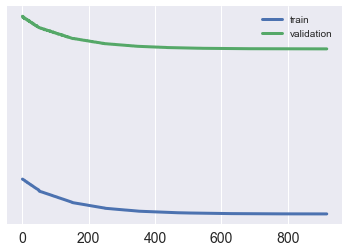

In [92]:
plt.semilogy(history.history["loss"], label="train")
plt.semilogy(history.history["val_loss"], label="validation")

plt.legend()
plt.show()